In [ ]:
"""
https://rieltor.ua/rovno/flats-sale/?sort=-byprice#9.05/50.7127/26.6092
https://dom.ria.com/uk/realty-prodaja-kvartira-rovno-tsentr-mira-prospekt-26769486.html
https://forbes.ua/money/budivnitstva-ne-zapuskayutsya-popitu-nemae-ale-tsini-ne-padayut-doslidzhennya-rinku-nerukhomosti-pid-chas-viyni-vid-ernst-amp-young-13032023-12337
https://ua.m2bomber.com/stat/448930/view/rivne?type=flat-sell

M2Bomber
dom.ria.com
realtor.ua
forbes.ua

Вартість в доларах із-за нестабільності курса валют 

Будівництво скоротилося, попит обвалився, але ціни не падають. Дослідження ринку нерухомості під час війни від Ernst & Young. 

Датасет для квартир

"""


In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from xgboost import XGBRegressor
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
# завантаження файлу щоб код працював на інших платформах і незалежно від шляхів до файлів.
data = "data.xlsx"
file_path = os.path.join(os.getcwd(), data)

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
else:
    print(f"Файл {data} не знайдений.")

# Тепер мій датасет зберігається в об'єкті DataFrame з Pandas (df)


In [3]:
# Виведення перших 5 рядків датасету
print(df.head())

      Район Тип житла  Загальна площа (м²)  Кількість кімнат  \
0  12-школа   Будинок                   59                 3   
1  12-школа   Будинок                   90                 2   
2  12-школа  Таунхауз                  151                 3   
3  12-школа   Будинок                  240                 4   
4  12-школа   Будинок                   90                 2   

   1 новий / 2 вторични й ринок  к-сть поверхів будинку  Вартість  \
0                             2                       1     96996   
1                             2                       1    135000   
2                             2                       2    250056   
3                             2                       2    340080   
4                             2                       1    135000   

   Своя Парковка (1-є 0-не має)  Земельний участок (соток)  \
0                             1                          4   
1                             1                          6   
2             

/var/folders/fv/4htbnq6d04q4hfws4ch0x0fm0000gn/T/ipykernel_48999/3292880243.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


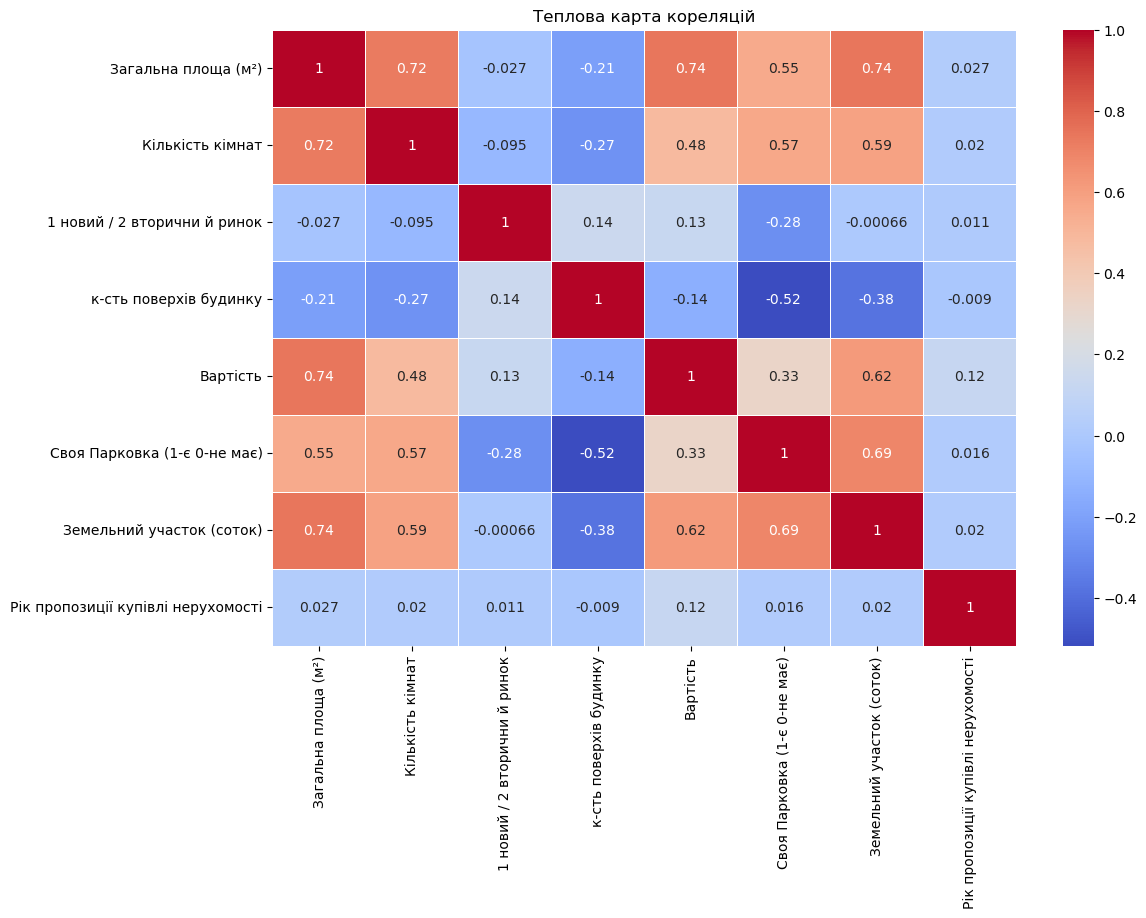

In [4]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Теплова карта кореляцій')
plt.show()



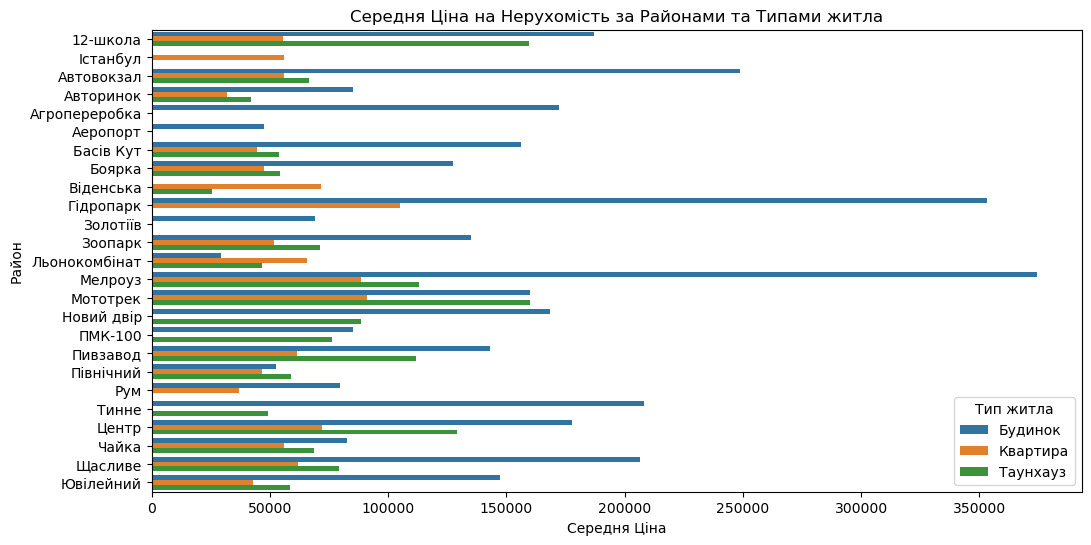

In [5]:
# Групування даних за районом та типом житла та обчислення середньої ціни
grouped_data = df.groupby(['Район', 'Тип житла'])['Вартість'].mean().reset_index()

# Створення графіка "bar plot" з розділенням за типом житла
plt.figure(figsize=(12, 6))
sns.barplot(x='Вартість', y='Район', hue='Тип житла', data=grouped_data, orient='h')
plt.xlabel('Середня Ціна')
plt.ylabel('Район')
plt.title('Середня Ціна на Нерухомість за Районами та Типами житла')
plt.show()


In [6]:
# Виведення загальної інформації про датасет
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2314 entries, 0 to 2313
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Район                               2314 non-null   object
 1   Тип житла                           2314 non-null   object
 2   Загальна площа (м²)                 2314 non-null   int64 
 3   Кількість кімнат                    2314 non-null   int64 
 4   1 новий / 2 вторични й ринок        2314 non-null   int64 
 5   к-сть поверхів будинку              2314 non-null   int64 
 6   Вартість                            2314 non-null   int64 
 7   Своя Парковка (1-є 0-не має)        2314 non-null   int64 
 8   Земельний участок (соток)           2314 non-null   int64 
 9   Рік пропозиції купівлі нерухомості  2314 non-null   int64 
dtypes: int64(8), object(2)
memory usage: 180.9+ KB
None


In [7]:
# Групування даних за роками і обчислення середнього значення цін
average_prices_by_year = df.groupby(['Рік пропозиції купівлі нерухомості'])['Вартість'].mean().reset_index()

# Додавання стовпця для відсотку зміни
average_prices_by_year['Відсоток зміни'] = average_prices_by_year['Вартість'].pct_change() * 100

# Вивід результату
print(average_prices_by_year)

   Рік пропозиції купівлі нерухомості      Вартість  Відсоток зміни
0                                2020  66860.872624             NaN
1                                2021  77502.884007       15.916650
2                                2022  89911.518900       16.010546
3                                2023  90434.551020        0.581719


In [8]:
# забираю стовпчики які мають менше залежностей з вартістю нерухомості за даними теплової карти кореляції

columns_to_drop = ['к-сть поверхів будинку']
df = df.drop(columns=columns_to_drop, axis=1)

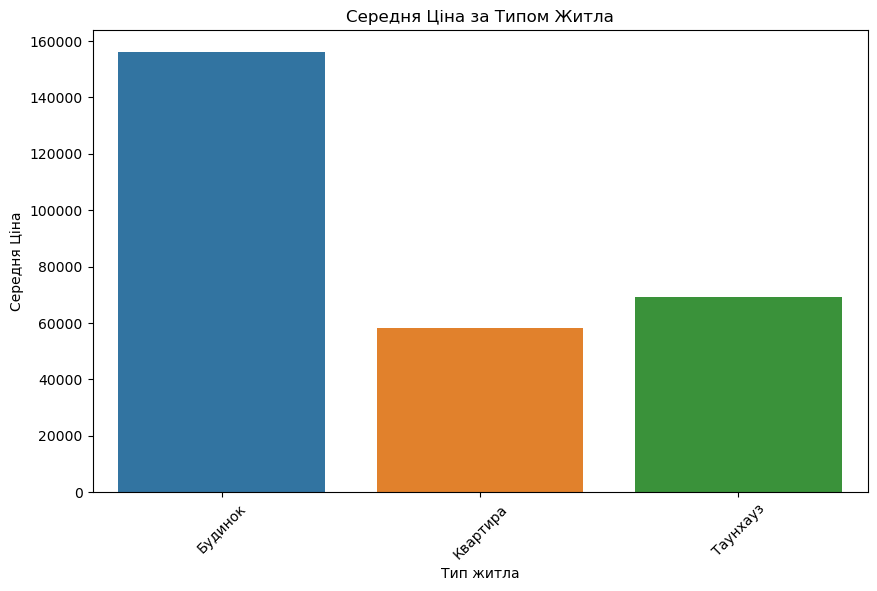

In [9]:
# Групування даних за типом житла і обчислення середньої ціни
grouped_data = df.groupby('Тип житла')['Вартість'].mean().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(10, 6))
sns.barplot(x='Тип житла', y='Вартість', data=grouped_data)
plt.xlabel('Тип житла')
plt.ylabel('Середня Ціна')
plt.title('Середня Ціна за Типом Житла')
plt.xticks(rotation=45)  
# Обертання підписів по вісі X для кращої читабельності
plt.show()


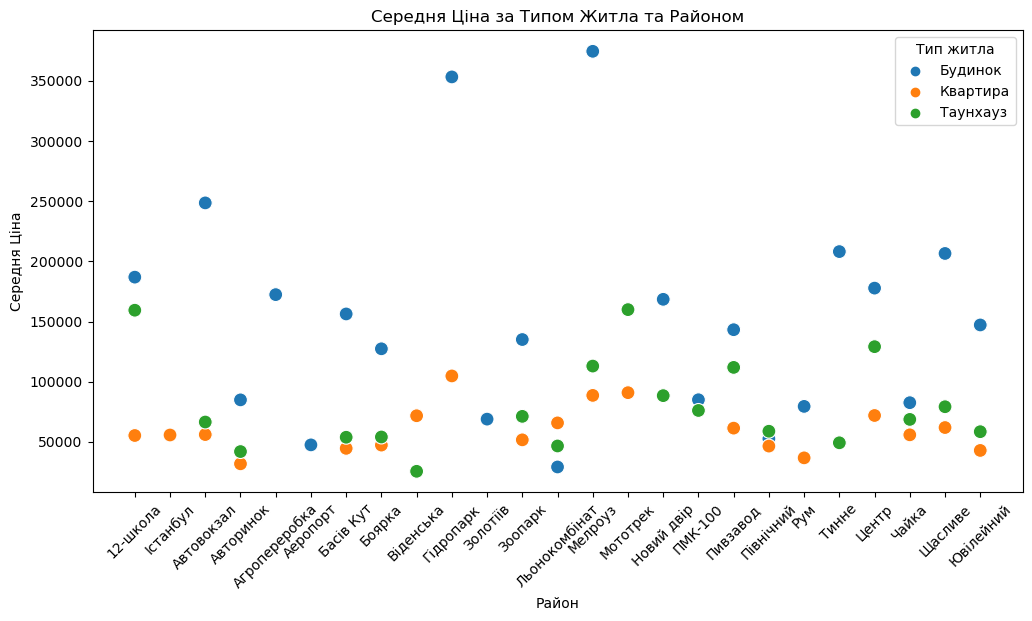

In [10]:
# Групування даних за районом і типом житла і обчислення середньої ціни
grouped_data = df.groupby(['Район', 'Тип житла'])['Вартість'].mean().reset_index()

# Створення графіка
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Район', y='Вартість', hue='Тип житла', data=grouped_data, s=100)
plt.xlabel('Район')
plt.ylabel('Середня Ціна')
plt.title('Середня Ціна за Типом Житла та Районом')
plt.xticks(rotation=45)  # Обертання підписів по вісі X для кращої читабельності
plt.legend(title='Тип житла')
plt.show()

Індекси викидів:
(array([   3,    6,   30,   33,  111,  139,  164,  276,  277,  297,  298,
        536,  539,  542,  545,  588,  622,  655,  872,  873,  881,  882,
        889,  898,  946,  972, 1353, 1432, 1490, 1712, 1713, 1774, 1778,
       1838, 1892, 1933, 1987, 1988, 1989, 2075, 2084, 2085, 2086, 2170,
       2177, 2178, 2262, 2269, 2270]),)


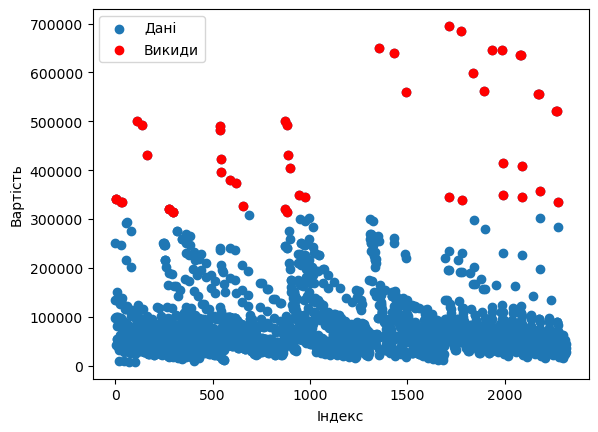

In [11]:
from scipy import stats

# Визначте стовпець, для якого ви хочете знайти викиди
column_name = 'Вартість'

# Визначте пороговий рівень для Z-оцінки (наприклад, 3)
threshold = 3

# Обчисліть Z-оцінки для стовпця
z_scores = stats.zscore(df[column_name])

# Знайдіть індекси викидів
outliers_indices = np.where(np.abs(z_scores) > threshold)

# Виведіть індекси викидів
print("Індекси викидів:")
print(outliers_indices)

# Відобразіть графік
plt.scatter(df.index, df[column_name], label='Дані')
plt.scatter(outliers_indices, df.loc[outliers_indices][column_name], color='red', label='Викиди')
plt.xlabel('Індекс')
plt.ylabel(column_name)
plt.legend()
plt.show()


In [12]:
# Створити булевий масив, де True - це рядки без викидів
is_not_outlier = np.ones(len(df), dtype=bool)
is_not_outlier[outliers_indices] = False

# Використовуйте булевий масив для відбору рядків без викидів
df_cleaned = df[is_not_outlier]

# df_cleaned тепер містить ваш датасет без викидів


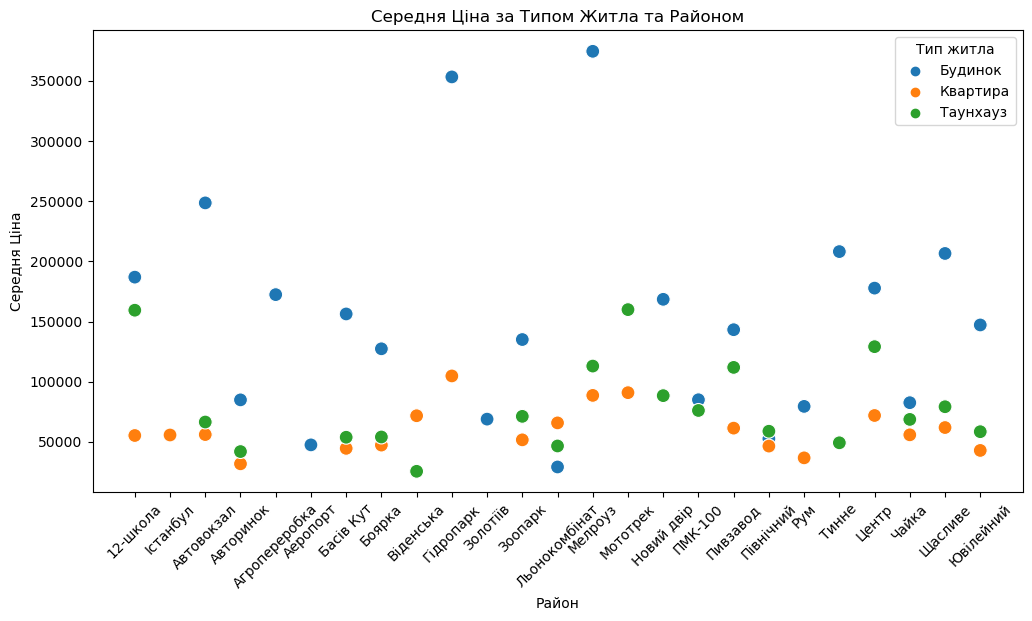

In [13]:
# Групування даних за районом і типом житла і обчислення середньої ціни
grouped_data = df.groupby(['Район', 'Тип житла'])['Вартість'].mean().reset_index()

# Створення графіка
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Район', y='Вартість', hue='Тип житла', data=grouped_data, s=100)
plt.xlabel('Район')
plt.ylabel('Середня Ціна')
plt.title('Середня Ціна за Типом Житла та Районом')
plt.xticks(rotation=45)  # Обертання підписів по вісі X для кращої читабельності
plt.legend(title='Тип житла')
plt.show()

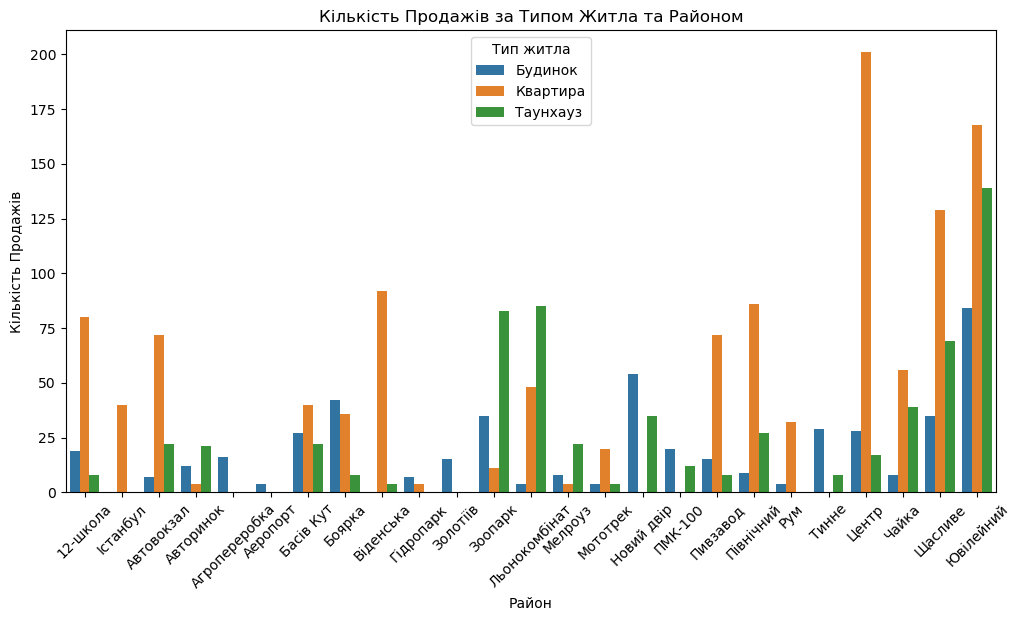

In [14]:
# Групування даних за районом і типом житла і підрахунок кількості виставлених на продажу об'єктів
count_data = df.groupby(['Район', 'Тип житла'])['Вартість'].count().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(12, 6))
sns.barplot(x='Район', y='Вартість', hue='Тип житла', data=count_data)
plt.xlabel('Район')
plt.ylabel('Кількість Продажів')
plt.title('Кількість Продажів за Типом Житла та Районом')
plt.xticks(rotation=45)  # Обертання підписів по вісі X для кращої читабельності
plt.legend(title='Тип житла')
plt.show()


In [15]:
# Замінюю категоріальні значення типу житла на числові
df['Тип житла'] = df['Тип житла'].replace({'Квартира': 1, 'Таунхауз': 2, 'Будинок': 3})

# оновлений датасет
df.head()

Район  Тип житла  Загальна площа (м²)  Кількість кімнат  \
0  12-школа          3                   59                 3   
1  12-школа          3                   90                 2   
2  12-школа          2                  151                 3   
3  12-школа          3                  240                 4   
4  12-школа          3                   90                 2   

   1 новий / 2 вторични й ринок  Вартість  Своя Парковка (1-є 0-не має)  \
0                             2     96996                             1   
1                             2    135000                             1   
2                             2    250056                             1   
3                             2    340080                             1   
4                             2    135000                             1   

   Земельний участок (соток)  Рік пропозиції купівлі нерухомості  
0                          4                                2023  
1                          6                                2023  
2                          4                                2023  
3                          7                                2023  
4                          6                                2023

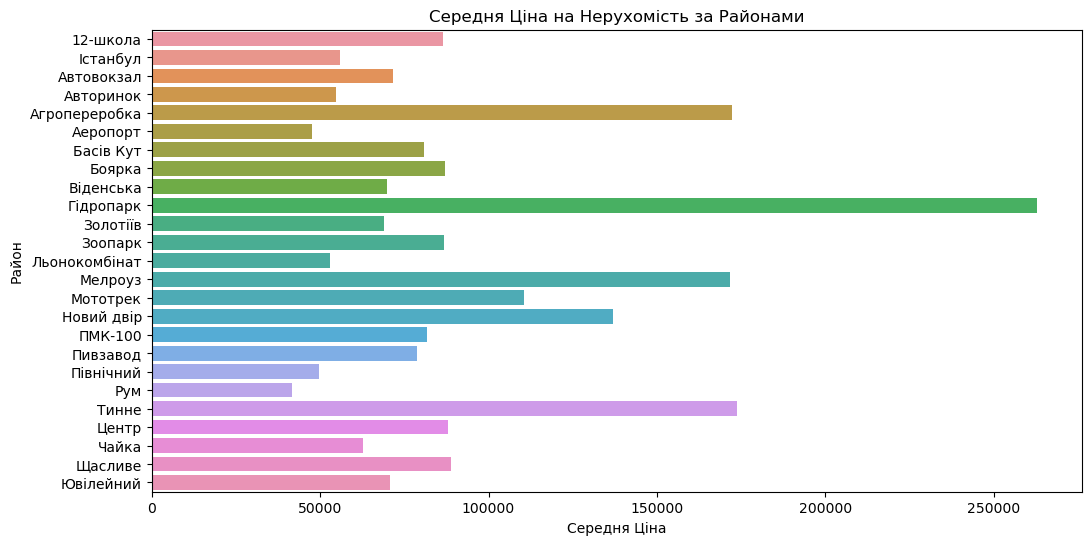

In [16]:
# Групування даних за районом і обчислення середньої ціни
grouped_data = df.groupby('Район')['Вартість'].mean().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(12, 6))
sns.barplot(x='Вартість', y='Район', data=grouped_data, orient='h')
plt.xlabel('Середня Ціна')
plt.ylabel('Район')
plt.title('Середня Ціна на Нерухомість за Районами')
plt.show()


In [30]:
# Переводимо категоріальні ознаки стовпчика "Район" треба перевести в числовий формат. 
# Для цього використовуємо One-Hot Encoding
#df = pd.get_dummies(df, columns=['Район'])

# Вирішив потім замінити значеня в стовпці 'Район' на числові
df['Район'] = df['Район'].replace({
    '12-школа': 1,
    'Автовокзал': 2,
    'Авторинок': 3,
    'Агропереробка': 4,
    'Аеропорт': 5,
    'Басів Кут': 6,
    'Боярка': 7,
    'Віденська': 8,
    'Гідропарк': 9,
    'Золотіїв': 10,
    'Зоопарк': 11,
    'Істанбул': 12,
    'Льонокомбінат': 13,
    'Мелроуз': 14,
    'Мототрек': 15,
    'Новий двір': 16,
    'Пивзавод': 17,
    'Північний': 18,
    'ПМК-100': 19,
    'Рум': 20,
    'Тинне': 21,
    'Центр': 22,
    'Чайка': 23,
    'Щасливе': 24,
    'Ювілейний': 25
})
# оновлений датасет
df.head()

Район  Тип житла  Загальна площа (м²)  Кількість кімнат  \
0      1          3                   59                 3   
1      1          3                   90                 2   
2      1          2                  151                 3   
3      1          3                  240                 4   
4      1          3                   90                 2   

   1 новий / 2 вторични й ринок  Вартість  Земельний участок (соток)  \
0                             2     96996                          4   
1                             2    135000                          6   
2                             2    250056                          4   
3                             2    340080                          7   
4                             2    135000                          6   

   Рік пропозиції купівлі нерухомості  
0                                2023  
1                                2023  
2                                2023  
3                                2023  
4                                2023

In [18]:
# тепер пробуємо створити та навчати модель машиного навчання

# Розділення даних на ознаки (X) і цільову змінну (y)
X = df.drop('Вартість', axis=1)  # Вилучення цільової змінної
y = df['Вартість']

# Розділення даних на навчальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Пробуємо створити модель лінійної регресії
model = LinearRegression()

# Тренування моделі на навчальних даних
model.fit(X_train, y_train)

# Оцінка точності моделі на тестових даних
accuracy = model.score(X_test, y_test)
print(f'Accuracy (R-squared) of Linear Regression: {accuracy}')

y_pred_linear = model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f'Mean Squared Error (MSE) of Linear Regression: {mse_linear}')


Accuracy (R-squared) of Linear Regression: 0.6232273558651205
Mean Squared Error (MSE) of Linear Regression: 2422129100.890572


In [20]:
# Пробуємо використовувати ансамблі, створимо модель випадкового лісу
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Тренування моделі на навчальних даних
rf_model.fit(X_train, y_train)

# Оцінка точності моделі на тестових даних
rf_accuracy = rf_model.score(X_test, y_test)
print(f'Accuracy (R-squared) of Random Forest: {rf_accuracy}')

y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error (MSE) of Random Forest: {mse_rf}')

Accuracy (R-squared) of Random Forest: 0.9787688026200498
Mean Squared Error (MSE) of Random Forest: 136487353.37143943


In [21]:
# Тепер пробуємо градієнтний бустинг:

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=0)

# Тренування моделі на навчальних даних
gb_model.fit(X_train, y_train)

# Оцінка точності моделі на тестових даних
gb_accuracy = gb_model.score(X_test, y_test)
print(f'Accuracy (R-squared) of Gradient Boosting: {gb_accuracy}')

y_pred_gb = gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f'Mean Squared Error (MSE) of Gradient Boosting: {mse_gb}')

Accuracy (R-squared) of Gradient Boosting: 0.9219791243888469
Mean Squared Error (MSE) of Gradient Boosting: 501566757.13188577


In [22]:
# тепер пробуємо створити та навчати модель нейроної мережі для задачі регресії та подивимось на результати

# Розділення даних на ознаки (X) і цільову змінну (y)
X = df.drop('Вартість', axis=1)  # Вилучення цільової змінної
y = df['Вартість']

# Розділення даних на навчальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Стандартизація ознак
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
# Створення та компіляція (модель створена за допомогою класу Sequential тобто шари попорядку)
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Один нейрон в вихідному шарі для регресії
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
# Навчання моделі (я підберав різну кількість епох, найкращі результати при 10 тис. так й )
model.fit(X_train, y_train, epochs=25000, batch_size=32, validation_split=0.1)

# Оцінка моделі на тестових даних
y_pred = model.predict(X_test)

Epoch 1/25000
53/53 [==============================] - 0s 1ms/step - loss: 13023115264.0000 - val_loss: 7803521024.0000
Epoch 2/25000
53/53 [==============================] - 0s 574us/step - loss: 13022147584.0000 - val_loss: 7802223104.0000
Epoch 3/25000
53/53 [==============================] - 0s 564us/step - loss: 13018898432.0000 - val_loss: 7798319616.0000
Epoch 4/25000
53/53 [==============================] - 0s 556us/step - loss: 13011769344.0000 - val_loss: 7792155136.0000
Epoch 5/25000
53/53 [==============================] - 0s 551us/step - loss: 13000347648.0000 - val_loss: 7780278272.0000
Epoch 6/25000
53/53 [==============================] - 0s 531us/step - loss: 12978667520.0000 - val_loss: 7759449600.0000
Epoch 7/25000
53/53 [==============================] - 0s 549us/step - loss: 12941576192.0000 - val_loss: 7726396416.0000
Epoch 8/25000
53/53 [==============================] - 0s 550us/step - loss: 12884240384.0000 - val_loss: 7677476352.0000
Epoch 9/25000
53/53 [=====

53/53 [==============================] - 0s 525us/step - loss: 2956533504.0000 - val_loss: 1296502528.0000
Epoch 69/25000
53/53 [==============================] - 0s 528us/step - loss: 2943143936.0000 - val_loss: 1285026304.0000
Epoch 70/25000
53/53 [==============================] - 0s 525us/step - loss: 2933120000.0000 - val_loss: 1278829824.0000
Epoch 71/25000
53/53 [==============================] - 0s 504us/step - loss: 2921660416.0000 - val_loss: 1269846912.0000
Epoch 72/25000
53/53 [==============================] - 0s 484us/step - loss: 2910878464.0000 - val_loss: 1264446208.0000
Epoch 73/25000
53/53 [==============================] - 0s 524us/step - loss: 2901697792.0000 - val_loss: 1260253184.0000
Epoch 74/25000
53/53 [==============================] - 0s 527us/step - loss: 2890662912.0000 - val_loss: 1252504576.0000
Epoch 75/25000
53/53 [==============================] - 0s 511us/step - loss: 2881472768.0000 - val_loss: 1247112064.0000
Epoch 76/25000
53/53 [=================

Epoch 135/25000
53/53 [==============================] - 0s 501us/step - loss: 2542520064.0000 - val_loss: 1116226048.0000
Epoch 136/25000
53/53 [==============================] - 0s 511us/step - loss: 2539790592.0000 - val_loss: 1105895680.0000
Epoch 137/25000
53/53 [==============================] - 0s 521us/step - loss: 2535694592.0000 - val_loss: 1104030080.0000
Epoch 138/25000
53/53 [==============================] - 0s 506us/step - loss: 2532461312.0000 - val_loss: 1099350784.0000
Epoch 139/25000
53/53 [==============================] - 0s 495us/step - loss: 2529196032.0000 - val_loss: 1092516864.0000
Epoch 140/25000
53/53 [==============================] - 0s 509us/step - loss: 2525398016.0000 - val_loss: 1086798208.0000
Epoch 141/25000
53/53 [==============================] - 0s 509us/step - loss: 2522618880.0000 - val_loss: 1080580608.0000
Epoch 142/25000
53/53 [==============================] - 0s 495us/step - loss: 2519877888.0000 - val_loss: 1076995584.0000
Epoch 143/25000


53/53 [==============================] - 0s 517us/step - loss: 2395059968.0000 - val_loss: 1071206720.0000
Epoch 202/25000
53/53 [==============================] - 0s 494us/step - loss: 2393508352.0000 - val_loss: 1063542400.0000
Epoch 203/25000
53/53 [==============================] - 0s 511us/step - loss: 2391923968.0000 - val_loss: 1060686848.0000
Epoch 204/25000
53/53 [==============================] - 0s 520us/step - loss: 2389743360.0000 - val_loss: 1060394304.0000
Epoch 205/25000
53/53 [==============================] - 0s 510us/step - loss: 2388624640.0000 - val_loss: 1060448320.0000
Epoch 206/25000
53/53 [==============================] - 0s 492us/step - loss: 2387237376.0000 - val_loss: 1060122112.0000
Epoch 207/25000
53/53 [==============================] - 0s 508us/step - loss: 2386054400.0000 - val_loss: 1049873536.0000
Epoch 208/25000
53/53 [==============================] - 0s 513us/step - loss: 2384517120.0000 - val_loss: 1054483904.0000
Epoch 209/25000
53/53 [=========

Epoch 268/25000
53/53 [==============================] - 0s 514us/step - loss: 2327370240.0000 - val_loss: 1079341568.0000
Epoch 269/25000
53/53 [==============================] - 0s 516us/step - loss: 2326507008.0000 - val_loss: 1085907968.0000
Epoch 270/25000
53/53 [==============================] - 0s 510us/step - loss: 2325147648.0000 - val_loss: 1098868352.0000
Epoch 271/25000
53/53 [==============================] - 0s 514us/step - loss: 2324815104.0000 - val_loss: 1096211584.0000
Epoch 272/25000
53/53 [==============================] - 0s 502us/step - loss: 2324556544.0000 - val_loss: 1094199040.0000
Epoch 273/25000
53/53 [==============================] - 0s 522us/step - loss: 2323211520.0000 - val_loss: 1090456960.0000
Epoch 274/25000
53/53 [==============================] - 0s 518us/step - loss: 2325200128.0000 - val_loss: 1051884928.0000
Epoch 275/25000
53/53 [==============================] - 0s 489us/step - loss: 2324637696.0000 - val_loss: 1062293568.0000
Epoch 276/25000


53/53 [==============================] - 0s 504us/step - loss: 2291209216.0000 - val_loss: 1076787968.0000
Epoch 335/25000
53/53 [==============================] - 0s 517us/step - loss: 2290983424.0000 - val_loss: 1078958336.0000
Epoch 336/25000
53/53 [==============================] - 0s 509us/step - loss: 2289841408.0000 - val_loss: 1082402688.0000
Epoch 337/25000
53/53 [==============================] - 0s 514us/step - loss: 2289795840.0000 - val_loss: 1088776448.0000
Epoch 338/25000
53/53 [==============================] - 0s 513us/step - loss: 2288923648.0000 - val_loss: 1086888192.0000
Epoch 339/25000
53/53 [==============================] - 0s 497us/step - loss: 2288410624.0000 - val_loss: 1093180416.0000
Epoch 340/25000
53/53 [==============================] - 0s 508us/step - loss: 2287473152.0000 - val_loss: 1092486528.0000
Epoch 341/25000
53/53 [==============================] - 0s 496us/step - loss: 2287356928.0000 - val_loss: 1092640000.0000
Epoch 342/25000
53/53 [=========

Epoch 401/25000
53/53 [==============================] - 0s 520us/step - loss: 2266137344.0000 - val_loss: 1117228032.0000
Epoch 402/25000
53/53 [==============================] - 0s 501us/step - loss: 2265808128.0000 - val_loss: 1116583808.0000
Epoch 403/25000
53/53 [==============================] - 0s 509us/step - loss: 2266222848.0000 - val_loss: 1117046912.0000
Epoch 404/25000
53/53 [==============================] - 0s 495us/step - loss: 2265438208.0000 - val_loss: 1119353088.0000
Epoch 405/25000
53/53 [==============================] - 0s 518us/step - loss: 2265728512.0000 - val_loss: 1120845952.0000
Epoch 406/25000
53/53 [==============================] - 0s 517us/step - loss: 2265610240.0000 - val_loss: 1119432960.0000
Epoch 407/25000
53/53 [==============================] - 0s 515us/step - loss: 2264982528.0000 - val_loss: 1123962624.0000
Epoch 408/25000
53/53 [==============================] - 0s 516us/step - loss: 2267071744.0000 - val_loss: 1110250112.0000
Epoch 409/25000


53/53 [==============================] - 0s 507us/step - loss: 2253390336.0000 - val_loss: 1133497728.0000
Epoch 468/25000
53/53 [==============================] - 0s 517us/step - loss: 2254043648.0000 - val_loss: 1140270848.0000
Epoch 469/25000
53/53 [==============================] - 0s 512us/step - loss: 2253142528.0000 - val_loss: 1147779072.0000
Epoch 470/25000
53/53 [==============================] - 0s 489us/step - loss: 2252779776.0000 - val_loss: 1139233024.0000
Epoch 471/25000
53/53 [==============================] - 0s 506us/step - loss: 2252989952.0000 - val_loss: 1138976640.0000
Epoch 472/25000
53/53 [==============================] - 0s 489us/step - loss: 2252111872.0000 - val_loss: 1145438720.0000
Epoch 473/25000
53/53 [==============================] - 0s 512us/step - loss: 2252080128.0000 - val_loss: 1148810496.0000
Epoch 474/25000
53/53 [==============================] - 0s 513us/step - loss: 2252151296.0000 - val_loss: 1150991872.0000
Epoch 475/25000
53/53 [=========

Epoch 534/25000
53/53 [==============================] - 0s 520us/step - loss: 2246274560.0000 - val_loss: 1152567040.0000
Epoch 535/25000
53/53 [==============================] - 0s 501us/step - loss: 2242729984.0000 - val_loss: 1211887616.0000
Epoch 536/25000
53/53 [==============================] - 0s 506us/step - loss: 2247016960.0000 - val_loss: 1202569600.0000
Epoch 537/25000
53/53 [==============================] - 0s 498us/step - loss: 2246267648.0000 - val_loss: 1196787584.0000
Epoch 538/25000
53/53 [==============================] - 0s 517us/step - loss: 2245985792.0000 - val_loss: 1193319168.0000
Epoch 539/25000
53/53 [==============================] - 0s 518us/step - loss: 2245673984.0000 - val_loss: 1188229504.0000
Epoch 540/25000
53/53 [==============================] - 0s 495us/step - loss: 2245159424.0000 - val_loss: 1190634496.0000
Epoch 541/25000
53/53 [==============================] - 0s 506us/step - loss: 2244628992.0000 - val_loss: 1186487040.0000
Epoch 542/25000


53/53 [==============================] - 0s 533us/step - loss: 2239065856.0000 - val_loss: 1175378432.0000
Epoch 601/25000
53/53 [==============================] - 0s 518us/step - loss: 2238748416.0000 - val_loss: 1170788608.0000
Epoch 602/25000
53/53 [==============================] - 0s 506us/step - loss: 2238302208.0000 - val_loss: 1171114112.0000
Epoch 603/25000
53/53 [==============================] - 0s 514us/step - loss: 2238199040.0000 - val_loss: 1172745216.0000
Epoch 604/25000
53/53 [==============================] - 0s 514us/step - loss: 2237885440.0000 - val_loss: 1162577408.0000
Epoch 605/25000
53/53 [==============================] - 0s 499us/step - loss: 2238176768.0000 - val_loss: 1159974016.0000
Epoch 606/25000
53/53 [==============================] - 0s 516us/step - loss: 2238093312.0000 - val_loss: 1161090816.0000
Epoch 607/25000
53/53 [==============================] - 0s 516us/step - loss: 2239269376.0000 - val_loss: 1167262848.0000
Epoch 608/25000
53/53 [=========

Epoch 667/25000
53/53 [==============================] - 0s 514us/step - loss: 2233037312.0000 - val_loss: 1177986944.0000
Epoch 668/25000
53/53 [==============================] - 0s 506us/step - loss: 2232948224.0000 - val_loss: 1174829184.0000
Epoch 669/25000
53/53 [==============================] - 0s 523us/step - loss: 2232934144.0000 - val_loss: 1174942080.0000
Epoch 670/25000
53/53 [==============================] - 0s 492us/step - loss: 2233374720.0000 - val_loss: 1168024320.0000
Epoch 671/25000
53/53 [==============================] - 0s 508us/step - loss: 2232503296.0000 - val_loss: 1171923712.0000
Epoch 672/25000
53/53 [==============================] - 0s 516us/step - loss: 2233489664.0000 - val_loss: 1182519040.0000
Epoch 673/25000
53/53 [==============================] - 0s 507us/step - loss: 2233377024.0000 - val_loss: 1180333952.0000
Epoch 674/25000
53/53 [==============================] - 0s 502us/step - loss: 2232264704.0000 - val_loss: 1176347392.0000
Epoch 675/25000


53/53 [==============================] - 0s 494us/step - loss: 2227669760.0000 - val_loss: 1184519552.0000
Epoch 734/25000
53/53 [==============================] - 0s 507us/step - loss: 2227300096.0000 - val_loss: 1179248896.0000
Epoch 735/25000
53/53 [==============================] - 0s 511us/step - loss: 2226956032.0000 - val_loss: 1181739776.0000
Epoch 736/25000
53/53 [==============================] - 0s 518us/step - loss: 2227461632.0000 - val_loss: 1177500032.0000
Epoch 737/25000
53/53 [==============================] - 0s 509us/step - loss: 2226908928.0000 - val_loss: 1178370176.0000
Epoch 738/25000
53/53 [==============================] - 0s 503us/step - loss: 2227801344.0000 - val_loss: 1183872128.0000
Epoch 739/25000
53/53 [==============================] - 0s 505us/step - loss: 2227107328.0000 - val_loss: 1185242880.0000
Epoch 740/25000
53/53 [==============================] - 0s 501us/step - loss: 2226969088.0000 - val_loss: 1186605440.0000
Epoch 741/25000
53/53 [=========

Epoch 800/25000
53/53 [==============================] - 0s 513us/step - loss: 2222303488.0000 - val_loss: 1156015104.0000
Epoch 801/25000
53/53 [==============================] - 0s 497us/step - loss: 2222114816.0000 - val_loss: 1163280768.0000
Epoch 802/25000
53/53 [==============================] - 0s 504us/step - loss: 2222031104.0000 - val_loss: 1165755648.0000
Epoch 803/25000
53/53 [==============================] - 0s 512us/step - loss: 2222891776.0000 - val_loss: 1160889856.0000
Epoch 804/25000
53/53 [==============================] - 0s 515us/step - loss: 2222122240.0000 - val_loss: 1162556928.0000
Epoch 805/25000
53/53 [==============================] - 0s 503us/step - loss: 2221776640.0000 - val_loss: 1154580992.0000
Epoch 806/25000
53/53 [==============================] - 0s 507us/step - loss: 2221904128.0000 - val_loss: 1156783744.0000
Epoch 807/25000
53/53 [==============================] - 0s 501us/step - loss: 2223480064.0000 - val_loss: 1151067136.0000
Epoch 808/25000


53/53 [==============================] - 0s 526us/step - loss: 2216782336.0000 - val_loss: 1172784896.0000
Epoch 867/25000
53/53 [==============================] - 0s 513us/step - loss: 2217177344.0000 - val_loss: 1172697088.0000
Epoch 868/25000
53/53 [==============================] - 0s 509us/step - loss: 2217012480.0000 - val_loss: 1178719872.0000
Epoch 869/25000
53/53 [==============================] - 0s 503us/step - loss: 2217022208.0000 - val_loss: 1175497344.0000
Epoch 870/25000
53/53 [==============================] - 0s 498us/step - loss: 2218114816.0000 - val_loss: 1169702784.0000
Epoch 871/25000
53/53 [==============================] - 0s 516us/step - loss: 2216357376.0000 - val_loss: 1170343936.0000
Epoch 872/25000
53/53 [==============================] - 0s 508us/step - loss: 2216695552.0000 - val_loss: 1169637760.0000
Epoch 873/25000
53/53 [==============================] - 0s 511us/step - loss: 2216575744.0000 - val_loss: 1176488320.0000
Epoch 874/25000
53/53 [=========

Epoch 933/25000
53/53 [==============================] - 0s 525us/step - loss: 2212967168.0000 - val_loss: 1181058816.0000
Epoch 934/25000
53/53 [==============================] - 0s 518us/step - loss: 2211321600.0000 - val_loss: 1174684672.0000
Epoch 935/25000
53/53 [==============================] - 0s 511us/step - loss: 2211532800.0000 - val_loss: 1172802944.0000
Epoch 936/25000
53/53 [==============================] - 0s 501us/step - loss: 2211192064.0000 - val_loss: 1170720896.0000
Epoch 937/25000
53/53 [==============================] - 0s 492us/step - loss: 2211571968.0000 - val_loss: 1173516544.0000
Epoch 938/25000
53/53 [==============================] - 0s 515us/step - loss: 2212575232.0000 - val_loss: 1169226496.0000
Epoch 939/25000
53/53 [==============================] - 0s 488us/step - loss: 2210999296.0000 - val_loss: 1176184704.0000
Epoch 940/25000
53/53 [==============================] - 0s 508us/step - loss: 2211768320.0000 - val_loss: 1175272192.0000
Epoch 941/25000


53/53 [==============================] - 0s 518us/step - loss: 2206805760.0000 - val_loss: 1174994176.0000
Epoch 1000/25000
53/53 [==============================] - 0s 506us/step - loss: 2206269440.0000 - val_loss: 1171463424.0000
Epoch 1001/25000
53/53 [==============================] - 0s 491us/step - loss: 2207367168.0000 - val_loss: 1164919936.0000
Epoch 1002/25000
53/53 [==============================] - 0s 510us/step - loss: 2205868544.0000 - val_loss: 1167614080.0000
Epoch 1003/25000
53/53 [==============================] - 0s 509us/step - loss: 2206477312.0000 - val_loss: 1165489408.0000
Epoch 1004/25000
53/53 [==============================] - 0s 496us/step - loss: 2206015744.0000 - val_loss: 1156511104.0000
Epoch 1005/25000
53/53 [==============================] - 0s 508us/step - loss: 2206094080.0000 - val_loss: 1159126912.0000
Epoch 1006/25000
53/53 [==============================] - 0s 488us/step - loss: 2206442496.0000 - val_loss: 1165088128.0000
Epoch 1007/25000
53/53 [=

53/53 [==============================] - 0s 513us/step - loss: 2200994048.0000 - val_loss: 1172473856.0000
Epoch 1066/25000
53/53 [==============================] - 0s 515us/step - loss: 2202095104.0000 - val_loss: 1168826752.0000
Epoch 1067/25000
53/53 [==============================] - 0s 510us/step - loss: 2201344512.0000 - val_loss: 1176706688.0000
Epoch 1068/25000
53/53 [==============================] - 0s 488us/step - loss: 2200972800.0000 - val_loss: 1174809344.0000
Epoch 1069/25000
53/53 [==============================] - 0s 526us/step - loss: 2200496896.0000 - val_loss: 1175655296.0000
Epoch 1070/25000
53/53 [==============================] - 0s 498us/step - loss: 2200640768.0000 - val_loss: 1174194304.0000
Epoch 1071/25000
53/53 [==============================] - 0s 490us/step - loss: 2201055232.0000 - val_loss: 1175135232.0000
Epoch 1072/25000
53/53 [==============================] - 0s 506us/step - loss: 2200487680.0000 - val_loss: 1175894272.0000
Epoch 1073/25000
53/53 [=

53/53 [==============================] - 0s 511us/step - loss: 2197326336.0000 - val_loss: 1188680320.0000
Epoch 1132/25000
53/53 [==============================] - 0s 524us/step - loss: 2196416768.0000 - val_loss: 1184823424.0000
Epoch 1133/25000
53/53 [==============================] - 0s 498us/step - loss: 2196537088.0000 - val_loss: 1189202816.0000
Epoch 1134/25000
53/53 [==============================] - 0s 510us/step - loss: 2196810240.0000 - val_loss: 1187741440.0000
Epoch 1135/25000
53/53 [==============================] - 0s 496us/step - loss: 2197459712.0000 - val_loss: 1174441856.0000
Epoch 1136/25000
53/53 [==============================] - 0s 517us/step - loss: 2198076416.0000 - val_loss: 1186370176.0000
Epoch 1137/25000
53/53 [==============================] - 0s 511us/step - loss: 2195690496.0000 - val_loss: 1180898688.0000
Epoch 1138/25000
53/53 [==============================] - 0s 506us/step - loss: 2196016896.0000 - val_loss: 1176562688.0000
Epoch 1139/25000
53/53 [=

53/53 [==============================] - 0s 523us/step - loss: 2193716480.0000 - val_loss: 1250978048.0000
Epoch 1198/25000
53/53 [==============================] - 0s 496us/step - loss: 2196198400.0000 - val_loss: 1245725952.0000
Epoch 1199/25000
53/53 [==============================] - 0s 519us/step - loss: 2195912448.0000 - val_loss: 1235516160.0000
Epoch 1200/25000
53/53 [==============================] - 0s 512us/step - loss: 2194394112.0000 - val_loss: 1234225920.0000
Epoch 1201/25000
53/53 [==============================] - 0s 491us/step - loss: 2194365440.0000 - val_loss: 1224457472.0000
Epoch 1202/25000
53/53 [==============================] - 0s 508us/step - loss: 2193393920.0000 - val_loss: 1225514112.0000
Epoch 1203/25000
53/53 [==============================] - 0s 490us/step - loss: 2193218048.0000 - val_loss: 1217155072.0000
Epoch 1204/25000
53/53 [==============================] - 0s 501us/step - loss: 2192916224.0000 - val_loss: 1217668608.0000
Epoch 1205/25000
53/53 [=

53/53 [==============================] - 0s 525us/step - loss: 2187321600.0000 - val_loss: 1182280960.0000
Epoch 1264/25000
53/53 [==============================] - 0s 513us/step - loss: 2187060736.0000 - val_loss: 1184406272.0000
Epoch 1265/25000
53/53 [==============================] - 0s 509us/step - loss: 2188158720.0000 - val_loss: 1178846720.0000
Epoch 1266/25000
53/53 [==============================] - 0s 512us/step - loss: 2188581632.0000 - val_loss: 1200225152.0000
Epoch 1267/25000
53/53 [==============================] - 0s 507us/step - loss: 2193291264.0000 - val_loss: 1253619072.0000
Epoch 1268/25000
53/53 [==============================] - 0s 495us/step - loss: 2191662336.0000 - val_loss: 1248045952.0000
Epoch 1269/25000
53/53 [==============================] - 0s 526us/step - loss: 2190459136.0000 - val_loss: 1236407808.0000
Epoch 1270/25000
53/53 [==============================] - 0s 506us/step - loss: 2190131968.0000 - val_loss: 1231712256.0000
Epoch 1271/25000
53/53 [=

53/53 [==============================] - 0s 530us/step - loss: 2183171072.0000 - val_loss: 1177512832.0000
Epoch 1330/25000
53/53 [==============================] - 0s 535us/step - loss: 2183303936.0000 - val_loss: 1179448448.0000
Epoch 1331/25000
53/53 [==============================] - 0s 498us/step - loss: 2184421888.0000 - val_loss: 1181539968.0000
Epoch 1332/25000
53/53 [==============================] - 0s 503us/step - loss: 2183992576.0000 - val_loss: 1174233856.0000
Epoch 1333/25000
53/53 [==============================] - 0s 502us/step - loss: 2182978304.0000 - val_loss: 1176978816.0000
Epoch 1334/25000
53/53 [==============================] - 0s 501us/step - loss: 2183674880.0000 - val_loss: 1180899200.0000
Epoch 1335/25000
53/53 [==============================] - 0s 520us/step - loss: 2182538240.0000 - val_loss: 1178774272.0000
Epoch 1336/25000
53/53 [==============================] - 0s 503us/step - loss: 2183344384.0000 - val_loss: 1183667200.0000
Epoch 1337/25000
53/53 [=

53/53 [==============================] - 0s 526us/step - loss: 2178219264.0000 - val_loss: 1176399616.0000
Epoch 1396/25000
53/53 [==============================] - 0s 533us/step - loss: 2178615296.0000 - val_loss: 1171163264.0000
Epoch 1397/25000
53/53 [==============================] - 0s 506us/step - loss: 2178299392.0000 - val_loss: 1172829952.0000
Epoch 1398/25000
53/53 [==============================] - 0s 498us/step - loss: 2178254080.0000 - val_loss: 1171452800.0000
Epoch 1399/25000
53/53 [==============================] - 0s 520us/step - loss: 2178455552.0000 - val_loss: 1171599616.0000
Epoch 1400/25000
53/53 [==============================] - 0s 499us/step - loss: 2178611456.0000 - val_loss: 1181418496.0000
Epoch 1401/25000
53/53 [==============================] - 0s 480us/step - loss: 2179054848.0000 - val_loss: 1189717888.0000
Epoch 1402/25000
53/53 [==============================] - 0s 519us/step - loss: 2178814464.0000 - val_loss: 1176763648.0000
Epoch 1403/25000
53/53 [=

53/53 [==============================] - 0s 523us/step - loss: 2175288576.0000 - val_loss: 1182932480.0000
Epoch 1462/25000
53/53 [==============================] - 0s 512us/step - loss: 2174100224.0000 - val_loss: 1177647744.0000
Epoch 1463/25000
53/53 [==============================] - 0s 512us/step - loss: 2173455360.0000 - val_loss: 1175282816.0000
Epoch 1464/25000
53/53 [==============================] - 0s 522us/step - loss: 2173719808.0000 - val_loss: 1172235392.0000
Epoch 1465/25000
53/53 [==============================] - 0s 487us/step - loss: 2173829888.0000 - val_loss: 1165199872.0000
Epoch 1466/25000
53/53 [==============================] - 0s 491us/step - loss: 2173237760.0000 - val_loss: 1181053440.0000
Epoch 1467/25000
53/53 [==============================] - 0s 526us/step - loss: 2173488384.0000 - val_loss: 1180855424.0000
Epoch 1468/25000
53/53 [==============================] - 0s 519us/step - loss: 2173371136.0000 - val_loss: 1179614080.0000
Epoch 1469/25000
53/53 [=

53/53 [==============================] - 0s 511us/step - loss: 2169310464.0000 - val_loss: 1175473280.0000
Epoch 1528/25000
53/53 [==============================] - 0s 532us/step - loss: 2168728320.0000 - val_loss: 1170421760.0000
Epoch 1529/25000
53/53 [==============================] - 0s 536us/step - loss: 2168404224.0000 - val_loss: 1178431232.0000
Epoch 1530/25000
53/53 [==============================] - 0s 521us/step - loss: 2169071616.0000 - val_loss: 1187258752.0000
Epoch 1531/25000
53/53 [==============================] - 0s 525us/step - loss: 2171758080.0000 - val_loss: 1175648128.0000
Epoch 1532/25000
53/53 [==============================] - 0s 518us/step - loss: 2167993600.0000 - val_loss: 1183293056.0000
Epoch 1533/25000
53/53 [==============================] - 0s 517us/step - loss: 2167983360.0000 - val_loss: 1185175168.0000
Epoch 1534/25000
53/53 [==============================] - 0s 491us/step - loss: 2168533760.0000 - val_loss: 1183974784.0000
Epoch 1535/25000
53/53 [=

53/53 [==============================] - 0s 534us/step - loss: 2163817216.0000 - val_loss: 1184561792.0000
Epoch 1594/25000
53/53 [==============================] - 0s 504us/step - loss: 2163545344.0000 - val_loss: 1179925504.0000
Epoch 1595/25000
53/53 [==============================] - 0s 507us/step - loss: 2163234048.0000 - val_loss: 1177685376.0000
Epoch 1596/25000
53/53 [==============================] - 0s 493us/step - loss: 2163353856.0000 - val_loss: 1179883136.0000
Epoch 1597/25000
53/53 [==============================] - 0s 520us/step - loss: 2163791104.0000 - val_loss: 1171442048.0000
Epoch 1598/25000
53/53 [==============================] - 0s 515us/step - loss: 2164582656.0000 - val_loss: 1180520576.0000
Epoch 1599/25000
53/53 [==============================] - 0s 500us/step - loss: 2163263232.0000 - val_loss: 1178051840.0000
Epoch 1600/25000
53/53 [==============================] - 0s 500us/step - loss: 2163507200.0000 - val_loss: 1181112448.0000
Epoch 1601/25000
53/53 [=

53/53 [==============================] - 0s 510us/step - loss: 2159093504.0000 - val_loss: 1176311168.0000
Epoch 1660/25000
53/53 [==============================] - 0s 500us/step - loss: 2158661632.0000 - val_loss: 1173158656.0000
Epoch 1661/25000
53/53 [==============================] - 0s 511us/step - loss: 2158632960.0000 - val_loss: 1177761536.0000
Epoch 1662/25000
53/53 [==============================] - 0s 488us/step - loss: 2159049984.0000 - val_loss: 1177604352.0000
Epoch 1663/25000
53/53 [==============================] - 0s 500us/step - loss: 2159061504.0000 - val_loss: 1175795200.0000
Epoch 1664/25000
53/53 [==============================] - 0s 511us/step - loss: 2158894592.0000 - val_loss: 1168701312.0000
Epoch 1665/25000
53/53 [==============================] - 0s 505us/step - loss: 2157931264.0000 - val_loss: 1172243200.0000
Epoch 1666/25000
53/53 [==============================] - 0s 513us/step - loss: 2157903872.0000 - val_loss: 1174823296.0000
Epoch 1667/25000
53/53 [=

53/53 [==============================] - 0s 525us/step - loss: 2153465088.0000 - val_loss: 1207392000.0000
Epoch 1726/25000
53/53 [==============================] - 0s 525us/step - loss: 2153573632.0000 - val_loss: 1207715584.0000
Epoch 1727/25000
53/53 [==============================] - 0s 499us/step - loss: 2154002432.0000 - val_loss: 1199187200.0000
Epoch 1728/25000
53/53 [==============================] - 0s 517us/step - loss: 2152958208.0000 - val_loss: 1199537408.0000
Epoch 1729/25000
53/53 [==============================] - 0s 484us/step - loss: 2152627712.0000 - val_loss: 1192675200.0000
Epoch 1730/25000
53/53 [==============================] - 0s 511us/step - loss: 2152250368.0000 - val_loss: 1178134656.0000
Epoch 1731/25000
53/53 [==============================] - 0s 506us/step - loss: 2153643008.0000 - val_loss: 1181318144.0000
Epoch 1732/25000
53/53 [==============================] - 0s 507us/step - loss: 2152130048.0000 - val_loss: 1175458304.0000
Epoch 1733/25000
53/53 [=

53/53 [==============================] - 0s 513us/step - loss: 2151581952.0000 - val_loss: 1181071616.0000
Epoch 1792/25000
53/53 [==============================] - 0s 511us/step - loss: 2147361792.0000 - val_loss: 1175446272.0000
Epoch 1793/25000
53/53 [==============================] - 0s 531us/step - loss: 2147060864.0000 - val_loss: 1176333952.0000
Epoch 1794/25000
53/53 [==============================] - 0s 490us/step - loss: 2147367168.0000 - val_loss: 1172579200.0000
Epoch 1795/25000
53/53 [==============================] - 0s 491us/step - loss: 2147578880.0000 - val_loss: 1169577856.0000
Epoch 1796/25000
53/53 [==============================] - 0s 526us/step - loss: 2147268608.0000 - val_loss: 1176236032.0000
Epoch 1797/25000
53/53 [==============================] - 0s 506us/step - loss: 2146988672.0000 - val_loss: 1177140096.0000
Epoch 1798/25000
53/53 [==============================] - 0s 505us/step - loss: 2147167616.0000 - val_loss: 1177765504.0000
Epoch 1799/25000
53/53 [=

53/53 [==============================] - 0s 508us/step - loss: 2146344832.0000 - val_loss: 1258251392.0000
Epoch 1858/25000
53/53 [==============================] - 0s 514us/step - loss: 2147567616.0000 - val_loss: 1250194688.0000
Epoch 1859/25000
53/53 [==============================] - 0s 530us/step - loss: 2146279040.0000 - val_loss: 1239144704.0000
Epoch 1860/25000
53/53 [==============================] - 0s 502us/step - loss: 2145142400.0000 - val_loss: 1230027520.0000
Epoch 1861/25000
53/53 [==============================] - 0s 496us/step - loss: 2144276864.0000 - val_loss: 1223969408.0000
Epoch 1862/25000
53/53 [==============================] - 0s 515us/step - loss: 2145515904.0000 - val_loss: 1215224832.0000
Epoch 1863/25000
53/53 [==============================] - 0s 518us/step - loss: 2142955520.0000 - val_loss: 1214450048.0000
Epoch 1864/25000
53/53 [==============================] - 0s 501us/step - loss: 2142845312.0000 - val_loss: 1208635392.0000
Epoch 1865/25000
53/53 [=

53/53 [==============================] - 0s 543us/step - loss: 2137746048.0000 - val_loss: 1175071104.0000
Epoch 1924/25000
53/53 [==============================] - 0s 496us/step - loss: 2137207424.0000 - val_loss: 1180701824.0000
Epoch 1925/25000
53/53 [==============================] - 0s 526us/step - loss: 2137594752.0000 - val_loss: 1175284608.0000
Epoch 1926/25000
53/53 [==============================] - 0s 507us/step - loss: 2137537920.0000 - val_loss: 1180920960.0000
Epoch 1927/25000
53/53 [==============================] - 0s 513us/step - loss: 2137263488.0000 - val_loss: 1179506304.0000
Epoch 1928/25000
53/53 [==============================] - 0s 510us/step - loss: 2136787712.0000 - val_loss: 1179985408.0000
Epoch 1929/25000
53/53 [==============================] - 0s 524us/step - loss: 2137912064.0000 - val_loss: 1176558592.0000
Epoch 1930/25000
53/53 [==============================] - 0s 498us/step - loss: 2136573440.0000 - val_loss: 1164577152.0000
Epoch 1931/25000
53/53 [=

53/53 [==============================] - 0s 525us/step - loss: 2132914944.0000 - val_loss: 1176127232.0000
Epoch 1990/25000
53/53 [==============================] - 0s 542us/step - loss: 2133249024.0000 - val_loss: 1136013312.0000
Epoch 1991/25000
53/53 [==============================] - 0s 515us/step - loss: 2133955968.0000 - val_loss: 1135827072.0000
Epoch 1992/25000
53/53 [==============================] - 0s 503us/step - loss: 2133865216.0000 - val_loss: 1144741248.0000
Epoch 1993/25000
53/53 [==============================] - 0s 509us/step - loss: 2133296384.0000 - val_loss: 1153631488.0000
Epoch 1994/25000
53/53 [==============================] - 0s 507us/step - loss: 2132680832.0000 - val_loss: 1155752320.0000
Epoch 1995/25000
53/53 [==============================] - 0s 512us/step - loss: 2133683584.0000 - val_loss: 1156958720.0000
Epoch 1996/25000
53/53 [==============================] - 0s 501us/step - loss: 2132434560.0000 - val_loss: 1157267968.0000
Epoch 1997/25000
53/53 [=

53/53 [==============================] - 0s 526us/step - loss: 2127273088.0000 - val_loss: 1175295104.0000
Epoch 2056/25000
53/53 [==============================] - 0s 532us/step - loss: 2127564032.0000 - val_loss: 1176224512.0000
Epoch 2057/25000
53/53 [==============================] - 0s 508us/step - loss: 2127459200.0000 - val_loss: 1173464320.0000
Epoch 2058/25000
53/53 [==============================] - 0s 503us/step - loss: 2127530624.0000 - val_loss: 1175964928.0000
Epoch 2059/25000
53/53 [==============================] - 0s 496us/step - loss: 2128930304.0000 - val_loss: 1172741120.0000
Epoch 2060/25000
53/53 [==============================] - 0s 485us/step - loss: 2127462144.0000 - val_loss: 1177283200.0000
Epoch 2061/25000
53/53 [==============================] - 0s 506us/step - loss: 2127322752.0000 - val_loss: 1171350016.0000
Epoch 2062/25000
53/53 [==============================] - 0s 511us/step - loss: 2127153024.0000 - val_loss: 1172244864.0000
Epoch 2063/25000
53/53 [=

53/53 [==============================] - 0s 522us/step - loss: 2122430208.0000 - val_loss: 1167356800.0000
Epoch 2122/25000
53/53 [==============================] - 0s 519us/step - loss: 2121482240.0000 - val_loss: 1171139840.0000
Epoch 2123/25000
53/53 [==============================] - 0s 498us/step - loss: 2123044096.0000 - val_loss: 1129509888.0000
Epoch 2124/25000
53/53 [==============================] - 0s 509us/step - loss: 2123194880.0000 - val_loss: 1137906304.0000
Epoch 2125/25000
53/53 [==============================] - 0s 533us/step - loss: 2122937344.0000 - val_loss: 1137459072.0000
Epoch 2126/25000
53/53 [==============================] - 0s 507us/step - loss: 2123271680.0000 - val_loss: 1144472320.0000
Epoch 2127/25000
53/53 [==============================] - 0s 497us/step - loss: 2122538112.0000 - val_loss: 1146366592.0000
Epoch 2128/25000
53/53 [==============================] - 0s 502us/step - loss: 2122316032.0000 - val_loss: 1156834688.0000
Epoch 2129/25000
53/53 [=

53/53 [==============================] - 0s 515us/step - loss: 2116681600.0000 - val_loss: 1173456640.0000
Epoch 2188/25000
53/53 [==============================] - 0s 521us/step - loss: 2116663552.0000 - val_loss: 1181446016.0000
Epoch 2189/25000
53/53 [==============================] - 0s 517us/step - loss: 2117447552.0000 - val_loss: 1182003328.0000
Epoch 2190/25000
53/53 [==============================] - 0s 508us/step - loss: 2116580992.0000 - val_loss: 1173193984.0000
Epoch 2191/25000
53/53 [==============================] - 0s 512us/step - loss: 2117675136.0000 - val_loss: 1184168448.0000
Epoch 2192/25000
53/53 [==============================] - 0s 516us/step - loss: 2117369088.0000 - val_loss: 1170492672.0000
Epoch 2193/25000
53/53 [==============================] - 0s 503us/step - loss: 2118138752.0000 - val_loss: 1178431360.0000
Epoch 2194/25000
53/53 [==============================] - 0s 542us/step - loss: 2117717376.0000 - val_loss: 1166320000.0000
Epoch 2195/25000
53/53 [=

53/53 [==============================] - 0s 526us/step - loss: 2110659456.0000 - val_loss: 1167053952.0000
Epoch 2254/25000
53/53 [==============================] - 0s 554us/step - loss: 2111092224.0000 - val_loss: 1163028224.0000
Epoch 2255/25000
53/53 [==============================] - 0s 524us/step - loss: 2110618368.0000 - val_loss: 1160960768.0000
Epoch 2256/25000
53/53 [==============================] - 0s 498us/step - loss: 2110446592.0000 - val_loss: 1165330816.0000
Epoch 2257/25000
53/53 [==============================] - 0s 523us/step - loss: 2110279040.0000 - val_loss: 1160787328.0000
Epoch 2258/25000
53/53 [==============================] - 0s 499us/step - loss: 2111527552.0000 - val_loss: 1165116800.0000
Epoch 2259/25000
53/53 [==============================] - 0s 514us/step - loss: 2110350080.0000 - val_loss: 1168080512.0000
Epoch 2260/25000
53/53 [==============================] - 0s 523us/step - loss: 2110820608.0000 - val_loss: 1170460160.0000
Epoch 2261/25000
53/53 [=

53/53 [==============================] - 0s 514us/step - loss: 2109423232.0000 - val_loss: 1232372096.0000
Epoch 2320/25000
53/53 [==============================] - 0s 502us/step - loss: 2108518784.0000 - val_loss: 1216831104.0000
Epoch 2321/25000
53/53 [==============================] - 0s 520us/step - loss: 2106835840.0000 - val_loss: 1211833600.0000
Epoch 2322/25000
53/53 [==============================] - 0s 485us/step - loss: 2105872128.0000 - val_loss: 1208399104.0000
Epoch 2323/25000
53/53 [==============================] - 0s 518us/step - loss: 2105897728.0000 - val_loss: 1203706624.0000
Epoch 2324/25000
53/53 [==============================] - 0s 488us/step - loss: 2106982656.0000 - val_loss: 1191527680.0000
Epoch 2325/25000
53/53 [==============================] - 0s 523us/step - loss: 2104923136.0000 - val_loss: 1188973312.0000
Epoch 2326/25000
53/53 [==============================] - 0s 509us/step - loss: 2105124224.0000 - val_loss: 1185727616.0000
Epoch 2327/25000
53/53 [=

53/53 [==============================] - 0s 507us/step - loss: 2103148928.0000 - val_loss: 1168154752.0000
Epoch 2386/25000
53/53 [==============================] - 0s 520us/step - loss: 2099437184.0000 - val_loss: 1158921728.0000
Epoch 2387/25000
53/53 [==============================] - 0s 533us/step - loss: 2099648896.0000 - val_loss: 1160502912.0000
Epoch 2388/25000
53/53 [==============================] - 0s 511us/step - loss: 2100149632.0000 - val_loss: 1160683776.0000
Epoch 2389/25000
53/53 [==============================] - 0s 508us/step - loss: 2099771904.0000 - val_loss: 1163367552.0000
Epoch 2390/25000
53/53 [==============================] - 0s 523us/step - loss: 2100087552.0000 - val_loss: 1160753152.0000
Epoch 2391/25000
53/53 [==============================] - 0s 497us/step - loss: 2098520960.0000 - val_loss: 1167545216.0000
Epoch 2392/25000
53/53 [==============================] - 0s 485us/step - loss: 2099150848.0000 - val_loss: 1169480960.0000
Epoch 2393/25000
53/53 [=

53/53 [==============================] - 0s 513us/step - loss: 2093757696.0000 - val_loss: 1153920768.0000
Epoch 2452/25000
53/53 [==============================] - 0s 557us/step - loss: 2092023424.0000 - val_loss: 1170755072.0000
Epoch 2453/25000
53/53 [==============================] - 0s 517us/step - loss: 2092928128.0000 - val_loss: 1171909888.0000
Epoch 2454/25000
53/53 [==============================] - 0s 498us/step - loss: 2093176960.0000 - val_loss: 1173669120.0000
Epoch 2455/25000
53/53 [==============================] - 0s 518us/step - loss: 2093143936.0000 - val_loss: 1165489152.0000
Epoch 2456/25000
53/53 [==============================] - 0s 505us/step - loss: 2091910528.0000 - val_loss: 1173877632.0000
Epoch 2457/25000
53/53 [==============================] - 0s 514us/step - loss: 2092293888.0000 - val_loss: 1174295936.0000
Epoch 2458/25000
53/53 [==============================] - 0s 521us/step - loss: 2092093440.0000 - val_loss: 1172183168.0000
Epoch 2459/25000
53/53 [=

53/53 [==============================] - 0s 501us/step - loss: 2086679680.0000 - val_loss: 1159187328.0000
Epoch 2518/25000
53/53 [==============================] - 0s 522us/step - loss: 2086779008.0000 - val_loss: 1167553408.0000
Epoch 2519/25000
53/53 [==============================] - 0s 537us/step - loss: 2086482560.0000 - val_loss: 1170453504.0000
Epoch 2520/25000
53/53 [==============================] - 0s 523us/step - loss: 2086207232.0000 - val_loss: 1172296576.0000
Epoch 2521/25000
53/53 [==============================] - 0s 505us/step - loss: 2086782464.0000 - val_loss: 1166591232.0000
Epoch 2522/25000
53/53 [==============================] - 0s 505us/step - loss: 2085837568.0000 - val_loss: 1171403520.0000
Epoch 2523/25000
53/53 [==============================] - 0s 500us/step - loss: 2086701952.0000 - val_loss: 1167699456.0000
Epoch 2524/25000
53/53 [==============================] - 0s 514us/step - loss: 2085511808.0000 - val_loss: 1175615104.0000
Epoch 2525/25000
53/53 [=

53/53 [==============================] - 0s 517us/step - loss: 2080582912.0000 - val_loss: 1167533568.0000
Epoch 2584/25000
53/53 [==============================] - 0s 537us/step - loss: 2080176128.0000 - val_loss: 1165387008.0000
Epoch 2585/25000
53/53 [==============================] - 0s 519us/step - loss: 2080135296.0000 - val_loss: 1174917120.0000
Epoch 2586/25000
53/53 [==============================] - 0s 511us/step - loss: 2079328256.0000 - val_loss: 1171311872.0000
Epoch 2587/25000
53/53 [==============================] - 0s 515us/step - loss: 2080413952.0000 - val_loss: 1171682560.0000
Epoch 2588/25000
53/53 [==============================] - 0s 518us/step - loss: 2080405632.0000 - val_loss: 1169970816.0000
Epoch 2589/25000
53/53 [==============================] - 0s 522us/step - loss: 2083405312.0000 - val_loss: 1136306816.0000
Epoch 2590/25000
53/53 [==============================] - 0s 533us/step - loss: 2080498432.0000 - val_loss: 1147106944.0000
Epoch 2591/25000
53/53 [=

53/53 [==============================] - 0s 546us/step - loss: 2073460224.0000 - val_loss: 1178601216.0000
Epoch 2650/25000
53/53 [==============================] - 0s 552us/step - loss: 2074817792.0000 - val_loss: 1186956544.0000
Epoch 2651/25000
53/53 [==============================] - 0s 516us/step - loss: 2073817216.0000 - val_loss: 1155753216.0000
Epoch 2652/25000
53/53 [==============================] - 0s 507us/step - loss: 2072920704.0000 - val_loss: 1161765888.0000
Epoch 2653/25000
53/53 [==============================] - 0s 524us/step - loss: 2073048320.0000 - val_loss: 1167363584.0000
Epoch 2654/25000
53/53 [==============================] - 0s 513us/step - loss: 2072869248.0000 - val_loss: 1167805312.0000
Epoch 2655/25000
53/53 [==============================] - 0s 511us/step - loss: 2072950784.0000 - val_loss: 1173134464.0000
Epoch 2656/25000
53/53 [==============================] - 0s 521us/step - loss: 2072531584.0000 - val_loss: 1171966720.0000
Epoch 2657/25000
53/53 [=

53/53 [==============================] - 0s 511us/step - loss: 2065422848.0000 - val_loss: 1174973312.0000
Epoch 2716/25000
53/53 [==============================] - 0s 510us/step - loss: 2066146304.0000 - val_loss: 1173273344.0000
Epoch 2717/25000
53/53 [==============================] - 0s 513us/step - loss: 2064816640.0000 - val_loss: 1132460288.0000
Epoch 2718/25000
53/53 [==============================] - 0s 519us/step - loss: 2067001856.0000 - val_loss: 1140472960.0000
Epoch 2719/25000
53/53 [==============================] - 0s 529us/step - loss: 2067208576.0000 - val_loss: 1147451904.0000
Epoch 2720/25000
53/53 [==============================] - 0s 500us/step - loss: 2066056832.0000 - val_loss: 1142199936.0000
Epoch 2721/25000
53/53 [==============================] - 0s 498us/step - loss: 2066544000.0000 - val_loss: 1149836288.0000
Epoch 2722/25000
53/53 [==============================] - 0s 517us/step - loss: 2065867008.0000 - val_loss: 1149442048.0000
Epoch 2723/25000
53/53 [=

53/53 [==============================] - 0s 525us/step - loss: 2058681088.0000 - val_loss: 1208343296.0000
Epoch 2782/25000
53/53 [==============================] - 0s 549us/step - loss: 2058569728.0000 - val_loss: 1200047872.0000
Epoch 2783/25000
53/53 [==============================] - 0s 493us/step - loss: 2058538112.0000 - val_loss: 1201395456.0000
Epoch 2784/25000
53/53 [==============================] - 0s 528us/step - loss: 2058101248.0000 - val_loss: 1196534912.0000
Epoch 2785/25000
53/53 [==============================] - 0s 517us/step - loss: 2058713088.0000 - val_loss: 1186600832.0000
Epoch 2786/25000
53/53 [==============================] - 0s 513us/step - loss: 2057362304.0000 - val_loss: 1188532992.0000
Epoch 2787/25000
53/53 [==============================] - 0s 513us/step - loss: 2057635328.0000 - val_loss: 1188955776.0000
Epoch 2788/25000
53/53 [==============================] - 0s 518us/step - loss: 2057447680.0000 - val_loss: 1181900416.0000
Epoch 2789/25000
53/53 [=

53/53 [==============================] - 0s 521us/step - loss: 2051011456.0000 - val_loss: 1162473344.0000
Epoch 2848/25000
53/53 [==============================] - 0s 529us/step - loss: 2050567168.0000 - val_loss: 1170156672.0000
Epoch 2849/25000
53/53 [==============================] - 0s 493us/step - loss: 2050241280.0000 - val_loss: 1171849984.0000
Epoch 2850/25000
53/53 [==============================] - 0s 508us/step - loss: 2051054464.0000 - val_loss: 1172297728.0000
Epoch 2851/25000
53/53 [==============================] - 0s 524us/step - loss: 2050722560.0000 - val_loss: 1169835264.0000
Epoch 2852/25000
53/53 [==============================] - 0s 532us/step - loss: 2050214656.0000 - val_loss: 1181835392.0000
Epoch 2853/25000
53/53 [==============================] - 0s 499us/step - loss: 2050215296.0000 - val_loss: 1174905088.0000
Epoch 2854/25000
53/53 [==============================] - 0s 534us/step - loss: 2051465984.0000 - val_loss: 1178300160.0000
Epoch 2855/25000
53/53 [=

53/53 [==============================] - 0s 523us/step - loss: 2041363968.0000 - val_loss: 1193757056.0000
Epoch 2914/25000
53/53 [==============================] - 0s 529us/step - loss: 2041131136.0000 - val_loss: 1193906688.0000
Epoch 2915/25000
53/53 [==============================] - 0s 518us/step - loss: 2041122816.0000 - val_loss: 1190160000.0000
Epoch 2916/25000
53/53 [==============================] - 0s 527us/step - loss: 2042507648.0000 - val_loss: 1182592128.0000
Epoch 2917/25000
53/53 [==============================] - 0s 507us/step - loss: 2041201664.0000 - val_loss: 1192022656.0000
Epoch 2918/25000
53/53 [==============================] - 0s 529us/step - loss: 2040668800.0000 - val_loss: 1183173248.0000
Epoch 2919/25000
53/53 [==============================] - 0s 517us/step - loss: 2040401664.0000 - val_loss: 1182028160.0000
Epoch 2920/25000
53/53 [==============================] - 0s 513us/step - loss: 2040516352.0000 - val_loss: 1182623488.0000
Epoch 2921/25000
53/53 [=

53/53 [==============================] - 0s 539us/step - loss: 2033115392.0000 - val_loss: 1179776384.0000
Epoch 2980/25000
53/53 [==============================] - 0s 495us/step - loss: 2033200640.0000 - val_loss: 1185425024.0000
Epoch 2981/25000
53/53 [==============================] - 0s 552us/step - loss: 2032839296.0000 - val_loss: 1182778880.0000
Epoch 2982/25000
53/53 [==============================] - 0s 515us/step - loss: 2031582720.0000 - val_loss: 1176687744.0000
Epoch 2983/25000
53/53 [==============================] - 0s 496us/step - loss: 2031926272.0000 - val_loss: 1183161344.0000
Epoch 2984/25000
53/53 [==============================] - 0s 494us/step - loss: 2031541376.0000 - val_loss: 1183558400.0000
Epoch 2985/25000
53/53 [==============================] - 0s 517us/step - loss: 2031292288.0000 - val_loss: 1181634816.0000
Epoch 2986/25000
53/53 [==============================] - 0s 510us/step - loss: 2030471040.0000 - val_loss: 1180940032.0000
Epoch 2987/25000
53/53 [=

53/53 [==============================] - 0s 524us/step - loss: 2025749632.0000 - val_loss: 1261834496.0000
Epoch 3046/25000
53/53 [==============================] - 0s 561us/step - loss: 2029128960.0000 - val_loss: 1243870592.0000
Epoch 3047/25000
53/53 [==============================] - 0s 536us/step - loss: 2026780800.0000 - val_loss: 1245023872.0000
Epoch 3048/25000
53/53 [==============================] - 0s 514us/step - loss: 2026312320.0000 - val_loss: 1223404672.0000
Epoch 3049/25000
53/53 [==============================] - 0s 519us/step - loss: 2023799424.0000 - val_loss: 1219142784.0000
Epoch 3050/25000
53/53 [==============================] - 0s 511us/step - loss: 2023925760.0000 - val_loss: 1215184768.0000
Epoch 3051/25000
53/53 [==============================] - 0s 497us/step - loss: 2023316480.0000 - val_loss: 1210999936.0000
Epoch 3052/25000
53/53 [==============================] - 0s 528us/step - loss: 2022524672.0000 - val_loss: 1209731712.0000
Epoch 3053/25000
53/53 [=

53/53 [==============================] - 0s 510us/step - loss: 2014562432.0000 - val_loss: 1186064512.0000
Epoch 3112/25000
53/53 [==============================] - 0s 513us/step - loss: 2014233728.0000 - val_loss: 1188627968.0000
Epoch 3113/25000
53/53 [==============================] - 0s 504us/step - loss: 2013426176.0000 - val_loss: 1189217280.0000
Epoch 3114/25000
53/53 [==============================] - 0s 527us/step - loss: 2014174720.0000 - val_loss: 1194791296.0000
Epoch 3115/25000
53/53 [==============================] - 0s 540us/step - loss: 2013154944.0000 - val_loss: 1191326592.0000
Epoch 3116/25000
53/53 [==============================] - 0s 528us/step - loss: 2015102720.0000 - val_loss: 1188775936.0000
Epoch 3117/25000
53/53 [==============================] - 0s 519us/step - loss: 2017747712.0000 - val_loss: 1149170176.0000
Epoch 3118/25000
53/53 [==============================] - 0s 523us/step - loss: 2014907904.0000 - val_loss: 1160765184.0000
Epoch 3119/25000
53/53 [=

53/53 [==============================] - 0s 554us/step - loss: 2004919936.0000 - val_loss: 1189255424.0000
Epoch 3178/25000
53/53 [==============================] - 0s 526us/step - loss: 2004214912.0000 - val_loss: 1197874432.0000
Epoch 3179/25000
53/53 [==============================] - 0s 510us/step - loss: 2003483008.0000 - val_loss: 1192193792.0000
Epoch 3180/25000
53/53 [==============================] - 0s 518us/step - loss: 2003334528.0000 - val_loss: 1195677952.0000
Epoch 3181/25000
53/53 [==============================] - 0s 516us/step - loss: 2002945664.0000 - val_loss: 1198861952.0000
Epoch 3182/25000
53/53 [==============================] - 0s 504us/step - loss: 2003263104.0000 - val_loss: 1198642816.0000
Epoch 3183/25000
53/53 [==============================] - 0s 512us/step - loss: 2002088704.0000 - val_loss: 1164218880.0000
Epoch 3184/25000
53/53 [==============================] - 0s 519us/step - loss: 2003913088.0000 - val_loss: 1170772608.0000
Epoch 3185/25000
53/53 [=

53/53 [==============================] - 0s 544us/step - loss: 1993038208.0000 - val_loss: 1201125248.0000
Epoch 3244/25000
53/53 [==============================] - 0s 532us/step - loss: 1994105344.0000 - val_loss: 1203160960.0000
Epoch 3245/25000
53/53 [==============================] - 0s 511us/step - loss: 1992770560.0000 - val_loss: 1204601344.0000
Epoch 3246/25000
53/53 [==============================] - 0s 507us/step - loss: 1992811648.0000 - val_loss: 1208798464.0000
Epoch 3247/25000
53/53 [==============================] - 0s 546us/step - loss: 1992860416.0000 - val_loss: 1204719232.0000
Epoch 3248/25000
53/53 [==============================] - 0s 501us/step - loss: 1992715392.0000 - val_loss: 1211173248.0000
Epoch 3249/25000
53/53 [==============================] - 0s 530us/step - loss: 1992123392.0000 - val_loss: 1207087616.0000
Epoch 3250/25000
53/53 [==============================] - 0s 519us/step - loss: 1992099328.0000 - val_loss: 1209852544.0000
Epoch 3251/25000
53/53 [=

53/53 [==============================] - 0s 524us/step - loss: 1982887936.0000 - val_loss: 1217950208.0000
Epoch 3310/25000
53/53 [==============================] - 0s 526us/step - loss: 1982702464.0000 - val_loss: 1211100416.0000
Epoch 3311/25000
53/53 [==============================] - 0s 519us/step - loss: 1981455488.0000 - val_loss: 1221559040.0000
Epoch 3312/25000
53/53 [==============================] - 0s 518us/step - loss: 1981985024.0000 - val_loss: 1218536704.0000
Epoch 3313/25000
53/53 [==============================] - 0s 533us/step - loss: 1981383168.0000 - val_loss: 1218255744.0000
Epoch 3314/25000
53/53 [==============================] - 0s 507us/step - loss: 1982397056.0000 - val_loss: 1217047296.0000
Epoch 3315/25000
53/53 [==============================] - 0s 508us/step - loss: 1980784128.0000 - val_loss: 1218849408.0000
Epoch 3316/25000
53/53 [==============================] - 0s 516us/step - loss: 1980616064.0000 - val_loss: 1218855936.0000
Epoch 3317/25000
53/53 [=

53/53 [==============================] - 0s 545us/step - loss: 1970648960.0000 - val_loss: 1228674176.0000
Epoch 3376/25000
53/53 [==============================] - 0s 538us/step - loss: 1970404352.0000 - val_loss: 1231993856.0000
Epoch 3377/25000
53/53 [==============================] - 0s 520us/step - loss: 1970272384.0000 - val_loss: 1229425280.0000
Epoch 3378/25000
53/53 [==============================] - 0s 507us/step - loss: 1970294016.0000 - val_loss: 1241050240.0000
Epoch 3379/25000
53/53 [==============================] - 0s 506us/step - loss: 1969797504.0000 - val_loss: 1237734528.0000
Epoch 3380/25000
53/53 [==============================] - 0s 534us/step - loss: 1970847104.0000 - val_loss: 1236665088.0000
Epoch 3381/25000
53/53 [==============================] - 0s 515us/step - loss: 1969555840.0000 - val_loss: 1234129024.0000
Epoch 3382/25000
53/53 [==============================] - 0s 528us/step - loss: 1969468928.0000 - val_loss: 1230571904.0000
Epoch 3383/25000
53/53 [=

53/53 [==============================] - 0s 556us/step - loss: 1958247680.0000 - val_loss: 1239711616.0000
Epoch 3442/25000
53/53 [==============================] - 0s 523us/step - loss: 1957136128.0000 - val_loss: 1233669248.0000
Epoch 3443/25000
53/53 [==============================] - 0s 510us/step - loss: 1956873984.0000 - val_loss: 1238652288.0000
Epoch 3444/25000
53/53 [==============================] - 0s 540us/step - loss: 1956718208.0000 - val_loss: 1241661824.0000
Epoch 3445/25000
53/53 [==============================] - 0s 537us/step - loss: 1956385536.0000 - val_loss: 1238383744.0000
Epoch 3446/25000
53/53 [==============================] - 0s 503us/step - loss: 1955792128.0000 - val_loss: 1239918208.0000
Epoch 3447/25000
53/53 [==============================] - 0s 540us/step - loss: 1956150144.0000 - val_loss: 1240228480.0000
Epoch 3448/25000
53/53 [==============================] - 0s 506us/step - loss: 1954682112.0000 - val_loss: 1222917248.0000
Epoch 3449/25000
53/53 [=

53/53 [==============================] - 0s 517us/step - loss: 1941597696.0000 - val_loss: 1244635008.0000
Epoch 3508/25000
53/53 [==============================] - 0s 527us/step - loss: 1940482944.0000 - val_loss: 1260327808.0000
Epoch 3509/25000
53/53 [==============================] - 0s 517us/step - loss: 1941022848.0000 - val_loss: 1256416384.0000
Epoch 3510/25000
53/53 [==============================] - 0s 508us/step - loss: 1941189376.0000 - val_loss: 1252647936.0000
Epoch 3511/25000
53/53 [==============================] - 0s 521us/step - loss: 1941018752.0000 - val_loss: 1243509504.0000
Epoch 3512/25000
53/53 [==============================] - 0s 534us/step - loss: 1939997952.0000 - val_loss: 1247135104.0000
Epoch 3513/25000
53/53 [==============================] - 0s 512us/step - loss: 1939938048.0000 - val_loss: 1248717440.0000
Epoch 3514/25000
53/53 [==============================] - 0s 529us/step - loss: 1939061376.0000 - val_loss: 1249334400.0000
Epoch 3515/25000
53/53 [=

53/53 [==============================] - 0s 552us/step - loss: 1930037376.0000 - val_loss: 1339246208.0000
Epoch 3574/25000
53/53 [==============================] - 0s 551us/step - loss: 1930046592.0000 - val_loss: 1328013696.0000
Epoch 3575/25000
53/53 [==============================] - 0s 528us/step - loss: 1928062080.0000 - val_loss: 1317852544.0000
Epoch 3576/25000
53/53 [==============================] - 0s 506us/step - loss: 1925216768.0000 - val_loss: 1285119744.0000
Epoch 3577/25000
53/53 [==============================] - 0s 523us/step - loss: 1925188480.0000 - val_loss: 1282218240.0000
Epoch 3578/25000
53/53 [==============================] - 0s 522us/step - loss: 1924628864.0000 - val_loss: 1279389440.0000
Epoch 3579/25000
53/53 [==============================] - 0s 499us/step - loss: 1924448640.0000 - val_loss: 1274624640.0000
Epoch 3580/25000
53/53 [==============================] - 0s 519us/step - loss: 1924611712.0000 - val_loss: 1277320320.0000
Epoch 3581/25000
53/53 [=

53/53 [==============================] - 0s 522us/step - loss: 1911421696.0000 - val_loss: 1292462720.0000
Epoch 3640/25000
53/53 [==============================] - 0s 527us/step - loss: 1911070592.0000 - val_loss: 1286818176.0000
Epoch 3641/25000
53/53 [==============================] - 0s 517us/step - loss: 1911359104.0000 - val_loss: 1306635392.0000
Epoch 3642/25000
53/53 [==============================] - 0s 507us/step - loss: 1911130240.0000 - val_loss: 1299165440.0000
Epoch 3643/25000
53/53 [==============================] - 0s 522us/step - loss: 1910907776.0000 - val_loss: 1298313984.0000
Epoch 3644/25000
53/53 [==============================] - 0s 554us/step - loss: 1910612992.0000 - val_loss: 1294159360.0000
Epoch 3645/25000
53/53 [==============================] - 0s 523us/step - loss: 1911379328.0000 - val_loss: 1279795968.0000
Epoch 3646/25000
53/53 [==============================] - 0s 517us/step - loss: 1909393792.0000 - val_loss: 1270475520.0000
Epoch 3647/25000
53/53 [=

53/53 [==============================] - 0s 555us/step - loss: 1896513536.0000 - val_loss: 1277159040.0000
Epoch 3706/25000
53/53 [==============================] - 0s 542us/step - loss: 1896631040.0000 - val_loss: 1277669760.0000
Epoch 3707/25000
53/53 [==============================] - 0s 522us/step - loss: 1896120448.0000 - val_loss: 1276321664.0000
Epoch 3708/25000
53/53 [==============================] - 0s 505us/step - loss: 1896034816.0000 - val_loss: 1278350208.0000
Epoch 3709/25000
53/53 [==============================] - 0s 524us/step - loss: 1895944704.0000 - val_loss: 1280567680.0000
Epoch 3710/25000
53/53 [==============================] - 0s 511us/step - loss: 1895470592.0000 - val_loss: 1282675840.0000
Epoch 3711/25000
53/53 [==============================] - 0s 501us/step - loss: 1895939968.0000 - val_loss: 1281074176.0000
Epoch 3712/25000
53/53 [==============================] - 0s 509us/step - loss: 1895326208.0000 - val_loss: 1247942784.0000
Epoch 3713/25000
53/53 [=

53/53 [==============================] - 0s 550us/step - loss: 1882071552.0000 - val_loss: 1300905728.0000
Epoch 3772/25000
53/53 [==============================] - 0s 530us/step - loss: 1880971520.0000 - val_loss: 1300316544.0000
Epoch 3773/25000
53/53 [==============================] - 0s 513us/step - loss: 1880373120.0000 - val_loss: 1300171648.0000
Epoch 3774/25000
53/53 [==============================] - 0s 507us/step - loss: 1880713344.0000 - val_loss: 1297929344.0000
Epoch 3775/25000
53/53 [==============================] - 0s 508us/step - loss: 1880132224.0000 - val_loss: 1293206272.0000
Epoch 3776/25000
53/53 [==============================] - 0s 528us/step - loss: 1880917376.0000 - val_loss: 1293633280.0000
Epoch 3777/25000
53/53 [==============================] - 0s 531us/step - loss: 1877529984.0000 - val_loss: 1261782272.0000
Epoch 3778/25000
53/53 [==============================] - 0s 511us/step - loss: 1881909376.0000 - val_loss: 1271244544.0000
Epoch 3779/25000
53/53 [=

53/53 [==============================] - 0s 544us/step - loss: 1866664576.0000 - val_loss: 1300582400.0000
Epoch 3838/25000
53/53 [==============================] - 0s 548us/step - loss: 1868651264.0000 - val_loss: 1284911360.0000
Epoch 3839/25000
53/53 [==============================] - 0s 523us/step - loss: 1866252288.0000 - val_loss: 1280166144.0000
Epoch 3840/25000
53/53 [==============================] - 0s 535us/step - loss: 1866104064.0000 - val_loss: 1293723648.0000
Epoch 3841/25000
53/53 [==============================] - 0s 513us/step - loss: 1867372672.0000 - val_loss: 1296926464.0000
Epoch 3842/25000
53/53 [==============================] - 0s 530us/step - loss: 1865354624.0000 - val_loss: 1296746240.0000
Epoch 3843/25000
53/53 [==============================] - 0s 540us/step - loss: 1864856192.0000 - val_loss: 1303277568.0000
Epoch 3844/25000
53/53 [==============================] - 0s 542us/step - loss: 1864251264.0000 - val_loss: 1311549184.0000
Epoch 3845/25000
53/53 [=

53/53 [==============================] - 0s 553us/step - loss: 1851998720.0000 - val_loss: 1309208320.0000
Epoch 3904/25000
53/53 [==============================] - 0s 528us/step - loss: 1851607680.0000 - val_loss: 1320595328.0000
Epoch 3905/25000
53/53 [==============================] - 0s 534us/step - loss: 1851002752.0000 - val_loss: 1318179712.0000
Epoch 3906/25000
53/53 [==============================] - 0s 512us/step - loss: 1851008512.0000 - val_loss: 1320301056.0000
Epoch 3907/25000
53/53 [==============================] - 0s 524us/step - loss: 1851977088.0000 - val_loss: 1332513152.0000
Epoch 3908/25000
53/53 [==============================] - 0s 544us/step - loss: 1853155456.0000 - val_loss: 1403532416.0000
Epoch 3909/25000
53/53 [==============================] - 0s 522us/step - loss: 1852686592.0000 - val_loss: 1395113088.0000
Epoch 3910/25000
53/53 [==============================] - 0s 509us/step - loss: 1852425984.0000 - val_loss: 1387843328.0000
Epoch 3911/25000
53/53 [=

53/53 [==============================] - 0s 528us/step - loss: 1839838976.0000 - val_loss: 1329569408.0000
Epoch 3970/25000
53/53 [==============================] - 0s 525us/step - loss: 1839706752.0000 - val_loss: 1337969664.0000
Epoch 3971/25000
53/53 [==============================] - 0s 513us/step - loss: 1838913664.0000 - val_loss: 1333282944.0000
Epoch 3972/25000
53/53 [==============================] - 0s 522us/step - loss: 1839704192.0000 - val_loss: 1333970176.0000
Epoch 3973/25000
53/53 [==============================] - 0s 534us/step - loss: 1839014784.0000 - val_loss: 1337285504.0000
Epoch 3974/25000
53/53 [==============================] - 0s 516us/step - loss: 1838316544.0000 - val_loss: 1340716544.0000
Epoch 3975/25000
53/53 [==============================] - 0s 531us/step - loss: 1839217920.0000 - val_loss: 1302972032.0000
Epoch 3976/25000
53/53 [==============================] - 0s 521us/step - loss: 1839931136.0000 - val_loss: 1302721664.0000
Epoch 3977/25000
53/53 [=

53/53 [==============================] - 0s 511us/step - loss: 1829621504.0000 - val_loss: 1353543808.0000
Epoch 4036/25000
53/53 [==============================] - 0s 516us/step - loss: 1827727360.0000 - val_loss: 1358548480.0000
Epoch 4037/25000
53/53 [==============================] - 0s 541us/step - loss: 1827294848.0000 - val_loss: 1361855232.0000
Epoch 4038/25000
53/53 [==============================] - 0s 514us/step - loss: 1826781440.0000 - val_loss: 1356919296.0000
Epoch 4039/25000
53/53 [==============================] - 0s 523us/step - loss: 1826618240.0000 - val_loss: 1360829184.0000
Epoch 4040/25000
53/53 [==============================] - 0s 525us/step - loss: 1826395648.0000 - val_loss: 1360434176.0000
Epoch 4041/25000
53/53 [==============================] - 0s 528us/step - loss: 1826199168.0000 - val_loss: 1359435648.0000
Epoch 4042/25000
53/53 [==============================] - 0s 517us/step - loss: 1827092224.0000 - val_loss: 1388369024.0000
Epoch 4043/25000
53/53 [=

53/53 [==============================] - 0s 538us/step - loss: 1818289408.0000 - val_loss: 1435953536.0000
Epoch 4102/25000
53/53 [==============================] - 0s 537us/step - loss: 1819134336.0000 - val_loss: 1439522688.0000
Epoch 4103/25000
53/53 [==============================] - 0s 512us/step - loss: 1817080704.0000 - val_loss: 1427352576.0000
Epoch 4104/25000
53/53 [==============================] - 0s 509us/step - loss: 1817952256.0000 - val_loss: 1411480704.0000
Epoch 4105/25000
53/53 [==============================] - 0s 510us/step - loss: 1815174912.0000 - val_loss: 1419584896.0000
Epoch 4106/25000
53/53 [==============================] - 0s 525us/step - loss: 1814793472.0000 - val_loss: 1406940416.0000
Epoch 4107/25000
53/53 [==============================] - 0s 525us/step - loss: 1814755072.0000 - val_loss: 1408340736.0000
Epoch 4108/25000
53/53 [==============================] - 0s 512us/step - loss: 1814174208.0000 - val_loss: 1395128704.0000
Epoch 4109/25000
53/53 [=

53/53 [==============================] - 0s 532us/step - loss: 1804275968.0000 - val_loss: 1388824320.0000
Epoch 4168/25000
53/53 [==============================] - 0s 530us/step - loss: 1805001728.0000 - val_loss: 1390294400.0000
Epoch 4169/25000
53/53 [==============================] - 0s 508us/step - loss: 1804066688.0000 - val_loss: 1387792896.0000
Epoch 4170/25000
53/53 [==============================] - 0s 531us/step - loss: 1804689152.0000 - val_loss: 1378320256.0000
Epoch 4171/25000
53/53 [==============================] - 0s 529us/step - loss: 1804592256.0000 - val_loss: 1385734912.0000
Epoch 4172/25000
53/53 [==============================] - 0s 543us/step - loss: 1804874368.0000 - val_loss: 1383863168.0000
Epoch 4173/25000
53/53 [==============================] - 0s 526us/step - loss: 1803956480.0000 - val_loss: 1394754816.0000
Epoch 4174/25000
53/53 [==============================] - 0s 551us/step - loss: 1803841408.0000 - val_loss: 1392704384.0000
Epoch 4175/25000
53/53 [=

53/53 [==============================] - 0s 557us/step - loss: 1793478784.0000 - val_loss: 1410142336.0000
Epoch 4234/25000
53/53 [==============================] - 0s 538us/step - loss: 1793213696.0000 - val_loss: 1414091008.0000
Epoch 4235/25000
53/53 [==============================] - 0s 529us/step - loss: 1792635392.0000 - val_loss: 1406804352.0000
Epoch 4236/25000
53/53 [==============================] - 0s 503us/step - loss: 1793935744.0000 - val_loss: 1409385216.0000
Epoch 4237/25000
53/53 [==============================] - 0s 531us/step - loss: 1792340224.0000 - val_loss: 1403624448.0000
Epoch 4238/25000
53/53 [==============================] - 0s 555us/step - loss: 1792622848.0000 - val_loss: 1400941184.0000
Epoch 4239/25000
53/53 [==============================] - 0s 517us/step - loss: 1791823488.0000 - val_loss: 1405757952.0000
Epoch 4240/25000
53/53 [==============================] - 0s 522us/step - loss: 1791877632.0000 - val_loss: 1399617152.0000
Epoch 4241/25000
53/53 [=

53/53 [==============================] - 0s 576us/step - loss: 1782424320.0000 - val_loss: 1433160576.0000
Epoch 4300/25000
53/53 [==============================] - 0s 560us/step - loss: 1782940800.0000 - val_loss: 1423722880.0000
Epoch 4301/25000
53/53 [==============================] - 0s 552us/step - loss: 1781844736.0000 - val_loss: 1426898816.0000
Epoch 4302/25000
53/53 [==============================] - 0s 556us/step - loss: 1782083072.0000 - val_loss: 1434677760.0000
Epoch 4303/25000
53/53 [==============================] - 0s 558us/step - loss: 1782698880.0000 - val_loss: 1428418176.0000
Epoch 4304/25000
53/53 [==============================] - 0s 528us/step - loss: 1781715200.0000 - val_loss: 1425318784.0000
Epoch 4305/25000
53/53 [==============================] - 0s 548us/step - loss: 1781879040.0000 - val_loss: 1429138432.0000
Epoch 4306/25000
53/53 [==============================] - 0s 531us/step - loss: 1780968064.0000 - val_loss: 1478042880.0000
Epoch 4307/25000
53/53 [=

53/53 [==============================] - 0s 527us/step - loss: 1772586880.0000 - val_loss: 1445157248.0000
Epoch 4366/25000
53/53 [==============================] - 0s 552us/step - loss: 1771796608.0000 - val_loss: 1440814720.0000
Epoch 4367/25000
53/53 [==============================] - 0s 525us/step - loss: 1772521216.0000 - val_loss: 1443140992.0000
Epoch 4368/25000
53/53 [==============================] - 0s 529us/step - loss: 1771698560.0000 - val_loss: 1437360128.0000
Epoch 4369/25000
53/53 [==============================] - 0s 523us/step - loss: 1770898560.0000 - val_loss: 1447477120.0000
Epoch 4370/25000
53/53 [==============================] - 0s 516us/step - loss: 1772627200.0000 - val_loss: 1437264128.0000
Epoch 4371/25000
53/53 [==============================] - 0s 514us/step - loss: 1772381696.0000 - val_loss: 1531420288.0000
Epoch 4372/25000
53/53 [==============================] - 0s 542us/step - loss: 1775667840.0000 - val_loss: 1509195264.0000
Epoch 4373/25000
53/53 [=

53/53 [==============================] - 0s 569us/step - loss: 1760863232.0000 - val_loss: 1437784960.0000
Epoch 4432/25000
53/53 [==============================] - 0s 528us/step - loss: 1760344832.0000 - val_loss: 1454083456.0000
Epoch 4433/25000
53/53 [==============================] - 0s 523us/step - loss: 1761410048.0000 - val_loss: 1445533056.0000
Epoch 4434/25000
53/53 [==============================] - 0s 519us/step - loss: 1760719744.0000 - val_loss: 1450575360.0000
Epoch 4435/25000
53/53 [==============================] - 0s 504us/step - loss: 1760721152.0000 - val_loss: 1448382080.0000
Epoch 4436/25000
53/53 [==============================] - 0s 522us/step - loss: 1759906176.0000 - val_loss: 1441810944.0000
Epoch 4437/25000
53/53 [==============================] - 0s 542us/step - loss: 1759816960.0000 - val_loss: 1438053760.0000
Epoch 4438/25000
53/53 [==============================] - 0s 516us/step - loss: 1760470400.0000 - val_loss: 1433791360.0000
Epoch 4439/25000
53/53 [=

53/53 [==============================] - 0s 541us/step - loss: 1748171264.0000 - val_loss: 1430138368.0000
Epoch 4498/25000
53/53 [==============================] - 0s 530us/step - loss: 1748498432.0000 - val_loss: 1429120896.0000
Epoch 4499/25000
53/53 [==============================] - 0s 537us/step - loss: 1749408512.0000 - val_loss: 1445053568.0000
Epoch 4500/25000
53/53 [==============================] - 0s 533us/step - loss: 1747400576.0000 - val_loss: 1442247040.0000
Epoch 4501/25000
53/53 [==============================] - 0s 533us/step - loss: 1747074176.0000 - val_loss: 1444133632.0000
Epoch 4502/25000
53/53 [==============================] - 0s 557us/step - loss: 1747876992.0000 - val_loss: 1443186944.0000
Epoch 4503/25000
53/53 [==============================] - 0s 491us/step - loss: 1748699904.0000 - val_loss: 1437441664.0000
Epoch 4504/25000
53/53 [==============================] - 0s 532us/step - loss: 1747777152.0000 - val_loss: 1400950272.0000
Epoch 4505/25000
53/53 [=

53/53 [==============================] - 0s 527us/step - loss: 1735629184.0000 - val_loss: 1434829184.0000
Epoch 4564/25000
53/53 [==============================] - 0s 534us/step - loss: 1736060672.0000 - val_loss: 1428212864.0000
Epoch 4565/25000
53/53 [==============================] - 0s 529us/step - loss: 1735437568.0000 - val_loss: 1444542848.0000
Epoch 4566/25000
53/53 [==============================] - 0s 529us/step - loss: 1741511552.0000 - val_loss: 1517363840.0000
Epoch 4567/25000
53/53 [==============================] - 0s 518us/step - loss: 1737124224.0000 - val_loss: 1509301248.0000
Epoch 4568/25000
53/53 [==============================] - 0s 526us/step - loss: 1735846528.0000 - val_loss: 1508182400.0000
Epoch 4569/25000
53/53 [==============================] - 0s 512us/step - loss: 1747177984.0000 - val_loss: 1572834816.0000
Epoch 4570/25000
53/53 [==============================] - 0s 522us/step - loss: 1744233856.0000 - val_loss: 1548008192.0000
Epoch 4571/25000
53/53 [=

53/53 [==============================] - 0s 525us/step - loss: 1722545664.0000 - val_loss: 1457850112.0000
Epoch 4630/25000
53/53 [==============================] - 0s 532us/step - loss: 1721694720.0000 - val_loss: 1457087104.0000
Epoch 4631/25000
53/53 [==============================] - 0s 497us/step - loss: 1721386496.0000 - val_loss: 1459308800.0000
Epoch 4632/25000
53/53 [==============================] - 0s 535us/step - loss: 1721130496.0000 - val_loss: 1445730688.0000
Epoch 4633/25000
53/53 [==============================] - 0s 526us/step - loss: 1721452160.0000 - val_loss: 1443163008.0000
Epoch 4634/25000
53/53 [==============================] - 0s 528us/step - loss: 1721730816.0000 - val_loss: 1447312768.0000
Epoch 4635/25000
53/53 [==============================] - 0s 524us/step - loss: 1722468992.0000 - val_loss: 1445670784.0000
Epoch 4636/25000
53/53 [==============================] - 0s 525us/step - loss: 1720986112.0000 - val_loss: 1451058944.0000
Epoch 4637/25000
53/53 [=

53/53 [==============================] - 0s 531us/step - loss: 1708169472.0000 - val_loss: 1467422336.0000
Epoch 4696/25000
53/53 [==============================] - 0s 533us/step - loss: 1709549184.0000 - val_loss: 1469086464.0000
Epoch 4697/25000
53/53 [==============================] - 0s 525us/step - loss: 1711589632.0000 - val_loss: 1556773120.0000
Epoch 4698/25000
53/53 [==============================] - 0s 533us/step - loss: 1711078272.0000 - val_loss: 1510431616.0000
Epoch 4699/25000
53/53 [==============================] - 0s 534us/step - loss: 1709326592.0000 - val_loss: 1507282048.0000
Epoch 4700/25000
53/53 [==============================] - 0s 527us/step - loss: 1708609664.0000 - val_loss: 1498916864.0000
Epoch 4701/25000
53/53 [==============================] - 0s 530us/step - loss: 1707797504.0000 - val_loss: 1486791296.0000
Epoch 4702/25000
53/53 [==============================] - 0s 527us/step - loss: 1707970688.0000 - val_loss: 1485770240.0000
Epoch 4703/25000
53/53 [=

53/53 [==============================] - 0s 555us/step - loss: 1696741248.0000 - val_loss: 1520301184.0000
Epoch 4762/25000
53/53 [==============================] - 0s 544us/step - loss: 1700154624.0000 - val_loss: 1509150976.0000
Epoch 4763/25000
53/53 [==============================] - 0s 530us/step - loss: 1698861696.0000 - val_loss: 1492121216.0000
Epoch 4764/25000
53/53 [==============================] - 0s 492us/step - loss: 1696453120.0000 - val_loss: 1490033920.0000
Epoch 4765/25000
53/53 [==============================] - 0s 533us/step - loss: 1697049344.0000 - val_loss: 1487094272.0000
Epoch 4766/25000
53/53 [==============================] - 0s 554us/step - loss: 1696936192.0000 - val_loss: 1463414784.0000
Epoch 4767/25000
53/53 [==============================] - 0s 530us/step - loss: 1695873664.0000 - val_loss: 1452461056.0000
Epoch 4768/25000
53/53 [==============================] - 0s 519us/step - loss: 1695869568.0000 - val_loss: 1464725888.0000
Epoch 4769/25000
53/53 [=

53/53 [==============================] - 0s 535us/step - loss: 1685019264.0000 - val_loss: 1450624768.0000
Epoch 4828/25000
53/53 [==============================] - 0s 526us/step - loss: 1683928064.0000 - val_loss: 1457256320.0000
Epoch 4829/25000
53/53 [==============================] - 0s 536us/step - loss: 1685017216.0000 - val_loss: 1454536320.0000
Epoch 4830/25000
53/53 [==============================] - 0s 515us/step - loss: 1684158336.0000 - val_loss: 1468189440.0000
Epoch 4831/25000
53/53 [==============================] - 0s 518us/step - loss: 1686272384.0000 - val_loss: 1479332096.0000
Epoch 4832/25000
53/53 [==============================] - 0s 522us/step - loss: 1683415296.0000 - val_loss: 1468840704.0000
Epoch 4833/25000
53/53 [==============================] - 0s 516us/step - loss: 1684054272.0000 - val_loss: 1475970048.0000
Epoch 4834/25000
53/53 [==============================] - 0s 546us/step - loss: 1683969408.0000 - val_loss: 1465330048.0000
Epoch 4835/25000
53/53 [=

53/53 [==============================] - 0s 533us/step - loss: 1671983232.0000 - val_loss: 1475702528.0000
Epoch 4894/25000
53/53 [==============================] - 0s 526us/step - loss: 1671382784.0000 - val_loss: 1481870592.0000
Epoch 4895/25000
53/53 [==============================] - 0s 536us/step - loss: 1671307392.0000 - val_loss: 1473698816.0000
Epoch 4896/25000
53/53 [==============================] - 0s 505us/step - loss: 1671859968.0000 - val_loss: 1474126464.0000
Epoch 4897/25000
53/53 [==============================] - 0s 518us/step - loss: 1671368320.0000 - val_loss: 1472805888.0000
Epoch 4898/25000
53/53 [==============================] - 0s 528us/step - loss: 1670453376.0000 - val_loss: 1467059456.0000
Epoch 4899/25000
53/53 [==============================] - 0s 514us/step - loss: 1674838784.0000 - val_loss: 1405740800.0000
Epoch 4900/25000
53/53 [==============================] - 0s 515us/step - loss: 1672273280.0000 - val_loss: 1427851008.0000
Epoch 4901/25000
53/53 [=

53/53 [==============================] - 0s 551us/step - loss: 1657134592.0000 - val_loss: 1488921344.0000
Epoch 4960/25000
53/53 [==============================] - 0s 524us/step - loss: 1657064192.0000 - val_loss: 1488962816.0000
Epoch 4961/25000
53/53 [==============================] - 0s 526us/step - loss: 1657098496.0000 - val_loss: 1501081856.0000
Epoch 4962/25000
53/53 [==============================] - 0s 503us/step - loss: 1656643456.0000 - val_loss: 1490326400.0000
Epoch 4963/25000
53/53 [==============================] - 0s 509us/step - loss: 1656676352.0000 - val_loss: 1474101376.0000
Epoch 4964/25000
53/53 [==============================] - 0s 541us/step - loss: 1656631040.0000 - val_loss: 1481240448.0000
Epoch 4965/25000
53/53 [==============================] - 0s 528us/step - loss: 1655755648.0000 - val_loss: 1486892800.0000
Epoch 4966/25000
53/53 [==============================] - 0s 535us/step - loss: 1656264064.0000 - val_loss: 1485630080.0000
Epoch 4967/25000
53/53 [=

53/53 [==============================] - 0s 517us/step - loss: 1644069120.0000 - val_loss: 1475884672.0000
Epoch 5026/25000
53/53 [==============================] - 0s 515us/step - loss: 1643642880.0000 - val_loss: 1480801408.0000
Epoch 5027/25000
53/53 [==============================] - 0s 516us/step - loss: 1643545088.0000 - val_loss: 1488939904.0000
Epoch 5028/25000
53/53 [==============================] - 0s 497us/step - loss: 1643505152.0000 - val_loss: 1489559680.0000
Epoch 5029/25000
53/53 [==============================] - 0s 529us/step - loss: 1643469952.0000 - val_loss: 1487378304.0000
Epoch 5030/25000
53/53 [==============================] - 0s 538us/step - loss: 1642250752.0000 - val_loss: 1482204416.0000
Epoch 5031/25000
53/53 [==============================] - 0s 532us/step - loss: 1642989440.0000 - val_loss: 1485969920.0000
Epoch 5032/25000
53/53 [==============================] - 0s 532us/step - loss: 1643002112.0000 - val_loss: 1473016960.0000
Epoch 5033/25000
53/53 [=

53/53 [==============================] - 0s 560us/step - loss: 1629281664.0000 - val_loss: 1485663616.0000
Epoch 5092/25000
53/53 [==============================] - 0s 539us/step - loss: 1629547776.0000 - val_loss: 1487892992.0000
Epoch 5093/25000
53/53 [==============================] - 0s 539us/step - loss: 1628823168.0000 - val_loss: 1476283264.0000
Epoch 5094/25000
53/53 [==============================] - 0s 539us/step - loss: 1629656192.0000 - val_loss: 1470627200.0000
Epoch 5095/25000
53/53 [==============================] - 0s 530us/step - loss: 1628353792.0000 - val_loss: 1486046080.0000
Epoch 5096/25000
53/53 [==============================] - 0s 528us/step - loss: 1628528256.0000 - val_loss: 1485686272.0000
Epoch 5097/25000
53/53 [==============================] - 0s 511us/step - loss: 1629355776.0000 - val_loss: 1471654528.0000
Epoch 5098/25000
53/53 [==============================] - 0s 530us/step - loss: 1628286464.0000 - val_loss: 1477861504.0000
Epoch 5099/25000
53/53 [=

53/53 [==============================] - 0s 552us/step - loss: 1616564608.0000 - val_loss: 1486951552.0000
Epoch 5158/25000
53/53 [==============================] - 0s 534us/step - loss: 1617258624.0000 - val_loss: 1472643456.0000
Epoch 5159/25000
53/53 [==============================] - 0s 530us/step - loss: 1614236160.0000 - val_loss: 1486431488.0000
Epoch 5160/25000
53/53 [==============================] - 0s 526us/step - loss: 1614315776.0000 - val_loss: 1484197120.0000
Epoch 5161/25000
53/53 [==============================] - 0s 525us/step - loss: 1614684032.0000 - val_loss: 1499086464.0000
Epoch 5162/25000
53/53 [==============================] - 0s 512us/step - loss: 1615579776.0000 - val_loss: 1489212544.0000
Epoch 5163/25000
53/53 [==============================] - 0s 525us/step - loss: 1615147776.0000 - val_loss: 1499727744.0000
Epoch 5164/25000
53/53 [==============================] - 0s 522us/step - loss: 1614500224.0000 - val_loss: 1512880384.0000
Epoch 5165/25000
53/53 [=

53/53 [==============================] - 0s 537us/step - loss: 1601017216.0000 - val_loss: 1498709248.0000
Epoch 5224/25000
53/53 [==============================] - 0s 525us/step - loss: 1601784576.0000 - val_loss: 1496974336.0000
Epoch 5225/25000
53/53 [==============================] - 0s 539us/step - loss: 1600792960.0000 - val_loss: 1493165696.0000
Epoch 5226/25000
53/53 [==============================] - 0s 531us/step - loss: 1600667520.0000 - val_loss: 1496633984.0000
Epoch 5227/25000
53/53 [==============================] - 0s 521us/step - loss: 1601079552.0000 - val_loss: 1499903616.0000
Epoch 5228/25000
53/53 [==============================] - 0s 507us/step - loss: 1600513920.0000 - val_loss: 1495217792.0000
Epoch 5229/25000
53/53 [==============================] - 0s 529us/step - loss: 1600207104.0000 - val_loss: 1496600320.0000
Epoch 5230/25000
53/53 [==============================] - 0s 535us/step - loss: 1599917952.0000 - val_loss: 1503880192.0000
Epoch 5231/25000
53/53 [=

53/53 [==============================] - 0s 547us/step - loss: 1589029760.0000 - val_loss: 1504648448.0000
Epoch 5290/25000
53/53 [==============================] - 0s 517us/step - loss: 1588271744.0000 - val_loss: 1516480000.0000
Epoch 5291/25000
53/53 [==============================] - 0s 519us/step - loss: 1591918592.0000 - val_loss: 1579504768.0000
Epoch 5292/25000
53/53 [==============================] - 0s 506us/step - loss: 1591713664.0000 - val_loss: 1553883776.0000
Epoch 5293/25000
53/53 [==============================] - 0s 500us/step - loss: 1589614720.0000 - val_loss: 1521225472.0000
Epoch 5294/25000
53/53 [==============================] - 0s 525us/step - loss: 1588935040.0000 - val_loss: 1520809088.0000
Epoch 5295/25000
53/53 [==============================] - 0s 543us/step - loss: 1588081536.0000 - val_loss: 1510993792.0000
Epoch 5296/25000
53/53 [==============================] - 0s 520us/step - loss: 1586874880.0000 - val_loss: 1505259520.0000
Epoch 5297/25000
53/53 [=

53/53 [==============================] - 0s 510us/step - loss: 1576191232.0000 - val_loss: 1486884608.0000
Epoch 5356/25000
53/53 [==============================] - 0s 548us/step - loss: 1575823360.0000 - val_loss: 1491646976.0000
Epoch 5357/25000
53/53 [==============================] - 0s 526us/step - loss: 1576648320.0000 - val_loss: 1495923712.0000
Epoch 5358/25000
53/53 [==============================] - 0s 513us/step - loss: 1575640576.0000 - val_loss: 1495220736.0000
Epoch 5359/25000
53/53 [==============================] - 0s 536us/step - loss: 1575255680.0000 - val_loss: 1493882496.0000
Epoch 5360/25000
53/53 [==============================] - 0s 531us/step - loss: 1575102208.0000 - val_loss: 1489268096.0000
Epoch 5361/25000
53/53 [==============================] - 0s 514us/step - loss: 1574591744.0000 - val_loss: 1496830592.0000
Epoch 5362/25000
53/53 [==============================] - 0s 529us/step - loss: 1575682688.0000 - val_loss: 1496259840.0000
Epoch 5363/25000
53/53 [=

53/53 [==============================] - 0s 546us/step - loss: 1563767552.0000 - val_loss: 1546054656.0000
Epoch 5422/25000
53/53 [==============================] - 0s 532us/step - loss: 1563623936.0000 - val_loss: 1542924672.0000
Epoch 5423/25000
53/53 [==============================] - 0s 531us/step - loss: 1563601408.0000 - val_loss: 1540156928.0000
Epoch 5424/25000
53/53 [==============================] - 0s 547us/step - loss: 1561215488.0000 - val_loss: 1535252864.0000
Epoch 5425/25000
53/53 [==============================] - 0s 545us/step - loss: 1561580800.0000 - val_loss: 1526000768.0000
Epoch 5426/25000
53/53 [==============================] - 0s 513us/step - loss: 1560926976.0000 - val_loss: 1531596928.0000
Epoch 5427/25000
53/53 [==============================] - 0s 536us/step - loss: 1560518400.0000 - val_loss: 1524459264.0000
Epoch 5428/25000
53/53 [==============================] - 0s 531us/step - loss: 1561511680.0000 - val_loss: 1515315456.0000
Epoch 5429/25000
53/53 [=

53/53 [==============================] - 0s 538us/step - loss: 1547605248.0000 - val_loss: 1496821248.0000
Epoch 5488/25000
53/53 [==============================] - 0s 526us/step - loss: 1551463168.0000 - val_loss: 1569515648.0000
Epoch 5489/25000
53/53 [==============================] - 0s 514us/step - loss: 1549908096.0000 - val_loss: 1551622528.0000
Epoch 5490/25000
53/53 [==============================] - 0s 533us/step - loss: 1547659904.0000 - val_loss: 1545598208.0000
Epoch 5491/25000
53/53 [==============================] - 0s 537us/step - loss: 1546886400.0000 - val_loss: 1543616256.0000
Epoch 5492/25000
53/53 [==============================] - 0s 524us/step - loss: 1546829184.0000 - val_loss: 1531385344.0000
Epoch 5493/25000
53/53 [==============================] - 0s 528us/step - loss: 1546274432.0000 - val_loss: 1531349120.0000
Epoch 5494/25000
53/53 [==============================] - 0s 517us/step - loss: 1545548416.0000 - val_loss: 1522125952.0000
Epoch 5495/25000
53/53 [=

53/53 [==============================] - 0s 539us/step - loss: 1533739648.0000 - val_loss: 1483530880.0000
Epoch 5554/25000
53/53 [==============================] - 0s 539us/step - loss: 1533083392.0000 - val_loss: 1484608128.0000
Epoch 5555/25000
53/53 [==============================] - 0s 517us/step - loss: 1533876480.0000 - val_loss: 1489603456.0000
Epoch 5556/25000
53/53 [==============================] - 0s 528us/step - loss: 1532362496.0000 - val_loss: 1490650624.0000
Epoch 5557/25000
53/53 [==============================] - 0s 522us/step - loss: 1532856704.0000 - val_loss: 1494503424.0000
Epoch 5558/25000
53/53 [==============================] - 0s 538us/step - loss: 1532293248.0000 - val_loss: 1496674304.0000
Epoch 5559/25000
53/53 [==============================] - 0s 545us/step - loss: 1532828032.0000 - val_loss: 1507980032.0000
Epoch 5560/25000
53/53 [==============================] - 0s 519us/step - loss: 1532332288.0000 - val_loss: 1489726080.0000
Epoch 5561/25000
53/53 [=

53/53 [==============================] - 0s 549us/step - loss: 1514709376.0000 - val_loss: 1502876800.0000
Epoch 5620/25000
53/53 [==============================] - 0s 529us/step - loss: 1514429056.0000 - val_loss: 1502351488.0000
Epoch 5621/25000
53/53 [==============================] - 0s 528us/step - loss: 1514364032.0000 - val_loss: 1500759296.0000
Epoch 5622/25000
53/53 [==============================] - 0s 531us/step - loss: 1514454272.0000 - val_loss: 1451770496.0000
Epoch 5623/25000
53/53 [==============================] - 0s 503us/step - loss: 1515355648.0000 - val_loss: 1455594240.0000
Epoch 5624/25000
53/53 [==============================] - 0s 508us/step - loss: 1519058176.0000 - val_loss: 1418068992.0000
Epoch 5625/25000
53/53 [==============================] - 0s 534us/step - loss: 1517763200.0000 - val_loss: 1436926848.0000
Epoch 5626/25000
53/53 [==============================] - 0s 515us/step - loss: 1518078720.0000 - val_loss: 1405880448.0000
Epoch 5627/25000
53/53 [=

53/53 [==============================] - 0s 524us/step - loss: 1500173952.0000 - val_loss: 1545699200.0000
Epoch 5686/25000
53/53 [==============================] - 0s 524us/step - loss: 1501346176.0000 - val_loss: 1534691968.0000
Epoch 5687/25000
53/53 [==============================] - 0s 554us/step - loss: 1499061632.0000 - val_loss: 1536789248.0000
Epoch 5688/25000
53/53 [==============================] - 0s 496us/step - loss: 1499386752.0000 - val_loss: 1539260928.0000
Epoch 5689/25000
53/53 [==============================] - 0s 539us/step - loss: 1498966912.0000 - val_loss: 1527151744.0000
Epoch 5690/25000
53/53 [==============================] - 0s 541us/step - loss: 1499350272.0000 - val_loss: 1526634112.0000
Epoch 5691/25000
53/53 [==============================] - 0s 522us/step - loss: 1498923776.0000 - val_loss: 1534012032.0000
Epoch 5692/25000
53/53 [==============================] - 0s 495us/step - loss: 1498579968.0000 - val_loss: 1524904704.0000
Epoch 5693/25000
53/53 [=

53/53 [==============================] - 0s 544us/step - loss: 1481565440.0000 - val_loss: 1515664256.0000
Epoch 5752/25000
53/53 [==============================] - 0s 546us/step - loss: 1482357376.0000 - val_loss: 1518151680.0000
Epoch 5753/25000
53/53 [==============================] - 0s 539us/step - loss: 1482420992.0000 - val_loss: 1519367808.0000
Epoch 5754/25000
53/53 [==============================] - 0s 525us/step - loss: 1481721856.0000 - val_loss: 1515462784.0000
Epoch 5755/25000
53/53 [==============================] - 0s 546us/step - loss: 1481893632.0000 - val_loss: 1512699136.0000
Epoch 5756/25000
53/53 [==============================] - 0s 531us/step - loss: 1490717824.0000 - val_loss: 1447752192.0000
Epoch 5757/25000
53/53 [==============================] - 0s 520us/step - loss: 1489479808.0000 - val_loss: 1520725888.0000
Epoch 5758/25000
53/53 [==============================] - 0s 557us/step - loss: 1482507648.0000 - val_loss: 1503644928.0000
Epoch 5759/25000
53/53 [=

53/53 [==============================] - 0s 546us/step - loss: 1469732480.0000 - val_loss: 1515846272.0000
Epoch 5818/25000
53/53 [==============================] - 0s 544us/step - loss: 1468554368.0000 - val_loss: 1519064192.0000
Epoch 5819/25000
53/53 [==============================] - 0s 518us/step - loss: 1468542464.0000 - val_loss: 1511869696.0000
Epoch 5820/25000
53/53 [==============================] - 0s 539us/step - loss: 1467583872.0000 - val_loss: 1518025856.0000
Epoch 5821/25000
53/53 [==============================] - 0s 499us/step - loss: 1467937280.0000 - val_loss: 1513219712.0000
Epoch 5822/25000
53/53 [==============================] - 0s 531us/step - loss: 1466678400.0000 - val_loss: 1517292160.0000
Epoch 5823/25000
53/53 [==============================] - 0s 555us/step - loss: 1467170816.0000 - val_loss: 1518498688.0000
Epoch 5824/25000
53/53 [==============================] - 0s 525us/step - loss: 1469416192.0000 - val_loss: 1508487680.0000
Epoch 5825/25000
53/53 [=

53/53 [==============================] - 0s 550us/step - loss: 1453594624.0000 - val_loss: 1525978624.0000
Epoch 5884/25000
53/53 [==============================] - 0s 550us/step - loss: 1453460992.0000 - val_loss: 1522775936.0000
Epoch 5885/25000
53/53 [==============================] - 0s 543us/step - loss: 1453327232.0000 - val_loss: 1530904448.0000
Epoch 5886/25000
53/53 [==============================] - 0s 529us/step - loss: 1453113216.0000 - val_loss: 1531423232.0000
Epoch 5887/25000
53/53 [==============================] - 0s 518us/step - loss: 1452498048.0000 - val_loss: 1526394368.0000
Epoch 5888/25000
53/53 [==============================] - 0s 533us/step - loss: 1453772544.0000 - val_loss: 1521158400.0000
Epoch 5889/25000
53/53 [==============================] - 0s 527us/step - loss: 1452416768.0000 - val_loss: 1529967488.0000
Epoch 5890/25000
53/53 [==============================] - 0s 506us/step - loss: 1451437952.0000 - val_loss: 1527474176.0000
Epoch 5891/25000
53/53 [=

53/53 [==============================] - 0s 555us/step - loss: 1438531200.0000 - val_loss: 1517540736.0000
Epoch 5950/25000
53/53 [==============================] - 0s 528us/step - loss: 1438495104.0000 - val_loss: 1525171200.0000
Epoch 5951/25000
53/53 [==============================] - 0s 539us/step - loss: 1438421632.0000 - val_loss: 1522407040.0000
Epoch 5952/25000
53/53 [==============================] - 0s 523us/step - loss: 1437292160.0000 - val_loss: 1520722688.0000
Epoch 5953/25000
53/53 [==============================] - 0s 519us/step - loss: 1437556096.0000 - val_loss: 1528044416.0000
Epoch 5954/25000
53/53 [==============================] - 0s 532us/step - loss: 1436762752.0000 - val_loss: 1526117504.0000
Epoch 5955/25000
53/53 [==============================] - 0s 529us/step - loss: 1438295424.0000 - val_loss: 1534878336.0000
Epoch 5956/25000
53/53 [==============================] - 0s 523us/step - loss: 1436430592.0000 - val_loss: 1529288320.0000
Epoch 5957/25000
53/53 [=

53/53 [==============================] - 0s 553us/step - loss: 1424805888.0000 - val_loss: 1552218880.0000
Epoch 6016/25000
53/53 [==============================] - 0s 562us/step - loss: 1424113792.0000 - val_loss: 1548314752.0000
Epoch 6017/25000
53/53 [==============================] - 0s 520us/step - loss: 1424875008.0000 - val_loss: 1546916352.0000
Epoch 6018/25000
53/53 [==============================] - 0s 529us/step - loss: 1425026944.0000 - val_loss: 1547187840.0000
Epoch 6019/25000
53/53 [==============================] - 0s 530us/step - loss: 1424558464.0000 - val_loss: 1546595328.0000
Epoch 6020/25000
53/53 [==============================] - 0s 504us/step - loss: 1423261312.0000 - val_loss: 1548500480.0000
Epoch 6021/25000
53/53 [==============================] - 0s 523us/step - loss: 1422992128.0000 - val_loss: 1545392768.0000
Epoch 6022/25000
53/53 [==============================] - 0s 533us/step - loss: 1422729472.0000 - val_loss: 1541096704.0000
Epoch 6023/25000
53/53 [=

53/53 [==============================] - 0s 546us/step - loss: 1409639296.0000 - val_loss: 1552940160.0000
Epoch 6082/25000
53/53 [==============================] - 0s 526us/step - loss: 1409342976.0000 - val_loss: 1555486208.0000
Epoch 6083/25000
53/53 [==============================] - 0s 520us/step - loss: 1409118976.0000 - val_loss: 1559791872.0000
Epoch 6084/25000
53/53 [==============================] - 0s 509us/step - loss: 1411508480.0000 - val_loss: 1572216064.0000
Epoch 6085/25000
53/53 [==============================] - 0s 540us/step - loss: 1408992512.0000 - val_loss: 1560223488.0000
Epoch 6086/25000
53/53 [==============================] - 0s 537us/step - loss: 1408390016.0000 - val_loss: 1562914816.0000
Epoch 6087/25000
53/53 [==============================] - 0s 543us/step - loss: 1408590976.0000 - val_loss: 1564701568.0000
Epoch 6088/25000
53/53 [==============================] - 0s 518us/step - loss: 1409527040.0000 - val_loss: 1563585408.0000
Epoch 6089/25000
53/53 [=

53/53 [==============================] - 0s 551us/step - loss: 1397256064.0000 - val_loss: 1558762496.0000
Epoch 6148/25000
53/53 [==============================] - 0s 539us/step - loss: 1395374976.0000 - val_loss: 1561716864.0000
Epoch 6149/25000
53/53 [==============================] - 0s 524us/step - loss: 1395839488.0000 - val_loss: 1576840192.0000
Epoch 6150/25000
53/53 [==============================] - 0s 528us/step - loss: 1398081152.0000 - val_loss: 1616661376.0000
Epoch 6151/25000
53/53 [==============================] - 0s 547us/step - loss: 1396369280.0000 - val_loss: 1600027264.0000
Epoch 6152/25000
53/53 [==============================] - 0s 499us/step - loss: 1394813440.0000 - val_loss: 1590002432.0000
Epoch 6153/25000
53/53 [==============================] - 0s 534us/step - loss: 1395100928.0000 - val_loss: 1582862848.0000
Epoch 6154/25000
53/53 [==============================] - 0s 536us/step - loss: 1394779776.0000 - val_loss: 1577099904.0000
Epoch 6155/25000
53/53 [=

53/53 [==============================] - 0s 525us/step - loss: 1382777856.0000 - val_loss: 1574929792.0000
Epoch 6214/25000
53/53 [==============================] - 0s 540us/step - loss: 1380364928.0000 - val_loss: 1571937664.0000
Epoch 6215/25000
53/53 [==============================] - 0s 532us/step - loss: 1380853376.0000 - val_loss: 1560874496.0000
Epoch 6216/25000
53/53 [==============================] - 0s 536us/step - loss: 1380804736.0000 - val_loss: 1564169216.0000
Epoch 6217/25000
53/53 [==============================] - 0s 522us/step - loss: 1379132160.0000 - val_loss: 1565872256.0000
Epoch 6218/25000
53/53 [==============================] - 0s 525us/step - loss: 1379937408.0000 - val_loss: 1566199296.0000
Epoch 6219/25000
53/53 [==============================] - 0s 524us/step - loss: 1380032256.0000 - val_loss: 1552761600.0000
Epoch 6220/25000
53/53 [==============================] - 0s 526us/step - loss: 1380533376.0000 - val_loss: 1565658880.0000
Epoch 6221/25000
53/53 [=

53/53 [==============================] - 0s 532us/step - loss: 1366159232.0000 - val_loss: 1580071936.0000
Epoch 6280/25000
53/53 [==============================] - 0s 544us/step - loss: 1364983296.0000 - val_loss: 1583646976.0000
Epoch 6281/25000
53/53 [==============================] - 0s 518us/step - loss: 1364393344.0000 - val_loss: 1589543808.0000
Epoch 6282/25000
53/53 [==============================] - 0s 536us/step - loss: 1365642880.0000 - val_loss: 1588737152.0000
Epoch 6283/25000
53/53 [==============================] - 0s 519us/step - loss: 1364397824.0000 - val_loss: 1587486848.0000
Epoch 6284/25000
53/53 [==============================] - 0s 535us/step - loss: 1366642816.0000 - val_loss: 1599744128.0000
Epoch 6285/25000
53/53 [==============================] - 0s 506us/step - loss: 1364906368.0000 - val_loss: 1595887360.0000
Epoch 6286/25000
53/53 [==============================] - 0s 522us/step - loss: 1363125504.0000 - val_loss: 1589141248.0000
Epoch 6287/25000
53/53 [=

53/53 [==============================] - 0s 548us/step - loss: 1348202368.0000 - val_loss: 1558345984.0000
Epoch 6346/25000
53/53 [==============================] - 0s 534us/step - loss: 1347879424.0000 - val_loss: 1571165696.0000
Epoch 6347/25000
53/53 [==============================] - 0s 530us/step - loss: 1348450688.0000 - val_loss: 1569947776.0000
Epoch 6348/25000
53/53 [==============================] - 0s 544us/step - loss: 1349208064.0000 - val_loss: 1562349056.0000
Epoch 6349/25000
53/53 [==============================] - 0s 543us/step - loss: 1346934656.0000 - val_loss: 1575933952.0000
Epoch 6350/25000
53/53 [==============================] - 0s 516us/step - loss: 1345913600.0000 - val_loss: 1582017920.0000
Epoch 6351/25000
53/53 [==============================] - 0s 517us/step - loss: 1346839680.0000 - val_loss: 1585207680.0000
Epoch 6352/25000
53/53 [==============================] - 0s 543us/step - loss: 1346508416.0000 - val_loss: 1577877376.0000
Epoch 6353/25000
53/53 [=

53/53 [==============================] - 0s 536us/step - loss: 1332113792.0000 - val_loss: 1578430208.0000
Epoch 6412/25000
53/53 [==============================] - 0s 526us/step - loss: 1330729600.0000 - val_loss: 1570681216.0000
Epoch 6413/25000
53/53 [==============================] - 0s 539us/step - loss: 1330651776.0000 - val_loss: 1580710528.0000
Epoch 6414/25000
53/53 [==============================] - 0s 534us/step - loss: 1330054784.0000 - val_loss: 1586824192.0000
Epoch 6415/25000
53/53 [==============================] - 0s 542us/step - loss: 1329334400.0000 - val_loss: 1584472320.0000
Epoch 6416/25000
53/53 [==============================] - 0s 515us/step - loss: 1331100160.0000 - val_loss: 1572121600.0000
Epoch 6417/25000
53/53 [==============================] - 0s 520us/step - loss: 1328623616.0000 - val_loss: 1588351232.0000
Epoch 6418/25000
53/53 [==============================] - 0s 518us/step - loss: 1328784256.0000 - val_loss: 1587025536.0000
Epoch 6419/25000
53/53 [=

53/53 [==============================] - 0s 536us/step - loss: 1314119552.0000 - val_loss: 1567351168.0000
Epoch 6478/25000
53/53 [==============================] - 0s 563us/step - loss: 1313602432.0000 - val_loss: 1573340032.0000
Epoch 6479/25000
53/53 [==============================] - 0s 536us/step - loss: 1313553408.0000 - val_loss: 1573389184.0000
Epoch 6480/25000
53/53 [==============================] - 0s 537us/step - loss: 1312415488.0000 - val_loss: 1576157312.0000
Epoch 6481/25000
53/53 [==============================] - 0s 545us/step - loss: 1313653376.0000 - val_loss: 1572074752.0000
Epoch 6482/25000
53/53 [==============================] - 0s 546us/step - loss: 1313655680.0000 - val_loss: 1588355328.0000
Epoch 6483/25000
53/53 [==============================] - 0s 531us/step - loss: 1312863488.0000 - val_loss: 1580893568.0000
Epoch 6484/25000
53/53 [==============================] - 0s 496us/step - loss: 1311804928.0000 - val_loss: 1578590976.0000
Epoch 6485/25000
53/53 [=

53/53 [==============================] - 0s 567us/step - loss: 1297012096.0000 - val_loss: 1589931776.0000
Epoch 6544/25000
53/53 [==============================] - 0s 562us/step - loss: 1296558848.0000 - val_loss: 1596072576.0000
Epoch 6545/25000
53/53 [==============================] - 0s 539us/step - loss: 1296895232.0000 - val_loss: 1585826048.0000
Epoch 6546/25000
53/53 [==============================] - 0s 522us/step - loss: 1296600960.0000 - val_loss: 1587577728.0000
Epoch 6547/25000
53/53 [==============================] - 0s 509us/step - loss: 1296627328.0000 - val_loss: 1577741824.0000
Epoch 6548/25000
53/53 [==============================] - 0s 530us/step - loss: 1295813248.0000 - val_loss: 1577817472.0000
Epoch 6549/25000
53/53 [==============================] - 0s 512us/step - loss: 1295051776.0000 - val_loss: 1585810048.0000
Epoch 6550/25000
53/53 [==============================] - 0s 540us/step - loss: 1296108928.0000 - val_loss: 1601855616.0000
Epoch 6551/25000
53/53 [=

53/53 [==============================] - 0s 548us/step - loss: 1279429888.0000 - val_loss: 1588075904.0000
Epoch 6610/25000
53/53 [==============================] - 0s 530us/step - loss: 1279866624.0000 - val_loss: 1580888576.0000
Epoch 6611/25000
53/53 [==============================] - 0s 529us/step - loss: 1279276672.0000 - val_loss: 1601813120.0000
Epoch 6612/25000
53/53 [==============================] - 0s 531us/step - loss: 1281054592.0000 - val_loss: 1592636672.0000
Epoch 6613/25000
53/53 [==============================] - 0s 523us/step - loss: 1278477568.0000 - val_loss: 1587386624.0000
Epoch 6614/25000
53/53 [==============================] - 0s 540us/step - loss: 1279019008.0000 - val_loss: 1587040000.0000
Epoch 6615/25000
53/53 [==============================] - 0s 526us/step - loss: 1279485696.0000 - val_loss: 1590144128.0000
Epoch 6616/25000
53/53 [==============================] - 0s 539us/step - loss: 1279337088.0000 - val_loss: 1593088512.0000
Epoch 6617/25000
53/53 [=

53/53 [==============================] - 0s 534us/step - loss: 1264933504.0000 - val_loss: 1594476416.0000
Epoch 6676/25000
53/53 [==============================] - 0s 532us/step - loss: 1266811136.0000 - val_loss: 1589949312.0000
Epoch 6677/25000
53/53 [==============================] - 0s 535us/step - loss: 1265654016.0000 - val_loss: 1577164928.0000
Epoch 6678/25000
53/53 [==============================] - 0s 529us/step - loss: 1265386112.0000 - val_loss: 1597541888.0000
Epoch 6679/25000
53/53 [==============================] - 0s 542us/step - loss: 1264857216.0000 - val_loss: 1587652224.0000
Epoch 6680/25000
53/53 [==============================] - 0s 537us/step - loss: 1263273344.0000 - val_loss: 1589672192.0000
Epoch 6681/25000
53/53 [==============================] - 0s 545us/step - loss: 1265197056.0000 - val_loss: 1585408512.0000
Epoch 6682/25000
53/53 [==============================] - 0s 549us/step - loss: 1262185600.0000 - val_loss: 1580412672.0000
Epoch 6683/25000
53/53 [=

53/53 [==============================] - 0s 563us/step - loss: 1252719232.0000 - val_loss: 1536598400.0000
Epoch 6742/25000
53/53 [==============================] - 0s 556us/step - loss: 1249196416.0000 - val_loss: 1537607040.0000
Epoch 6743/25000
53/53 [==============================] - 0s 526us/step - loss: 1248082688.0000 - val_loss: 1552525056.0000
Epoch 6744/25000
53/53 [==============================] - 0s 533us/step - loss: 1248592896.0000 - val_loss: 1560077568.0000
Epoch 6745/25000
53/53 [==============================] - 0s 538us/step - loss: 1247084928.0000 - val_loss: 1558292224.0000
Epoch 6746/25000
53/53 [==============================] - 0s 523us/step - loss: 1250441472.0000 - val_loss: 1571128576.0000
Epoch 6747/25000
53/53 [==============================] - 0s 525us/step - loss: 1246390016.0000 - val_loss: 1565022592.0000
Epoch 6748/25000
53/53 [==============================] - 0s 530us/step - loss: 1246817152.0000 - val_loss: 1570830464.0000
Epoch 6749/25000
53/53 [=

53/53 [==============================] - 0s 543us/step - loss: 1234202496.0000 - val_loss: 1606177664.0000
Epoch 6808/25000
53/53 [==============================] - 0s 545us/step - loss: 1232992896.0000 - val_loss: 1613360000.0000
Epoch 6809/25000
53/53 [==============================] - 0s 524us/step - loss: 1232784000.0000 - val_loss: 1606476416.0000
Epoch 6810/25000
53/53 [==============================] - 0s 540us/step - loss: 1233725824.0000 - val_loss: 1612222080.0000
Epoch 6811/25000
53/53 [==============================] - 0s 534us/step - loss: 1232457728.0000 - val_loss: 1600175616.0000
Epoch 6812/25000
53/53 [==============================] - 0s 532us/step - loss: 1231768320.0000 - val_loss: 1601620736.0000
Epoch 6813/25000
53/53 [==============================] - 0s 516us/step - loss: 1233297792.0000 - val_loss: 1602462080.0000
Epoch 6814/25000
53/53 [==============================] - 0s 524us/step - loss: 1232066304.0000 - val_loss: 1600218752.0000
Epoch 6815/25000
53/53 [=

53/53 [==============================] - 0s 567us/step - loss: 1220501504.0000 - val_loss: 1585969408.0000
Epoch 6874/25000
53/53 [==============================] - 0s 547us/step - loss: 1220133760.0000 - val_loss: 1586141440.0000
Epoch 6875/25000
53/53 [==============================] - 0s 521us/step - loss: 1219684480.0000 - val_loss: 1579247232.0000
Epoch 6876/25000
53/53 [==============================] - 0s 515us/step - loss: 1220155008.0000 - val_loss: 1591663872.0000
Epoch 6877/25000
53/53 [==============================] - 0s 540us/step - loss: 1219793408.0000 - val_loss: 1583210240.0000
Epoch 6878/25000
53/53 [==============================] - 0s 539us/step - loss: 1218521088.0000 - val_loss: 1585433472.0000
Epoch 6879/25000
53/53 [==============================] - 0s 531us/step - loss: 1218735744.0000 - val_loss: 1585674496.0000
Epoch 6880/25000
53/53 [==============================] - 0s 536us/step - loss: 1218370816.0000 - val_loss: 1589224704.0000
Epoch 6881/25000
53/53 [=

53/53 [==============================] - 0s 562us/step - loss: 1205331456.0000 - val_loss: 1580629888.0000
Epoch 6940/25000
53/53 [==============================] - 0s 556us/step - loss: 1205454976.0000 - val_loss: 1590833152.0000
Epoch 6941/25000
53/53 [==============================] - 0s 534us/step - loss: 1206205056.0000 - val_loss: 1574602496.0000
Epoch 6942/25000
53/53 [==============================] - 0s 517us/step - loss: 1205763456.0000 - val_loss: 1572514688.0000
Epoch 6943/25000
53/53 [==============================] - 0s 526us/step - loss: 1205531904.0000 - val_loss: 1573481600.0000
Epoch 6944/25000
53/53 [==============================] - 0s 517us/step - loss: 1205575680.0000 - val_loss: 1580913152.0000
Epoch 6945/25000
53/53 [==============================] - 0s 529us/step - loss: 1204630016.0000 - val_loss: 1567283200.0000
Epoch 6946/25000
53/53 [==============================] - 0s 529us/step - loss: 1205623040.0000 - val_loss: 1566153088.0000
Epoch 6947/25000
53/53 [=

53/53 [==============================] - 0s 543us/step - loss: 1191797376.0000 - val_loss: 1573425280.0000
Epoch 7006/25000
53/53 [==============================] - 0s 519us/step - loss: 1192527744.0000 - val_loss: 1560789504.0000
Epoch 7007/25000
53/53 [==============================] - 0s 556us/step - loss: 1202054912.0000 - val_loss: 1509917184.0000
Epoch 7008/25000
53/53 [==============================] - 0s 553us/step - loss: 1198732416.0000 - val_loss: 1527771136.0000
Epoch 7009/25000
53/53 [==============================] - 0s 522us/step - loss: 1191822336.0000 - val_loss: 1526580480.0000
Epoch 7010/25000
53/53 [==============================] - 0s 527us/step - loss: 1191526784.0000 - val_loss: 1539241216.0000
Epoch 7011/25000
53/53 [==============================] - 0s 534us/step - loss: 1190287488.0000 - val_loss: 1538295552.0000
Epoch 7012/25000
53/53 [==============================] - 0s 558us/step - loss: 1190229120.0000 - val_loss: 1547171968.0000
Epoch 7013/25000
53/53 [=

53/53 [==============================] - 0s 546us/step - loss: 1177757440.0000 - val_loss: 1561038080.0000
Epoch 7072/25000
53/53 [==============================] - 0s 532us/step - loss: 1177622400.0000 - val_loss: 1568707584.0000
Epoch 7073/25000
53/53 [==============================] - 0s 525us/step - loss: 1177384192.0000 - val_loss: 1571757440.0000
Epoch 7074/25000
53/53 [==============================] - 0s 535us/step - loss: 1176991488.0000 - val_loss: 1564164608.0000
Epoch 7075/25000
53/53 [==============================] - 0s 533us/step - loss: 1176756864.0000 - val_loss: 1571155456.0000
Epoch 7076/25000
53/53 [==============================] - 0s 524us/step - loss: 1176315904.0000 - val_loss: 1566916096.0000
Epoch 7077/25000
53/53 [==============================] - 0s 543us/step - loss: 1175393536.0000 - val_loss: 1570386688.0000
Epoch 7078/25000
53/53 [==============================] - 0s 549us/step - loss: 1176800128.0000 - val_loss: 1571713536.0000
Epoch 7079/25000
53/53 [=

53/53 [==============================] - 0s 543us/step - loss: 1163061632.0000 - val_loss: 1557497984.0000
Epoch 7138/25000
53/53 [==============================] - 0s 546us/step - loss: 1163657344.0000 - val_loss: 1562225664.0000
Epoch 7139/25000
53/53 [==============================] - 0s 530us/step - loss: 1162740736.0000 - val_loss: 1549556224.0000
Epoch 7140/25000
53/53 [==============================] - 0s 541us/step - loss: 1163792640.0000 - val_loss: 1569548800.0000
Epoch 7141/25000
53/53 [==============================] - 0s 538us/step - loss: 1163519104.0000 - val_loss: 1587564160.0000
Epoch 7142/25000
53/53 [==============================] - 0s 524us/step - loss: 1163097856.0000 - val_loss: 1570825472.0000
Epoch 7143/25000
53/53 [==============================] - 0s 541us/step - loss: 1165032448.0000 - val_loss: 1589238272.0000
Epoch 7144/25000
53/53 [==============================] - 0s 534us/step - loss: 1162759296.0000 - val_loss: 1570841344.0000
Epoch 7145/25000
53/53 [=

53/53 [==============================] - 0s 540us/step - loss: 1149187200.0000 - val_loss: 1548112896.0000
Epoch 7204/25000
53/53 [==============================] - 0s 522us/step - loss: 1150260224.0000 - val_loss: 1554379008.0000
Epoch 7205/25000
53/53 [==============================] - 0s 560us/step - loss: 1149482112.0000 - val_loss: 1539656832.0000
Epoch 7206/25000
53/53 [==============================] - 0s 528us/step - loss: 1149157376.0000 - val_loss: 1547843328.0000
Epoch 7207/25000
53/53 [==============================] - 0s 538us/step - loss: 1150422784.0000 - val_loss: 1541160960.0000
Epoch 7208/25000
53/53 [==============================] - 0s 530us/step - loss: 1148766976.0000 - val_loss: 1553262976.0000
Epoch 7209/25000
53/53 [==============================] - 0s 529us/step - loss: 1147921920.0000 - val_loss: 1555274112.0000
Epoch 7210/25000
53/53 [==============================] - 0s 528us/step - loss: 1148297984.0000 - val_loss: 1544547712.0000
Epoch 7211/25000
53/53 [=

53/53 [==============================] - 0s 545us/step - loss: 1135624448.0000 - val_loss: 1536523904.0000
Epoch 7270/25000
53/53 [==============================] - 0s 515us/step - loss: 1136388736.0000 - val_loss: 1535789952.0000
Epoch 7271/25000
53/53 [==============================] - 0s 536us/step - loss: 1135091840.0000 - val_loss: 1535821184.0000
Epoch 7272/25000
53/53 [==============================] - 0s 550us/step - loss: 1134182528.0000 - val_loss: 1539205632.0000
Epoch 7273/25000
53/53 [==============================] - 0s 553us/step - loss: 1134450176.0000 - val_loss: 1536399616.0000
Epoch 7274/25000
53/53 [==============================] - 0s 532us/step - loss: 1135277824.0000 - val_loss: 1536948864.0000
Epoch 7275/25000
53/53 [==============================] - 0s 520us/step - loss: 1135210624.0000 - val_loss: 1523201408.0000
Epoch 7276/25000
53/53 [==============================] - 0s 528us/step - loss: 1133937792.0000 - val_loss: 1533263872.0000
Epoch 7277/25000
53/53 [=

53/53 [==============================] - 0s 564us/step - loss: 1120837504.0000 - val_loss: 1539113984.0000
Epoch 7336/25000
53/53 [==============================] - 0s 553us/step - loss: 1119794688.0000 - val_loss: 1544057216.0000
Epoch 7337/25000
53/53 [==============================] - 0s 565us/step - loss: 1120244480.0000 - val_loss: 1535027584.0000
Epoch 7338/25000
53/53 [==============================] - 0s 551us/step - loss: 1122422656.0000 - val_loss: 1531763456.0000
Epoch 7339/25000
53/53 [==============================] - 0s 528us/step - loss: 1120559232.0000 - val_loss: 1535300992.0000
Epoch 7340/25000
53/53 [==============================] - 0s 516us/step - loss: 1120803328.0000 - val_loss: 1526865152.0000
Epoch 7341/25000
53/53 [==============================] - 0s 529us/step - loss: 1126392320.0000 - val_loss: 1472583552.0000
Epoch 7342/25000
53/53 [==============================] - 0s 540us/step - loss: 1123735936.0000 - val_loss: 1484546176.0000
Epoch 7343/25000
53/53 [=

53/53 [==============================] - 0s 568us/step - loss: 1108210304.0000 - val_loss: 1524941696.0000
Epoch 7402/25000
53/53 [==============================] - 0s 557us/step - loss: 1108136320.0000 - val_loss: 1510007808.0000
Epoch 7403/25000
53/53 [==============================] - 0s 554us/step - loss: 1107311744.0000 - val_loss: 1528852224.0000
Epoch 7404/25000
53/53 [==============================] - 0s 543us/step - loss: 1107258112.0000 - val_loss: 1521306496.0000
Epoch 7405/25000
53/53 [==============================] - 0s 521us/step - loss: 1106659200.0000 - val_loss: 1519676928.0000
Epoch 7406/25000
53/53 [==============================] - 0s 537us/step - loss: 1106429568.0000 - val_loss: 1519830528.0000
Epoch 7407/25000
53/53 [==============================] - 0s 520us/step - loss: 1106581504.0000 - val_loss: 1517878016.0000
Epoch 7408/25000
53/53 [==============================] - 0s 505us/step - loss: 1107011584.0000 - val_loss: 1513885952.0000
Epoch 7409/25000
53/53 [=

53/53 [==============================] - 0s 532us/step - loss: 1096076032.0000 - val_loss: 1495377024.0000
Epoch 7468/25000
53/53 [==============================] - 0s 523us/step - loss: 1094984960.0000 - val_loss: 1498189440.0000
Epoch 7469/25000
53/53 [==============================] - 0s 547us/step - loss: 1094637568.0000 - val_loss: 1502312576.0000
Epoch 7470/25000
53/53 [==============================] - 0s 551us/step - loss: 1095128960.0000 - val_loss: 1496707456.0000
Epoch 7471/25000
53/53 [==============================] - 0s 537us/step - loss: 1094627456.0000 - val_loss: 1498907392.0000
Epoch 7472/25000
53/53 [==============================] - 0s 523us/step - loss: 1094632320.0000 - val_loss: 1505061760.0000
Epoch 7473/25000
53/53 [==============================] - 0s 550us/step - loss: 1093760768.0000 - val_loss: 1509747200.0000
Epoch 7474/25000
53/53 [==============================] - 0s 528us/step - loss: 1096630016.0000 - val_loss: 1564245248.0000
Epoch 7475/25000
53/53 [=

53/53 [==============================] - 0s 544us/step - loss: 1083742208.0000 - val_loss: 1506186880.0000
Epoch 7534/25000
53/53 [==============================] - 0s 570us/step - loss: 1082877440.0000 - val_loss: 1510364032.0000
Epoch 7535/25000
53/53 [==============================] - 0s 563us/step - loss: 1084731776.0000 - val_loss: 1512045696.0000
Epoch 7536/25000
53/53 [==============================] - 0s 541us/step - loss: 1081768192.0000 - val_loss: 1502885632.0000
Epoch 7537/25000
53/53 [==============================] - 0s 533us/step - loss: 1082035968.0000 - val_loss: 1497373184.0000
Epoch 7538/25000
53/53 [==============================] - 0s 552us/step - loss: 1082158592.0000 - val_loss: 1508235776.0000
Epoch 7539/25000
53/53 [==============================] - 0s 558us/step - loss: 1081670016.0000 - val_loss: 1499970560.0000
Epoch 7540/25000
53/53 [==============================] - 0s 541us/step - loss: 1081575424.0000 - val_loss: 1506149632.0000
Epoch 7541/25000
53/53 [=

53/53 [==============================] - 0s 537us/step - loss: 1068621248.0000 - val_loss: 1464472448.0000
Epoch 7600/25000
53/53 [==============================] - 0s 562us/step - loss: 1069648448.0000 - val_loss: 1479262592.0000
Epoch 7601/25000
53/53 [==============================] - 0s 555us/step - loss: 1068528064.0000 - val_loss: 1476788096.0000
Epoch 7602/25000
53/53 [==============================] - 0s 529us/step - loss: 1068089856.0000 - val_loss: 1476459776.0000
Epoch 7603/25000
53/53 [==============================] - 0s 543us/step - loss: 1076231296.0000 - val_loss: 1450645504.0000
Epoch 7604/25000
53/53 [==============================] - 0s 541us/step - loss: 1068759360.0000 - val_loss: 1459815936.0000
Epoch 7605/25000
53/53 [==============================] - 0s 516us/step - loss: 1067937216.0000 - val_loss: 1464228992.0000
Epoch 7606/25000
53/53 [==============================] - 0s 515us/step - loss: 1066813440.0000 - val_loss: 1476648192.0000
Epoch 7607/25000
53/53 [=

53/53 [==============================] - 0s 574us/step - loss: 1056442944.0000 - val_loss: 1471382528.0000
Epoch 7666/25000
53/53 [==============================] - 0s 546us/step - loss: 1056183552.0000 - val_loss: 1465595776.0000
Epoch 7667/25000
53/53 [==============================] - 0s 532us/step - loss: 1056353088.0000 - val_loss: 1474440192.0000
Epoch 7668/25000
53/53 [==============================] - 0s 544us/step - loss: 1055493824.0000 - val_loss: 1459327872.0000
Epoch 7669/25000
53/53 [==============================] - 0s 537us/step - loss: 1055779520.0000 - val_loss: 1455742720.0000
Epoch 7670/25000
53/53 [==============================] - 0s 558us/step - loss: 1054334144.0000 - val_loss: 1467050624.0000
Epoch 7671/25000
53/53 [==============================] - 0s 534us/step - loss: 1055897792.0000 - val_loss: 1475138560.0000
Epoch 7672/25000
53/53 [==============================] - 0s 514us/step - loss: 1055617152.0000 - val_loss: 1456503296.0000
Epoch 7673/25000
53/53 [=

53/53 [==============================] - 0s 548us/step - loss: 1044969664.0000 - val_loss: 1437586816.0000
Epoch 7732/25000
53/53 [==============================] - 0s 572us/step - loss: 1043671936.0000 - val_loss: 1442423168.0000
Epoch 7733/25000
53/53 [==============================] - 0s 551us/step - loss: 1043306496.0000 - val_loss: 1448434688.0000
Epoch 7734/25000
53/53 [==============================] - 0s 540us/step - loss: 1047442112.0000 - val_loss: 1509944832.0000
Epoch 7735/25000
53/53 [==============================] - 0s 545us/step - loss: 1044932992.0000 - val_loss: 1487657216.0000
Epoch 7736/25000
53/53 [==============================] - 0s 531us/step - loss: 1043413888.0000 - val_loss: 1487677440.0000
Epoch 7737/25000
53/53 [==============================] - 0s 541us/step - loss: 1042231872.0000 - val_loss: 1474052096.0000
Epoch 7738/25000
53/53 [==============================] - 0s 513us/step - loss: 1041805184.0000 - val_loss: 1457297280.0000
Epoch 7739/25000
53/53 [=

53/53 [==============================] - 0s 557us/step - loss: 1031024704.0000 - val_loss: 1448807808.0000
Epoch 7798/25000
53/53 [==============================] - 0s 557us/step - loss: 1030478528.0000 - val_loss: 1445483264.0000
Epoch 7799/25000
53/53 [==============================] - 0s 547us/step - loss: 1030135360.0000 - val_loss: 1454455040.0000
Epoch 7800/25000
53/53 [==============================] - 0s 546us/step - loss: 1030562304.0000 - val_loss: 1449196928.0000
Epoch 7801/25000
53/53 [==============================] - 0s 521us/step - loss: 1029717248.0000 - val_loss: 1449633536.0000
Epoch 7802/25000
53/53 [==============================] - 0s 533us/step - loss: 1029307328.0000 - val_loss: 1455933184.0000
Epoch 7803/25000
53/53 [==============================] - 0s 556us/step - loss: 1030466112.0000 - val_loss: 1446850560.0000
Epoch 7804/25000
53/53 [==============================] - 0s 521us/step - loss: 1029258240.0000 - val_loss: 1456679040.0000
Epoch 7805/25000
53/53 [=

53/53 [==============================] - 0s 515us/step - loss: 1019388928.0000 - val_loss: 1433627008.0000
Epoch 7864/25000
53/53 [==============================] - 0s 544us/step - loss: 1018983872.0000 - val_loss: 1451197184.0000
Epoch 7865/25000
53/53 [==============================] - 0s 551us/step - loss: 1020609344.0000 - val_loss: 1426192256.0000
Epoch 7866/25000
53/53 [==============================] - 0s 518us/step - loss: 1018404480.0000 - val_loss: 1434771584.0000
Epoch 7867/25000
53/53 [==============================] - 0s 549us/step - loss: 1017962304.0000 - val_loss: 1434180864.0000
Epoch 7868/25000
53/53 [==============================] - 0s 542us/step - loss: 1018333184.0000 - val_loss: 1432123136.0000
Epoch 7869/25000
53/53 [==============================] - 0s 546us/step - loss: 1017788864.0000 - val_loss: 1419366272.0000
Epoch 7870/25000
53/53 [==============================] - 0s 526us/step - loss: 1018465280.0000 - val_loss: 1428351872.0000
Epoch 7871/25000
53/53 [=

53/53 [==============================] - 0s 499us/step - loss: 1007335680.0000 - val_loss: 1431106816.0000
Epoch 7930/25000
53/53 [==============================] - 0s 533us/step - loss: 1007719872.0000 - val_loss: 1428650240.0000
Epoch 7931/25000
53/53 [==============================] - 0s 524us/step - loss: 1007141184.0000 - val_loss: 1432928768.0000
Epoch 7932/25000
53/53 [==============================] - 0s 531us/step - loss: 1007063872.0000 - val_loss: 1433593728.0000
Epoch 7933/25000
53/53 [==============================] - 0s 535us/step - loss: 1006706944.0000 - val_loss: 1428092416.0000
Epoch 7934/25000
53/53 [==============================] - 0s 547us/step - loss: 1006153408.0000 - val_loss: 1423984896.0000
Epoch 7935/25000
53/53 [==============================] - 0s 552us/step - loss: 1007200256.0000 - val_loss: 1427904768.0000
Epoch 7936/25000
53/53 [==============================] - 0s 516us/step - loss: 1008161280.0000 - val_loss: 1426520704.0000
Epoch 7937/25000
53/53 [=

53/53 [==============================] - 0s 549us/step - loss: 995937280.0000 - val_loss: 1406856448.0000
Epoch 7996/25000
53/53 [==============================] - 0s 528us/step - loss: 999949440.0000 - val_loss: 1346820352.0000
Epoch 7997/25000
53/53 [==============================] - 0s 528us/step - loss: 999077056.0000 - val_loss: 1364292224.0000
Epoch 7998/25000
53/53 [==============================] - 0s 530us/step - loss: 996940544.0000 - val_loss: 1378082816.0000
Epoch 7999/25000
53/53 [==============================] - 0s 534us/step - loss: 996155520.0000 - val_loss: 1388113792.0000
Epoch 8000/25000
53/53 [==============================] - 0s 560us/step - loss: 995068736.0000 - val_loss: 1392173440.0000
Epoch 8001/25000
53/53 [==============================] - 0s 515us/step - loss: 995724800.0000 - val_loss: 1400550272.0000
Epoch 8002/25000
53/53 [==============================] - 0s 545us/step - loss: 994545024.0000 - val_loss: 1403136128.0000
Epoch 8003/25000
53/53 [=========

Epoch 8062/25000
53/53 [==============================] - 0s 559us/step - loss: 984112640.0000 - val_loss: 1413724672.0000
Epoch 8063/25000
53/53 [==============================] - 0s 557us/step - loss: 984022784.0000 - val_loss: 1405652992.0000
Epoch 8064/25000
53/53 [==============================] - 0s 546us/step - loss: 984253504.0000 - val_loss: 1409850752.0000
Epoch 8065/25000
53/53 [==============================] - 0s 540us/step - loss: 984151424.0000 - val_loss: 1402905344.0000
Epoch 8066/25000
53/53 [==============================] - 0s 544us/step - loss: 983846656.0000 - val_loss: 1408784000.0000
Epoch 8067/25000
53/53 [==============================] - 0s 529us/step - loss: 983333632.0000 - val_loss: 1403684480.0000
Epoch 8068/25000
53/53 [==============================] - 0s 538us/step - loss: 983633024.0000 - val_loss: 1414094464.0000
Epoch 8069/25000
53/53 [==============================] - 0s 553us/step - loss: 983227776.0000 - val_loss: 1411961728.0000
Epoch 8070/25000

53/53 [==============================] - 0s 534us/step - loss: 972703168.0000 - val_loss: 1385161856.0000
Epoch 8129/25000
53/53 [==============================] - 0s 557us/step - loss: 973174656.0000 - val_loss: 1397076864.0000
Epoch 8130/25000
53/53 [==============================] - 0s 535us/step - loss: 976865344.0000 - val_loss: 1423911168.0000
Epoch 8131/25000
53/53 [==============================] - 0s 539us/step - loss: 974615808.0000 - val_loss: 1416582656.0000
Epoch 8132/25000
53/53 [==============================] - 0s 542us/step - loss: 972911296.0000 - val_loss: 1408292224.0000
Epoch 8133/25000
53/53 [==============================] - 0s 556us/step - loss: 973805440.0000 - val_loss: 1421708160.0000
Epoch 8134/25000
53/53 [==============================] - 0s 560us/step - loss: 972743488.0000 - val_loss: 1408496384.0000
Epoch 8135/25000
53/53 [==============================] - 0s 538us/step - loss: 972110144.0000 - val_loss: 1400582528.0000
Epoch 8136/25000
53/53 [=========

Epoch 8195/25000
53/53 [==============================] - 0s 557us/step - loss: 963124352.0000 - val_loss: 1411828736.0000
Epoch 8196/25000
53/53 [==============================] - 0s 548us/step - loss: 961797568.0000 - val_loss: 1415120128.0000
Epoch 8197/25000
53/53 [==============================] - 0s 533us/step - loss: 962118144.0000 - val_loss: 1411634432.0000
Epoch 8198/25000
53/53 [==============================] - 0s 539us/step - loss: 962130368.0000 - val_loss: 1413749248.0000
Epoch 8199/25000
53/53 [==============================] - 0s 525us/step - loss: 961564352.0000 - val_loss: 1406387456.0000
Epoch 8200/25000
53/53 [==============================] - 0s 539us/step - loss: 962581504.0000 - val_loss: 1413902080.0000
Epoch 8201/25000
53/53 [==============================] - 0s 531us/step - loss: 960952384.0000 - val_loss: 1396288640.0000
Epoch 8202/25000
53/53 [==============================] - 0s 556us/step - loss: 960651584.0000 - val_loss: 1401972480.0000
Epoch 8203/25000

53/53 [==============================] - 0s 560us/step - loss: 958696512.0000 - val_loss: 1439097856.0000
Epoch 8262/25000
53/53 [==============================] - 0s 555us/step - loss: 955940160.0000 - val_loss: 1431484288.0000
Epoch 8263/25000
53/53 [==============================] - 0s 553us/step - loss: 954904064.0000 - val_loss: 1432745600.0000
Epoch 8264/25000
53/53 [==============================] - 0s 539us/step - loss: 952751296.0000 - val_loss: 1423847552.0000
Epoch 8265/25000
53/53 [==============================] - 0s 538us/step - loss: 951757568.0000 - val_loss: 1415689088.0000
Epoch 8266/25000
53/53 [==============================] - 0s 559us/step - loss: 951698112.0000 - val_loss: 1413342336.0000
Epoch 8267/25000
53/53 [==============================] - 0s 553us/step - loss: 952257664.0000 - val_loss: 1416967040.0000
Epoch 8268/25000
53/53 [==============================] - 0s 538us/step - loss: 952613632.0000 - val_loss: 1421135744.0000
Epoch 8269/25000
53/53 [=========

Epoch 8328/25000
53/53 [==============================] - 0s 545us/step - loss: 942432192.0000 - val_loss: 1374873088.0000
Epoch 8329/25000
53/53 [==============================] - 0s 534us/step - loss: 943204288.0000 - val_loss: 1383185408.0000
Epoch 8330/25000
53/53 [==============================] - 0s 538us/step - loss: 942380736.0000 - val_loss: 1378280448.0000
Epoch 8331/25000
53/53 [==============================] - 0s 528us/step - loss: 942914560.0000 - val_loss: 1375466624.0000
Epoch 8332/25000
53/53 [==============================] - 0s 545us/step - loss: 941824832.0000 - val_loss: 1352413056.0000
Epoch 8333/25000
53/53 [==============================] - 0s 539us/step - loss: 942753920.0000 - val_loss: 1357660928.0000
Epoch 8334/25000
53/53 [==============================] - 0s 520us/step - loss: 944244160.0000 - val_loss: 1366146304.0000
Epoch 8335/25000
53/53 [==============================] - 0s 547us/step - loss: 941825856.0000 - val_loss: 1370153344.0000
Epoch 8336/25000

53/53 [==============================] - 0s 543us/step - loss: 932413120.0000 - val_loss: 1366541184.0000
Epoch 8395/25000
53/53 [==============================] - 0s 555us/step - loss: 933698432.0000 - val_loss: 1365974784.0000
Epoch 8396/25000
53/53 [==============================] - 0s 534us/step - loss: 932074944.0000 - val_loss: 1355850624.0000
Epoch 8397/25000
53/53 [==============================] - 0s 540us/step - loss: 932037312.0000 - val_loss: 1359261568.0000
Epoch 8398/25000
53/53 [==============================] - 0s 537us/step - loss: 932659072.0000 - val_loss: 1366764416.0000
Epoch 8399/25000
53/53 [==============================] - 0s 538us/step - loss: 932061504.0000 - val_loss: 1359849216.0000
Epoch 8400/25000
53/53 [==============================] - 0s 542us/step - loss: 932579072.0000 - val_loss: 1353596160.0000
Epoch 8401/25000
53/53 [==============================] - 0s 534us/step - loss: 932184512.0000 - val_loss: 1369722752.0000
Epoch 8402/25000
53/53 [=========

Epoch 8461/25000
53/53 [==============================] - 0s 575us/step - loss: 923219776.0000 - val_loss: 1377483904.0000
Epoch 8462/25000
53/53 [==============================] - 0s 548us/step - loss: 920746816.0000 - val_loss: 1365648384.0000
Epoch 8463/25000
53/53 [==============================] - 0s 543us/step - loss: 921259008.0000 - val_loss: 1364359808.0000
Epoch 8464/25000
53/53 [==============================] - 0s 546us/step - loss: 923076672.0000 - val_loss: 1377225984.0000
Epoch 8465/25000
53/53 [==============================] - 0s 542us/step - loss: 920756608.0000 - val_loss: 1362329472.0000
Epoch 8466/25000
53/53 [==============================] - 0s 526us/step - loss: 923039808.0000 - val_loss: 1368758528.0000
Epoch 8467/25000
53/53 [==============================] - 0s 535us/step - loss: 921093184.0000 - val_loss: 1360989056.0000
Epoch 8468/25000
53/53 [==============================] - 0s 546us/step - loss: 921401920.0000 - val_loss: 1362633216.0000
Epoch 8469/25000

53/53 [==============================] - 0s 542us/step - loss: 913534144.0000 - val_loss: 1423595136.0000
Epoch 8528/25000
53/53 [==============================] - 0s 537us/step - loss: 913592384.0000 - val_loss: 1404514304.0000
Epoch 8529/25000
53/53 [==============================] - 0s 540us/step - loss: 912139264.0000 - val_loss: 1405146112.0000
Epoch 8530/25000
53/53 [==============================] - 0s 563us/step - loss: 911683072.0000 - val_loss: 1399948416.0000
Epoch 8531/25000
53/53 [==============================] - 0s 519us/step - loss: 911278912.0000 - val_loss: 1389441408.0000
Epoch 8532/25000
53/53 [==============================] - 0s 525us/step - loss: 911830656.0000 - val_loss: 1388566016.0000
Epoch 8533/25000
53/53 [==============================] - 0s 549us/step - loss: 911604352.0000 - val_loss: 1392554624.0000
Epoch 8534/25000
53/53 [==============================] - 0s 549us/step - loss: 911739008.0000 - val_loss: 1394885120.0000
Epoch 8535/25000
53/53 [=========

Epoch 8594/25000
53/53 [==============================] - 0s 558us/step - loss: 900781312.0000 - val_loss: 1375770240.0000
Epoch 8595/25000
53/53 [==============================] - 0s 527us/step - loss: 903069952.0000 - val_loss: 1377274624.0000
Epoch 8596/25000
53/53 [==============================] - 0s 542us/step - loss: 901738752.0000 - val_loss: 1369505664.0000
Epoch 8597/25000
53/53 [==============================] - 0s 556us/step - loss: 902497472.0000 - val_loss: 1374084992.0000
Epoch 8598/25000
53/53 [==============================] - 0s 534us/step - loss: 904179456.0000 - val_loss: 1376778368.0000
Epoch 8599/25000
53/53 [==============================] - 0s 547us/step - loss: 901661504.0000 - val_loss: 1385287936.0000
Epoch 8600/25000
53/53 [==============================] - 0s 529us/step - loss: 901348160.0000 - val_loss: 1364087168.0000
Epoch 8601/25000
53/53 [==============================] - 0s 525us/step - loss: 900549504.0000 - val_loss: 1367996032.0000
Epoch 8602/25000

53/53 [==============================] - 0s 555us/step - loss: 892709760.0000 - val_loss: 1373279488.0000
Epoch 8661/25000
53/53 [==============================] - 0s 556us/step - loss: 892133952.0000 - val_loss: 1366698496.0000
Epoch 8662/25000
53/53 [==============================] - 0s 541us/step - loss: 892903872.0000 - val_loss: 1372322304.0000
Epoch 8663/25000
53/53 [==============================] - 0s 540us/step - loss: 893421888.0000 - val_loss: 1368101760.0000
Epoch 8664/25000
53/53 [==============================] - 0s 540us/step - loss: 891306816.0000 - val_loss: 1370730240.0000
Epoch 8665/25000
53/53 [==============================] - 0s 539us/step - loss: 894347264.0000 - val_loss: 1362281472.0000
Epoch 8666/25000
53/53 [==============================] - 0s 536us/step - loss: 891326848.0000 - val_loss: 1366317056.0000
Epoch 8667/25000
53/53 [==============================] - 0s 539us/step - loss: 891035776.0000 - val_loss: 1364892288.0000
Epoch 8668/25000
53/53 [=========

Epoch 8727/25000
53/53 [==============================] - 0s 555us/step - loss: 884698560.0000 - val_loss: 1350873088.0000
Epoch 8728/25000
53/53 [==============================] - 0s 563us/step - loss: 884036928.0000 - val_loss: 1367826304.0000
Epoch 8729/25000
53/53 [==============================] - 0s 548us/step - loss: 882327104.0000 - val_loss: 1357244544.0000
Epoch 8730/25000
53/53 [==============================] - 0s 574us/step - loss: 882227776.0000 - val_loss: 1382828160.0000
Epoch 8731/25000
53/53 [==============================] - 0s 559us/step - loss: 882251712.0000 - val_loss: 1359978368.0000
Epoch 8732/25000
53/53 [==============================] - 0s 565us/step - loss: 881516096.0000 - val_loss: 1363410816.0000
Epoch 8733/25000
53/53 [==============================] - 0s 568us/step - loss: 883589120.0000 - val_loss: 1370835840.0000
Epoch 8734/25000
53/53 [==============================] - 0s 544us/step - loss: 882931008.0000 - val_loss: 1375232768.0000
Epoch 8735/25000

53/53 [==============================] - 0s 549us/step - loss: 875176704.0000 - val_loss: 1323793024.0000
Epoch 8794/25000
53/53 [==============================] - 0s 583us/step - loss: 873448960.0000 - val_loss: 1337972096.0000
Epoch 8795/25000
53/53 [==============================] - 0s 578us/step - loss: 874383680.0000 - val_loss: 1337660160.0000
Epoch 8796/25000
53/53 [==============================] - 0s 561us/step - loss: 872940288.0000 - val_loss: 1353294976.0000
Epoch 8797/25000
53/53 [==============================] - 0s 541us/step - loss: 873811392.0000 - val_loss: 1355845888.0000
Epoch 8798/25000
53/53 [==============================] - 0s 524us/step - loss: 872008640.0000 - val_loss: 1354977024.0000
Epoch 8799/25000
53/53 [==============================] - 0s 548us/step - loss: 872284864.0000 - val_loss: 1353671936.0000
Epoch 8800/25000
53/53 [==============================] - 0s 545us/step - loss: 872229824.0000 - val_loss: 1359442432.0000
Epoch 8801/25000
53/53 [=========

Epoch 8860/25000
53/53 [==============================] - 0s 562us/step - loss: 866419136.0000 - val_loss: 1381664768.0000
Epoch 8861/25000
53/53 [==============================] - 0s 564us/step - loss: 865801536.0000 - val_loss: 1366430848.0000
Epoch 8862/25000
53/53 [==============================] - 0s 559us/step - loss: 864791936.0000 - val_loss: 1361994624.0000
Epoch 8863/25000
53/53 [==============================] - 0s 560us/step - loss: 863942528.0000 - val_loss: 1353473280.0000
Epoch 8864/25000
53/53 [==============================] - 0s 569us/step - loss: 864387392.0000 - val_loss: 1354174336.0000
Epoch 8865/25000
53/53 [==============================] - 0s 536us/step - loss: 865929408.0000 - val_loss: 1346766592.0000
Epoch 8866/25000
53/53 [==============================] - 0s 542us/step - loss: 872758080.0000 - val_loss: 1279700736.0000
Epoch 8867/25000
53/53 [==============================] - 0s 548us/step - loss: 871463744.0000 - val_loss: 1296935552.0000
Epoch 8868/25000

53/53 [==============================] - 0s 560us/step - loss: 857490944.0000 - val_loss: 1320672896.0000
Epoch 8927/25000
53/53 [==============================] - 0s 543us/step - loss: 856679168.0000 - val_loss: 1329823104.0000
Epoch 8928/25000
53/53 [==============================] - 0s 541us/step - loss: 857568448.0000 - val_loss: 1332727680.0000
Epoch 8929/25000
53/53 [==============================] - 0s 524us/step - loss: 857104192.0000 - val_loss: 1329984896.0000
Epoch 8930/25000
53/53 [==============================] - 0s 535us/step - loss: 856684416.0000 - val_loss: 1331041664.0000
Epoch 8931/25000
53/53 [==============================] - 0s 553us/step - loss: 856441472.0000 - val_loss: 1336429696.0000
Epoch 8932/25000
53/53 [==============================] - 0s 533us/step - loss: 863873728.0000 - val_loss: 1314383232.0000
Epoch 8933/25000
53/53 [==============================] - 0s 536us/step - loss: 856232064.0000 - val_loss: 1326909568.0000
Epoch 8934/25000
53/53 [=========

Epoch 8993/25000
53/53 [==============================] - 0s 574us/step - loss: 850028928.0000 - val_loss: 1329114112.0000
Epoch 8994/25000
53/53 [==============================] - 0s 575us/step - loss: 848748608.0000 - val_loss: 1335618816.0000
Epoch 8995/25000
53/53 [==============================] - 0s 562us/step - loss: 849212736.0000 - val_loss: 1336572160.0000
Epoch 8996/25000
53/53 [==============================] - 0s 561us/step - loss: 852557568.0000 - val_loss: 1355156992.0000
Epoch 8997/25000
53/53 [==============================] - 0s 569us/step - loss: 848003648.0000 - val_loss: 1333463168.0000
Epoch 8998/25000
53/53 [==============================] - 0s 562us/step - loss: 849166784.0000 - val_loss: 1331518592.0000
Epoch 8999/25000
53/53 [==============================] - 0s 570us/step - loss: 848635840.0000 - val_loss: 1344660736.0000
Epoch 9000/25000
53/53 [==============================] - 0s 584us/step - loss: 850354688.0000 - val_loss: 1345714688.0000
Epoch 9001/25000

53/53 [==============================] - 0s 554us/step - loss: 840998784.0000 - val_loss: 1306912640.0000
Epoch 9060/25000
53/53 [==============================] - 0s 561us/step - loss: 840684864.0000 - val_loss: 1299053568.0000
Epoch 9061/25000
53/53 [==============================] - 0s 567us/step - loss: 841398400.0000 - val_loss: 1300716032.0000
Epoch 9062/25000
53/53 [==============================] - 0s 558us/step - loss: 840836864.0000 - val_loss: 1314604288.0000
Epoch 9063/25000
53/53 [==============================] - 0s 547us/step - loss: 840419712.0000 - val_loss: 1304082048.0000
Epoch 9064/25000
53/53 [==============================] - 0s 583us/step - loss: 840491072.0000 - val_loss: 1321070592.0000
Epoch 9065/25000
53/53 [==============================] - 0s 567us/step - loss: 840350528.0000 - val_loss: 1310371328.0000
Epoch 9066/25000
53/53 [==============================] - 0s 575us/step - loss: 840601216.0000 - val_loss: 1314462464.0000
Epoch 9067/25000
53/53 [=========

Epoch 9126/25000
53/53 [==============================] - 0s 555us/step - loss: 833164864.0000 - val_loss: 1344908416.0000
Epoch 9127/25000
53/53 [==============================] - 0s 558us/step - loss: 833521024.0000 - val_loss: 1316033792.0000
Epoch 9128/25000
53/53 [==============================] - 0s 534us/step - loss: 833313280.0000 - val_loss: 1322088704.0000
Epoch 9129/25000
53/53 [==============================] - 0s 556us/step - loss: 832731264.0000 - val_loss: 1330286336.0000
Epoch 9130/25000
53/53 [==============================] - 0s 552us/step - loss: 833018752.0000 - val_loss: 1335106688.0000
Epoch 9131/25000
53/53 [==============================] - 0s 517us/step - loss: 831721024.0000 - val_loss: 1330024064.0000
Epoch 9132/25000
53/53 [==============================] - 0s 575us/step - loss: 833151872.0000 - val_loss: 1328992768.0000
Epoch 9133/25000
53/53 [==============================] - 0s 582us/step - loss: 831724288.0000 - val_loss: 1323932672.0000
Epoch 9134/25000

53/53 [==============================] - 0s 566us/step - loss: 826059136.0000 - val_loss: 1314686848.0000
Epoch 9193/25000
53/53 [==============================] - 0s 556us/step - loss: 826058624.0000 - val_loss: 1305586560.0000
Epoch 9194/25000
53/53 [==============================] - 0s 551us/step - loss: 825536512.0000 - val_loss: 1316570752.0000
Epoch 9195/25000
53/53 [==============================] - 0s 545us/step - loss: 826805312.0000 - val_loss: 1320976640.0000
Epoch 9196/25000
53/53 [==============================] - 0s 569us/step - loss: 826452800.0000 - val_loss: 1322989568.0000
Epoch 9197/25000
53/53 [==============================] - 0s 541us/step - loss: 825920256.0000 - val_loss: 1320896384.0000
Epoch 9198/25000
53/53 [==============================] - 0s 546us/step - loss: 826124928.0000 - val_loss: 1325754496.0000
Epoch 9199/25000
53/53 [==============================] - 0s 563us/step - loss: 826143616.0000 - val_loss: 1315885952.0000
Epoch 9200/25000
53/53 [=========

Epoch 9259/25000
53/53 [==============================] - 0s 561us/step - loss: 820263296.0000 - val_loss: 1301260416.0000
Epoch 9260/25000
53/53 [==============================] - 0s 569us/step - loss: 818836160.0000 - val_loss: 1327641472.0000
Epoch 9261/25000
53/53 [==============================] - 0s 546us/step - loss: 820210368.0000 - val_loss: 1330074624.0000
Epoch 9262/25000
53/53 [==============================] - 0s 548us/step - loss: 820352512.0000 - val_loss: 1314620800.0000
Epoch 9263/25000
53/53 [==============================] - 0s 537us/step - loss: 817752512.0000 - val_loss: 1333987584.0000
Epoch 9264/25000
53/53 [==============================] - 0s 536us/step - loss: 817207360.0000 - val_loss: 1319931904.0000
Epoch 9265/25000
53/53 [==============================] - 0s 537us/step - loss: 817008832.0000 - val_loss: 1326111232.0000
Epoch 9266/25000
53/53 [==============================] - 0s 551us/step - loss: 816980992.0000 - val_loss: 1320610176.0000
Epoch 9267/25000

53/53 [==============================] - 0s 557us/step - loss: 812705344.0000 - val_loss: 1271707008.0000
Epoch 9326/25000
53/53 [==============================] - 0s 567us/step - loss: 812246656.0000 - val_loss: 1279004416.0000
Epoch 9327/25000
53/53 [==============================] - 0s 547us/step - loss: 811606144.0000 - val_loss: 1292279168.0000
Epoch 9328/25000
53/53 [==============================] - 0s 564us/step - loss: 811067392.0000 - val_loss: 1287510528.0000
Epoch 9329/25000
53/53 [==============================] - 0s 560us/step - loss: 810898368.0000 - val_loss: 1292985728.0000
Epoch 9330/25000
53/53 [==============================] - 0s 553us/step - loss: 810326400.0000 - val_loss: 1299091840.0000
Epoch 9331/25000
53/53 [==============================] - 0s 540us/step - loss: 810851136.0000 - val_loss: 1298844800.0000
Epoch 9332/25000
53/53 [==============================] - 0s 536us/step - loss: 809909312.0000 - val_loss: 1298676480.0000
Epoch 9333/25000
53/53 [=========

Epoch 9392/25000
53/53 [==============================] - 0s 570us/step - loss: 810632064.0000 - val_loss: 1310773376.0000
Epoch 9393/25000
53/53 [==============================] - 0s 537us/step - loss: 805333440.0000 - val_loss: 1316178304.0000
Epoch 9394/25000
53/53 [==============================] - 0s 528us/step - loss: 804510976.0000 - val_loss: 1300658944.0000
Epoch 9395/25000
53/53 [==============================] - 0s 528us/step - loss: 804432448.0000 - val_loss: 1301881344.0000
Epoch 9396/25000
53/53 [==============================] - 0s 533us/step - loss: 805078400.0000 - val_loss: 1305947904.0000
Epoch 9397/25000
53/53 [==============================] - 0s 535us/step - loss: 803677056.0000 - val_loss: 1307905152.0000
Epoch 9398/25000
53/53 [==============================] - 0s 542us/step - loss: 803686720.0000 - val_loss: 1306577536.0000
Epoch 9399/25000
53/53 [==============================] - 0s 529us/step - loss: 804257152.0000 - val_loss: 1295263872.0000
Epoch 9400/25000

53/53 [==============================] - 0s 529us/step - loss: 797253248.0000 - val_loss: 1310744704.0000
Epoch 9459/25000
53/53 [==============================] - 0s 556us/step - loss: 797883648.0000 - val_loss: 1304049792.0000
Epoch 9460/25000
53/53 [==============================] - 0s 554us/step - loss: 798078848.0000 - val_loss: 1315328256.0000
Epoch 9461/25000
53/53 [==============================] - 0s 538us/step - loss: 807754368.0000 - val_loss: 1366179712.0000
Epoch 9462/25000
53/53 [==============================] - 0s 552us/step - loss: 798468032.0000 - val_loss: 1348636672.0000
Epoch 9463/25000
53/53 [==============================] - 0s 553us/step - loss: 797334272.0000 - val_loss: 1331950336.0000
Epoch 9464/25000
53/53 [==============================] - 0s 553us/step - loss: 796526208.0000 - val_loss: 1327875840.0000
Epoch 9465/25000
53/53 [==============================] - 0s 560us/step - loss: 800905792.0000 - val_loss: 1281266560.0000
Epoch 9466/25000
53/53 [=========

Epoch 9525/25000
53/53 [==============================] - 0s 557us/step - loss: 790892800.0000 - val_loss: 1305164288.0000
Epoch 9526/25000
53/53 [==============================] - 0s 555us/step - loss: 790368128.0000 - val_loss: 1301358720.0000
Epoch 9527/25000
53/53 [==============================] - 0s 580us/step - loss: 790962432.0000 - val_loss: 1298910976.0000
Epoch 9528/25000
53/53 [==============================] - 0s 555us/step - loss: 790528448.0000 - val_loss: 1296007424.0000
Epoch 9529/25000
53/53 [==============================] - 0s 550us/step - loss: 792068736.0000 - val_loss: 1276184448.0000
Epoch 9530/25000
53/53 [==============================] - 0s 565us/step - loss: 792031232.0000 - val_loss: 1291881600.0000
Epoch 9531/25000
53/53 [==============================] - 0s 549us/step - loss: 790488320.0000 - val_loss: 1298542720.0000
Epoch 9532/25000
53/53 [==============================] - 0s 548us/step - loss: 791002880.0000 - val_loss: 1296780032.0000
Epoch 9533/25000

53/53 [==============================] - 0s 538us/step - loss: 783825024.0000 - val_loss: 1291456512.0000
Epoch 9592/25000
53/53 [==============================] - 0s 546us/step - loss: 783485376.0000 - val_loss: 1290393856.0000
Epoch 9593/25000
53/53 [==============================] - 0s 547us/step - loss: 782488512.0000 - val_loss: 1285260032.0000
Epoch 9594/25000
53/53 [==============================] - 0s 553us/step - loss: 783234368.0000 - val_loss: 1283314304.0000
Epoch 9595/25000
53/53 [==============================] - 0s 547us/step - loss: 784557696.0000 - val_loss: 1284141056.0000
Epoch 9596/25000
53/53 [==============================] - 0s 559us/step - loss: 782912832.0000 - val_loss: 1295554816.0000
Epoch 9597/25000
53/53 [==============================] - 0s 573us/step - loss: 786490432.0000 - val_loss: 1266414464.0000
Epoch 9598/25000
53/53 [==============================] - 0s 569us/step - loss: 784039104.0000 - val_loss: 1275933824.0000
Epoch 9599/25000
53/53 [=========

Epoch 9658/25000
53/53 [==============================] - 0s 567us/step - loss: 775708288.0000 - val_loss: 1277335424.0000
Epoch 9659/25000
53/53 [==============================] - 0s 558us/step - loss: 775621248.0000 - val_loss: 1290114048.0000
Epoch 9660/25000
53/53 [==============================] - 0s 561us/step - loss: 774769600.0000 - val_loss: 1285678720.0000
Epoch 9661/25000
53/53 [==============================] - 0s 529us/step - loss: 776782272.0000 - val_loss: 1279063424.0000
Epoch 9662/25000
53/53 [==============================] - 0s 547us/step - loss: 774489984.0000 - val_loss: 1284310784.0000
Epoch 9663/25000
53/53 [==============================] - 0s 549us/step - loss: 775433984.0000 - val_loss: 1302290816.0000
Epoch 9664/25000
53/53 [==============================] - 0s 559us/step - loss: 779626432.0000 - val_loss: 1323272192.0000
Epoch 9665/25000
53/53 [==============================] - 0s 551us/step - loss: 774162944.0000 - val_loss: 1307972352.0000
Epoch 9666/25000

53/53 [==============================] - 0s 562us/step - loss: 766355648.0000 - val_loss: 1321386880.0000
Epoch 9725/25000
53/53 [==============================] - 0s 539us/step - loss: 767737024.0000 - val_loss: 1297087104.0000
Epoch 9726/25000
53/53 [==============================] - 0s 546us/step - loss: 767241536.0000 - val_loss: 1288942720.0000
Epoch 9727/25000
53/53 [==============================] - 0s 504us/step - loss: 765793472.0000 - val_loss: 1274903296.0000
Epoch 9728/25000
53/53 [==============================] - 0s 549us/step - loss: 765010112.0000 - val_loss: 1273133952.0000
Epoch 9729/25000
53/53 [==============================] - 0s 553us/step - loss: 765017664.0000 - val_loss: 1269096576.0000
Epoch 9730/25000
53/53 [==============================] - 0s 559us/step - loss: 766547008.0000 - val_loss: 1275882624.0000
Epoch 9731/25000
53/53 [==============================] - 0s 558us/step - loss: 765367360.0000 - val_loss: 1273265152.0000
Epoch 9732/25000
53/53 [=========

Epoch 9791/25000
53/53 [==============================] - 0s 550us/step - loss: 763670336.0000 - val_loss: 1227986560.0000
Epoch 9792/25000
53/53 [==============================] - 0s 568us/step - loss: 764696384.0000 - val_loss: 1331216128.0000
Epoch 9793/25000
53/53 [==============================] - 0s 554us/step - loss: 758429760.0000 - val_loss: 1302914304.0000
Epoch 9794/25000
53/53 [==============================] - 0s 568us/step - loss: 757512192.0000 - val_loss: 1303131520.0000
Epoch 9795/25000
53/53 [==============================] - 0s 562us/step - loss: 757147072.0000 - val_loss: 1297017856.0000
Epoch 9796/25000
53/53 [==============================] - 0s 576us/step - loss: 757481728.0000 - val_loss: 1297706112.0000
Epoch 9797/25000
53/53 [==============================] - 0s 567us/step - loss: 756324672.0000 - val_loss: 1286482048.0000
Epoch 9798/25000
53/53 [==============================] - 0s 570us/step - loss: 756840512.0000 - val_loss: 1289433088.0000
Epoch 9799/25000

53/53 [==============================] - 0s 548us/step - loss: 753406208.0000 - val_loss: 1298649728.0000
Epoch 9858/25000
53/53 [==============================] - 0s 538us/step - loss: 749835328.0000 - val_loss: 1275107712.0000
Epoch 9859/25000
53/53 [==============================] - 0s 543us/step - loss: 749567360.0000 - val_loss: 1274016000.0000
Epoch 9860/25000
53/53 [==============================] - 0s 546us/step - loss: 748822336.0000 - val_loss: 1268860160.0000
Epoch 9861/25000
53/53 [==============================] - 0s 571us/step - loss: 749567616.0000 - val_loss: 1268430720.0000
Epoch 9862/25000
53/53 [==============================] - 0s 528us/step - loss: 751725184.0000 - val_loss: 1278787328.0000
Epoch 9863/25000
53/53 [==============================] - 0s 557us/step - loss: 749002880.0000 - val_loss: 1278676224.0000
Epoch 9864/25000
53/53 [==============================] - 0s 549us/step - loss: 748888512.0000 - val_loss: 1274080768.0000
Epoch 9865/25000
53/53 [=========

Epoch 9924/25000
53/53 [==============================] - 0s 570us/step - loss: 742749568.0000 - val_loss: 1267707520.0000
Epoch 9925/25000
53/53 [==============================] - 0s 565us/step - loss: 741208768.0000 - val_loss: 1264455168.0000
Epoch 9926/25000
53/53 [==============================] - 0s 575us/step - loss: 742474368.0000 - val_loss: 1258976512.0000
Epoch 9927/25000
53/53 [==============================] - 0s 571us/step - loss: 741279296.0000 - val_loss: 1262550144.0000
Epoch 9928/25000
53/53 [==============================] - 0s 568us/step - loss: 743398208.0000 - val_loss: 1256670976.0000
Epoch 9929/25000
53/53 [==============================] - 0s 566us/step - loss: 742151936.0000 - val_loss: 1262171776.0000
Epoch 9930/25000
53/53 [==============================] - 0s 581us/step - loss: 741229184.0000 - val_loss: 1264886400.0000
Epoch 9931/25000
53/53 [==============================] - 0s 545us/step - loss: 743547968.0000 - val_loss: 1256864256.0000
Epoch 9932/25000

53/53 [==============================] - 0s 522us/step - loss: 734164480.0000 - val_loss: 1239362688.0000
Epoch 9991/25000
53/53 [==============================] - 0s 538us/step - loss: 736685248.0000 - val_loss: 1255101568.0000
Epoch 9992/25000
53/53 [==============================] - 0s 532us/step - loss: 734450880.0000 - val_loss: 1254855424.0000
Epoch 9993/25000
53/53 [==============================] - 0s 559us/step - loss: 735220928.0000 - val_loss: 1248637440.0000
Epoch 9994/25000
53/53 [==============================] - 0s 526us/step - loss: 733243840.0000 - val_loss: 1249639552.0000
Epoch 9995/25000
53/53 [==============================] - 0s 560us/step - loss: 734729024.0000 - val_loss: 1239411328.0000
Epoch 9996/25000
53/53 [==============================] - 0s 543us/step - loss: 734301696.0000 - val_loss: 1246820480.0000
Epoch 9997/25000
53/53 [==============================] - 0s 537us/step - loss: 733424256.0000 - val_loss: 1248352640.0000
Epoch 9998/25000
53/53 [=========

53/53 [==============================] - 0s 573us/step - loss: 726052288.0000 - val_loss: 1242524928.0000
Epoch 10057/25000
53/53 [==============================] - 0s 561us/step - loss: 726786240.0000 - val_loss: 1238518016.0000
Epoch 10058/25000
53/53 [==============================] - 0s 557us/step - loss: 726803200.0000 - val_loss: 1247939968.0000
Epoch 10059/25000
53/53 [==============================] - 0s 548us/step - loss: 725689536.0000 - val_loss: 1252807296.0000
Epoch 10060/25000
53/53 [==============================] - 0s 555us/step - loss: 726534912.0000 - val_loss: 1240166400.0000
Epoch 10061/25000
53/53 [==============================] - 0s 561us/step - loss: 726079936.0000 - val_loss: 1237399424.0000
Epoch 10062/25000
53/53 [==============================] - 0s 569us/step - loss: 725708416.0000 - val_loss: 1243558912.0000
Epoch 10063/25000
53/53 [==============================] - 0s 543us/step - loss: 725675264.0000 - val_loss: 1237341312.0000
Epoch 10064/25000
53/53 [=

53/53 [==============================] - 0s 577us/step - loss: 718404032.0000 - val_loss: 1238478080.0000
Epoch 10123/25000
53/53 [==============================] - 0s 603us/step - loss: 718137664.0000 - val_loss: 1232583680.0000
Epoch 10124/25000
53/53 [==============================] - 0s 579us/step - loss: 718078720.0000 - val_loss: 1245125376.0000
Epoch 10125/25000
53/53 [==============================] - 0s 600us/step - loss: 718390336.0000 - val_loss: 1228593920.0000
Epoch 10126/25000
53/53 [==============================] - 0s 587us/step - loss: 718278528.0000 - val_loss: 1232388224.0000
Epoch 10127/25000
53/53 [==============================] - 0s 569us/step - loss: 719236608.0000 - val_loss: 1238481408.0000
Epoch 10128/25000
53/53 [==============================] - 0s 561us/step - loss: 717196928.0000 - val_loss: 1226479232.0000
Epoch 10129/25000
53/53 [==============================] - 0s 563us/step - loss: 718318336.0000 - val_loss: 1229753984.0000
Epoch 10130/25000
53/53 [=

53/53 [==============================] - 0s 568us/step - loss: 711738880.0000 - val_loss: 1246871936.0000
Epoch 10189/25000
53/53 [==============================] - 0s 571us/step - loss: 711406464.0000 - val_loss: 1239814912.0000
Epoch 10190/25000
53/53 [==============================] - 0s 536us/step - loss: 709917888.0000 - val_loss: 1234704768.0000
Epoch 10191/25000
53/53 [==============================] - 0s 544us/step - loss: 711206208.0000 - val_loss: 1241246720.0000
Epoch 10192/25000
53/53 [==============================] - 0s 534us/step - loss: 709892864.0000 - val_loss: 1240991616.0000
Epoch 10193/25000
53/53 [==============================] - 0s 538us/step - loss: 710176832.0000 - val_loss: 1239521536.0000
Epoch 10194/25000
53/53 [==============================] - 0s 525us/step - loss: 710717312.0000 - val_loss: 1240116736.0000
Epoch 10195/25000
53/53 [==============================] - 0s 548us/step - loss: 710480960.0000 - val_loss: 1241005056.0000
Epoch 10196/25000
53/53 [=

53/53 [==============================] - 0s 552us/step - loss: 704192256.0000 - val_loss: 1214425984.0000
Epoch 10255/25000
53/53 [==============================] - 0s 537us/step - loss: 704871104.0000 - val_loss: 1215925760.0000
Epoch 10256/25000
53/53 [==============================] - 0s 537us/step - loss: 703227584.0000 - val_loss: 1219653632.0000
Epoch 10257/25000
53/53 [==============================] - 0s 542us/step - loss: 704843008.0000 - val_loss: 1208873856.0000
Epoch 10258/25000
53/53 [==============================] - 0s 544us/step - loss: 703437120.0000 - val_loss: 1218265728.0000
Epoch 10259/25000
53/53 [==============================] - 0s 522us/step - loss: 703311872.0000 - val_loss: 1213456640.0000
Epoch 10260/25000
53/53 [==============================] - 0s 545us/step - loss: 703416192.0000 - val_loss: 1218339328.0000
Epoch 10261/25000
53/53 [==============================] - 0s 515us/step - loss: 702757632.0000 - val_loss: 1213057664.0000
Epoch 10262/25000
53/53 [=

53/53 [==============================] - 0s 550us/step - loss: 695501824.0000 - val_loss: 1204625536.0000
Epoch 10321/25000
53/53 [==============================] - 0s 544us/step - loss: 696885504.0000 - val_loss: 1211135616.0000
Epoch 10322/25000
53/53 [==============================] - 0s 530us/step - loss: 696321472.0000 - val_loss: 1207634048.0000
Epoch 10323/25000
53/53 [==============================] - 0s 508us/step - loss: 695564160.0000 - val_loss: 1209765120.0000
Epoch 10324/25000
53/53 [==============================] - 0s 546us/step - loss: 696404096.0000 - val_loss: 1204024192.0000
Epoch 10325/25000
53/53 [==============================] - 0s 532us/step - loss: 697704064.0000 - val_loss: 1199210624.0000
Epoch 10326/25000
53/53 [==============================] - 0s 530us/step - loss: 696874176.0000 - val_loss: 1221851392.0000
Epoch 10327/25000
53/53 [==============================] - 0s 545us/step - loss: 696159296.0000 - val_loss: 1196398720.0000
Epoch 10328/25000
53/53 [=

53/53 [==============================] - 0s 543us/step - loss: 688466688.0000 - val_loss: 1189759104.0000
Epoch 10387/25000
53/53 [==============================] - 0s 572us/step - loss: 688168768.0000 - val_loss: 1198205184.0000
Epoch 10388/25000
53/53 [==============================] - 0s 530us/step - loss: 688748160.0000 - val_loss: 1173580672.0000
Epoch 10389/25000
53/53 [==============================] - 0s 534us/step - loss: 687767040.0000 - val_loss: 1188414848.0000
Epoch 10390/25000
53/53 [==============================] - 0s 543us/step - loss: 690306176.0000 - val_loss: 1198613632.0000
Epoch 10391/25000
53/53 [==============================] - 0s 541us/step - loss: 687814208.0000 - val_loss: 1192355712.0000
Epoch 10392/25000
53/53 [==============================] - 0s 516us/step - loss: 687394240.0000 - val_loss: 1197472000.0000
Epoch 10393/25000
53/53 [==============================] - 0s 550us/step - loss: 687074560.0000 - val_loss: 1181864832.0000
Epoch 10394/25000
53/53 [=

53/53 [==============================] - 0s 560us/step - loss: 682843648.0000 - val_loss: 1191152256.0000
Epoch 10453/25000
53/53 [==============================] - 0s 553us/step - loss: 680228800.0000 - val_loss: 1185670912.0000
Epoch 10454/25000
53/53 [==============================] - 0s 558us/step - loss: 680543040.0000 - val_loss: 1185484544.0000
Epoch 10455/25000
53/53 [==============================] - 0s 556us/step - loss: 680682816.0000 - val_loss: 1179997696.0000
Epoch 10456/25000
53/53 [==============================] - 0s 546us/step - loss: 680530688.0000 - val_loss: 1182523904.0000
Epoch 10457/25000
53/53 [==============================] - 0s 519us/step - loss: 681446272.0000 - val_loss: 1171928448.0000
Epoch 10458/25000
53/53 [==============================] - 0s 537us/step - loss: 684214208.0000 - val_loss: 1185829760.0000
Epoch 10459/25000
53/53 [==============================] - 0s 545us/step - loss: 680904576.0000 - val_loss: 1177722496.0000
Epoch 10460/25000
53/53 [=

53/53 [==============================] - 0s 558us/step - loss: 675416640.0000 - val_loss: 1158596352.0000
Epoch 10519/25000
53/53 [==============================] - 0s 544us/step - loss: 674508864.0000 - val_loss: 1154177792.0000
Epoch 10520/25000
53/53 [==============================] - 0s 524us/step - loss: 675416448.0000 - val_loss: 1147793152.0000
Epoch 10521/25000
53/53 [==============================] - 0s 528us/step - loss: 674130368.0000 - val_loss: 1161206656.0000
Epoch 10522/25000
53/53 [==============================] - 0s 554us/step - loss: 673824768.0000 - val_loss: 1154693888.0000
Epoch 10523/25000
53/53 [==============================] - 0s 548us/step - loss: 673509952.0000 - val_loss: 1156031744.0000
Epoch 10524/25000
53/53 [==============================] - 0s 513us/step - loss: 673385408.0000 - val_loss: 1155887488.0000
Epoch 10525/25000
53/53 [==============================] - 0s 527us/step - loss: 673924544.0000 - val_loss: 1156259200.0000
Epoch 10526/25000
53/53 [=

53/53 [==============================] - 0s 555us/step - loss: 667867584.0000 - val_loss: 1161583616.0000
Epoch 10585/25000
53/53 [==============================] - 0s 549us/step - loss: 668229312.0000 - val_loss: 1154008960.0000
Epoch 10586/25000
53/53 [==============================] - 0s 503us/step - loss: 673968704.0000 - val_loss: 1115244032.0000
Epoch 10587/25000
53/53 [==============================] - 0s 554us/step - loss: 670476864.0000 - val_loss: 1140985216.0000
Epoch 10588/25000
53/53 [==============================] - 0s 540us/step - loss: 667862912.0000 - val_loss: 1154243200.0000
Epoch 10589/25000
53/53 [==============================] - 0s 509us/step - loss: 669127744.0000 - val_loss: 1156454016.0000
Epoch 10590/25000
53/53 [==============================] - 0s 540us/step - loss: 667744320.0000 - val_loss: 1153118464.0000
Epoch 10591/25000
53/53 [==============================] - 0s 531us/step - loss: 667808192.0000 - val_loss: 1164481920.0000
Epoch 10592/25000
53/53 [=

53/53 [==============================] - 0s 532us/step - loss: 664751040.0000 - val_loss: 1148521344.0000
Epoch 10651/25000
53/53 [==============================] - 0s 557us/step - loss: 668106048.0000 - val_loss: 1105514496.0000
Epoch 10652/25000
53/53 [==============================] - 0s 547us/step - loss: 665342336.0000 - val_loss: 1120806912.0000
Epoch 10653/25000
53/53 [==============================] - 0s 545us/step - loss: 663223552.0000 - val_loss: 1131618688.0000
Epoch 10654/25000
53/53 [==============================] - 0s 515us/step - loss: 661764160.0000 - val_loss: 1145316352.0000
Epoch 10655/25000
53/53 [==============================] - 0s 531us/step - loss: 661735872.0000 - val_loss: 1140084224.0000
Epoch 10656/25000
53/53 [==============================] - 0s 537us/step - loss: 661013888.0000 - val_loss: 1151602944.0000
Epoch 10657/25000
53/53 [==============================] - 0s 532us/step - loss: 661403264.0000 - val_loss: 1157869568.0000
Epoch 10658/25000
53/53 [=

53/53 [==============================] - 0s 552us/step - loss: 655111744.0000 - val_loss: 1144482048.0000
Epoch 10717/25000
53/53 [==============================] - 0s 553us/step - loss: 655132544.0000 - val_loss: 1152388096.0000
Epoch 10718/25000
53/53 [==============================] - 0s 539us/step - loss: 655813824.0000 - val_loss: 1159224320.0000
Epoch 10719/25000
53/53 [==============================] - 0s 538us/step - loss: 655849088.0000 - val_loss: 1142941952.0000
Epoch 10720/25000
53/53 [==============================] - 0s 528us/step - loss: 655038080.0000 - val_loss: 1145287936.0000
Epoch 10721/25000
53/53 [==============================] - 0s 528us/step - loss: 655686272.0000 - val_loss: 1141856768.0000
Epoch 10722/25000
53/53 [==============================] - 0s 518us/step - loss: 655786240.0000 - val_loss: 1142880640.0000
Epoch 10723/25000
53/53 [==============================] - 0s 544us/step - loss: 654141184.0000 - val_loss: 1149094784.0000
Epoch 10724/25000
53/53 [=

53/53 [==============================] - 0s 530us/step - loss: 649769536.0000 - val_loss: 1142335104.0000
Epoch 10783/25000
53/53 [==============================] - 0s 513us/step - loss: 649396288.0000 - val_loss: 1147654400.0000
Epoch 10784/25000
53/53 [==============================] - 0s 542us/step - loss: 649447552.0000 - val_loss: 1142953728.0000
Epoch 10785/25000
53/53 [==============================] - 0s 528us/step - loss: 651505536.0000 - val_loss: 1144823168.0000
Epoch 10786/25000
53/53 [==============================] - 0s 532us/step - loss: 649071872.0000 - val_loss: 1142504448.0000
Epoch 10787/25000
53/53 [==============================] - 0s 543us/step - loss: 648048384.0000 - val_loss: 1143964800.0000
Epoch 10788/25000
53/53 [==============================] - 0s 531us/step - loss: 649707008.0000 - val_loss: 1164096000.0000
Epoch 10789/25000
53/53 [==============================] - 0s 557us/step - loss: 650811904.0000 - val_loss: 1142373120.0000
Epoch 10790/25000
53/53 [=

53/53 [==============================] - 0s 554us/step - loss: 643158976.0000 - val_loss: 1129109376.0000
Epoch 10849/25000
53/53 [==============================] - 0s 541us/step - loss: 643946368.0000 - val_loss: 1122802176.0000
Epoch 10850/25000
53/53 [==============================] - 0s 532us/step - loss: 642551488.0000 - val_loss: 1122767488.0000
Epoch 10851/25000
53/53 [==============================] - 0s 522us/step - loss: 647211200.0000 - val_loss: 1091431552.0000
Epoch 10852/25000
53/53 [==============================] - 0s 554us/step - loss: 643753536.0000 - val_loss: 1112034944.0000
Epoch 10853/25000
53/53 [==============================] - 0s 526us/step - loss: 642877440.0000 - val_loss: 1116191488.0000
Epoch 10854/25000
53/53 [==============================] - 0s 532us/step - loss: 642701376.0000 - val_loss: 1126549248.0000
Epoch 10855/25000
53/53 [==============================] - 0s 523us/step - loss: 641818304.0000 - val_loss: 1131001600.0000
Epoch 10856/25000
53/53 [=

53/53 [==============================] - 0s 571us/step - loss: 636332928.0000 - val_loss: 1148001024.0000
Epoch 10915/25000
53/53 [==============================] - 0s 582us/step - loss: 638708160.0000 - val_loss: 1148069632.0000
Epoch 10916/25000
53/53 [==============================] - 0s 530us/step - loss: 636779712.0000 - val_loss: 1145371392.0000
Epoch 10917/25000
53/53 [==============================] - 0s 529us/step - loss: 638043392.0000 - val_loss: 1140306688.0000
Epoch 10918/25000
53/53 [==============================] - 0s 544us/step - loss: 636783424.0000 - val_loss: 1138712704.0000
Epoch 10919/25000
53/53 [==============================] - 0s 528us/step - loss: 636794624.0000 - val_loss: 1131058560.0000
Epoch 10920/25000
53/53 [==============================] - 0s 533us/step - loss: 636873920.0000 - val_loss: 1132964480.0000
Epoch 10921/25000
53/53 [==============================] - 0s 533us/step - loss: 636020608.0000 - val_loss: 1126192128.0000
Epoch 10922/25000
53/53 [=

53/53 [==============================] - 0s 548us/step - loss: 631074304.0000 - val_loss: 1131735808.0000
Epoch 10981/25000
53/53 [==============================] - 0s 544us/step - loss: 631016256.0000 - val_loss: 1126568448.0000
Epoch 10982/25000
53/53 [==============================] - 0s 535us/step - loss: 634152256.0000 - val_loss: 1087363200.0000
Epoch 10983/25000
53/53 [==============================] - 0s 539us/step - loss: 632654720.0000 - val_loss: 1104743936.0000
Epoch 10984/25000
53/53 [==============================] - 0s 539us/step - loss: 630815424.0000 - val_loss: 1113852032.0000
Epoch 10985/25000
53/53 [==============================] - 0s 524us/step - loss: 630859328.0000 - val_loss: 1118700800.0000
Epoch 10986/25000
53/53 [==============================] - 0s 523us/step - loss: 631117376.0000 - val_loss: 1111167360.0000
Epoch 10987/25000
53/53 [==============================] - 0s 526us/step - loss: 630554496.0000 - val_loss: 1124091136.0000
Epoch 10988/25000
53/53 [=

53/53 [==============================] - 0s 567us/step - loss: 624779584.0000 - val_loss: 1120306560.0000
Epoch 11047/25000
53/53 [==============================] - 0s 558us/step - loss: 631189440.0000 - val_loss: 1077764352.0000
Epoch 11048/25000
53/53 [==============================] - 0s 539us/step - loss: 626369728.0000 - val_loss: 1096166144.0000
Epoch 11049/25000
53/53 [==============================] - 0s 521us/step - loss: 624798592.0000 - val_loss: 1111450240.0000
Epoch 11050/25000
53/53 [==============================] - 0s 559us/step - loss: 625588736.0000 - val_loss: 1111610368.0000
Epoch 11051/25000
53/53 [==============================] - 0s 561us/step - loss: 624204672.0000 - val_loss: 1116249472.0000
Epoch 11052/25000
53/53 [==============================] - 0s 555us/step - loss: 625280064.0000 - val_loss: 1112884096.0000
Epoch 11053/25000
53/53 [==============================] - 0s 539us/step - loss: 626459776.0000 - val_loss: 1134742016.0000
Epoch 11054/25000
53/53 [=

53/53 [==============================] - 0s 542us/step - loss: 621027968.0000 - val_loss: 1131648896.0000
Epoch 11113/25000
53/53 [==============================] - 0s 554us/step - loss: 620563392.0000 - val_loss: 1122586496.0000
Epoch 11114/25000
53/53 [==============================] - 0s 561us/step - loss: 620445376.0000 - val_loss: 1128191616.0000
Epoch 11115/25000
53/53 [==============================] - 0s 554us/step - loss: 619306240.0000 - val_loss: 1123144320.0000
Epoch 11116/25000
53/53 [==============================] - 0s 563us/step - loss: 619400064.0000 - val_loss: 1121203072.0000
Epoch 11117/25000
53/53 [==============================] - 0s 539us/step - loss: 619577600.0000 - val_loss: 1128483072.0000
Epoch 11118/25000
53/53 [==============================] - 0s 555us/step - loss: 619349824.0000 - val_loss: 1126572416.0000
Epoch 11119/25000
53/53 [==============================] - 0s 544us/step - loss: 621433216.0000 - val_loss: 1159414784.0000
Epoch 11120/25000
53/53 [=

53/53 [==============================] - 0s 536us/step - loss: 615721024.0000 - val_loss: 1114073472.0000
Epoch 11179/25000
53/53 [==============================] - 0s 557us/step - loss: 615281088.0000 - val_loss: 1104336128.0000
Epoch 11180/25000
53/53 [==============================] - 0s 552us/step - loss: 614950848.0000 - val_loss: 1124507264.0000
Epoch 11181/25000
53/53 [==============================] - 0s 532us/step - loss: 616852352.0000 - val_loss: 1119153280.0000
Epoch 11182/25000
53/53 [==============================] - 0s 527us/step - loss: 617060544.0000 - val_loss: 1125652608.0000
Epoch 11183/25000
53/53 [==============================] - 0s 548us/step - loss: 615062976.0000 - val_loss: 1109804800.0000
Epoch 11184/25000
53/53 [==============================] - 0s 533us/step - loss: 614217408.0000 - val_loss: 1107822592.0000
Epoch 11185/25000
53/53 [==============================] - 0s 548us/step - loss: 614750336.0000 - val_loss: 1108198272.0000
Epoch 11186/25000
53/53 [=

53/53 [==============================] - 0s 546us/step - loss: 609988800.0000 - val_loss: 1107141376.0000
Epoch 11245/25000
53/53 [==============================] - 0s 545us/step - loss: 609545152.0000 - val_loss: 1102675200.0000
Epoch 11246/25000
53/53 [==============================] - 0s 547us/step - loss: 610118080.0000 - val_loss: 1102807808.0000
Epoch 11247/25000
53/53 [==============================] - 0s 552us/step - loss: 609872768.0000 - val_loss: 1108956416.0000
Epoch 11248/25000
53/53 [==============================] - 0s 558us/step - loss: 610887360.0000 - val_loss: 1107540608.0000
Epoch 11249/25000
53/53 [==============================] - 0s 514us/step - loss: 610059968.0000 - val_loss: 1106571264.0000
Epoch 11250/25000
53/53 [==============================] - 0s 519us/step - loss: 609023232.0000 - val_loss: 1111475968.0000
Epoch 11251/25000
53/53 [==============================] - 0s 532us/step - loss: 609512384.0000 - val_loss: 1100593664.0000
Epoch 11252/25000
53/53 [=

53/53 [==============================] - 0s 547us/step - loss: 604275328.0000 - val_loss: 1101094656.0000
Epoch 11311/25000
53/53 [==============================] - 0s 590us/step - loss: 605182208.0000 - val_loss: 1103321984.0000
Epoch 11312/25000
53/53 [==============================] - 0s 570us/step - loss: 603723200.0000 - val_loss: 1104562048.0000
Epoch 11313/25000
53/53 [==============================] - 0s 551us/step - loss: 607236352.0000 - val_loss: 1076797568.0000
Epoch 11314/25000
53/53 [==============================] - 0s 550us/step - loss: 604733056.0000 - val_loss: 1086775040.0000
Epoch 11315/25000
53/53 [==============================] - 0s 549us/step - loss: 605454976.0000 - val_loss: 1095613312.0000
Epoch 11316/25000
53/53 [==============================] - 0s 538us/step - loss: 603570048.0000 - val_loss: 1088064128.0000
Epoch 11317/25000
53/53 [==============================] - 0s 551us/step - loss: 605495552.0000 - val_loss: 1094589184.0000
Epoch 11318/25000
53/53 [=

53/53 [==============================] - 0s 568us/step - loss: 599426560.0000 - val_loss: 1092820864.0000
Epoch 11377/25000
53/53 [==============================] - 0s 562us/step - loss: 599231296.0000 - val_loss: 1088178944.0000
Epoch 11378/25000
53/53 [==============================] - 0s 515us/step - loss: 599880832.0000 - val_loss: 1090981248.0000
Epoch 11379/25000
53/53 [==============================] - 0s 503us/step - loss: 599242752.0000 - val_loss: 1097453824.0000
Epoch 11380/25000
53/53 [==============================] - 0s 517us/step - loss: 598920448.0000 - val_loss: 1089318784.0000
Epoch 11381/25000
53/53 [==============================] - 0s 540us/step - loss: 599437760.0000 - val_loss: 1082673536.0000
Epoch 11382/25000
53/53 [==============================] - 0s 525us/step - loss: 599323072.0000 - val_loss: 1091183232.0000
Epoch 11383/25000
53/53 [==============================] - 0s 548us/step - loss: 599814464.0000 - val_loss: 1096941952.0000
Epoch 11384/25000
53/53 [=

53/53 [==============================] - 0s 574us/step - loss: 592958528.0000 - val_loss: 1093446400.0000
Epoch 11443/25000
53/53 [==============================] - 0s 554us/step - loss: 604670976.0000 - val_loss: 1130898688.0000
Epoch 11444/25000
53/53 [==============================] - 0s 560us/step - loss: 597327424.0000 - val_loss: 1103641600.0000
Epoch 11445/25000
53/53 [==============================] - 0s 559us/step - loss: 595912128.0000 - val_loss: 1106929664.0000
Epoch 11446/25000
53/53 [==============================] - 0s 541us/step - loss: 594010048.0000 - val_loss: 1103349248.0000
Epoch 11447/25000
53/53 [==============================] - 0s 521us/step - loss: 594053696.0000 - val_loss: 1108889728.0000
Epoch 11448/25000
53/53 [==============================] - 0s 517us/step - loss: 593008256.0000 - val_loss: 1108256896.0000
Epoch 11449/25000
53/53 [==============================] - 0s 553us/step - loss: 594262528.0000 - val_loss: 1104267776.0000
Epoch 11450/25000
53/53 [=

53/53 [==============================] - 0s 588us/step - loss: 585129920.0000 - val_loss: 1077538176.0000
Epoch 11509/25000
53/53 [==============================] - 0s 557us/step - loss: 585660352.0000 - val_loss: 1077191168.0000
Epoch 11510/25000
53/53 [==============================] - 0s 582us/step - loss: 585068928.0000 - val_loss: 1083881728.0000
Epoch 11511/25000
53/53 [==============================] - 0s 572us/step - loss: 584955776.0000 - val_loss: 1074653312.0000
Epoch 11512/25000
53/53 [==============================] - 0s 566us/step - loss: 585053184.0000 - val_loss: 1072586240.0000
Epoch 11513/25000
53/53 [==============================] - 0s 536us/step - loss: 585940736.0000 - val_loss: 1071067456.0000
Epoch 11514/25000
53/53 [==============================] - 0s 576us/step - loss: 585821568.0000 - val_loss: 1083789824.0000
Epoch 11515/25000
53/53 [==============================] - 0s 565us/step - loss: 585663040.0000 - val_loss: 1091259904.0000
Epoch 11516/25000
53/53 [=

53/53 [==============================] - 0s 558us/step - loss: 578342784.0000 - val_loss: 1059032768.0000
Epoch 11575/25000
53/53 [==============================] - 0s 569us/step - loss: 577060992.0000 - val_loss: 1069310848.0000
Epoch 11576/25000
53/53 [==============================] - 0s 567us/step - loss: 577753664.0000 - val_loss: 1068521216.0000
Epoch 11577/25000
53/53 [==============================] - 0s 547us/step - loss: 578688896.0000 - val_loss: 1053707776.0000
Epoch 11578/25000
53/53 [==============================] - 0s 532us/step - loss: 577663424.0000 - val_loss: 1054157248.0000
Epoch 11579/25000
53/53 [==============================] - 0s 562us/step - loss: 577961664.0000 - val_loss: 1069030016.0000
Epoch 11580/25000
53/53 [==============================] - 0s 536us/step - loss: 577266880.0000 - val_loss: 1062447616.0000
Epoch 11581/25000
53/53 [==============================] - 0s 542us/step - loss: 577166720.0000 - val_loss: 1069873280.0000
Epoch 11582/25000
53/53 [=

53/53 [==============================] - 0s 558us/step - loss: 571369664.0000 - val_loss: 1068684736.0000
Epoch 11641/25000
53/53 [==============================] - 0s 565us/step - loss: 569854400.0000 - val_loss: 1077753472.0000
Epoch 11642/25000
53/53 [==============================] - 0s 581us/step - loss: 569781888.0000 - val_loss: 1077114240.0000
Epoch 11643/25000
53/53 [==============================] - 0s 556us/step - loss: 570729472.0000 - val_loss: 1066548096.0000
Epoch 11644/25000
53/53 [==============================] - 0s 550us/step - loss: 570008384.0000 - val_loss: 1072230592.0000
Epoch 11645/25000
53/53 [==============================] - 0s 546us/step - loss: 571330368.0000 - val_loss: 1071690048.0000
Epoch 11646/25000
53/53 [==============================] - 0s 562us/step - loss: 570660544.0000 - val_loss: 1070548416.0000
Epoch 11647/25000
53/53 [==============================] - 0s 571us/step - loss: 570751424.0000 - val_loss: 1062345792.0000
Epoch 11648/25000
53/53 [=

53/53 [==============================] - 0s 572us/step - loss: 566154624.0000 - val_loss: 1036782592.0000
Epoch 11707/25000
53/53 [==============================] - 0s 560us/step - loss: 563096896.0000 - val_loss: 1050931392.0000
Epoch 11708/25000
53/53 [==============================] - 0s 555us/step - loss: 563630528.0000 - val_loss: 1048976960.0000
Epoch 11709/25000
53/53 [==============================] - 0s 558us/step - loss: 563845120.0000 - val_loss: 1054100672.0000
Epoch 11710/25000
53/53 [==============================] - 0s 547us/step - loss: 563077504.0000 - val_loss: 1056256768.0000
Epoch 11711/25000
53/53 [==============================] - 0s 548us/step - loss: 563631808.0000 - val_loss: 1061636224.0000
Epoch 11712/25000
53/53 [==============================] - 0s 539us/step - loss: 565381632.0000 - val_loss: 1074086400.0000
Epoch 11713/25000
53/53 [==============================] - 0s 566us/step - loss: 563234304.0000 - val_loss: 1062240320.0000
Epoch 11714/25000
53/53 [=

53/53 [==============================] - 0s 552us/step - loss: 556929280.0000 - val_loss: 1072603072.0000
Epoch 11773/25000
53/53 [==============================] - 0s 563us/step - loss: 556563584.0000 - val_loss: 1061076928.0000
Epoch 11774/25000
53/53 [==============================] - 0s 559us/step - loss: 556966912.0000 - val_loss: 1066011392.0000
Epoch 11775/25000
53/53 [==============================] - 0s 560us/step - loss: 557016896.0000 - val_loss: 1065641024.0000
Epoch 11776/25000
53/53 [==============================] - 0s 549us/step - loss: 557771968.0000 - val_loss: 1058331712.0000
Epoch 11777/25000
53/53 [==============================] - 0s 517us/step - loss: 556290240.0000 - val_loss: 1064039296.0000
Epoch 11778/25000
53/53 [==============================] - 0s 570us/step - loss: 556564992.0000 - val_loss: 1069103744.0000
Epoch 11779/25000
53/53 [==============================] - 0s 558us/step - loss: 556514176.0000 - val_loss: 1069609344.0000
Epoch 11780/25000
53/53 [=

53/53 [==============================] - 0s 560us/step - loss: 551698432.0000 - val_loss: 1048994752.0000
Epoch 11839/25000
53/53 [==============================] - 0s 560us/step - loss: 551464960.0000 - val_loss: 1055054016.0000
Epoch 11840/25000
53/53 [==============================] - 0s 533us/step - loss: 551305792.0000 - val_loss: 1055277760.0000
Epoch 11841/25000
53/53 [==============================] - 0s 567us/step - loss: 551899328.0000 - val_loss: 1063979456.0000
Epoch 11842/25000
53/53 [==============================] - 0s 569us/step - loss: 550787904.0000 - val_loss: 1054955968.0000
Epoch 11843/25000
53/53 [==============================] - 0s 548us/step - loss: 550505856.0000 - val_loss: 1080549376.0000
Epoch 11844/25000
53/53 [==============================] - 0s 513us/step - loss: 552310336.0000 - val_loss: 1062584704.0000
Epoch 11845/25000
53/53 [==============================] - 0s 561us/step - loss: 551407872.0000 - val_loss: 1057838528.0000
Epoch 11846/25000
53/53 [=

53/53 [==============================] - 0s 560us/step - loss: 544518528.0000 - val_loss: 1053073856.0000
Epoch 11905/25000
53/53 [==============================] - 0s 569us/step - loss: 545193216.0000 - val_loss: 1058749952.0000
Epoch 11906/25000
53/53 [==============================] - 0s 554us/step - loss: 545648512.0000 - val_loss: 1057239424.0000
Epoch 11907/25000
53/53 [==============================] - 0s 542us/step - loss: 545649088.0000 - val_loss: 1054540864.0000
Epoch 11908/25000
53/53 [==============================] - 0s 580us/step - loss: 545812096.0000 - val_loss: 1051988352.0000
Epoch 11909/25000
53/53 [==============================] - 0s 564us/step - loss: 545106624.0000 - val_loss: 1055214016.0000
Epoch 11910/25000
53/53 [==============================] - 0s 579us/step - loss: 544921472.0000 - val_loss: 1060643264.0000
Epoch 11911/25000
53/53 [==============================] - 0s 579us/step - loss: 545358720.0000 - val_loss: 1047473792.0000
Epoch 11912/25000
53/53 [=

53/53 [==============================] - 0s 540us/step - loss: 539467200.0000 - val_loss: 1058549824.0000
Epoch 11971/25000
53/53 [==============================] - 0s 573us/step - loss: 539558144.0000 - val_loss: 1054775552.0000
Epoch 11972/25000
53/53 [==============================] - 0s 564us/step - loss: 540224896.0000 - val_loss: 1050018752.0000
Epoch 11973/25000
53/53 [==============================] - 0s 579us/step - loss: 538852608.0000 - val_loss: 1056534400.0000
Epoch 11974/25000
53/53 [==============================] - 0s 571us/step - loss: 539374720.0000 - val_loss: 1058434880.0000
Epoch 11975/25000
53/53 [==============================] - 0s 566us/step - loss: 538691136.0000 - val_loss: 1059762944.0000
Epoch 11976/25000
53/53 [==============================] - 0s 576us/step - loss: 539033152.0000 - val_loss: 1053165312.0000
Epoch 11977/25000
53/53 [==============================] - 0s 555us/step - loss: 539381568.0000 - val_loss: 1067524288.0000
Epoch 11978/25000
53/53 [=

53/53 [==============================] - 0s 570us/step - loss: 531964160.0000 - val_loss: 1048639936.0000
Epoch 12037/25000
53/53 [==============================] - 0s 557us/step - loss: 532492288.0000 - val_loss: 1057131904.0000
Epoch 12038/25000
53/53 [==============================] - 0s 530us/step - loss: 532996736.0000 - val_loss: 1045857920.0000
Epoch 12039/25000
53/53 [==============================] - 0s 527us/step - loss: 534692832.0000 - val_loss: 1022780864.0000
Epoch 12040/25000
53/53 [==============================] - 0s 550us/step - loss: 532405952.0000 - val_loss: 1038236352.0000
Epoch 12041/25000
53/53 [==============================] - 0s 571us/step - loss: 531864896.0000 - val_loss: 1048158656.0000
Epoch 12042/25000
53/53 [==============================] - 0s 578us/step - loss: 531665536.0000 - val_loss: 1049835712.0000
Epoch 12043/25000
53/53 [==============================] - 0s 533us/step - loss: 530824320.0000 - val_loss: 1043162496.0000
Epoch 12044/25000
53/53 [=

53/53 [==============================] - 0s 563us/step - loss: 527256608.0000 - val_loss: 1034850368.0000
Epoch 12103/25000
53/53 [==============================] - 0s 544us/step - loss: 526804512.0000 - val_loss: 1041718336.0000
Epoch 12104/25000
53/53 [==============================] - 0s 535us/step - loss: 526602624.0000 - val_loss: 1036706176.0000
Epoch 12105/25000
53/53 [==============================] - 0s 551us/step - loss: 534863936.0000 - val_loss: 1060480832.0000
Epoch 12106/25000
53/53 [==============================] - 0s 559us/step - loss: 525306688.0000 - val_loss: 1029550272.0000
Epoch 12107/25000
53/53 [==============================] - 0s 555us/step - loss: 527338912.0000 - val_loss: 1040166400.0000
Epoch 12108/25000
53/53 [==============================] - 0s 557us/step - loss: 527235392.0000 - val_loss: 1038392192.0000
Epoch 12109/25000
53/53 [==============================] - 0s 545us/step - loss: 527124896.0000 - val_loss: 1041933504.0000
Epoch 12110/25000
53/53 [=

53/53 [==============================] - 0s 579us/step - loss: 521547808.0000 - val_loss: 1029506624.0000
Epoch 12169/25000
53/53 [==============================] - 0s 565us/step - loss: 521318752.0000 - val_loss: 1031970432.0000
Epoch 12170/25000
53/53 [==============================] - 0s 577us/step - loss: 521348992.0000 - val_loss: 1022979968.0000
Epoch 12171/25000
53/53 [==============================] - 0s 545us/step - loss: 522097120.0000 - val_loss: 1025246976.0000
Epoch 12172/25000
53/53 [==============================] - 0s 549us/step - loss: 521317824.0000 - val_loss: 1022563072.0000
Epoch 12173/25000
53/53 [==============================] - 0s 569us/step - loss: 520586336.0000 - val_loss: 1029813440.0000
Epoch 12174/25000
53/53 [==============================] - 0s 564us/step - loss: 520925824.0000 - val_loss: 1033422464.0000
Epoch 12175/25000
53/53 [==============================] - 0s 562us/step - loss: 520859584.0000 - val_loss: 1024953984.0000
Epoch 12176/25000
53/53 [=

53/53 [==============================] - 0s 563us/step - loss: 515150752.0000 - val_loss: 1015802880.0000
Epoch 12235/25000
53/53 [==============================] - 0s 530us/step - loss: 515206048.0000 - val_loss: 1023463296.0000
Epoch 12236/25000
53/53 [==============================] - 0s 517us/step - loss: 514789184.0000 - val_loss: 1015707200.0000
Epoch 12237/25000
53/53 [==============================] - 0s 522us/step - loss: 513152128.0000 - val_loss: 1017524288.0000
Epoch 12238/25000
53/53 [==============================] - 0s 551us/step - loss: 512878240.0000 - val_loss: 1013420800.0000
Epoch 12239/25000
53/53 [==============================] - 0s 537us/step - loss: 513697792.0000 - val_loss: 1019882880.0000
Epoch 12240/25000
53/53 [==============================] - 0s 500us/step - loss: 514784736.0000 - val_loss: 1007381696.0000
Epoch 12241/25000
53/53 [==============================] - 0s 536us/step - loss: 514176640.0000 - val_loss: 1020828736.0000
Epoch 12242/25000
53/53 [=

53/53 [==============================] - 0s 548us/step - loss: 506428640.0000 - val_loss: 994500608.0000
Epoch 12301/25000
53/53 [==============================] - 0s 574us/step - loss: 506710208.0000 - val_loss: 994215040.0000
Epoch 12302/25000
53/53 [==============================] - 0s 548us/step - loss: 507848544.0000 - val_loss: 990717376.0000
Epoch 12303/25000
53/53 [==============================] - 0s 530us/step - loss: 506295904.0000 - val_loss: 993831424.0000
Epoch 12304/25000
53/53 [==============================] - 0s 532us/step - loss: 506793440.0000 - val_loss: 992659328.0000
Epoch 12305/25000
53/53 [==============================] - 0s 542us/step - loss: 506744544.0000 - val_loss: 997158528.0000
Epoch 12306/25000
53/53 [==============================] - 0s 551us/step - loss: 507543744.0000 - val_loss: 986631296.0000
Epoch 12307/25000
53/53 [==============================] - 0s 549us/step - loss: 505843776.0000 - val_loss: 995944896.0000
Epoch 12308/25000
53/53 [=========

Epoch 12367/25000
53/53 [==============================] - 0s 559us/step - loss: 500413760.0000 - val_loss: 976261056.0000
Epoch 12368/25000
53/53 [==============================] - 0s 531us/step - loss: 501698816.0000 - val_loss: 979197312.0000
Epoch 12369/25000
53/53 [==============================] - 0s 538us/step - loss: 500588768.0000 - val_loss: 979192960.0000
Epoch 12370/25000
53/53 [==============================] - 0s 529us/step - loss: 500523744.0000 - val_loss: 970613248.0000
Epoch 12371/25000
53/53 [==============================] - 0s 521us/step - loss: 499956480.0000 - val_loss: 983036416.0000
Epoch 12372/25000
53/53 [==============================] - 0s 532us/step - loss: 500013632.0000 - val_loss: 972999232.0000
Epoch 12373/25000
53/53 [==============================] - 0s 564us/step - loss: 500086368.0000 - val_loss: 974746432.0000
Epoch 12374/25000
53/53 [==============================] - 0s 543us/step - loss: 501768096.0000 - val_loss: 979538816.0000
Epoch 12375/2500

53/53 [==============================] - 0s 535us/step - loss: 494563296.0000 - val_loss: 961085952.0000
Epoch 12434/25000
53/53 [==============================] - 0s 537us/step - loss: 495672064.0000 - val_loss: 954510976.0000
Epoch 12435/25000
53/53 [==============================] - 0s 523us/step - loss: 494974688.0000 - val_loss: 954709184.0000
Epoch 12436/25000
53/53 [==============================] - 0s 556us/step - loss: 497420000.0000 - val_loss: 926484352.0000
Epoch 12437/25000
53/53 [==============================] - 0s 513us/step - loss: 494707104.0000 - val_loss: 944374016.0000
Epoch 12438/25000
53/53 [==============================] - 0s 537us/step - loss: 494363648.0000 - val_loss: 955065216.0000
Epoch 12439/25000
53/53 [==============================] - 0s 526us/step - loss: 494916448.0000 - val_loss: 960025856.0000
Epoch 12440/25000
53/53 [==============================] - 0s 539us/step - loss: 494080480.0000 - val_loss: 957755328.0000
Epoch 12441/25000
53/53 [=========

Epoch 12500/25000
53/53 [==============================] - 0s 522us/step - loss: 489620352.0000 - val_loss: 956195456.0000
Epoch 12501/25000
53/53 [==============================] - 0s 520us/step - loss: 488392384.0000 - val_loss: 956376512.0000
Epoch 12502/25000
53/53 [==============================] - 0s 547us/step - loss: 488334944.0000 - val_loss: 956742464.0000
Epoch 12503/25000
53/53 [==============================] - 0s 539us/step - loss: 488737696.0000 - val_loss: 943281408.0000
Epoch 12504/25000
53/53 [==============================] - 0s 514us/step - loss: 488253408.0000 - val_loss: 952988864.0000
Epoch 12505/25000
53/53 [==============================] - 0s 543us/step - loss: 488233216.0000 - val_loss: 956659712.0000
Epoch 12506/25000
53/53 [==============================] - 0s 528us/step - loss: 489819552.0000 - val_loss: 963725184.0000
Epoch 12507/25000
53/53 [==============================] - 0s 525us/step - loss: 488253280.0000 - val_loss: 963810816.0000
Epoch 12508/2500

53/53 [==============================] - 0s 570us/step - loss: 483787712.0000 - val_loss: 946089600.0000
Epoch 12567/25000
53/53 [==============================] - 0s 577us/step - loss: 483724448.0000 - val_loss: 942974272.0000
Epoch 12568/25000
53/53 [==============================] - 0s 543us/step - loss: 483242144.0000 - val_loss: 942965376.0000
Epoch 12569/25000
53/53 [==============================] - 0s 547us/step - loss: 483214848.0000 - val_loss: 953897728.0000
Epoch 12570/25000
53/53 [==============================] - 0s 540us/step - loss: 483359552.0000 - val_loss: 946462784.0000
Epoch 12571/25000
53/53 [==============================] - 0s 542us/step - loss: 482957056.0000 - val_loss: 943907072.0000
Epoch 12572/25000
53/53 [==============================] - 0s 540us/step - loss: 482338592.0000 - val_loss: 945529536.0000
Epoch 12573/25000
53/53 [==============================] - 0s 568us/step - loss: 487107200.0000 - val_loss: 969766848.0000
Epoch 12574/25000
53/53 [=========

Epoch 12633/25000
53/53 [==============================] - 0s 555us/step - loss: 477982848.0000 - val_loss: 954933952.0000
Epoch 12634/25000
53/53 [==============================] - 0s 539us/step - loss: 477993216.0000 - val_loss: 948731264.0000
Epoch 12635/25000
53/53 [==============================] - 0s 546us/step - loss: 476789344.0000 - val_loss: 951325760.0000
Epoch 12636/25000
53/53 [==============================] - 0s 527us/step - loss: 478036512.0000 - val_loss: 949636800.0000
Epoch 12637/25000
53/53 [==============================] - 0s 535us/step - loss: 477472704.0000 - val_loss: 955238720.0000
Epoch 12638/25000
53/53 [==============================] - 0s 525us/step - loss: 477611104.0000 - val_loss: 949979456.0000
Epoch 12639/25000
53/53 [==============================] - 0s 531us/step - loss: 476750208.0000 - val_loss: 951592576.0000
Epoch 12640/25000
53/53 [==============================] - 0s 538us/step - loss: 477187584.0000 - val_loss: 946818176.0000
Epoch 12641/2500

53/53 [==============================] - 0s 537us/step - loss: 472665824.0000 - val_loss: 932566336.0000
Epoch 12700/25000
53/53 [==============================] - 0s 522us/step - loss: 472564320.0000 - val_loss: 940008768.0000
Epoch 12701/25000
53/53 [==============================] - 0s 524us/step - loss: 473412160.0000 - val_loss: 940219904.0000
Epoch 12702/25000
53/53 [==============================] - 0s 532us/step - loss: 472074496.0000 - val_loss: 938847488.0000
Epoch 12703/25000
53/53 [==============================] - 0s 538us/step - loss: 472848864.0000 - val_loss: 942535872.0000
Epoch 12704/25000
53/53 [==============================] - 0s 535us/step - loss: 471178400.0000 - val_loss: 943087616.0000
Epoch 12705/25000
53/53 [==============================] - 0s 526us/step - loss: 472592608.0000 - val_loss: 942332352.0000
Epoch 12706/25000
53/53 [==============================] - 0s 541us/step - loss: 472716256.0000 - val_loss: 948778304.0000
Epoch 12707/25000
53/53 [=========

Epoch 12766/25000
53/53 [==============================] - 0s 550us/step - loss: 468598016.0000 - val_loss: 973034752.0000
Epoch 12767/25000
53/53 [==============================] - 0s 536us/step - loss: 468665664.0000 - val_loss: 960179136.0000
Epoch 12768/25000
53/53 [==============================] - 0s 519us/step - loss: 466896544.0000 - val_loss: 953059904.0000
Epoch 12769/25000
53/53 [==============================] - 0s 527us/step - loss: 466515552.0000 - val_loss: 955112512.0000
Epoch 12770/25000
53/53 [==============================] - 0s 542us/step - loss: 467312352.0000 - val_loss: 957188352.0000
Epoch 12771/25000
53/53 [==============================] - 0s 514us/step - loss: 466781248.0000 - val_loss: 947933760.0000
Epoch 12772/25000
53/53 [==============================] - 0s 509us/step - loss: 465741472.0000 - val_loss: 950237056.0000
Epoch 12773/25000
53/53 [==============================] - 0s 521us/step - loss: 466317600.0000 - val_loss: 951927744.0000
Epoch 12774/2500

53/53 [==============================] - 0s 552us/step - loss: 461665504.0000 - val_loss: 943260864.0000
Epoch 12833/25000
53/53 [==============================] - 0s 534us/step - loss: 462542496.0000 - val_loss: 935263104.0000
Epoch 12834/25000
53/53 [==============================] - 0s 535us/step - loss: 461617728.0000 - val_loss: 942621376.0000
Epoch 12835/25000
53/53 [==============================] - 0s 552us/step - loss: 461755424.0000 - val_loss: 941341056.0000
Epoch 12836/25000
53/53 [==============================] - 0s 523us/step - loss: 462624320.0000 - val_loss: 942674816.0000
Epoch 12837/25000
53/53 [==============================] - 0s 542us/step - loss: 462668224.0000 - val_loss: 939987264.0000
Epoch 12838/25000
53/53 [==============================] - 0s 516us/step - loss: 462881088.0000 - val_loss: 943913408.0000
Epoch 12839/25000
53/53 [==============================] - 0s 567us/step - loss: 461621280.0000 - val_loss: 941968384.0000
Epoch 12840/25000
53/53 [=========

Epoch 12899/25000
53/53 [==============================] - 0s 551us/step - loss: 459196896.0000 - val_loss: 935343424.0000
Epoch 12900/25000
53/53 [==============================] - 0s 547us/step - loss: 478007744.0000 - val_loss: 1011291456.0000
Epoch 12901/25000
53/53 [==============================] - 0s 540us/step - loss: 467213792.0000 - val_loss: 982320576.0000
Epoch 12902/25000
53/53 [==============================] - 0s 548us/step - loss: 462857600.0000 - val_loss: 963194560.0000
Epoch 12903/25000
53/53 [==============================] - 0s 540us/step - loss: 461820224.0000 - val_loss: 959794176.0000
Epoch 12904/25000
53/53 [==============================] - 0s 550us/step - loss: 461319008.0000 - val_loss: 958889216.0000
Epoch 12905/25000
53/53 [==============================] - 0s 574us/step - loss: 459019136.0000 - val_loss: 950996416.0000
Epoch 12906/25000
53/53 [==============================] - 0s 572us/step - loss: 457995712.0000 - val_loss: 948652032.0000
Epoch 12907/250

53/53 [==============================] - 0s 554us/step - loss: 453342464.0000 - val_loss: 926675008.0000
Epoch 12966/25000
53/53 [==============================] - 0s 532us/step - loss: 452794560.0000 - val_loss: 931745600.0000
Epoch 12967/25000
53/53 [==============================] - 0s 557us/step - loss: 453833536.0000 - val_loss: 933263104.0000
Epoch 12968/25000
53/53 [==============================] - 0s 572us/step - loss: 456113216.0000 - val_loss: 934231104.0000
Epoch 12969/25000
53/53 [==============================] - 0s 548us/step - loss: 454324480.0000 - val_loss: 924885696.0000
Epoch 12970/25000
53/53 [==============================] - 0s 538us/step - loss: 452740288.0000 - val_loss: 933890048.0000
Epoch 12971/25000
53/53 [==============================] - 0s 548us/step - loss: 453073184.0000 - val_loss: 928894848.0000
Epoch 12972/25000
53/53 [==============================] - 0s 576us/step - loss: 453506944.0000 - val_loss: 931832192.0000
Epoch 12973/25000
53/53 [=========

Epoch 13032/25000
53/53 [==============================] - 0s 570us/step - loss: 447934080.0000 - val_loss: 919643712.0000
Epoch 13033/25000
53/53 [==============================] - 0s 531us/step - loss: 449318688.0000 - val_loss: 919131328.0000
Epoch 13034/25000
53/53 [==============================] - 0s 539us/step - loss: 448626432.0000 - val_loss: 921646976.0000
Epoch 13035/25000
53/53 [==============================] - 0s 540us/step - loss: 448326176.0000 - val_loss: 913502272.0000
Epoch 13036/25000
53/53 [==============================] - 0s 519us/step - loss: 448687872.0000 - val_loss: 918680640.0000
Epoch 13037/25000
53/53 [==============================] - 0s 525us/step - loss: 448544064.0000 - val_loss: 915282816.0000
Epoch 13038/25000
53/53 [==============================] - 0s 500us/step - loss: 447955872.0000 - val_loss: 915742464.0000
Epoch 13039/25000
53/53 [==============================] - 0s 535us/step - loss: 463575488.0000 - val_loss: 978412672.0000
Epoch 13040/2500

53/53 [==============================] - 0s 561us/step - loss: 444298624.0000 - val_loss: 915181696.0000
Epoch 13099/25000
53/53 [==============================] - 0s 562us/step - loss: 443061152.0000 - val_loss: 911570112.0000
Epoch 13100/25000
53/53 [==============================] - 0s 543us/step - loss: 443795360.0000 - val_loss: 914355200.0000
Epoch 13101/25000
53/53 [==============================] - 0s 508us/step - loss: 444000288.0000 - val_loss: 918253504.0000
Epoch 13102/25000
53/53 [==============================] - 0s 533us/step - loss: 443765408.0000 - val_loss: 909231424.0000
Epoch 13103/25000
53/53 [==============================] - 0s 538us/step - loss: 444816928.0000 - val_loss: 912675392.0000
Epoch 13104/25000
53/53 [==============================] - 0s 538us/step - loss: 448171808.0000 - val_loss: 932254208.0000
Epoch 13105/25000
53/53 [==============================] - 0s 511us/step - loss: 446215072.0000 - val_loss: 913997440.0000
Epoch 13106/25000
53/53 [=========

Epoch 13165/25000
53/53 [==============================] - 0s 551us/step - loss: 441051424.0000 - val_loss: 904025408.0000
Epoch 13166/25000
53/53 [==============================] - 0s 542us/step - loss: 439555296.0000 - val_loss: 909887936.0000
Epoch 13167/25000
53/53 [==============================] - 0s 543us/step - loss: 440831200.0000 - val_loss: 915116416.0000
Epoch 13168/25000
53/53 [==============================] - 0s 558us/step - loss: 440730688.0000 - val_loss: 902066688.0000
Epoch 13169/25000
53/53 [==============================] - 0s 572us/step - loss: 439886240.0000 - val_loss: 905674048.0000
Epoch 13170/25000
53/53 [==============================] - 0s 586us/step - loss: 440157856.0000 - val_loss: 904109888.0000
Epoch 13171/25000
53/53 [==============================] - 0s 570us/step - loss: 439651424.0000 - val_loss: 890327552.0000
Epoch 13172/25000
53/53 [==============================] - 0s 566us/step - loss: 440294304.0000 - val_loss: 905910272.0000
Epoch 13173/2500

53/53 [==============================] - 0s 585us/step - loss: 434906592.0000 - val_loss: 908460672.0000
Epoch 13232/25000
53/53 [==============================] - 0s 588us/step - loss: 436201504.0000 - val_loss: 904277632.0000
Epoch 13233/25000
53/53 [==============================] - 0s 554us/step - loss: 434675360.0000 - val_loss: 903130368.0000
Epoch 13234/25000
53/53 [==============================] - 0s 567us/step - loss: 434525280.0000 - val_loss: 901678464.0000
Epoch 13235/25000
53/53 [==============================] - 0s 571us/step - loss: 435074976.0000 - val_loss: 903259072.0000
Epoch 13236/25000
53/53 [==============================] - 0s 534us/step - loss: 436977856.0000 - val_loss: 900810752.0000
Epoch 13237/25000
53/53 [==============================] - 0s 548us/step - loss: 435555040.0000 - val_loss: 908650112.0000
Epoch 13238/25000
53/53 [==============================] - 0s 529us/step - loss: 434390944.0000 - val_loss: 901869248.0000
Epoch 13239/25000
53/53 [=========

Epoch 13298/25000
53/53 [==============================] - 0s 551us/step - loss: 431255776.0000 - val_loss: 884953280.0000
Epoch 13299/25000
53/53 [==============================] - 0s 526us/step - loss: 431003072.0000 - val_loss: 884116928.0000
Epoch 13300/25000
53/53 [==============================] - 0s 554us/step - loss: 432501120.0000 - val_loss: 880613504.0000
Epoch 13301/25000
53/53 [==============================] - 0s 530us/step - loss: 430837824.0000 - val_loss: 887187776.0000
Epoch 13302/25000
53/53 [==============================] - 0s 550us/step - loss: 432184704.0000 - val_loss: 892391104.0000
Epoch 13303/25000
53/53 [==============================] - 0s 569us/step - loss: 430843296.0000 - val_loss: 892951616.0000
Epoch 13304/25000
53/53 [==============================] - 0s 585us/step - loss: 430721984.0000 - val_loss: 889246080.0000
Epoch 13305/25000
53/53 [==============================] - 0s 548us/step - loss: 430483776.0000 - val_loss: 893891392.0000
Epoch 13306/2500

53/53 [==============================] - 0s 563us/step - loss: 427976288.0000 - val_loss: 872706368.0000
Epoch 13365/25000
53/53 [==============================] - 0s 586us/step - loss: 426839200.0000 - val_loss: 877788928.0000
Epoch 13366/25000
53/53 [==============================] - 0s 576us/step - loss: 427892064.0000 - val_loss: 887857920.0000
Epoch 13367/25000
53/53 [==============================] - 0s 560us/step - loss: 426567904.0000 - val_loss: 876392256.0000
Epoch 13368/25000
53/53 [==============================] - 0s 556us/step - loss: 427670368.0000 - val_loss: 876392640.0000
Epoch 13369/25000
53/53 [==============================] - 0s 553us/step - loss: 426475968.0000 - val_loss: 886746048.0000
Epoch 13370/25000
53/53 [==============================] - 0s 555us/step - loss: 426351232.0000 - val_loss: 879497536.0000
Epoch 13371/25000
53/53 [==============================] - 0s 574us/step - loss: 426709344.0000 - val_loss: 874126464.0000
Epoch 13372/25000
53/53 [=========

Epoch 13431/25000
53/53 [==============================] - 0s 542us/step - loss: 423716448.0000 - val_loss: 883190464.0000
Epoch 13432/25000
53/53 [==============================] - 0s 541us/step - loss: 423238176.0000 - val_loss: 879493184.0000
Epoch 13433/25000
53/53 [==============================] - 0s 559us/step - loss: 422307136.0000 - val_loss: 871711808.0000
Epoch 13434/25000
53/53 [==============================] - 0s 533us/step - loss: 423291264.0000 - val_loss: 875852416.0000
Epoch 13435/25000
53/53 [==============================] - 0s 542us/step - loss: 423590016.0000 - val_loss: 881465216.0000
Epoch 13436/25000
53/53 [==============================] - 0s 540us/step - loss: 422572512.0000 - val_loss: 872042304.0000
Epoch 13437/25000
53/53 [==============================] - 0s 552us/step - loss: 423435808.0000 - val_loss: 868948096.0000
Epoch 13438/25000
53/53 [==============================] - 0s 539us/step - loss: 423049632.0000 - val_loss: 860806208.0000
Epoch 13439/2500

53/53 [==============================] - 0s 571us/step - loss: 420100416.0000 - val_loss: 852825856.0000
Epoch 13498/25000
53/53 [==============================] - 0s 566us/step - loss: 418230592.0000 - val_loss: 857526208.0000
Epoch 13499/25000
53/53 [==============================] - 0s 566us/step - loss: 417794560.0000 - val_loss: 855009024.0000
Epoch 13500/25000
53/53 [==============================] - 0s 545us/step - loss: 418426528.0000 - val_loss: 866639360.0000
Epoch 13501/25000
53/53 [==============================] - 0s 549us/step - loss: 418936544.0000 - val_loss: 857388224.0000
Epoch 13502/25000
53/53 [==============================] - 0s 548us/step - loss: 419791776.0000 - val_loss: 869481408.0000
Epoch 13503/25000
53/53 [==============================] - 0s 529us/step - loss: 418769216.0000 - val_loss: 857450240.0000
Epoch 13504/25000
53/53 [==============================] - 0s 548us/step - loss: 418961344.0000 - val_loss: 851001984.0000
Epoch 13505/25000
53/53 [=========

Epoch 13564/25000
53/53 [==============================] - 0s 570us/step - loss: 414792352.0000 - val_loss: 864366784.0000
Epoch 13565/25000
53/53 [==============================] - 0s 572us/step - loss: 413879872.0000 - val_loss: 848852864.0000
Epoch 13566/25000
53/53 [==============================] - 0s 542us/step - loss: 414042016.0000 - val_loss: 855115328.0000
Epoch 13567/25000
53/53 [==============================] - 0s 569us/step - loss: 413879584.0000 - val_loss: 858091840.0000
Epoch 13568/25000
53/53 [==============================] - 0s 564us/step - loss: 413325504.0000 - val_loss: 862685632.0000
Epoch 13569/25000
53/53 [==============================] - 0s 563us/step - loss: 413972544.0000 - val_loss: 853305344.0000
Epoch 13570/25000
53/53 [==============================] - 0s 559us/step - loss: 413318080.0000 - val_loss: 858201472.0000
Epoch 13571/25000
53/53 [==============================] - 0s 539us/step - loss: 413871648.0000 - val_loss: 861122368.0000
Epoch 13572/2500

53/53 [==============================] - 0s 525us/step - loss: 409062592.0000 - val_loss: 843671872.0000
Epoch 13631/25000
53/53 [==============================] - 0s 528us/step - loss: 409320352.0000 - val_loss: 851782400.0000
Epoch 13632/25000
53/53 [==============================] - 0s 560us/step - loss: 409833280.0000 - val_loss: 841986240.0000
Epoch 13633/25000
53/53 [==============================] - 0s 552us/step - loss: 408351744.0000 - val_loss: 842997504.0000
Epoch 13634/25000
53/53 [==============================] - 0s 542us/step - loss: 408457312.0000 - val_loss: 842418944.0000
Epoch 13635/25000
53/53 [==============================] - 0s 547us/step - loss: 408469120.0000 - val_loss: 846810048.0000
Epoch 13636/25000
53/53 [==============================] - 0s 528us/step - loss: 409142816.0000 - val_loss: 840047872.0000
Epoch 13637/25000
53/53 [==============================] - 0s 537us/step - loss: 408892928.0000 - val_loss: 854417408.0000
Epoch 13638/25000
53/53 [=========

Epoch 13697/25000
53/53 [==============================] - 0s 549us/step - loss: 405245024.0000 - val_loss: 840919616.0000
Epoch 13698/25000
53/53 [==============================] - 0s 537us/step - loss: 403976448.0000 - val_loss: 841154496.0000
Epoch 13699/25000
53/53 [==============================] - 0s 534us/step - loss: 404455488.0000 - val_loss: 844661504.0000
Epoch 13700/25000
53/53 [==============================] - 0s 532us/step - loss: 404412352.0000 - val_loss: 838969152.0000
Epoch 13701/25000
53/53 [==============================] - 0s 542us/step - loss: 404315936.0000 - val_loss: 838382464.0000
Epoch 13702/25000
53/53 [==============================] - 0s 532us/step - loss: 405261472.0000 - val_loss: 840445056.0000
Epoch 13703/25000
53/53 [==============================] - 0s 516us/step - loss: 405104416.0000 - val_loss: 853877504.0000
Epoch 13704/25000
53/53 [==============================] - 0s 520us/step - loss: 404884544.0000 - val_loss: 841968896.0000
Epoch 13705/2500

53/53 [==============================] - 0s 552us/step - loss: 403049440.0000 - val_loss: 808571712.0000
Epoch 13764/25000
53/53 [==============================] - 0s 577us/step - loss: 401229920.0000 - val_loss: 812623936.0000
Epoch 13765/25000
53/53 [==============================] - 0s 565us/step - loss: 401513056.0000 - val_loss: 821213120.0000
Epoch 13766/25000
53/53 [==============================] - 0s 544us/step - loss: 400367232.0000 - val_loss: 819890048.0000
Epoch 13767/25000
53/53 [==============================] - 0s 552us/step - loss: 402512032.0000 - val_loss: 832039744.0000
Epoch 13768/25000
53/53 [==============================] - 0s 565us/step - loss: 402804000.0000 - val_loss: 812316864.0000
Epoch 13769/25000
53/53 [==============================] - 0s 561us/step - loss: 400817728.0000 - val_loss: 824039104.0000
Epoch 13770/25000
53/53 [==============================] - 0s 555us/step - loss: 400667744.0000 - val_loss: 829447488.0000
Epoch 13771/25000
53/53 [=========

Epoch 13830/25000
53/53 [==============================] - 0s 562us/step - loss: 397662208.0000 - val_loss: 840524224.0000
Epoch 13831/25000
53/53 [==============================] - 0s 522us/step - loss: 397247264.0000 - val_loss: 830179648.0000
Epoch 13832/25000
53/53 [==============================] - 0s 508us/step - loss: 396819744.0000 - val_loss: 841062656.0000
Epoch 13833/25000
53/53 [==============================] - 0s 541us/step - loss: 396995040.0000 - val_loss: 838305536.0000
Epoch 13834/25000
53/53 [==============================] - 0s 518us/step - loss: 396940224.0000 - val_loss: 832258816.0000
Epoch 13835/25000
53/53 [==============================] - 0s 513us/step - loss: 398522816.0000 - val_loss: 807832512.0000
Epoch 13836/25000
53/53 [==============================] - 0s 527us/step - loss: 397602336.0000 - val_loss: 817029376.0000
Epoch 13837/25000
53/53 [==============================] - 0s 547us/step - loss: 396346848.0000 - val_loss: 824536192.0000
Epoch 13838/2500

53/53 [==============================] - 0s 555us/step - loss: 393041792.0000 - val_loss: 836239424.0000
Epoch 13897/25000
53/53 [==============================] - 0s 557us/step - loss: 393262752.0000 - val_loss: 830249088.0000
Epoch 13898/25000
53/53 [==============================] - 0s 536us/step - loss: 392850368.0000 - val_loss: 833565056.0000
Epoch 13899/25000
53/53 [==============================] - 0s 546us/step - loss: 393505472.0000 - val_loss: 827789376.0000
Epoch 13900/25000
53/53 [==============================] - 0s 535us/step - loss: 393429920.0000 - val_loss: 829315776.0000
Epoch 13901/25000
53/53 [==============================] - 0s 501us/step - loss: 392937056.0000 - val_loss: 833535232.0000
Epoch 13902/25000
53/53 [==============================] - 0s 528us/step - loss: 393021152.0000 - val_loss: 829813568.0000
Epoch 13903/25000
53/53 [==============================] - 0s 525us/step - loss: 392465184.0000 - val_loss: 833741056.0000
Epoch 13904/25000
53/53 [=========

Epoch 13963/25000
53/53 [==============================] - 0s 554us/step - loss: 390258336.0000 - val_loss: 802958144.0000
Epoch 13964/25000
53/53 [==============================] - 0s 556us/step - loss: 389328544.0000 - val_loss: 804809920.0000
Epoch 13965/25000
53/53 [==============================] - 0s 529us/step - loss: 388724576.0000 - val_loss: 811477440.0000
Epoch 13966/25000
53/53 [==============================] - 0s 529us/step - loss: 389580832.0000 - val_loss: 809960832.0000
Epoch 13967/25000
53/53 [==============================] - 0s 515us/step - loss: 389117184.0000 - val_loss: 807577600.0000
Epoch 13968/25000
53/53 [==============================] - 0s 508us/step - loss: 389433376.0000 - val_loss: 808803456.0000
Epoch 13969/25000
53/53 [==============================] - 0s 551us/step - loss: 388595168.0000 - val_loss: 805313344.0000
Epoch 13970/25000
53/53 [==============================] - 0s 555us/step - loss: 388571488.0000 - val_loss: 813059072.0000
Epoch 13971/2500

53/53 [==============================] - 0s 542us/step - loss: 387355520.0000 - val_loss: 804320768.0000
Epoch 14030/25000
53/53 [==============================] - 0s 525us/step - loss: 386428640.0000 - val_loss: 800518912.0000
Epoch 14031/25000
53/53 [==============================] - 0s 540us/step - loss: 386885216.0000 - val_loss: 798319936.0000
Epoch 14032/25000
53/53 [==============================] - 0s 518us/step - loss: 393405088.0000 - val_loss: 768774912.0000
Epoch 14033/25000
53/53 [==============================] - 0s 541us/step - loss: 392004896.0000 - val_loss: 777093312.0000
Epoch 14034/25000
53/53 [==============================] - 0s 557us/step - loss: 388693344.0000 - val_loss: 789279104.0000
Epoch 14035/25000
53/53 [==============================] - 0s 540us/step - loss: 386073248.0000 - val_loss: 792816192.0000
Epoch 14036/25000
53/53 [==============================] - 0s 517us/step - loss: 385829728.0000 - val_loss: 799255296.0000
Epoch 14037/25000
53/53 [=========

Epoch 14096/25000
53/53 [==============================] - 0s 565us/step - loss: 382372672.0000 - val_loss: 800177920.0000
Epoch 14097/25000
53/53 [==============================] - 0s 555us/step - loss: 382281600.0000 - val_loss: 803958720.0000
Epoch 14098/25000
53/53 [==============================] - 0s 567us/step - loss: 389570464.0000 - val_loss: 844284544.0000
Epoch 14099/25000
53/53 [==============================] - 0s 552us/step - loss: 383617696.0000 - val_loss: 825788160.0000
Epoch 14100/25000
53/53 [==============================] - 0s 560us/step - loss: 383126176.0000 - val_loss: 821596480.0000
Epoch 14101/25000
53/53 [==============================] - 0s 540us/step - loss: 385698464.0000 - val_loss: 831280192.0000
Epoch 14102/25000
53/53 [==============================] - 0s 576us/step - loss: 383962560.0000 - val_loss: 827384960.0000
Epoch 14103/25000
53/53 [==============================] - 0s 555us/step - loss: 383779040.0000 - val_loss: 816759872.0000
Epoch 14104/2500

53/53 [==============================] - 0s 547us/step - loss: 379519776.0000 - val_loss: 797758656.0000
Epoch 14163/25000
53/53 [==============================] - 0s 543us/step - loss: 379793792.0000 - val_loss: 798904384.0000
Epoch 14164/25000
53/53 [==============================] - 0s 526us/step - loss: 379640576.0000 - val_loss: 803162880.0000
Epoch 14165/25000
53/53 [==============================] - 0s 565us/step - loss: 380261024.0000 - val_loss: 805026752.0000
Epoch 14166/25000
53/53 [==============================] - 0s 541us/step - loss: 383504672.0000 - val_loss: 844496384.0000
Epoch 14167/25000
53/53 [==============================] - 0s 533us/step - loss: 380913568.0000 - val_loss: 823130752.0000
Epoch 14168/25000
53/53 [==============================] - 0s 521us/step - loss: 380324448.0000 - val_loss: 815323520.0000
Epoch 14169/25000
53/53 [==============================] - 0s 548us/step - loss: 379239264.0000 - val_loss: 809376448.0000
Epoch 14170/25000
53/53 [=========

Epoch 14229/25000
53/53 [==============================] - 0s 546us/step - loss: 377248768.0000 - val_loss: 779759296.0000
Epoch 14230/25000
53/53 [==============================] - 0s 570us/step - loss: 375126144.0000 - val_loss: 785974208.0000
Epoch 14231/25000
53/53 [==============================] - 0s 550us/step - loss: 375736480.0000 - val_loss: 786688320.0000
Epoch 14232/25000
53/53 [==============================] - 0s 554us/step - loss: 376101024.0000 - val_loss: 782840192.0000
Epoch 14233/25000
53/53 [==============================] - 0s 545us/step - loss: 375578144.0000 - val_loss: 787955072.0000
Epoch 14234/25000
53/53 [==============================] - 0s 536us/step - loss: 376119200.0000 - val_loss: 784210048.0000
Epoch 14235/25000
53/53 [==============================] - 0s 527us/step - loss: 375278112.0000 - val_loss: 788026112.0000
Epoch 14236/25000
53/53 [==============================] - 0s 541us/step - loss: 375612032.0000 - val_loss: 784822848.0000
Epoch 14237/2500

53/53 [==============================] - 0s 529us/step - loss: 372709536.0000 - val_loss: 788216896.0000
Epoch 14296/25000
53/53 [==============================] - 0s 538us/step - loss: 372209632.0000 - val_loss: 786985792.0000
Epoch 14297/25000
53/53 [==============================] - 0s 530us/step - loss: 373692064.0000 - val_loss: 785376896.0000
Epoch 14298/25000
53/53 [==============================] - 0s 517us/step - loss: 372248704.0000 - val_loss: 789211392.0000
Epoch 14299/25000
53/53 [==============================] - 0s 506us/step - loss: 371121792.0000 - val_loss: 784484608.0000
Epoch 14300/25000
53/53 [==============================] - 0s 550us/step - loss: 371412864.0000 - val_loss: 783703360.0000
Epoch 14301/25000
53/53 [==============================] - 0s 562us/step - loss: 372448256.0000 - val_loss: 769774080.0000
Epoch 14302/25000
53/53 [==============================] - 0s 537us/step - loss: 371188192.0000 - val_loss: 771588800.0000
Epoch 14303/25000
53/53 [=========

Epoch 14362/25000
53/53 [==============================] - 0s 543us/step - loss: 368588480.0000 - val_loss: 778497280.0000
Epoch 14363/25000
53/53 [==============================] - 0s 526us/step - loss: 369306624.0000 - val_loss: 780308608.0000
Epoch 14364/25000
53/53 [==============================] - 0s 523us/step - loss: 370110240.0000 - val_loss: 785967808.0000
Epoch 14365/25000
53/53 [==============================] - 0s 543us/step - loss: 369031808.0000 - val_loss: 779551872.0000
Epoch 14366/25000
53/53 [==============================] - 0s 538us/step - loss: 367958144.0000 - val_loss: 775422016.0000
Epoch 14367/25000
53/53 [==============================] - 0s 540us/step - loss: 368453152.0000 - val_loss: 776002432.0000
Epoch 14368/25000
53/53 [==============================] - 0s 536us/step - loss: 368022976.0000 - val_loss: 778477056.0000
Epoch 14369/25000
53/53 [==============================] - 0s 518us/step - loss: 368670400.0000 - val_loss: 779966848.0000
Epoch 14370/2500

53/53 [==============================] - 0s 555us/step - loss: 364504160.0000 - val_loss: 780808128.0000
Epoch 14429/25000
53/53 [==============================] - 0s 528us/step - loss: 364558624.0000 - val_loss: 777620032.0000
Epoch 14430/25000
53/53 [==============================] - 0s 516us/step - loss: 364395936.0000 - val_loss: 772921600.0000
Epoch 14431/25000
53/53 [==============================] - 0s 530us/step - loss: 371412160.0000 - val_loss: 766663488.0000
Epoch 14432/25000
53/53 [==============================] - 0s 538us/step - loss: 366782464.0000 - val_loss: 764083712.0000
Epoch 14433/25000
53/53 [==============================] - 0s 530us/step - loss: 365669280.0000 - val_loss: 768700096.0000
Epoch 14434/25000
53/53 [==============================] - 0s 538us/step - loss: 364518080.0000 - val_loss: 773245184.0000
Epoch 14435/25000
53/53 [==============================] - 0s 546us/step - loss: 365706912.0000 - val_loss: 776909376.0000
Epoch 14436/25000
53/53 [=========

Epoch 14495/25000
53/53 [==============================] - 0s 533us/step - loss: 367367136.0000 - val_loss: 731678208.0000
Epoch 14496/25000
53/53 [==============================] - 0s 538us/step - loss: 363307168.0000 - val_loss: 744689344.0000
Epoch 14497/25000
53/53 [==============================] - 0s 538us/step - loss: 362439968.0000 - val_loss: 752376512.0000
Epoch 14498/25000
53/53 [==============================] - 0s 516us/step - loss: 361246112.0000 - val_loss: 751112832.0000
Epoch 14499/25000
53/53 [==============================] - 0s 526us/step - loss: 361281120.0000 - val_loss: 753422272.0000
Epoch 14500/25000
53/53 [==============================] - 0s 534us/step - loss: 360787616.0000 - val_loss: 757320640.0000
Epoch 14501/25000
53/53 [==============================] - 0s 510us/step - loss: 360742144.0000 - val_loss: 756926976.0000
Epoch 14502/25000
53/53 [==============================] - 0s 538us/step - loss: 360795040.0000 - val_loss: 760456320.0000
Epoch 14503/2500

53/53 [==============================] - 0s 547us/step - loss: 359519424.0000 - val_loss: 765354880.0000
Epoch 14562/25000
53/53 [==============================] - 0s 547us/step - loss: 358342432.0000 - val_loss: 764322048.0000
Epoch 14563/25000
53/53 [==============================] - 0s 554us/step - loss: 357827104.0000 - val_loss: 765601408.0000
Epoch 14564/25000
53/53 [==============================] - 0s 542us/step - loss: 357933152.0000 - val_loss: 761998016.0000
Epoch 14565/25000
53/53 [==============================] - 0s 555us/step - loss: 357751488.0000 - val_loss: 767517760.0000
Epoch 14566/25000
53/53 [==============================] - 0s 548us/step - loss: 357762784.0000 - val_loss: 768577728.0000
Epoch 14567/25000
53/53 [==============================] - 0s 537us/step - loss: 357831360.0000 - val_loss: 766587904.0000
Epoch 14568/25000
53/53 [==============================] - 0s 550us/step - loss: 356952224.0000 - val_loss: 765289344.0000
Epoch 14569/25000
53/53 [=========

Epoch 14628/25000
53/53 [==============================] - 0s 539us/step - loss: 353800128.0000 - val_loss: 757477696.0000
Epoch 14629/25000
53/53 [==============================] - 0s 540us/step - loss: 353629504.0000 - val_loss: 757744320.0000
Epoch 14630/25000
53/53 [==============================] - 0s 541us/step - loss: 353677920.0000 - val_loss: 759405120.0000
Epoch 14631/25000
53/53 [==============================] - 0s 551us/step - loss: 354341728.0000 - val_loss: 753103680.0000
Epoch 14632/25000
53/53 [==============================] - 0s 535us/step - loss: 358682528.0000 - val_loss: 747998592.0000
Epoch 14633/25000
53/53 [==============================] - 0s 527us/step - loss: 355553792.0000 - val_loss: 761822592.0000
Epoch 14634/25000
53/53 [==============================] - 0s 523us/step - loss: 354223904.0000 - val_loss: 764991744.0000
Epoch 14635/25000
53/53 [==============================] - 0s 530us/step - loss: 355840160.0000 - val_loss: 764132160.0000
Epoch 14636/2500

53/53 [==============================] - 0s 558us/step - loss: 350551840.0000 - val_loss: 747397312.0000
Epoch 14695/25000
53/53 [==============================] - 0s 574us/step - loss: 352933216.0000 - val_loss: 738211776.0000
Epoch 14696/25000
53/53 [==============================] - 0s 569us/step - loss: 350725376.0000 - val_loss: 751188928.0000
Epoch 14697/25000
53/53 [==============================] - 0s 568us/step - loss: 351274208.0000 - val_loss: 748830912.0000
Epoch 14698/25000
53/53 [==============================] - 0s 552us/step - loss: 351168928.0000 - val_loss: 750662272.0000
Epoch 14699/25000
53/53 [==============================] - 0s 547us/step - loss: 351418816.0000 - val_loss: 753906560.0000
Epoch 14700/25000
53/53 [==============================] - 0s 544us/step - loss: 350992960.0000 - val_loss: 744888064.0000
Epoch 14701/25000
53/53 [==============================] - 0s 536us/step - loss: 350859264.0000 - val_loss: 752447616.0000
Epoch 14702/25000
53/53 [=========

Epoch 14761/25000
53/53 [==============================] - 0s 563us/step - loss: 348436224.0000 - val_loss: 740856832.0000
Epoch 14762/25000
53/53 [==============================] - 0s 560us/step - loss: 348271264.0000 - val_loss: 744856384.0000
Epoch 14763/25000
53/53 [==============================] - 0s 563us/step - loss: 348215136.0000 - val_loss: 745151808.0000
Epoch 14764/25000
53/53 [==============================] - 0s 541us/step - loss: 347615040.0000 - val_loss: 745583424.0000
Epoch 14765/25000
53/53 [==============================] - 0s 551us/step - loss: 348327104.0000 - val_loss: 742949120.0000
Epoch 14766/25000
53/53 [==============================] - 0s 558us/step - loss: 351043840.0000 - val_loss: 730941824.0000
Epoch 14767/25000
53/53 [==============================] - 0s 535us/step - loss: 348805472.0000 - val_loss: 738093184.0000
Epoch 14768/25000
53/53 [==============================] - 0s 527us/step - loss: 347636256.0000 - val_loss: 737828224.0000
Epoch 14769/2500

53/53 [==============================] - 0s 556us/step - loss: 345384160.0000 - val_loss: 739548032.0000
Epoch 14828/25000
53/53 [==============================] - 0s 553us/step - loss: 345428480.0000 - val_loss: 739929920.0000
Epoch 14829/25000
53/53 [==============================] - 0s 572us/step - loss: 344193504.0000 - val_loss: 743602176.0000
Epoch 14830/25000
53/53 [==============================] - 0s 570us/step - loss: 344953888.0000 - val_loss: 743850432.0000
Epoch 14831/25000
53/53 [==============================] - 0s 559us/step - loss: 344165984.0000 - val_loss: 748777792.0000
Epoch 14832/25000
53/53 [==============================] - 0s 542us/step - loss: 344137952.0000 - val_loss: 745960512.0000
Epoch 14833/25000
53/53 [==============================] - 0s 536us/step - loss: 344868960.0000 - val_loss: 751055424.0000
Epoch 14834/25000
53/53 [==============================] - 0s 570us/step - loss: 344612096.0000 - val_loss: 740721856.0000
Epoch 14835/25000
53/53 [=========

Epoch 14894/25000
53/53 [==============================] - 0s 551us/step - loss: 341663936.0000 - val_loss: 740950912.0000
Epoch 14895/25000
53/53 [==============================] - 0s 558us/step - loss: 341694272.0000 - val_loss: 732893376.0000
Epoch 14896/25000
53/53 [==============================] - 0s 551us/step - loss: 341646400.0000 - val_loss: 741857920.0000
Epoch 14897/25000
53/53 [==============================] - 0s 559us/step - loss: 341284608.0000 - val_loss: 743170304.0000
Epoch 14898/25000
53/53 [==============================] - 0s 579us/step - loss: 341652000.0000 - val_loss: 735734912.0000
Epoch 14899/25000
53/53 [==============================] - 0s 557us/step - loss: 341613856.0000 - val_loss: 742503680.0000
Epoch 14900/25000
53/53 [==============================] - 0s 534us/step - loss: 341815232.0000 - val_loss: 751783296.0000
Epoch 14901/25000
53/53 [==============================] - 0s 546us/step - loss: 361169216.0000 - val_loss: 832996544.0000
Epoch 14902/2500

53/53 [==============================] - 0s 569us/step - loss: 337765632.0000 - val_loss: 739478912.0000
Epoch 14961/25000
53/53 [==============================] - 0s 567us/step - loss: 339478912.0000 - val_loss: 735479936.0000
Epoch 14962/25000
53/53 [==============================] - 0s 537us/step - loss: 339009632.0000 - val_loss: 737393280.0000
Epoch 14963/25000
53/53 [==============================] - 0s 544us/step - loss: 339630272.0000 - val_loss: 735663680.0000
Epoch 14964/25000
53/53 [==============================] - 0s 558us/step - loss: 338761280.0000 - val_loss: 738289600.0000
Epoch 14965/25000
53/53 [==============================] - 0s 565us/step - loss: 338638912.0000 - val_loss: 733312320.0000
Epoch 14966/25000
53/53 [==============================] - 0s 557us/step - loss: 338237792.0000 - val_loss: 741694400.0000
Epoch 14967/25000
53/53 [==============================] - 0s 551us/step - loss: 338512576.0000 - val_loss: 734203904.0000
Epoch 14968/25000
53/53 [=========

Epoch 15027/25000
53/53 [==============================] - 0s 575us/step - loss: 336010912.0000 - val_loss: 719976320.0000
Epoch 15028/25000
53/53 [==============================] - 0s 568us/step - loss: 335173504.0000 - val_loss: 728310464.0000
Epoch 15029/25000
53/53 [==============================] - 0s 543us/step - loss: 340799648.0000 - val_loss: 719184512.0000
Epoch 15030/25000
53/53 [==============================] - 0s 545us/step - loss: 337969728.0000 - val_loss: 721644480.0000
Epoch 15031/25000
53/53 [==============================] - 0s 561us/step - loss: 335895136.0000 - val_loss: 728194624.0000
Epoch 15032/25000
53/53 [==============================] - 0s 538us/step - loss: 335983008.0000 - val_loss: 728134976.0000
Epoch 15033/25000
53/53 [==============================] - 0s 544us/step - loss: 335702624.0000 - val_loss: 721206848.0000
Epoch 15034/25000
53/53 [==============================] - 0s 553us/step - loss: 334793312.0000 - val_loss: 724138048.0000
Epoch 15035/2500

53/53 [==============================] - 0s 550us/step - loss: 332090912.0000 - val_loss: 710833536.0000
Epoch 15094/25000
53/53 [==============================] - 0s 565us/step - loss: 331755392.0000 - val_loss: 718276096.0000
Epoch 15095/25000
53/53 [==============================] - 0s 538us/step - loss: 331781024.0000 - val_loss: 723414528.0000
Epoch 15096/25000
53/53 [==============================] - 0s 538us/step - loss: 333963936.0000 - val_loss: 724007168.0000
Epoch 15097/25000
53/53 [==============================] - 0s 522us/step - loss: 332250304.0000 - val_loss: 711718656.0000
Epoch 15098/25000
53/53 [==============================] - 0s 517us/step - loss: 330943584.0000 - val_loss: 714045184.0000
Epoch 15099/25000
53/53 [==============================] - 0s 535us/step - loss: 331900032.0000 - val_loss: 725403200.0000
Epoch 15100/25000
53/53 [==============================] - 0s 548us/step - loss: 331469216.0000 - val_loss: 718923328.0000
Epoch 15101/25000
53/53 [=========

Epoch 15160/25000
53/53 [==============================] - 0s 548us/step - loss: 327901056.0000 - val_loss: 720803840.0000
Epoch 15161/25000
53/53 [==============================] - 0s 551us/step - loss: 328399680.0000 - val_loss: 723935808.0000
Epoch 15162/25000
53/53 [==============================] - 0s 543us/step - loss: 329601056.0000 - val_loss: 729824704.0000
Epoch 15163/25000
53/53 [==============================] - 0s 516us/step - loss: 329346656.0000 - val_loss: 718738496.0000
Epoch 15164/25000
53/53 [==============================] - 0s 548us/step - loss: 327716064.0000 - val_loss: 721151040.0000
Epoch 15165/25000
53/53 [==============================] - 0s 551us/step - loss: 328577024.0000 - val_loss: 715732416.0000
Epoch 15166/25000
53/53 [==============================] - 0s 525us/step - loss: 327935584.0000 - val_loss: 719216448.0000
Epoch 15167/25000
53/53 [==============================] - 0s 529us/step - loss: 331239264.0000 - val_loss: 701951424.0000
Epoch 15168/2500

53/53 [==============================] - 0s 533us/step - loss: 324661760.0000 - val_loss: 719612160.0000
Epoch 15227/25000
53/53 [==============================] - 0s 548us/step - loss: 324898944.0000 - val_loss: 709433920.0000
Epoch 15228/25000
53/53 [==============================] - 0s 531us/step - loss: 324585760.0000 - val_loss: 708671488.0000
Epoch 15229/25000
53/53 [==============================] - 0s 535us/step - loss: 324893440.0000 - val_loss: 713091008.0000
Epoch 15230/25000
53/53 [==============================] - 0s 518us/step - loss: 325235584.0000 - val_loss: 717387520.0000
Epoch 15231/25000
53/53 [==============================] - 0s 510us/step - loss: 324271168.0000 - val_loss: 715730560.0000
Epoch 15232/25000
53/53 [==============================] - 0s 529us/step - loss: 324519040.0000 - val_loss: 716210368.0000
Epoch 15233/25000
53/53 [==============================] - 0s 547us/step - loss: 324745120.0000 - val_loss: 709838976.0000
Epoch 15234/25000
53/53 [=========

Epoch 15293/25000
53/53 [==============================] - 0s 542us/step - loss: 321286304.0000 - val_loss: 720623168.0000
Epoch 15294/25000
53/53 [==============================] - 0s 529us/step - loss: 322271936.0000 - val_loss: 717652736.0000
Epoch 15295/25000
53/53 [==============================] - 0s 531us/step - loss: 321644480.0000 - val_loss: 722475008.0000
Epoch 15296/25000
53/53 [==============================] - 0s 554us/step - loss: 322322944.0000 - val_loss: 710538368.0000
Epoch 15297/25000
53/53 [==============================] - 0s 540us/step - loss: 322107488.0000 - val_loss: 714790080.0000
Epoch 15298/25000
53/53 [==============================] - 0s 526us/step - loss: 321140736.0000 - val_loss: 709232192.0000
Epoch 15299/25000
53/53 [==============================] - 0s 528us/step - loss: 321811456.0000 - val_loss: 714957376.0000
Epoch 15300/25000
53/53 [==============================] - 0s 549us/step - loss: 321420864.0000 - val_loss: 713445888.0000
Epoch 15301/2500

53/53 [==============================] - 0s 558us/step - loss: 318845920.0000 - val_loss: 705290368.0000
Epoch 15360/25000
53/53 [==============================] - 0s 532us/step - loss: 318855040.0000 - val_loss: 699333248.0000
Epoch 15361/25000
53/53 [==============================] - 0s 537us/step - loss: 318237152.0000 - val_loss: 703496256.0000
Epoch 15362/25000
53/53 [==============================] - 0s 530us/step - loss: 318791680.0000 - val_loss: 704538496.0000
Epoch 15363/25000
53/53 [==============================] - 0s 540us/step - loss: 318210144.0000 - val_loss: 704437120.0000
Epoch 15364/25000
53/53 [==============================] - 0s 518us/step - loss: 317890624.0000 - val_loss: 706004544.0000
Epoch 15365/25000
53/53 [==============================] - 0s 530us/step - loss: 318057824.0000 - val_loss: 706051776.0000
Epoch 15366/25000
53/53 [==============================] - 0s 527us/step - loss: 318363936.0000 - val_loss: 707244672.0000
Epoch 15367/25000
53/53 [=========

Epoch 15426/25000
53/53 [==============================] - 0s 559us/step - loss: 315500832.0000 - val_loss: 700690048.0000
Epoch 15427/25000
53/53 [==============================] - 0s 578us/step - loss: 315301248.0000 - val_loss: 693919232.0000
Epoch 15428/25000
53/53 [==============================] - 0s 565us/step - loss: 316893344.0000 - val_loss: 699595136.0000
Epoch 15429/25000
53/53 [==============================] - 0s 543us/step - loss: 316427808.0000 - val_loss: 700800192.0000
Epoch 15430/25000
53/53 [==============================] - 0s 548us/step - loss: 314374912.0000 - val_loss: 705285120.0000
Epoch 15431/25000
53/53 [==============================] - 0s 560us/step - loss: 317592864.0000 - val_loss: 705867200.0000
Epoch 15432/25000
53/53 [==============================] - 0s 562us/step - loss: 316632768.0000 - val_loss: 698433344.0000
Epoch 15433/25000
53/53 [==============================] - 0s 552us/step - loss: 316825088.0000 - val_loss: 694158976.0000
Epoch 15434/2500

53/53 [==============================] - 0s 575us/step - loss: 311639712.0000 - val_loss: 696613568.0000
Epoch 15493/25000
53/53 [==============================] - 0s 557us/step - loss: 311367328.0000 - val_loss: 692827008.0000
Epoch 15494/25000
53/53 [==============================] - 0s 574us/step - loss: 311175904.0000 - val_loss: 703103616.0000
Epoch 15495/25000
53/53 [==============================] - 0s 555us/step - loss: 311751008.0000 - val_loss: 695176064.0000
Epoch 15496/25000
53/53 [==============================] - 0s 566us/step - loss: 311208576.0000 - val_loss: 701265088.0000
Epoch 15497/25000
53/53 [==============================] - 0s 580us/step - loss: 311194272.0000 - val_loss: 697071616.0000
Epoch 15498/25000
53/53 [==============================] - 0s 541us/step - loss: 310305952.0000 - val_loss: 695162304.0000
Epoch 15499/25000
53/53 [==============================] - 0s 566us/step - loss: 310884416.0000 - val_loss: 697629504.0000
Epoch 15500/25000
53/53 [=========

Epoch 15559/25000
53/53 [==============================] - 0s 567us/step - loss: 308172064.0000 - val_loss: 697334464.0000
Epoch 15560/25000
53/53 [==============================] - 0s 534us/step - loss: 308206880.0000 - val_loss: 700995328.0000
Epoch 15561/25000
53/53 [==============================] - 0s 524us/step - loss: 308204480.0000 - val_loss: 693178496.0000
Epoch 15562/25000
53/53 [==============================] - 0s 540us/step - loss: 307905536.0000 - val_loss: 697485760.0000
Epoch 15563/25000
53/53 [==============================] - 0s 558us/step - loss: 308076512.0000 - val_loss: 697451200.0000
Epoch 15564/25000
53/53 [==============================] - 0s 544us/step - loss: 308905792.0000 - val_loss: 687594624.0000
Epoch 15565/25000
53/53 [==============================] - 0s 539us/step - loss: 309581920.0000 - val_loss: 701748864.0000
Epoch 15566/25000
53/53 [==============================] - 0s 566us/step - loss: 307810720.0000 - val_loss: 693673152.0000
Epoch 15567/2500

53/53 [==============================] - 0s 560us/step - loss: 304721056.0000 - val_loss: 688699392.0000
Epoch 15626/25000
53/53 [==============================] - 0s 543us/step - loss: 305803648.0000 - val_loss: 693293440.0000
Epoch 15627/25000
53/53 [==============================] - 0s 546us/step - loss: 306180544.0000 - val_loss: 696942720.0000
Epoch 15628/25000
53/53 [==============================] - 0s 549us/step - loss: 304804384.0000 - val_loss: 690606464.0000
Epoch 15629/25000
53/53 [==============================] - 0s 540us/step - loss: 304484128.0000 - val_loss: 688813312.0000
Epoch 15630/25000
53/53 [==============================] - 0s 564us/step - loss: 305380928.0000 - val_loss: 688709568.0000
Epoch 15631/25000
53/53 [==============================] - 0s 555us/step - loss: 304704192.0000 - val_loss: 688115200.0000
Epoch 15632/25000
53/53 [==============================] - 0s 571us/step - loss: 305934656.0000 - val_loss: 692063808.0000
Epoch 15633/25000
53/53 [=========

Epoch 15692/25000
53/53 [==============================] - 0s 553us/step - loss: 302706816.0000 - val_loss: 684717376.0000
Epoch 15693/25000
53/53 [==============================] - 0s 571us/step - loss: 303420864.0000 - val_loss: 686553728.0000
Epoch 15694/25000
53/53 [==============================] - 0s 533us/step - loss: 303681632.0000 - val_loss: 685025408.0000
Epoch 15695/25000
53/53 [==============================] - 0s 542us/step - loss: 302733664.0000 - val_loss: 678597824.0000
Epoch 15696/25000
53/53 [==============================] - 0s 540us/step - loss: 303541792.0000 - val_loss: 680868096.0000
Epoch 15697/25000
53/53 [==============================] - 0s 545us/step - loss: 302537312.0000 - val_loss: 683929728.0000
Epoch 15698/25000
53/53 [==============================] - 0s 545us/step - loss: 302371008.0000 - val_loss: 676862272.0000
Epoch 15699/25000
53/53 [==============================] - 0s 556us/step - loss: 302211680.0000 - val_loss: 680046784.0000
Epoch 15700/2500

53/53 [==============================] - 0s 543us/step - loss: 309101824.0000 - val_loss: 723478976.0000
Epoch 15759/25000
53/53 [==============================] - 0s 524us/step - loss: 302687488.0000 - val_loss: 699732032.0000
Epoch 15760/25000
53/53 [==============================] - 0s 546us/step - loss: 300205216.0000 - val_loss: 695440128.0000
Epoch 15761/25000
53/53 [==============================] - 0s 518us/step - loss: 301202176.0000 - val_loss: 680228160.0000
Epoch 15762/25000
53/53 [==============================] - 0s 527us/step - loss: 302190912.0000 - val_loss: 671858176.0000
Epoch 15763/25000
53/53 [==============================] - 0s 532us/step - loss: 299500736.0000 - val_loss: 684039360.0000
Epoch 15764/25000
53/53 [==============================] - 0s 564us/step - loss: 299906816.0000 - val_loss: 678604992.0000
Epoch 15765/25000
53/53 [==============================] - 0s 532us/step - loss: 299316384.0000 - val_loss: 688412800.0000
Epoch 15766/25000
53/53 [=========

Epoch 15825/25000
53/53 [==============================] - 0s 569us/step - loss: 297751584.0000 - val_loss: 691456448.0000
Epoch 15826/25000
53/53 [==============================] - 0s 558us/step - loss: 297759328.0000 - val_loss: 676666624.0000
Epoch 15827/25000
53/53 [==============================] - 0s 520us/step - loss: 296967520.0000 - val_loss: 680517824.0000
Epoch 15828/25000
53/53 [==============================] - 0s 525us/step - loss: 296531328.0000 - val_loss: 685271360.0000
Epoch 15829/25000
53/53 [==============================] - 0s 517us/step - loss: 297250272.0000 - val_loss: 673957312.0000
Epoch 15830/25000
53/53 [==============================] - 0s 548us/step - loss: 296560640.0000 - val_loss: 679966016.0000
Epoch 15831/25000
53/53 [==============================] - 0s 532us/step - loss: 296744416.0000 - val_loss: 686046016.0000
Epoch 15832/25000
53/53 [==============================] - 0s 523us/step - loss: 297062528.0000 - val_loss: 677453696.0000
Epoch 15833/2500

53/53 [==============================] - 0s 553us/step - loss: 296794752.0000 - val_loss: 668477760.0000
Epoch 15892/25000
53/53 [==============================] - 0s 574us/step - loss: 294661888.0000 - val_loss: 683697344.0000
Epoch 15893/25000
53/53 [==============================] - 0s 555us/step - loss: 294788992.0000 - val_loss: 680393088.0000
Epoch 15894/25000
53/53 [==============================] - 0s 542us/step - loss: 294491232.0000 - val_loss: 682249792.0000
Epoch 15895/25000
53/53 [==============================] - 0s 554us/step - loss: 294674528.0000 - val_loss: 678486464.0000
Epoch 15896/25000
53/53 [==============================] - 0s 561us/step - loss: 298719424.0000 - val_loss: 715515072.0000
Epoch 15897/25000
53/53 [==============================] - 0s 547us/step - loss: 294484960.0000 - val_loss: 667213632.0000
Epoch 15898/25000
53/53 [==============================] - 0s 541us/step - loss: 295554816.0000 - val_loss: 670238592.0000
Epoch 15899/25000
53/53 [=========

Epoch 15958/25000
53/53 [==============================] - 0s 555us/step - loss: 292565760.0000 - val_loss: 662255168.0000
Epoch 15959/25000
53/53 [==============================] - 0s 578us/step - loss: 292889600.0000 - val_loss: 665094592.0000
Epoch 15960/25000
53/53 [==============================] - 0s 558us/step - loss: 293035968.0000 - val_loss: 666948032.0000
Epoch 15961/25000
53/53 [==============================] - 0s 553us/step - loss: 291556128.0000 - val_loss: 670898176.0000
Epoch 15962/25000
53/53 [==============================] - 0s 561us/step - loss: 291425600.0000 - val_loss: 670750528.0000
Epoch 15963/25000
53/53 [==============================] - 0s 557us/step - loss: 291256576.0000 - val_loss: 669897984.0000
Epoch 15964/25000
53/53 [==============================] - 0s 571us/step - loss: 291954880.0000 - val_loss: 666353280.0000
Epoch 15965/25000
53/53 [==============================] - 0s 544us/step - loss: 293516288.0000 - val_loss: 666662208.0000
Epoch 15966/2500

53/53 [==============================] - 0s 556us/step - loss: 290280544.0000 - val_loss: 670027136.0000
Epoch 16025/25000
53/53 [==============================] - 0s 551us/step - loss: 288750656.0000 - val_loss: 667885056.0000
Epoch 16026/25000
53/53 [==============================] - 0s 538us/step - loss: 288494496.0000 - val_loss: 668074880.0000
Epoch 16027/25000
53/53 [==============================] - 0s 550us/step - loss: 289573568.0000 - val_loss: 662147584.0000
Epoch 16028/25000
53/53 [==============================] - 0s 548us/step - loss: 288837152.0000 - val_loss: 674856320.0000
Epoch 16029/25000
53/53 [==============================] - 0s 541us/step - loss: 290119936.0000 - val_loss: 678663936.0000
Epoch 16030/25000
53/53 [==============================] - 0s 545us/step - loss: 289255904.0000 - val_loss: 681567040.0000
Epoch 16031/25000
53/53 [==============================] - 0s 520us/step - loss: 288221216.0000 - val_loss: 671657216.0000
Epoch 16032/25000
53/53 [=========

Epoch 16091/25000
53/53 [==============================] - 0s 540us/step - loss: 285664352.0000 - val_loss: 665811264.0000
Epoch 16092/25000
53/53 [==============================] - 0s 543us/step - loss: 285261472.0000 - val_loss: 669545600.0000
Epoch 16093/25000
53/53 [==============================] - 0s 532us/step - loss: 285637664.0000 - val_loss: 666622848.0000
Epoch 16094/25000
53/53 [==============================] - 0s 571us/step - loss: 285389024.0000 - val_loss: 664357248.0000
Epoch 16095/25000
53/53 [==============================] - 0s 573us/step - loss: 286586592.0000 - val_loss: 659367232.0000
Epoch 16096/25000
53/53 [==============================] - 0s 558us/step - loss: 285863648.0000 - val_loss: 659810368.0000
Epoch 16097/25000
53/53 [==============================] - 0s 559us/step - loss: 285155648.0000 - val_loss: 663240896.0000
Epoch 16098/25000
53/53 [==============================] - 0s 558us/step - loss: 285250176.0000 - val_loss: 671302016.0000
Epoch 16099/2500

53/53 [==============================] - 0s 591us/step - loss: 284633152.0000 - val_loss: 659329536.0000
Epoch 16158/25000
53/53 [==============================] - 0s 564us/step - loss: 283276288.0000 - val_loss: 654675840.0000
Epoch 16159/25000
53/53 [==============================] - 0s 549us/step - loss: 283009600.0000 - val_loss: 651610816.0000
Epoch 16160/25000
53/53 [==============================] - 0s 542us/step - loss: 283673408.0000 - val_loss: 660427840.0000
Epoch 16161/25000
53/53 [==============================] - 0s 555us/step - loss: 282586848.0000 - val_loss: 658645696.0000
Epoch 16162/25000
53/53 [==============================] - 0s 570us/step - loss: 283231296.0000 - val_loss: 655554752.0000
Epoch 16163/25000
53/53 [==============================] - 0s 579us/step - loss: 282739392.0000 - val_loss: 657053184.0000
Epoch 16164/25000
53/53 [==============================] - 0s 555us/step - loss: 284729664.0000 - val_loss: 662513920.0000
Epoch 16165/25000
53/53 [=========

Epoch 16224/25000
53/53 [==============================] - 0s 585us/step - loss: 280651936.0000 - val_loss: 655160192.0000
Epoch 16225/25000
53/53 [==============================] - 0s 561us/step - loss: 281933056.0000 - val_loss: 658326848.0000
Epoch 16226/25000
53/53 [==============================] - 0s 560us/step - loss: 280876896.0000 - val_loss: 648825216.0000
Epoch 16227/25000
53/53 [==============================] - 0s 559us/step - loss: 281653696.0000 - val_loss: 664883968.0000
Epoch 16228/25000
53/53 [==============================] - 0s 562us/step - loss: 285092032.0000 - val_loss: 671024320.0000
Epoch 16229/25000
53/53 [==============================] - 0s 538us/step - loss: 281112032.0000 - val_loss: 658050496.0000
Epoch 16230/25000
53/53 [==============================] - 0s 556us/step - loss: 280564928.0000 - val_loss: 655066496.0000
Epoch 16231/25000
53/53 [==============================] - 0s 527us/step - loss: 280893504.0000 - val_loss: 649567680.0000
Epoch 16232/2500

53/53 [==============================] - 0s 532us/step - loss: 279474304.0000 - val_loss: 654077632.0000
Epoch 16291/25000
53/53 [==============================] - 0s 532us/step - loss: 278842144.0000 - val_loss: 652620288.0000
Epoch 16292/25000
53/53 [==============================] - 0s 556us/step - loss: 278972224.0000 - val_loss: 644120960.0000
Epoch 16293/25000
53/53 [==============================] - 0s 520us/step - loss: 277693024.0000 - val_loss: 648994240.0000
Epoch 16294/25000
53/53 [==============================] - 0s 526us/step - loss: 277753984.0000 - val_loss: 652751616.0000
Epoch 16295/25000
53/53 [==============================] - 0s 536us/step - loss: 278452864.0000 - val_loss: 652592576.0000
Epoch 16296/25000
53/53 [==============================] - 0s 544us/step - loss: 278208832.0000 - val_loss: 653566528.0000
Epoch 16297/25000
53/53 [==============================] - 0s 531us/step - loss: 278534272.0000 - val_loss: 655559680.0000
Epoch 16298/25000
53/53 [=========

Epoch 16357/25000
53/53 [==============================] - 0s 567us/step - loss: 275406368.0000 - val_loss: 645769088.0000
Epoch 16358/25000
53/53 [==============================] - 0s 550us/step - loss: 275595200.0000 - val_loss: 648415680.0000
Epoch 16359/25000
53/53 [==============================] - 0s 562us/step - loss: 275905664.0000 - val_loss: 644505536.0000
Epoch 16360/25000
53/53 [==============================] - 0s 573us/step - loss: 276515040.0000 - val_loss: 640387520.0000
Epoch 16361/25000
53/53 [==============================] - 0s 562us/step - loss: 275446592.0000 - val_loss: 649270208.0000
Epoch 16362/25000
53/53 [==============================] - 0s 569us/step - loss: 276465664.0000 - val_loss: 646341504.0000
Epoch 16363/25000
53/53 [==============================] - 0s 553us/step - loss: 275180576.0000 - val_loss: 653785088.0000
Epoch 16364/25000
53/53 [==============================] - 0s 554us/step - loss: 279208128.0000 - val_loss: 666263488.0000
Epoch 16365/2500

53/53 [==============================] - 0s 564us/step - loss: 274177920.0000 - val_loss: 646308032.0000
Epoch 16424/25000
53/53 [==============================] - 0s 559us/step - loss: 272857376.0000 - val_loss: 642738176.0000
Epoch 16425/25000
53/53 [==============================] - 0s 551us/step - loss: 273109152.0000 - val_loss: 640316160.0000
Epoch 16426/25000
53/53 [==============================] - 0s 577us/step - loss: 273201760.0000 - val_loss: 642539904.0000
Epoch 16427/25000
53/53 [==============================] - 0s 556us/step - loss: 273124768.0000 - val_loss: 637932416.0000
Epoch 16428/25000
53/53 [==============================] - 0s 556us/step - loss: 273360096.0000 - val_loss: 638186496.0000
Epoch 16429/25000
53/53 [==============================] - 0s 557us/step - loss: 273129856.0000 - val_loss: 645147584.0000
Epoch 16430/25000
53/53 [==============================] - 0s 546us/step - loss: 272899328.0000 - val_loss: 643267328.0000
Epoch 16431/25000
53/53 [=========

Epoch 16490/25000
53/53 [==============================] - 0s 587us/step - loss: 271498752.0000 - val_loss: 645985152.0000
Epoch 16491/25000
53/53 [==============================] - 0s 553us/step - loss: 271643488.0000 - val_loss: 638107392.0000
Epoch 16492/25000
53/53 [==============================] - 0s 563us/step - loss: 271623264.0000 - val_loss: 629831616.0000
Epoch 16493/25000
53/53 [==============================] - 0s 529us/step - loss: 271609184.0000 - val_loss: 637984064.0000
Epoch 16494/25000
53/53 [==============================] - 0s 584us/step - loss: 270736768.0000 - val_loss: 635383232.0000
Epoch 16495/25000
53/53 [==============================] - 0s 576us/step - loss: 271185248.0000 - val_loss: 642309632.0000
Epoch 16496/25000
53/53 [==============================] - 0s 559us/step - loss: 270301472.0000 - val_loss: 631667328.0000
Epoch 16497/25000
53/53 [==============================] - 0s 572us/step - loss: 270815424.0000 - val_loss: 638143744.0000
Epoch 16498/2500

53/53 [==============================] - 0s 562us/step - loss: 268749472.0000 - val_loss: 623925056.0000
Epoch 16557/25000
53/53 [==============================] - 0s 548us/step - loss: 269150720.0000 - val_loss: 622541504.0000
Epoch 16558/25000
53/53 [==============================] - 0s 547us/step - loss: 268704416.0000 - val_loss: 620830272.0000
Epoch 16559/25000
53/53 [==============================] - 0s 574us/step - loss: 269030784.0000 - val_loss: 622640384.0000
Epoch 16560/25000
53/53 [==============================] - 0s 576us/step - loss: 268279408.0000 - val_loss: 626397184.0000
Epoch 16561/25000
53/53 [==============================] - 0s 595us/step - loss: 268488224.0000 - val_loss: 627516096.0000
Epoch 16562/25000
53/53 [==============================] - 0s 562us/step - loss: 268199600.0000 - val_loss: 622252800.0000
Epoch 16563/25000
53/53 [==============================] - 0s 566us/step - loss: 268281440.0000 - val_loss: 626647872.0000
Epoch 16564/25000
53/53 [=========

Epoch 16623/25000
53/53 [==============================] - 0s 555us/step - loss: 267168208.0000 - val_loss: 631184768.0000
Epoch 16624/25000
53/53 [==============================] - 0s 542us/step - loss: 268956000.0000 - val_loss: 640590528.0000
Epoch 16625/25000
53/53 [==============================] - 0s 547us/step - loss: 266946880.0000 - val_loss: 643316544.0000
Epoch 16626/25000
53/53 [==============================] - 0s 576us/step - loss: 266832464.0000 - val_loss: 638207616.0000
Epoch 16627/25000
53/53 [==============================] - 0s 555us/step - loss: 266438864.0000 - val_loss: 634916224.0000
Epoch 16628/25000
53/53 [==============================] - 0s 555us/step - loss: 266987408.0000 - val_loss: 632587584.0000
Epoch 16629/25000
53/53 [==============================] - 0s 560us/step - loss: 267633168.0000 - val_loss: 619011712.0000
Epoch 16630/25000
53/53 [==============================] - 0s 561us/step - loss: 267052096.0000 - val_loss: 626360384.0000
Epoch 16631/2500

53/53 [==============================] - 0s 575us/step - loss: 264962192.0000 - val_loss: 621764352.0000
Epoch 16690/25000
53/53 [==============================] - 0s 567us/step - loss: 265614176.0000 - val_loss: 621201280.0000
Epoch 16691/25000
53/53 [==============================] - 0s 577us/step - loss: 264692288.0000 - val_loss: 625569408.0000
Epoch 16692/25000
53/53 [==============================] - 0s 558us/step - loss: 264334592.0000 - val_loss: 627645056.0000
Epoch 16693/25000
53/53 [==============================] - 0s 576us/step - loss: 264246992.0000 - val_loss: 626647808.0000
Epoch 16694/25000
53/53 [==============================] - 0s 546us/step - loss: 263848512.0000 - val_loss: 631291776.0000
Epoch 16695/25000
53/53 [==============================] - 0s 566us/step - loss: 266014192.0000 - val_loss: 626709824.0000
Epoch 16696/25000
53/53 [==============================] - 0s 569us/step - loss: 265957072.0000 - val_loss: 629017216.0000
Epoch 16697/25000
53/53 [=========

Epoch 16756/25000
53/53 [==============================] - 0s 568us/step - loss: 263726224.0000 - val_loss: 630611328.0000
Epoch 16757/25000
53/53 [==============================] - 0s 562us/step - loss: 261905504.0000 - val_loss: 628520000.0000
Epoch 16758/25000
53/53 [==============================] - 0s 568us/step - loss: 262241632.0000 - val_loss: 626752768.0000
Epoch 16759/25000
53/53 [==============================] - 0s 533us/step - loss: 263129712.0000 - val_loss: 633310720.0000
Epoch 16760/25000
53/53 [==============================] - 0s 584us/step - loss: 262219344.0000 - val_loss: 631004992.0000
Epoch 16761/25000
53/53 [==============================] - 0s 581us/step - loss: 262275552.0000 - val_loss: 631392256.0000
Epoch 16762/25000
53/53 [==============================] - 0s 570us/step - loss: 261977408.0000 - val_loss: 630964992.0000
Epoch 16763/25000
53/53 [==============================] - 0s 542us/step - loss: 263511120.0000 - val_loss: 628604992.0000
Epoch 16764/2500

53/53 [==============================] - 0s 560us/step - loss: 260252192.0000 - val_loss: 616862208.0000
Epoch 16823/25000
53/53 [==============================] - 0s 582us/step - loss: 260357248.0000 - val_loss: 618260608.0000
Epoch 16824/25000
53/53 [==============================] - 0s 570us/step - loss: 260241648.0000 - val_loss: 621260160.0000
Epoch 16825/25000
53/53 [==============================] - 0s 569us/step - loss: 260070624.0000 - val_loss: 622381376.0000
Epoch 16826/25000
53/53 [==============================] - 0s 572us/step - loss: 260902864.0000 - val_loss: 624233664.0000
Epoch 16827/25000
53/53 [==============================] - 0s 557us/step - loss: 260231872.0000 - val_loss: 614928320.0000
Epoch 16828/25000
53/53 [==============================] - 0s 572us/step - loss: 266861024.0000 - val_loss: 622600832.0000
Epoch 16829/25000
53/53 [==============================] - 0s 572us/step - loss: 261521424.0000 - val_loss: 632361600.0000
Epoch 16830/25000
53/53 [=========

Epoch 16889/25000
53/53 [==============================] - 0s 559us/step - loss: 258538288.0000 - val_loss: 614326592.0000
Epoch 16890/25000
53/53 [==============================] - 0s 550us/step - loss: 260287248.0000 - val_loss: 618648768.0000
Epoch 16891/25000
53/53 [==============================] - 0s 569us/step - loss: 258613376.0000 - val_loss: 621321920.0000
Epoch 16892/25000
53/53 [==============================] - 0s 555us/step - loss: 259142160.0000 - val_loss: 629546240.0000
Epoch 16893/25000
53/53 [==============================] - 0s 573us/step - loss: 258692528.0000 - val_loss: 630630272.0000
Epoch 16894/25000
53/53 [==============================] - 0s 552us/step - loss: 258143904.0000 - val_loss: 623214400.0000
Epoch 16895/25000
53/53 [==============================] - 0s 550us/step - loss: 258284528.0000 - val_loss: 628583168.0000
Epoch 16896/25000
53/53 [==============================] - 0s 563us/step - loss: 258436736.0000 - val_loss: 620478528.0000
Epoch 16897/2500

53/53 [==============================] - 0s 551us/step - loss: 258739488.0000 - val_loss: 612403200.0000
Epoch 16956/25000
53/53 [==============================] - 0s 554us/step - loss: 257470832.0000 - val_loss: 625053760.0000
Epoch 16957/25000
53/53 [==============================] - 0s 565us/step - loss: 256179296.0000 - val_loss: 616417920.0000
Epoch 16958/25000
53/53 [==============================] - 0s 558us/step - loss: 256162144.0000 - val_loss: 623222720.0000
Epoch 16959/25000
53/53 [==============================] - 0s 589us/step - loss: 257046848.0000 - val_loss: 624164928.0000
Epoch 16960/25000
53/53 [==============================] - 0s 561us/step - loss: 256629904.0000 - val_loss: 616115648.0000
Epoch 16961/25000
53/53 [==============================] - 0s 571us/step - loss: 257711936.0000 - val_loss: 623270592.0000
Epoch 16962/25000
53/53 [==============================] - 0s 571us/step - loss: 256948000.0000 - val_loss: 624221952.0000
Epoch 16963/25000
53/53 [=========

Epoch 17022/25000
53/53 [==============================] - 0s 534us/step - loss: 254364144.0000 - val_loss: 614243328.0000
Epoch 17023/25000
53/53 [==============================] - 0s 572us/step - loss: 254735376.0000 - val_loss: 612863360.0000
Epoch 17024/25000
53/53 [==============================] - 0s 547us/step - loss: 255800208.0000 - val_loss: 608470848.0000
Epoch 17025/25000
53/53 [==============================] - 0s 543us/step - loss: 254333008.0000 - val_loss: 612252544.0000
Epoch 17026/25000
53/53 [==============================] - 0s 537us/step - loss: 254012608.0000 - val_loss: 613965952.0000
Epoch 17027/25000
53/53 [==============================] - 0s 509us/step - loss: 254523760.0000 - val_loss: 612910656.0000
Epoch 17028/25000
53/53 [==============================] - 0s 535us/step - loss: 254482768.0000 - val_loss: 618496640.0000
Epoch 17029/25000
53/53 [==============================] - 0s 545us/step - loss: 254486448.0000 - val_loss: 612499840.0000
Epoch 17030/2500

53/53 [==============================] - 0s 537us/step - loss: 253361840.0000 - val_loss: 626998400.0000
Epoch 17089/25000
53/53 [==============================] - 0s 547us/step - loss: 254619312.0000 - val_loss: 634452672.0000
Epoch 17090/25000
53/53 [==============================] - 0s 509us/step - loss: 252385568.0000 - val_loss: 624340864.0000
Epoch 17091/25000
53/53 [==============================] - 0s 537us/step - loss: 253290064.0000 - val_loss: 616238720.0000
Epoch 17092/25000
53/53 [==============================] - 0s 530us/step - loss: 252857568.0000 - val_loss: 619028800.0000
Epoch 17093/25000
53/53 [==============================] - 0s 566us/step - loss: 252620032.0000 - val_loss: 609763840.0000
Epoch 17094/25000
53/53 [==============================] - 0s 558us/step - loss: 254967008.0000 - val_loss: 592573888.0000
Epoch 17095/25000
53/53 [==============================] - 0s 538us/step - loss: 253104832.0000 - val_loss: 609987904.0000
Epoch 17096/25000
53/53 [=========

Epoch 17155/25000
53/53 [==============================] - 0s 536us/step - loss: 250007888.0000 - val_loss: 601646912.0000
Epoch 17156/25000
53/53 [==============================] - 0s 514us/step - loss: 252074752.0000 - val_loss: 595961856.0000
Epoch 17157/25000
53/53 [==============================] - 0s 537us/step - loss: 250104128.0000 - val_loss: 599975104.0000
Epoch 17158/25000
53/53 [==============================] - 0s 537us/step - loss: 250619280.0000 - val_loss: 598657920.0000
Epoch 17159/25000
53/53 [==============================] - 0s 511us/step - loss: 254082736.0000 - val_loss: 572988032.0000
Epoch 17160/25000
53/53 [==============================] - 0s 536us/step - loss: 250388480.0000 - val_loss: 591816576.0000
Epoch 17161/25000
53/53 [==============================] - 0s 549us/step - loss: 250525424.0000 - val_loss: 590964992.0000
Epoch 17162/25000
53/53 [==============================] - 0s 557us/step - loss: 250237648.0000 - val_loss: 589787328.0000
Epoch 17163/2500

53/53 [==============================] - 0s 527us/step - loss: 248339248.0000 - val_loss: 592579264.0000
Epoch 17222/25000
53/53 [==============================] - 0s 519us/step - loss: 248751072.0000 - val_loss: 592211712.0000
Epoch 17223/25000
53/53 [==============================] - 0s 537us/step - loss: 248448496.0000 - val_loss: 597416640.0000
Epoch 17224/25000
53/53 [==============================] - 0s 545us/step - loss: 248465488.0000 - val_loss: 593824000.0000
Epoch 17225/25000
53/53 [==============================] - 0s 548us/step - loss: 247917520.0000 - val_loss: 595056128.0000
Epoch 17226/25000
53/53 [==============================] - 0s 531us/step - loss: 248282224.0000 - val_loss: 599142656.0000
Epoch 17227/25000
53/53 [==============================] - 0s 535us/step - loss: 248069216.0000 - val_loss: 590001472.0000
Epoch 17228/25000
53/53 [==============================] - 0s 529us/step - loss: 248032816.0000 - val_loss: 597160640.0000
Epoch 17229/25000
53/53 [=========

Epoch 17288/25000
53/53 [==============================] - 0s 525us/step - loss: 246437232.0000 - val_loss: 595498560.0000
Epoch 17289/25000
53/53 [==============================] - 0s 543us/step - loss: 246286160.0000 - val_loss: 600980864.0000
Epoch 17290/25000
53/53 [==============================] - 0s 505us/step - loss: 247093648.0000 - val_loss: 593693888.0000
Epoch 17291/25000
53/53 [==============================] - 0s 514us/step - loss: 246459488.0000 - val_loss: 603769984.0000
Epoch 17292/25000
53/53 [==============================] - 0s 525us/step - loss: 260511520.0000 - val_loss: 596476160.0000
Epoch 17293/25000
53/53 [==============================] - 0s 522us/step - loss: 250118672.0000 - val_loss: 590536192.0000
Epoch 17294/25000
53/53 [==============================] - 0s 525us/step - loss: 248830384.0000 - val_loss: 594673984.0000
Epoch 17295/25000
53/53 [==============================] - 0s 549us/step - loss: 247617760.0000 - val_loss: 584659136.0000
Epoch 17296/2500

53/53 [==============================] - 0s 536us/step - loss: 246357408.0000 - val_loss: 595270080.0000
Epoch 17355/25000
53/53 [==============================] - 0s 514us/step - loss: 245240272.0000 - val_loss: 598571776.0000
Epoch 17356/25000
53/53 [==============================] - 0s 548us/step - loss: 244962192.0000 - val_loss: 593555648.0000
Epoch 17357/25000
53/53 [==============================] - 0s 530us/step - loss: 244746576.0000 - val_loss: 596143488.0000
Epoch 17358/25000
53/53 [==============================] - 0s 484us/step - loss: 244321008.0000 - val_loss: 594868864.0000
Epoch 17359/25000
53/53 [==============================] - 0s 510us/step - loss: 244792368.0000 - val_loss: 594342464.0000
Epoch 17360/25000
53/53 [==============================] - 0s 534us/step - loss: 244557168.0000 - val_loss: 596535168.0000
Epoch 17361/25000
53/53 [==============================] - 0s 536us/step - loss: 244637792.0000 - val_loss: 593441920.0000
Epoch 17362/25000
53/53 [=========

Epoch 17421/25000
53/53 [==============================] - 0s 539us/step - loss: 242643456.0000 - val_loss: 588323712.0000
Epoch 17422/25000
53/53 [==============================] - 0s 522us/step - loss: 242381728.0000 - val_loss: 584891008.0000
Epoch 17423/25000
53/53 [==============================] - 0s 555us/step - loss: 242552304.0000 - val_loss: 589060544.0000
Epoch 17424/25000
53/53 [==============================] - 0s 542us/step - loss: 242410592.0000 - val_loss: 583066752.0000
Epoch 17425/25000
53/53 [==============================] - 0s 513us/step - loss: 242666464.0000 - val_loss: 578577280.0000
Epoch 17426/25000
53/53 [==============================] - 0s 518us/step - loss: 242884144.0000 - val_loss: 581322176.0000
Epoch 17427/25000
53/53 [==============================] - 0s 534us/step - loss: 242048864.0000 - val_loss: 589427008.0000
Epoch 17428/25000
53/53 [==============================] - 0s 529us/step - loss: 243215552.0000 - val_loss: 577807104.0000
Epoch 17429/2500

53/53 [==============================] - 0s 544us/step - loss: 240722944.0000 - val_loss: 580052608.0000
Epoch 17488/25000
53/53 [==============================] - 0s 538us/step - loss: 240046128.0000 - val_loss: 579173312.0000
Epoch 17489/25000
53/53 [==============================] - 0s 521us/step - loss: 247733184.0000 - val_loss: 611327552.0000
Epoch 17490/25000
53/53 [==============================] - 0s 552us/step - loss: 241908752.0000 - val_loss: 597954496.0000
Epoch 17491/25000
53/53 [==============================] - 0s 533us/step - loss: 242245888.0000 - val_loss: 600401344.0000
Epoch 17492/25000
53/53 [==============================] - 0s 520us/step - loss: 241916336.0000 - val_loss: 595792000.0000
Epoch 17493/25000
53/53 [==============================] - 0s 521us/step - loss: 241161504.0000 - val_loss: 587565184.0000
Epoch 17494/25000
53/53 [==============================] - 0s 530us/step - loss: 243661888.0000 - val_loss: 565778752.0000
Epoch 17495/25000
53/53 [=========

Epoch 17554/25000
53/53 [==============================] - 0s 582us/step - loss: 239277872.0000 - val_loss: 585522496.0000
Epoch 17555/25000
53/53 [==============================] - 0s 576us/step - loss: 237630960.0000 - val_loss: 577219200.0000
Epoch 17556/25000
53/53 [==============================] - 0s 572us/step - loss: 238638880.0000 - val_loss: 579600192.0000
Epoch 17557/25000
53/53 [==============================] - 0s 560us/step - loss: 239218272.0000 - val_loss: 587783104.0000
Epoch 17558/25000
53/53 [==============================] - 0s 543us/step - loss: 237936320.0000 - val_loss: 579260352.0000
Epoch 17559/25000
53/53 [==============================] - 0s 529us/step - loss: 238502208.0000 - val_loss: 577657728.0000
Epoch 17560/25000
53/53 [==============================] - 0s 542us/step - loss: 238415376.0000 - val_loss: 576353152.0000
Epoch 17561/25000
53/53 [==============================] - 0s 531us/step - loss: 238068608.0000 - val_loss: 574384832.0000
Epoch 17562/2500

53/53 [==============================] - 0s 572us/step - loss: 237301568.0000 - val_loss: 578951360.0000
Epoch 17621/25000
53/53 [==============================] - 0s 541us/step - loss: 236840032.0000 - val_loss: 576542720.0000
Epoch 17622/25000
53/53 [==============================] - 0s 548us/step - loss: 237148288.0000 - val_loss: 570887296.0000
Epoch 17623/25000
53/53 [==============================] - 0s 534us/step - loss: 238757504.0000 - val_loss: 574284992.0000
Epoch 17624/25000
53/53 [==============================] - 0s 522us/step - loss: 237055104.0000 - val_loss: 563767680.0000
Epoch 17625/25000
53/53 [==============================] - 0s 543us/step - loss: 238232912.0000 - val_loss: 577978432.0000
Epoch 17626/25000
53/53 [==============================] - 0s 569us/step - loss: 236907344.0000 - val_loss: 571931584.0000
Epoch 17627/25000
53/53 [==============================] - 0s 549us/step - loss: 237275648.0000 - val_loss: 569093376.0000
Epoch 17628/25000
53/53 [=========

Epoch 17687/25000
53/53 [==============================] - 0s 523us/step - loss: 235162240.0000 - val_loss: 565779200.0000
Epoch 17688/25000
53/53 [==============================] - 0s 540us/step - loss: 235275968.0000 - val_loss: 563584000.0000
Epoch 17689/25000
53/53 [==============================] - 0s 552us/step - loss: 236266688.0000 - val_loss: 561830400.0000
Epoch 17690/25000
53/53 [==============================] - 0s 570us/step - loss: 235050960.0000 - val_loss: 574716736.0000
Epoch 17691/25000
53/53 [==============================] - 0s 543us/step - loss: 235189824.0000 - val_loss: 571329792.0000
Epoch 17692/25000
53/53 [==============================] - 0s 537us/step - loss: 235521936.0000 - val_loss: 567711808.0000
Epoch 17693/25000
53/53 [==============================] - 0s 558us/step - loss: 235195760.0000 - val_loss: 571189120.0000
Epoch 17694/25000
53/53 [==============================] - 0s 562us/step - loss: 235472528.0000 - val_loss: 574550272.0000
Epoch 17695/2500

53/53 [==============================] - 0s 577us/step - loss: 235514544.0000 - val_loss: 566685184.0000
Epoch 17754/25000
53/53 [==============================] - 0s 567us/step - loss: 234192624.0000 - val_loss: 569093632.0000
Epoch 17755/25000
53/53 [==============================] - 0s 539us/step - loss: 232988720.0000 - val_loss: 562139200.0000
Epoch 17756/25000
53/53 [==============================] - 0s 512us/step - loss: 244361216.0000 - val_loss: 528593248.0000
Epoch 17757/25000
53/53 [==============================] - 0s 538us/step - loss: 235725792.0000 - val_loss: 544772352.0000
Epoch 17758/25000
53/53 [==============================] - 0s 565us/step - loss: 234517760.0000 - val_loss: 545580928.0000
Epoch 17759/25000
53/53 [==============================] - 0s 530us/step - loss: 233390304.0000 - val_loss: 551737984.0000
Epoch 17760/25000
53/53 [==============================] - 0s 577us/step - loss: 233352416.0000 - val_loss: 556704128.0000
Epoch 17761/25000
53/53 [=========

Epoch 17820/25000
53/53 [==============================] - 0s 563us/step - loss: 232015168.0000 - val_loss: 559064192.0000
Epoch 17821/25000
53/53 [==============================] - 0s 553us/step - loss: 232372592.0000 - val_loss: 557478080.0000
Epoch 17822/25000
53/53 [==============================] - 0s 558us/step - loss: 231775440.0000 - val_loss: 559240576.0000
Epoch 17823/25000
53/53 [==============================] - 0s 555us/step - loss: 233889504.0000 - val_loss: 550770944.0000
Epoch 17824/25000
53/53 [==============================] - 0s 542us/step - loss: 231402736.0000 - val_loss: 558250560.0000
Epoch 17825/25000
53/53 [==============================] - 0s 548us/step - loss: 231621680.0000 - val_loss: 561726912.0000
Epoch 17826/25000
53/53 [==============================] - 0s 534us/step - loss: 231803792.0000 - val_loss: 567487040.0000
Epoch 17827/25000
53/53 [==============================] - 0s 554us/step - loss: 231869008.0000 - val_loss: 563253632.0000
Epoch 17828/2500

53/53 [==============================] - 0s 515us/step - loss: 230517248.0000 - val_loss: 555240384.0000
Epoch 17887/25000
53/53 [==============================] - 0s 558us/step - loss: 230770000.0000 - val_loss: 558994944.0000
Epoch 17888/25000
53/53 [==============================] - 0s 537us/step - loss: 230106288.0000 - val_loss: 563466560.0000
Epoch 17889/25000
53/53 [==============================] - 0s 500us/step - loss: 231290208.0000 - val_loss: 554801024.0000
Epoch 17890/25000
53/53 [==============================] - 0s 530us/step - loss: 229893216.0000 - val_loss: 553279552.0000
Epoch 17891/25000
53/53 [==============================] - 0s 523us/step - loss: 230114208.0000 - val_loss: 551264448.0000
Epoch 17892/25000
53/53 [==============================] - 0s 532us/step - loss: 230859696.0000 - val_loss: 553142144.0000
Epoch 17893/25000
53/53 [==============================] - 0s 498us/step - loss: 230467888.0000 - val_loss: 548782016.0000
Epoch 17894/25000
53/53 [=========

Epoch 17953/25000
53/53 [==============================] - 0s 584us/step - loss: 232029728.0000 - val_loss: 558573568.0000
Epoch 17954/25000
53/53 [==============================] - 0s 553us/step - loss: 228959264.0000 - val_loss: 555059264.0000
Epoch 17955/25000
53/53 [==============================] - 0s 546us/step - loss: 228473488.0000 - val_loss: 549493248.0000
Epoch 17956/25000
53/53 [==============================] - 0s 530us/step - loss: 230156672.0000 - val_loss: 554219648.0000
Epoch 17957/25000
53/53 [==============================] - 0s 558us/step - loss: 228646176.0000 - val_loss: 555030528.0000
Epoch 17958/25000
53/53 [==============================] - 0s 521us/step - loss: 230017760.0000 - val_loss: 558731072.0000
Epoch 17959/25000
53/53 [==============================] - 0s 543us/step - loss: 227931808.0000 - val_loss: 558762240.0000
Epoch 17960/25000
53/53 [==============================] - 0s 551us/step - loss: 228559184.0000 - val_loss: 550208576.0000
Epoch 17961/2500

53/53 [==============================] - 0s 575us/step - loss: 227266560.0000 - val_loss: 546819200.0000
Epoch 18020/25000
53/53 [==============================] - 0s 565us/step - loss: 226370864.0000 - val_loss: 550261952.0000
Epoch 18021/25000
53/53 [==============================] - 0s 564us/step - loss: 226616464.0000 - val_loss: 542952256.0000
Epoch 18022/25000
53/53 [==============================] - 0s 551us/step - loss: 225790752.0000 - val_loss: 545899584.0000
Epoch 18023/25000
53/53 [==============================] - 0s 569us/step - loss: 226750192.0000 - val_loss: 544433792.0000
Epoch 18024/25000
53/53 [==============================] - 0s 544us/step - loss: 227260528.0000 - val_loss: 542085312.0000
Epoch 18025/25000
53/53 [==============================] - 0s 569us/step - loss: 226395248.0000 - val_loss: 544855104.0000
Epoch 18026/25000
53/53 [==============================] - 0s 591us/step - loss: 228007600.0000 - val_loss: 538623424.0000
Epoch 18027/25000
53/53 [=========

Epoch 18086/25000
53/53 [==============================] - 0s 536us/step - loss: 225192336.0000 - val_loss: 548937216.0000
Epoch 18087/25000
53/53 [==============================] - 0s 547us/step - loss: 224604272.0000 - val_loss: 540049600.0000
Epoch 18088/25000
53/53 [==============================] - 0s 545us/step - loss: 224341136.0000 - val_loss: 539470336.0000
Epoch 18089/25000
53/53 [==============================] - 0s 519us/step - loss: 224866096.0000 - val_loss: 537415104.0000
Epoch 18090/25000
53/53 [==============================] - 0s 519us/step - loss: 224712928.0000 - val_loss: 546214272.0000
Epoch 18091/25000
53/53 [==============================] - 0s 517us/step - loss: 224510048.0000 - val_loss: 540320768.0000
Epoch 18092/25000
53/53 [==============================] - 0s 507us/step - loss: 224650016.0000 - val_loss: 540277952.0000
Epoch 18093/25000
53/53 [==============================] - 0s 530us/step - loss: 224770224.0000 - val_loss: 537159552.0000
Epoch 18094/2500

53/53 [==============================] - 0s 569us/step - loss: 222878496.0000 - val_loss: 536631552.0000
Epoch 18153/25000
53/53 [==============================] - 0s 554us/step - loss: 223500752.0000 - val_loss: 534846400.0000
Epoch 18154/25000
53/53 [==============================] - 0s 554us/step - loss: 223843872.0000 - val_loss: 540050944.0000
Epoch 18155/25000
53/53 [==============================] - 0s 571us/step - loss: 222873408.0000 - val_loss: 546792896.0000
Epoch 18156/25000
53/53 [==============================] - 0s 540us/step - loss: 223536720.0000 - val_loss: 541336192.0000
Epoch 18157/25000
53/53 [==============================] - 0s 549us/step - loss: 223498400.0000 - val_loss: 545596288.0000
Epoch 18158/25000
53/53 [==============================] - 0s 527us/step - loss: 223127600.0000 - val_loss: 538999040.0000
Epoch 18159/25000
53/53 [==============================] - 0s 543us/step - loss: 222440880.0000 - val_loss: 538034624.0000
Epoch 18160/25000
53/53 [=========

Epoch 18219/25000
53/53 [==============================] - 0s 576us/step - loss: 221538224.0000 - val_loss: 536254656.0000
Epoch 18220/25000
53/53 [==============================] - 0s 531us/step - loss: 224139248.0000 - val_loss: 520649312.0000
Epoch 18221/25000
53/53 [==============================] - 0s 496us/step - loss: 221976272.0000 - val_loss: 523543968.0000
Epoch 18222/25000
53/53 [==============================] - 0s 534us/step - loss: 226416528.0000 - val_loss: 512774880.0000
Epoch 18223/25000
53/53 [==============================] - 0s 537us/step - loss: 222809088.0000 - val_loss: 517989024.0000
Epoch 18224/25000
53/53 [==============================] - 0s 521us/step - loss: 222224992.0000 - val_loss: 525645888.0000
Epoch 18225/25000
53/53 [==============================] - 0s 508us/step - loss: 221389536.0000 - val_loss: 527305248.0000
Epoch 18226/25000
53/53 [==============================] - 0s 531us/step - loss: 221344080.0000 - val_loss: 524105184.0000
Epoch 18227/2500

53/53 [==============================] - 0s 540us/step - loss: 219521984.0000 - val_loss: 532428064.0000
Epoch 18286/25000
53/53 [==============================] - 0s 565us/step - loss: 219700640.0000 - val_loss: 527832672.0000
Epoch 18287/25000
53/53 [==============================] - 0s 580us/step - loss: 219892816.0000 - val_loss: 530132864.0000
Epoch 18288/25000
53/53 [==============================] - 0s 567us/step - loss: 219996320.0000 - val_loss: 530027584.0000
Epoch 18289/25000
53/53 [==============================] - 0s 549us/step - loss: 220173520.0000 - val_loss: 534056608.0000
Epoch 18290/25000
53/53 [==============================] - 0s 543us/step - loss: 219520960.0000 - val_loss: 530829984.0000
Epoch 18291/25000
53/53 [==============================] - 0s 551us/step - loss: 220583632.0000 - val_loss: 540255104.0000
Epoch 18292/25000
53/53 [==============================] - 0s 544us/step - loss: 221113248.0000 - val_loss: 536307680.0000
Epoch 18293/25000
53/53 [=========

Epoch 18352/25000
53/53 [==============================] - 0s 571us/step - loss: 219633792.0000 - val_loss: 533907264.0000
Epoch 18353/25000
53/53 [==============================] - 0s 553us/step - loss: 218414864.0000 - val_loss: 534300832.0000
Epoch 18354/25000
53/53 [==============================] - 0s 523us/step - loss: 218667088.0000 - val_loss: 531587744.0000
Epoch 18355/25000
53/53 [==============================] - 0s 552us/step - loss: 219560064.0000 - val_loss: 527023904.0000
Epoch 18356/25000
53/53 [==============================] - 0s 553us/step - loss: 218593264.0000 - val_loss: 531002080.0000
Epoch 18357/25000
53/53 [==============================] - 0s 555us/step - loss: 218325600.0000 - val_loss: 538154560.0000
Epoch 18358/25000
53/53 [==============================] - 0s 530us/step - loss: 219871072.0000 - val_loss: 538224768.0000
Epoch 18359/25000
53/53 [==============================] - 0s 522us/step - loss: 219182304.0000 - val_loss: 533902592.0000
Epoch 18360/2500

53/53 [==============================] - 0s 556us/step - loss: 216745840.0000 - val_loss: 534810752.0000
Epoch 18419/25000
53/53 [==============================] - 0s 542us/step - loss: 216587296.0000 - val_loss: 537529408.0000
Epoch 18420/25000
53/53 [==============================] - 0s 549us/step - loss: 217443472.0000 - val_loss: 541751424.0000
Epoch 18421/25000
53/53 [==============================] - 0s 571us/step - loss: 217143728.0000 - val_loss: 532110656.0000
Epoch 18422/25000
53/53 [==============================] - 0s 559us/step - loss: 216798464.0000 - val_loss: 532762176.0000
Epoch 18423/25000
53/53 [==============================] - 0s 546us/step - loss: 217103776.0000 - val_loss: 528613728.0000
Epoch 18424/25000
53/53 [==============================] - 0s 566us/step - loss: 216822800.0000 - val_loss: 533075552.0000
Epoch 18425/25000
53/53 [==============================] - 0s 550us/step - loss: 217402432.0000 - val_loss: 529209056.0000
Epoch 18426/25000
53/53 [=========

Epoch 18485/25000
53/53 [==============================] - 0s 550us/step - loss: 216014496.0000 - val_loss: 526291168.0000
Epoch 18486/25000
53/53 [==============================] - 0s 521us/step - loss: 215966544.0000 - val_loss: 522760736.0000
Epoch 18487/25000
53/53 [==============================] - 0s 542us/step - loss: 215297040.0000 - val_loss: 536160096.0000
Epoch 18488/25000
53/53 [==============================] - 0s 537us/step - loss: 215146576.0000 - val_loss: 530442272.0000
Epoch 18489/25000
53/53 [==============================] - 0s 540us/step - loss: 215232096.0000 - val_loss: 529041792.0000
Epoch 18490/25000
53/53 [==============================] - 0s 537us/step - loss: 216867104.0000 - val_loss: 530154624.0000
Epoch 18491/25000
53/53 [==============================] - 0s 542us/step - loss: 215182736.0000 - val_loss: 531868512.0000
Epoch 18492/25000
53/53 [==============================] - 0s 511us/step - loss: 216460896.0000 - val_loss: 528727360.0000
Epoch 18493/2500

53/53 [==============================] - 0s 572us/step - loss: 214216960.0000 - val_loss: 529323840.0000
Epoch 18552/25000
53/53 [==============================] - 0s 565us/step - loss: 215557520.0000 - val_loss: 532996896.0000
Epoch 18553/25000
53/53 [==============================] - 0s 564us/step - loss: 215018000.0000 - val_loss: 543514752.0000
Epoch 18554/25000
53/53 [==============================] - 0s 578us/step - loss: 215708640.0000 - val_loss: 536642144.0000
Epoch 18555/25000
53/53 [==============================] - 0s 561us/step - loss: 213816016.0000 - val_loss: 534441760.0000
Epoch 18556/25000
53/53 [==============================] - 0s 542us/step - loss: 214031952.0000 - val_loss: 535775296.0000
Epoch 18557/25000
53/53 [==============================] - 0s 535us/step - loss: 213876160.0000 - val_loss: 529577696.0000
Epoch 18558/25000
53/53 [==============================] - 0s 525us/step - loss: 215123040.0000 - val_loss: 538179776.0000
Epoch 18559/25000
53/53 [=========

Epoch 18618/25000
53/53 [==============================] - 0s 573us/step - loss: 212385248.0000 - val_loss: 523205856.0000
Epoch 18619/25000
53/53 [==============================] - 0s 567us/step - loss: 212569760.0000 - val_loss: 522049344.0000
Epoch 18620/25000
53/53 [==============================] - 0s 561us/step - loss: 212904656.0000 - val_loss: 522419328.0000
Epoch 18621/25000
53/53 [==============================] - 0s 577us/step - loss: 212693472.0000 - val_loss: 521530592.0000
Epoch 18622/25000
53/53 [==============================] - 0s 562us/step - loss: 213023168.0000 - val_loss: 522369472.0000
Epoch 18623/25000
53/53 [==============================] - 0s 556us/step - loss: 216526144.0000 - val_loss: 523205632.0000
Epoch 18624/25000
53/53 [==============================] - 0s 577us/step - loss: 212874768.0000 - val_loss: 523633216.0000
Epoch 18625/25000
53/53 [==============================] - 0s 578us/step - loss: 213327728.0000 - val_loss: 524876768.0000
Epoch 18626/2500

53/53 [==============================] - 0s 571us/step - loss: 211564128.0000 - val_loss: 514159136.0000
Epoch 18685/25000
53/53 [==============================] - 0s 544us/step - loss: 211218080.0000 - val_loss: 514826048.0000
Epoch 18686/25000
53/53 [==============================] - 0s 520us/step - loss: 215572528.0000 - val_loss: 509667424.0000
Epoch 18687/25000
53/53 [==============================] - 0s 523us/step - loss: 212217648.0000 - val_loss: 513363776.0000
Epoch 18688/25000
53/53 [==============================] - 0s 491us/step - loss: 211339040.0000 - val_loss: 516723616.0000
Epoch 18689/25000
53/53 [==============================] - 0s 496us/step - loss: 210910608.0000 - val_loss: 522696800.0000
Epoch 18690/25000
53/53 [==============================] - 0s 525us/step - loss: 212663184.0000 - val_loss: 522734592.0000
Epoch 18691/25000
53/53 [==============================] - 0s 542us/step - loss: 212711312.0000 - val_loss: 514217440.0000
Epoch 18692/25000
53/53 [=========

Epoch 18751/25000
53/53 [==============================] - 0s 547us/step - loss: 209879584.0000 - val_loss: 518304672.0000
Epoch 18752/25000
53/53 [==============================] - 0s 547us/step - loss: 210441984.0000 - val_loss: 525341984.0000
Epoch 18753/25000
53/53 [==============================] - 0s 521us/step - loss: 217489440.0000 - val_loss: 515234752.0000
Epoch 18754/25000
53/53 [==============================] - 0s 512us/step - loss: 211423408.0000 - val_loss: 508408704.0000
Epoch 18755/25000
53/53 [==============================] - 0s 525us/step - loss: 210572416.0000 - val_loss: 518422336.0000
Epoch 18756/25000
53/53 [==============================] - 0s 531us/step - loss: 209815840.0000 - val_loss: 517226272.0000
Epoch 18757/25000
53/53 [==============================] - 0s 506us/step - loss: 210657120.0000 - val_loss: 520716640.0000
Epoch 18758/25000
53/53 [==============================] - 0s 524us/step - loss: 209876032.0000 - val_loss: 516569760.0000
Epoch 18759/2500

53/53 [==============================] - 0s 546us/step - loss: 209437168.0000 - val_loss: 518431296.0000
Epoch 18818/25000
53/53 [==============================] - 0s 525us/step - loss: 208380672.0000 - val_loss: 515302912.0000
Epoch 18819/25000
53/53 [==============================] - 0s 512us/step - loss: 208617312.0000 - val_loss: 514780480.0000
Epoch 18820/25000
53/53 [==============================] - 0s 515us/step - loss: 208307856.0000 - val_loss: 514205664.0000
Epoch 18821/25000
53/53 [==============================] - 0s 523us/step - loss: 210509936.0000 - val_loss: 514521280.0000
Epoch 18822/25000
53/53 [==============================] - 0s 557us/step - loss: 209203904.0000 - val_loss: 518941632.0000
Epoch 18823/25000
53/53 [==============================] - 0s 524us/step - loss: 208347824.0000 - val_loss: 514366432.0000
Epoch 18824/25000
53/53 [==============================] - 0s 537us/step - loss: 209295712.0000 - val_loss: 520944384.0000
Epoch 18825/25000
53/53 [=========

Epoch 18884/25000
53/53 [==============================] - 0s 531us/step - loss: 207916528.0000 - val_loss: 515587488.0000
Epoch 18885/25000
53/53 [==============================] - 0s 539us/step - loss: 215842112.0000 - val_loss: 546872064.0000
Epoch 18886/25000
53/53 [==============================] - 0s 530us/step - loss: 209746624.0000 - val_loss: 530861152.0000
Epoch 18887/25000
53/53 [==============================] - 0s 518us/step - loss: 210225360.0000 - val_loss: 527517408.0000
Epoch 18888/25000
53/53 [==============================] - 0s 527us/step - loss: 208559408.0000 - val_loss: 520402496.0000
Epoch 18889/25000
53/53 [==============================] - 0s 513us/step - loss: 207656064.0000 - val_loss: 523568416.0000
Epoch 18890/25000
53/53 [==============================] - 0s 510us/step - loss: 208535152.0000 - val_loss: 519033440.0000
Epoch 18891/25000
53/53 [==============================] - 0s 575us/step - loss: 207978272.0000 - val_loss: 521320544.0000
Epoch 18892/2500

53/53 [==============================] - 0s 558us/step - loss: 206139184.0000 - val_loss: 506286880.0000
Epoch 18951/25000
53/53 [==============================] - 0s 523us/step - loss: 208033312.0000 - val_loss: 504980352.0000
Epoch 18952/25000
53/53 [==============================] - 0s 549us/step - loss: 206297600.0000 - val_loss: 509584256.0000
Epoch 18953/25000
53/53 [==============================] - 0s 534us/step - loss: 205870976.0000 - val_loss: 505399808.0000
Epoch 18954/25000
53/53 [==============================] - 0s 555us/step - loss: 206351408.0000 - val_loss: 507595648.0000
Epoch 18955/25000
53/53 [==============================] - 0s 547us/step - loss: 205497200.0000 - val_loss: 506397632.0000
Epoch 18956/25000
53/53 [==============================] - 0s 539us/step - loss: 206351984.0000 - val_loss: 512971136.0000
Epoch 18957/25000
53/53 [==============================] - 0s 537us/step - loss: 205827008.0000 - val_loss: 512643296.0000
Epoch 18958/25000
53/53 [=========

Epoch 19017/25000
53/53 [==============================] - 0s 539us/step - loss: 205447248.0000 - val_loss: 506507136.0000
Epoch 19018/25000
53/53 [==============================] - 0s 535us/step - loss: 204649328.0000 - val_loss: 511822240.0000
Epoch 19019/25000
53/53 [==============================] - 0s 530us/step - loss: 204649856.0000 - val_loss: 509190272.0000
Epoch 19020/25000
53/53 [==============================] - 0s 523us/step - loss: 204411040.0000 - val_loss: 512466688.0000
Epoch 19021/25000
53/53 [==============================] - 0s 514us/step - loss: 204930912.0000 - val_loss: 515112512.0000
Epoch 19022/25000
53/53 [==============================] - 0s 540us/step - loss: 206230080.0000 - val_loss: 507320416.0000
Epoch 19023/25000
53/53 [==============================] - 0s 487us/step - loss: 204977392.0000 - val_loss: 513773568.0000
Epoch 19024/25000
53/53 [==============================] - 0s 532us/step - loss: 204329760.0000 - val_loss: 507296384.0000
Epoch 19025/2500

53/53 [==============================] - 0s 531us/step - loss: 203652464.0000 - val_loss: 514656224.0000
Epoch 19084/25000
53/53 [==============================] - 0s 519us/step - loss: 203685856.0000 - val_loss: 509983936.0000
Epoch 19085/25000
53/53 [==============================] - 0s 497us/step - loss: 203580400.0000 - val_loss: 507662560.0000
Epoch 19086/25000
53/53 [==============================] - 0s 520us/step - loss: 203949984.0000 - val_loss: 507457216.0000
Epoch 19087/25000
53/53 [==============================] - 0s 532us/step - loss: 203705728.0000 - val_loss: 515848928.0000
Epoch 19088/25000
53/53 [==============================] - 0s 525us/step - loss: 205520544.0000 - val_loss: 502930496.0000
Epoch 19089/25000
53/53 [==============================] - 0s 535us/step - loss: 203593888.0000 - val_loss: 510535776.0000
Epoch 19090/25000
53/53 [==============================] - 0s 533us/step - loss: 204180480.0000 - val_loss: 508829152.0000
Epoch 19091/25000
53/53 [=========

Epoch 19150/25000
53/53 [==============================] - 0s 554us/step - loss: 202094512.0000 - val_loss: 499424672.0000
Epoch 19151/25000
53/53 [==============================] - 0s 532us/step - loss: 202344512.0000 - val_loss: 506623968.0000
Epoch 19152/25000
53/53 [==============================] - 0s 514us/step - loss: 203055616.0000 - val_loss: 504520704.0000
Epoch 19153/25000
53/53 [==============================] - 0s 512us/step - loss: 202180416.0000 - val_loss: 501641920.0000
Epoch 19154/25000
53/53 [==============================] - 0s 527us/step - loss: 203905008.0000 - val_loss: 506740384.0000
Epoch 19155/25000
53/53 [==============================] - 0s 509us/step - loss: 202979824.0000 - val_loss: 494833696.0000
Epoch 19156/25000
53/53 [==============================] - 0s 521us/step - loss: 202919552.0000 - val_loss: 484600416.0000
Epoch 19157/25000
53/53 [==============================] - 0s 532us/step - loss: 202387328.0000 - val_loss: 493709024.0000
Epoch 19158/2500

53/53 [==============================] - 0s 561us/step - loss: 201976320.0000 - val_loss: 502248000.0000
Epoch 19217/25000
53/53 [==============================] - 0s 558us/step - loss: 201375440.0000 - val_loss: 498107616.0000
Epoch 19218/25000
53/53 [==============================] - 0s 519us/step - loss: 201017584.0000 - val_loss: 498430304.0000
Epoch 19219/25000
53/53 [==============================] - 0s 528us/step - loss: 201528064.0000 - val_loss: 504551456.0000
Epoch 19220/25000
53/53 [==============================] - 0s 532us/step - loss: 201388016.0000 - val_loss: 505227872.0000
Epoch 19221/25000
53/53 [==============================] - 0s 534us/step - loss: 201817488.0000 - val_loss: 506995232.0000
Epoch 19222/25000
53/53 [==============================] - 0s 535us/step - loss: 200957504.0000 - val_loss: 497608672.0000
Epoch 19223/25000
53/53 [==============================] - 0s 520us/step - loss: 201890576.0000 - val_loss: 496910592.0000
Epoch 19224/25000
53/53 [=========

Epoch 19283/25000
53/53 [==============================] - 0s 559us/step - loss: 200448048.0000 - val_loss: 497623424.0000
Epoch 19284/25000
53/53 [==============================] - 0s 556us/step - loss: 199744048.0000 - val_loss: 502951104.0000
Epoch 19285/25000
53/53 [==============================] - 0s 511us/step - loss: 200651904.0000 - val_loss: 506157376.0000
Epoch 19286/25000
53/53 [==============================] - 0s 532us/step - loss: 200102880.0000 - val_loss: 500318112.0000
Epoch 19287/25000
53/53 [==============================] - 0s 531us/step - loss: 199668016.0000 - val_loss: 502915424.0000
Epoch 19288/25000
53/53 [==============================] - 0s 525us/step - loss: 199529232.0000 - val_loss: 503675328.0000
Epoch 19289/25000
53/53 [==============================] - 0s 521us/step - loss: 216608960.0000 - val_loss: 514532128.0000
Epoch 19290/25000
53/53 [==============================] - 0s 544us/step - loss: 201604240.0000 - val_loss: 494775712.0000
Epoch 19291/2500

53/53 [==============================] - 0s 546us/step - loss: 198614736.0000 - val_loss: 497718912.0000
Epoch 19350/25000
53/53 [==============================] - 0s 563us/step - loss: 198862304.0000 - val_loss: 493608000.0000
Epoch 19351/25000
53/53 [==============================] - 0s 559us/step - loss: 198511104.0000 - val_loss: 492783776.0000
Epoch 19352/25000
53/53 [==============================] - 0s 553us/step - loss: 197995312.0000 - val_loss: 493134848.0000
Epoch 19353/25000
53/53 [==============================] - 0s 529us/step - loss: 198571840.0000 - val_loss: 494482656.0000
Epoch 19354/25000
53/53 [==============================] - 0s 530us/step - loss: 199722672.0000 - val_loss: 489899360.0000
Epoch 19355/25000
53/53 [==============================] - 0s 531us/step - loss: 198655008.0000 - val_loss: 489380928.0000
Epoch 19356/25000
53/53 [==============================] - 0s 549us/step - loss: 198070496.0000 - val_loss: 488717184.0000
Epoch 19357/25000
53/53 [=========

Epoch 19416/25000
53/53 [==============================] - 0s 567us/step - loss: 196962912.0000 - val_loss: 490991808.0000
Epoch 19417/25000
53/53 [==============================] - 0s 528us/step - loss: 197463792.0000 - val_loss: 493363808.0000
Epoch 19418/25000
53/53 [==============================] - 0s 524us/step - loss: 196951680.0000 - val_loss: 490205216.0000
Epoch 19419/25000
53/53 [==============================] - 0s 542us/step - loss: 197340432.0000 - val_loss: 489634336.0000
Epoch 19420/25000
53/53 [==============================] - 0s 525us/step - loss: 199608480.0000 - val_loss: 491509120.0000
Epoch 19421/25000
53/53 [==============================] - 0s 536us/step - loss: 197929424.0000 - val_loss: 491382624.0000
Epoch 19422/25000
53/53 [==============================] - 0s 514us/step - loss: 196962368.0000 - val_loss: 492253632.0000
Epoch 19423/25000
53/53 [==============================] - 0s 533us/step - loss: 197075472.0000 - val_loss: 495270880.0000
Epoch 19424/2500

53/53 [==============================] - 0s 548us/step - loss: 198051216.0000 - val_loss: 506554048.0000
Epoch 19483/25000
53/53 [==============================] - 0s 543us/step - loss: 196814128.0000 - val_loss: 504216000.0000
Epoch 19484/25000
53/53 [==============================] - 0s 547us/step - loss: 197240944.0000 - val_loss: 502604320.0000
Epoch 19485/25000
53/53 [==============================] - 0s 507us/step - loss: 196770208.0000 - val_loss: 497923488.0000
Epoch 19486/25000
53/53 [==============================] - 0s 529us/step - loss: 196229248.0000 - val_loss: 505103616.0000
Epoch 19487/25000
53/53 [==============================] - 0s 518us/step - loss: 212537200.0000 - val_loss: 522416256.0000
Epoch 19488/25000
53/53 [==============================] - 0s 535us/step - loss: 200309232.0000 - val_loss: 511204000.0000
Epoch 19489/25000
53/53 [==============================] - 0s 515us/step - loss: 197560720.0000 - val_loss: 503716480.0000
Epoch 19490/25000
53/53 [=========

Epoch 19549/25000
53/53 [==============================] - 0s 529us/step - loss: 194639504.0000 - val_loss: 487889312.0000
Epoch 19550/25000
53/53 [==============================] - 0s 524us/step - loss: 195678064.0000 - val_loss: 496578464.0000
Epoch 19551/25000
53/53 [==============================] - 0s 507us/step - loss: 204022224.0000 - val_loss: 505988832.0000
Epoch 19552/25000
53/53 [==============================] - 0s 528us/step - loss: 196739584.0000 - val_loss: 497574848.0000
Epoch 19553/25000
53/53 [==============================] - 0s 544us/step - loss: 195515824.0000 - val_loss: 495138912.0000
Epoch 19554/25000
53/53 [==============================] - 0s 518us/step - loss: 196174064.0000 - val_loss: 486308512.0000
Epoch 19555/25000
53/53 [==============================] - 0s 524us/step - loss: 195642832.0000 - val_loss: 488195232.0000
Epoch 19556/25000
53/53 [==============================] - 0s 524us/step - loss: 198542928.0000 - val_loss: 493102816.0000
Epoch 19557/2500

53/53 [==============================] - 0s 513us/step - loss: 195784064.0000 - val_loss: 493179456.0000
Epoch 19616/25000
53/53 [==============================] - 0s 532us/step - loss: 194500304.0000 - val_loss: 494346464.0000
Epoch 19617/25000
53/53 [==============================] - 0s 535us/step - loss: 194340432.0000 - val_loss: 488029408.0000
Epoch 19618/25000
53/53 [==============================] - 0s 517us/step - loss: 196311600.0000 - val_loss: 494303552.0000
Epoch 19619/25000
53/53 [==============================] - 0s 530us/step - loss: 194467280.0000 - val_loss: 490874080.0000
Epoch 19620/25000
53/53 [==============================] - 0s 540us/step - loss: 194157360.0000 - val_loss: 489572192.0000
Epoch 19621/25000
53/53 [==============================] - 0s 561us/step - loss: 194841584.0000 - val_loss: 486180416.0000
Epoch 19622/25000
53/53 [==============================] - 0s 531us/step - loss: 194101024.0000 - val_loss: 492371264.0000
Epoch 19623/25000
53/53 [=========

Epoch 19682/25000
53/53 [==============================] - 0s 573us/step - loss: 194504912.0000 - val_loss: 495929152.0000
Epoch 19683/25000
53/53 [==============================] - 0s 544us/step - loss: 193580880.0000 - val_loss: 487386784.0000
Epoch 19684/25000
53/53 [==============================] - 0s 522us/step - loss: 192959312.0000 - val_loss: 478805536.0000
Epoch 19685/25000
53/53 [==============================] - 0s 556us/step - loss: 193023648.0000 - val_loss: 489574848.0000
Epoch 19686/25000
53/53 [==============================] - 0s 540us/step - loss: 193355584.0000 - val_loss: 478911072.0000
Epoch 19687/25000
53/53 [==============================] - 0s 519us/step - loss: 193503408.0000 - val_loss: 485862528.0000
Epoch 19688/25000
53/53 [==============================] - 0s 535us/step - loss: 192912608.0000 - val_loss: 484823232.0000
Epoch 19689/25000
53/53 [==============================] - 0s 524us/step - loss: 193984560.0000 - val_loss: 474770880.0000
Epoch 19690/2500

53/53 [==============================] - 0s 549us/step - loss: 192106736.0000 - val_loss: 476154944.0000
Epoch 19749/25000
53/53 [==============================] - 0s 543us/step - loss: 191994800.0000 - val_loss: 477575328.0000
Epoch 19750/25000
53/53 [==============================] - 0s 555us/step - loss: 192098848.0000 - val_loss: 477406016.0000
Epoch 19751/25000
53/53 [==============================] - 0s 560us/step - loss: 191733088.0000 - val_loss: 479416544.0000
Epoch 19752/25000
53/53 [==============================] - 0s 552us/step - loss: 192082304.0000 - val_loss: 480665056.0000
Epoch 19753/25000
53/53 [==============================] - 0s 541us/step - loss: 192420096.0000 - val_loss: 476804160.0000
Epoch 19754/25000
53/53 [==============================] - 0s 542us/step - loss: 192808944.0000 - val_loss: 473637344.0000
Epoch 19755/25000
53/53 [==============================] - 0s 530us/step - loss: 192109568.0000 - val_loss: 471611776.0000
Epoch 19756/25000
53/53 [=========

Epoch 19815/25000
53/53 [==============================] - 0s 556us/step - loss: 190253632.0000 - val_loss: 485398976.0000
Epoch 19816/25000
53/53 [==============================] - 0s 523us/step - loss: 190931152.0000 - val_loss: 490384608.0000
Epoch 19817/25000
53/53 [==============================] - 0s 545us/step - loss: 191973056.0000 - val_loss: 485379776.0000
Epoch 19818/25000
53/53 [==============================] - 0s 531us/step - loss: 190970416.0000 - val_loss: 486182880.0000
Epoch 19819/25000
53/53 [==============================] - 0s 536us/step - loss: 190185472.0000 - val_loss: 488672256.0000
Epoch 19820/25000
53/53 [==============================] - 0s 529us/step - loss: 190975248.0000 - val_loss: 486154560.0000
Epoch 19821/25000
53/53 [==============================] - 0s 572us/step - loss: 190827024.0000 - val_loss: 487509184.0000
Epoch 19822/25000
53/53 [==============================] - 0s 564us/step - loss: 190594880.0000 - val_loss: 481162880.0000
Epoch 19823/2500

53/53 [==============================] - 0s 546us/step - loss: 191238832.0000 - val_loss: 481141568.0000
Epoch 19882/25000
53/53 [==============================] - 0s 552us/step - loss: 189041360.0000 - val_loss: 475766528.0000
Epoch 19883/25000
53/53 [==============================] - 0s 519us/step - loss: 189489328.0000 - val_loss: 474869376.0000
Epoch 19884/25000
53/53 [==============================] - 0s 513us/step - loss: 190880944.0000 - val_loss: 481793632.0000
Epoch 19885/25000
53/53 [==============================] - 0s 544us/step - loss: 189519936.0000 - val_loss: 474128256.0000
Epoch 19886/25000
53/53 [==============================] - 0s 529us/step - loss: 189831344.0000 - val_loss: 474608576.0000
Epoch 19887/25000
53/53 [==============================] - 0s 521us/step - loss: 189814192.0000 - val_loss: 475678976.0000
Epoch 19888/25000
53/53 [==============================] - 0s 538us/step - loss: 190260064.0000 - val_loss: 477727360.0000
Epoch 19889/25000
53/53 [=========

Epoch 19948/25000
53/53 [==============================] - 0s 548us/step - loss: 189103456.0000 - val_loss: 470524704.0000
Epoch 19949/25000
53/53 [==============================] - 0s 509us/step - loss: 188168064.0000 - val_loss: 475638720.0000
Epoch 19950/25000
53/53 [==============================] - 0s 510us/step - loss: 188608768.0000 - val_loss: 478248384.0000
Epoch 19951/25000
53/53 [==============================] - 0s 524us/step - loss: 189488128.0000 - val_loss: 469622912.0000
Epoch 19952/25000
53/53 [==============================] - 0s 513us/step - loss: 189123472.0000 - val_loss: 476815552.0000
Epoch 19953/25000
53/53 [==============================] - 0s 509us/step - loss: 188555104.0000 - val_loss: 480143296.0000
Epoch 19954/25000
53/53 [==============================] - 0s 507us/step - loss: 187985680.0000 - val_loss: 478623424.0000
Epoch 19955/25000
53/53 [==============================] - 0s 507us/step - loss: 189306304.0000 - val_loss: 472198496.0000
Epoch 19956/2500

53/53 [==============================] - 0s 534us/step - loss: 187425616.0000 - val_loss: 473184992.0000
Epoch 20015/25000
53/53 [==============================] - 0s 555us/step - loss: 187359952.0000 - val_loss: 473372000.0000
Epoch 20016/25000
53/53 [==============================] - 0s 534us/step - loss: 187149744.0000 - val_loss: 473923328.0000
Epoch 20017/25000
53/53 [==============================] - 0s 522us/step - loss: 187456208.0000 - val_loss: 473285984.0000
Epoch 20018/25000
53/53 [==============================] - 0s 515us/step - loss: 188163472.0000 - val_loss: 465882688.0000
Epoch 20019/25000
53/53 [==============================] - 0s 523us/step - loss: 187928048.0000 - val_loss: 468478368.0000
Epoch 20020/25000
53/53 [==============================] - 0s 504us/step - loss: 188030816.0000 - val_loss: 472218592.0000
Epoch 20021/25000
53/53 [==============================] - 0s 521us/step - loss: 187950864.0000 - val_loss: 468972544.0000
Epoch 20022/25000
53/53 [=========

Epoch 20081/25000
53/53 [==============================] - 0s 551us/step - loss: 186886240.0000 - val_loss: 486262336.0000
Epoch 20082/25000
53/53 [==============================] - 0s 546us/step - loss: 189275008.0000 - val_loss: 482279872.0000
Epoch 20083/25000
53/53 [==============================] - 0s 540us/step - loss: 186942144.0000 - val_loss: 479958624.0000
Epoch 20084/25000
53/53 [==============================] - 0s 523us/step - loss: 186904240.0000 - val_loss: 481317472.0000
Epoch 20085/25000
53/53 [==============================] - 0s 540us/step - loss: 186351712.0000 - val_loss: 477681600.0000
Epoch 20086/25000
53/53 [==============================] - 0s 536us/step - loss: 186725296.0000 - val_loss: 480021728.0000
Epoch 20087/25000
53/53 [==============================] - 0s 521us/step - loss: 187115520.0000 - val_loss: 479466912.0000
Epoch 20088/25000
53/53 [==============================] - 0s 528us/step - loss: 185689856.0000 - val_loss: 475388320.0000
Epoch 20089/2500

53/53 [==============================] - 0s 561us/step - loss: 185522560.0000 - val_loss: 473232096.0000
Epoch 20148/25000
53/53 [==============================] - 0s 585us/step - loss: 187733632.0000 - val_loss: 473832384.0000
Epoch 20149/25000
53/53 [==============================] - 0s 553us/step - loss: 185639888.0000 - val_loss: 469671232.0000
Epoch 20150/25000
53/53 [==============================] - 0s 548us/step - loss: 185757424.0000 - val_loss: 466780384.0000
Epoch 20151/25000
53/53 [==============================] - 0s 560us/step - loss: 185697776.0000 - val_loss: 472047648.0000
Epoch 20152/25000
53/53 [==============================] - 0s 520us/step - loss: 185439232.0000 - val_loss: 464873216.0000
Epoch 20153/25000
53/53 [==============================] - 0s 552us/step - loss: 186305248.0000 - val_loss: 466916032.0000
Epoch 20154/25000
53/53 [==============================] - 0s 534us/step - loss: 185485200.0000 - val_loss: 468609408.0000
Epoch 20155/25000
53/53 [=========

Epoch 20214/25000
53/53 [==============================] - 0s 528us/step - loss: 184856096.0000 - val_loss: 466946560.0000
Epoch 20215/25000
53/53 [==============================] - 0s 539us/step - loss: 185011472.0000 - val_loss: 465075616.0000
Epoch 20216/25000
53/53 [==============================] - 0s 526us/step - loss: 184944656.0000 - val_loss: 468296960.0000
Epoch 20217/25000
53/53 [==============================] - 0s 525us/step - loss: 186382240.0000 - val_loss: 462350944.0000
Epoch 20218/25000
53/53 [==============================] - 0s 560us/step - loss: 185546288.0000 - val_loss: 469955488.0000
Epoch 20219/25000
53/53 [==============================] - 0s 528us/step - loss: 193360464.0000 - val_loss: 463405536.0000
Epoch 20220/25000
53/53 [==============================] - 0s 554us/step - loss: 185507152.0000 - val_loss: 461578432.0000
Epoch 20221/25000
53/53 [==============================] - 0s 535us/step - loss: 184701072.0000 - val_loss: 462911936.0000
Epoch 20222/2500

53/53 [==============================] - 0s 564us/step - loss: 184760928.0000 - val_loss: 465087456.0000
Epoch 20281/25000
53/53 [==============================] - 0s 567us/step - loss: 183211824.0000 - val_loss: 463923296.0000
Epoch 20282/25000
53/53 [==============================] - 0s 540us/step - loss: 183378144.0000 - val_loss: 466708768.0000
Epoch 20283/25000
53/53 [==============================] - 0s 540us/step - loss: 184589952.0000 - val_loss: 467113184.0000
Epoch 20284/25000
53/53 [==============================] - 0s 553us/step - loss: 185035136.0000 - val_loss: 473456192.0000
Epoch 20285/25000
53/53 [==============================] - 0s 530us/step - loss: 183479248.0000 - val_loss: 468356288.0000
Epoch 20286/25000
53/53 [==============================] - 0s 532us/step - loss: 184049872.0000 - val_loss: 469122528.0000
Epoch 20287/25000
53/53 [==============================] - 0s 543us/step - loss: 183450544.0000 - val_loss: 468030400.0000
Epoch 20288/25000
53/53 [=========

Epoch 20347/25000
53/53 [==============================] - 0s 530us/step - loss: 185085440.0000 - val_loss: 484543584.0000
Epoch 20348/25000
53/53 [==============================] - 0s 533us/step - loss: 190628336.0000 - val_loss: 459333440.0000
Epoch 20349/25000
53/53 [==============================] - 0s 559us/step - loss: 183657952.0000 - val_loss: 464025568.0000
Epoch 20350/25000
53/53 [==============================] - 0s 530us/step - loss: 182490240.0000 - val_loss: 465178720.0000
Epoch 20351/25000
53/53 [==============================] - 0s 519us/step - loss: 181877552.0000 - val_loss: 463840128.0000
Epoch 20352/25000
53/53 [==============================] - 0s 541us/step - loss: 182021952.0000 - val_loss: 464281472.0000
Epoch 20353/25000
53/53 [==============================] - 0s 506us/step - loss: 181780336.0000 - val_loss: 469856128.0000
Epoch 20354/25000
53/53 [==============================] - 0s 531us/step - loss: 182263936.0000 - val_loss: 468420576.0000
Epoch 20355/2500

53/53 [==============================] - 0s 547us/step - loss: 181264368.0000 - val_loss: 465452128.0000
Epoch 20414/25000
53/53 [==============================] - 0s 569us/step - loss: 181918944.0000 - val_loss: 462617824.0000
Epoch 20415/25000
53/53 [==============================] - 0s 535us/step - loss: 182307392.0000 - val_loss: 460310208.0000
Epoch 20416/25000
53/53 [==============================] - 0s 510us/step - loss: 181849312.0000 - val_loss: 460738880.0000
Epoch 20417/25000
53/53 [==============================] - 0s 530us/step - loss: 183217344.0000 - val_loss: 466286624.0000
Epoch 20418/25000
53/53 [==============================] - 0s 546us/step - loss: 185710624.0000 - val_loss: 470737440.0000
Epoch 20419/25000
53/53 [==============================] - 0s 535us/step - loss: 182255472.0000 - val_loss: 468643616.0000
Epoch 20420/25000
53/53 [==============================] - 0s 508us/step - loss: 184829408.0000 - val_loss: 460188256.0000
Epoch 20421/25000
53/53 [=========

Epoch 20480/25000
53/53 [==============================] - 0s 549us/step - loss: 180658288.0000 - val_loss: 460770176.0000
Epoch 20481/25000
53/53 [==============================] - 0s 552us/step - loss: 180150608.0000 - val_loss: 464171040.0000
Epoch 20482/25000
53/53 [==============================] - 0s 559us/step - loss: 181166224.0000 - val_loss: 462616832.0000
Epoch 20483/25000
53/53 [==============================] - 0s 546us/step - loss: 182128144.0000 - val_loss: 468216960.0000
Epoch 20484/25000
53/53 [==============================] - 0s 557us/step - loss: 181514352.0000 - val_loss: 465531840.0000
Epoch 20485/25000
53/53 [==============================] - 0s 565us/step - loss: 181480848.0000 - val_loss: 455341216.0000
Epoch 20486/25000
53/53 [==============================] - 0s 564us/step - loss: 181158496.0000 - val_loss: 462894080.0000
Epoch 20487/25000
53/53 [==============================] - 0s 542us/step - loss: 180723216.0000 - val_loss: 463716352.0000
Epoch 20488/2500

53/53 [==============================] - 0s 568us/step - loss: 180463312.0000 - val_loss: 462324864.0000
Epoch 20547/25000
53/53 [==============================] - 0s 548us/step - loss: 181125360.0000 - val_loss: 459829248.0000
Epoch 20548/25000
53/53 [==============================] - 0s 562us/step - loss: 180042816.0000 - val_loss: 460946848.0000
Epoch 20549/25000
53/53 [==============================] - 0s 537us/step - loss: 179931232.0000 - val_loss: 463936736.0000
Epoch 20550/25000
53/53 [==============================] - 0s 555us/step - loss: 182410640.0000 - val_loss: 461592192.0000
Epoch 20551/25000
53/53 [==============================] - 0s 552us/step - loss: 180391888.0000 - val_loss: 456855680.0000
Epoch 20552/25000
53/53 [==============================] - 0s 537us/step - loss: 179890704.0000 - val_loss: 459230848.0000
Epoch 20553/25000
53/53 [==============================] - 0s 554us/step - loss: 180420256.0000 - val_loss: 461574976.0000
Epoch 20554/25000
53/53 [=========

Epoch 20613/25000
53/53 [==============================] - 0s 548us/step - loss: 179038384.0000 - val_loss: 466081856.0000
Epoch 20614/25000
53/53 [==============================] - 0s 563us/step - loss: 179689184.0000 - val_loss: 458783136.0000
Epoch 20615/25000
53/53 [==============================] - 0s 556us/step - loss: 178392416.0000 - val_loss: 459688032.0000
Epoch 20616/25000
53/53 [==============================] - 0s 528us/step - loss: 179596240.0000 - val_loss: 456836864.0000
Epoch 20617/25000
53/53 [==============================] - 0s 562us/step - loss: 179088128.0000 - val_loss: 457253184.0000
Epoch 20618/25000
53/53 [==============================] - 0s 545us/step - loss: 179860096.0000 - val_loss: 460239552.0000
Epoch 20619/25000
53/53 [==============================] - 0s 560us/step - loss: 178926208.0000 - val_loss: 450997472.0000
Epoch 20620/25000
53/53 [==============================] - 0s 556us/step - loss: 179088704.0000 - val_loss: 459973440.0000
Epoch 20621/2500

53/53 [==============================] - 0s 550us/step - loss: 178765440.0000 - val_loss: 456203360.0000
Epoch 20680/25000
53/53 [==============================] - 0s 549us/step - loss: 179889552.0000 - val_loss: 457020992.0000
Epoch 20681/25000
53/53 [==============================] - 0s 528us/step - loss: 178588480.0000 - val_loss: 457987104.0000
Epoch 20682/25000
53/53 [==============================] - 0s 521us/step - loss: 178301296.0000 - val_loss: 460257952.0000
Epoch 20683/25000
53/53 [==============================] - 0s 529us/step - loss: 178030272.0000 - val_loss: 452688192.0000
Epoch 20684/25000
53/53 [==============================] - 0s 526us/step - loss: 179863776.0000 - val_loss: 452264640.0000
Epoch 20685/25000
53/53 [==============================] - 0s 520us/step - loss: 178552656.0000 - val_loss: 463841824.0000
Epoch 20686/25000
53/53 [==============================] - 0s 524us/step - loss: 178727504.0000 - val_loss: 457153824.0000
Epoch 20687/25000
53/53 [=========

Epoch 20746/25000
53/53 [==============================] - 0s 554us/step - loss: 177868752.0000 - val_loss: 459887040.0000
Epoch 20747/25000
53/53 [==============================] - 0s 558us/step - loss: 177052576.0000 - val_loss: 456020992.0000
Epoch 20748/25000
53/53 [==============================] - 0s 564us/step - loss: 177860496.0000 - val_loss: 461321952.0000
Epoch 20749/25000
53/53 [==============================] - 0s 531us/step - loss: 177525888.0000 - val_loss: 464010336.0000
Epoch 20750/25000
53/53 [==============================] - 0s 519us/step - loss: 178101808.0000 - val_loss: 454883136.0000
Epoch 20751/25000
53/53 [==============================] - 0s 514us/step - loss: 177884672.0000 - val_loss: 457207616.0000
Epoch 20752/25000
53/53 [==============================] - 0s 559us/step - loss: 177382608.0000 - val_loss: 454848896.0000
Epoch 20753/25000
53/53 [==============================] - 0s 565us/step - loss: 180904688.0000 - val_loss: 454201888.0000
Epoch 20754/2500

53/53 [==============================] - 0s 573us/step - loss: 176640560.0000 - val_loss: 451207488.0000
Epoch 20813/25000
53/53 [==============================] - 0s 578us/step - loss: 176920256.0000 - val_loss: 458066528.0000
Epoch 20814/25000
53/53 [==============================] - 0s 562us/step - loss: 176078320.0000 - val_loss: 450228128.0000
Epoch 20815/25000
53/53 [==============================] - 0s 558us/step - loss: 178428016.0000 - val_loss: 458658816.0000
Epoch 20816/25000
53/53 [==============================] - 0s 521us/step - loss: 176939360.0000 - val_loss: 460178496.0000
Epoch 20817/25000
53/53 [==============================] - 0s 530us/step - loss: 175935312.0000 - val_loss: 449858880.0000
Epoch 20818/25000
53/53 [==============================] - 0s 544us/step - loss: 177579952.0000 - val_loss: 449224032.0000
Epoch 20819/25000
53/53 [==============================] - 0s 553us/step - loss: 177234224.0000 - val_loss: 457750112.0000
Epoch 20820/25000
53/53 [=========

Epoch 20879/25000
53/53 [==============================] - 0s 551us/step - loss: 176759952.0000 - val_loss: 448256032.0000
Epoch 20880/25000
53/53 [==============================] - 0s 552us/step - loss: 176058848.0000 - val_loss: 449733760.0000
Epoch 20881/25000
53/53 [==============================] - 0s 575us/step - loss: 175279184.0000 - val_loss: 450324992.0000
Epoch 20882/25000
53/53 [==============================] - 0s 570us/step - loss: 175152576.0000 - val_loss: 451390048.0000
Epoch 20883/25000
53/53 [==============================] - 0s 541us/step - loss: 175733296.0000 - val_loss: 448659552.0000
Epoch 20884/25000
53/53 [==============================] - 0s 574us/step - loss: 175754032.0000 - val_loss: 454593120.0000
Epoch 20885/25000
53/53 [==============================] - 0s 537us/step - loss: 175316192.0000 - val_loss: 458130816.0000
Epoch 20886/25000
53/53 [==============================] - 0s 558us/step - loss: 176090496.0000 - val_loss: 451076896.0000
Epoch 20887/2500

53/53 [==============================] - 0s 568us/step - loss: 175436208.0000 - val_loss: 447968960.0000
Epoch 20946/25000
53/53 [==============================] - 0s 551us/step - loss: 175328048.0000 - val_loss: 447858624.0000
Epoch 20947/25000
53/53 [==============================] - 0s 542us/step - loss: 174856992.0000 - val_loss: 451454240.0000
Epoch 20948/25000
53/53 [==============================] - 0s 518us/step - loss: 178813776.0000 - val_loss: 450752736.0000
Epoch 20949/25000
53/53 [==============================] - 0s 529us/step - loss: 176635104.0000 - val_loss: 442856160.0000
Epoch 20950/25000
53/53 [==============================] - 0s 588us/step - loss: 175316528.0000 - val_loss: 452388128.0000
Epoch 20951/25000
53/53 [==============================] - 0s 557us/step - loss: 175342496.0000 - val_loss: 441983808.0000
Epoch 20952/25000
53/53 [==============================] - 0s 535us/step - loss: 174991840.0000 - val_loss: 443508768.0000
Epoch 20953/25000
53/53 [=========

Epoch 21012/25000
53/53 [==============================] - 0s 539us/step - loss: 174571120.0000 - val_loss: 443013984.0000
Epoch 21013/25000
53/53 [==============================] - 0s 563us/step - loss: 175338736.0000 - val_loss: 444464608.0000
Epoch 21014/25000
53/53 [==============================] - 0s 539us/step - loss: 174002640.0000 - val_loss: 448511904.0000
Epoch 21015/25000
53/53 [==============================] - 0s 524us/step - loss: 176041280.0000 - val_loss: 448304832.0000
Epoch 21016/25000
53/53 [==============================] - 0s 560us/step - loss: 173776816.0000 - val_loss: 447061312.0000
Epoch 21017/25000
53/53 [==============================] - 0s 562us/step - loss: 173810720.0000 - val_loss: 448293536.0000
Epoch 21018/25000
53/53 [==============================] - 0s 578us/step - loss: 173373360.0000 - val_loss: 454577504.0000
Epoch 21019/25000
53/53 [==============================] - 0s 583us/step - loss: 177667440.0000 - val_loss: 450264640.0000
Epoch 21020/2500

53/53 [==============================] - 0s 539us/step - loss: 172635248.0000 - val_loss: 442644768.0000
Epoch 21079/25000
53/53 [==============================] - 0s 541us/step - loss: 173322256.0000 - val_loss: 442815200.0000
Epoch 21080/25000
53/53 [==============================] - 0s 521us/step - loss: 174470608.0000 - val_loss: 451937504.0000
Epoch 21081/25000
53/53 [==============================] - 0s 508us/step - loss: 172634832.0000 - val_loss: 441959328.0000
Epoch 21082/25000
53/53 [==============================] - 0s 530us/step - loss: 173470640.0000 - val_loss: 442866784.0000
Epoch 21083/25000
53/53 [==============================] - 0s 506us/step - loss: 174558112.0000 - val_loss: 443529472.0000
Epoch 21084/25000
53/53 [==============================] - 0s 521us/step - loss: 175466800.0000 - val_loss: 441635648.0000
Epoch 21085/25000
53/53 [==============================] - 0s 529us/step - loss: 173714480.0000 - val_loss: 447835712.0000
Epoch 21086/25000
53/53 [=========

Epoch 21145/25000
53/53 [==============================] - 0s 510us/step - loss: 175014992.0000 - val_loss: 445467424.0000
Epoch 21146/25000
53/53 [==============================] - 0s 542us/step - loss: 173063728.0000 - val_loss: 448474656.0000
Epoch 21147/25000
53/53 [==============================] - 0s 506us/step - loss: 173267168.0000 - val_loss: 440179904.0000
Epoch 21148/25000
53/53 [==============================] - 0s 517us/step - loss: 172667792.0000 - val_loss: 450961184.0000
Epoch 21149/25000
53/53 [==============================] - 0s 547us/step - loss: 172448544.0000 - val_loss: 442894240.0000
Epoch 21150/25000
53/53 [==============================] - 0s 533us/step - loss: 172355248.0000 - val_loss: 441466304.0000
Epoch 21151/25000
53/53 [==============================] - 0s 504us/step - loss: 172333296.0000 - val_loss: 446229280.0000
Epoch 21152/25000
53/53 [==============================] - 0s 515us/step - loss: 172344080.0000 - val_loss: 441701184.0000
Epoch 21153/2500

53/53 [==============================] - 0s 510us/step - loss: 173166048.0000 - val_loss: 438849056.0000
Epoch 21212/25000
53/53 [==============================] - 0s 530us/step - loss: 173229360.0000 - val_loss: 446177280.0000
Epoch 21213/25000
53/53 [==============================] - 0s 534us/step - loss: 171993584.0000 - val_loss: 441273184.0000
Epoch 21214/25000
53/53 [==============================] - 0s 515us/step - loss: 171409344.0000 - val_loss: 437033632.0000
Epoch 21215/25000
53/53 [==============================] - 0s 520us/step - loss: 172010896.0000 - val_loss: 438753792.0000
Epoch 21216/25000
53/53 [==============================] - 0s 519us/step - loss: 171775856.0000 - val_loss: 446734240.0000
Epoch 21217/25000
53/53 [==============================] - 0s 525us/step - loss: 171503888.0000 - val_loss: 439536512.0000
Epoch 21218/25000
53/53 [==============================] - 0s 515us/step - loss: 172757840.0000 - val_loss: 443356576.0000
Epoch 21219/25000
53/53 [=========

Epoch 21278/25000
53/53 [==============================] - 0s 553us/step - loss: 171130480.0000 - val_loss: 434652736.0000
Epoch 21279/25000
53/53 [==============================] - 0s 527us/step - loss: 170691824.0000 - val_loss: 437884064.0000
Epoch 21280/25000
53/53 [==============================] - 0s 544us/step - loss: 170604640.0000 - val_loss: 441614592.0000
Epoch 21281/25000
53/53 [==============================] - 0s 531us/step - loss: 171571632.0000 - val_loss: 439953312.0000
Epoch 21282/25000
53/53 [==============================] - 0s 536us/step - loss: 171086864.0000 - val_loss: 437442944.0000
Epoch 21283/25000
53/53 [==============================] - 0s 512us/step - loss: 172524640.0000 - val_loss: 438506144.0000
Epoch 21284/25000
53/53 [==============================] - 0s 522us/step - loss: 170241536.0000 - val_loss: 442082528.0000
Epoch 21285/25000
53/53 [==============================] - 0s 533us/step - loss: 170840944.0000 - val_loss: 436106816.0000
Epoch 21286/2500

53/53 [==============================] - 0s 534us/step - loss: 169737360.0000 - val_loss: 440782496.0000
Epoch 21345/25000
53/53 [==============================] - 0s 522us/step - loss: 185371456.0000 - val_loss: 432129632.0000
Epoch 21346/25000
53/53 [==============================] - 0s 507us/step - loss: 172134416.0000 - val_loss: 441540576.0000
Epoch 21347/25000
53/53 [==============================] - 0s 495us/step - loss: 170944416.0000 - val_loss: 433990720.0000
Epoch 21348/25000
53/53 [==============================] - 0s 530us/step - loss: 171167040.0000 - val_loss: 441048128.0000
Epoch 21349/25000
53/53 [==============================] - 0s 526us/step - loss: 170072352.0000 - val_loss: 436663008.0000
Epoch 21350/25000
53/53 [==============================] - 0s 506us/step - loss: 170153216.0000 - val_loss: 431276416.0000
Epoch 21351/25000
53/53 [==============================] - 0s 528us/step - loss: 175336848.0000 - val_loss: 422792992.0000
Epoch 21352/25000
53/53 [=========

Epoch 21411/25000
53/53 [==============================] - 0s 551us/step - loss: 169196832.0000 - val_loss: 428891232.0000
Epoch 21412/25000
53/53 [==============================] - 0s 528us/step - loss: 169270080.0000 - val_loss: 436597312.0000
Epoch 21413/25000
53/53 [==============================] - 0s 533us/step - loss: 169464768.0000 - val_loss: 428327744.0000
Epoch 21414/25000
53/53 [==============================] - 0s 508us/step - loss: 169336752.0000 - val_loss: 427258528.0000
Epoch 21415/25000
53/53 [==============================] - 0s 518us/step - loss: 169090496.0000 - val_loss: 429380160.0000
Epoch 21416/25000
53/53 [==============================] - 0s 517us/step - loss: 169125248.0000 - val_loss: 430302272.0000
Epoch 21417/25000
53/53 [==============================] - 0s 510us/step - loss: 169664240.0000 - val_loss: 425441440.0000
Epoch 21418/25000
53/53 [==============================] - 0s 522us/step - loss: 170179440.0000 - val_loss: 433174240.0000
Epoch 21419/2500

53/53 [==============================] - 0s 532us/step - loss: 168328528.0000 - val_loss: 427727872.0000
Epoch 21478/25000
53/53 [==============================] - 0s 525us/step - loss: 168961744.0000 - val_loss: 425372256.0000
Epoch 21479/25000
53/53 [==============================] - 0s 524us/step - loss: 170578368.0000 - val_loss: 421506752.0000
Epoch 21480/25000
53/53 [==============================] - 0s 492us/step - loss: 168557888.0000 - val_loss: 433055808.0000
Epoch 21481/25000
53/53 [==============================] - 0s 511us/step - loss: 168993488.0000 - val_loss: 422432640.0000
Epoch 21482/25000
53/53 [==============================] - 0s 523us/step - loss: 168566128.0000 - val_loss: 423184480.0000
Epoch 21483/25000
53/53 [==============================] - 0s 520us/step - loss: 168410432.0000 - val_loss: 427612832.0000
Epoch 21484/25000
53/53 [==============================] - 0s 518us/step - loss: 168583808.0000 - val_loss: 430177408.0000
Epoch 21485/25000
53/53 [=========

Epoch 21544/25000
53/53 [==============================] - 0s 538us/step - loss: 168040624.0000 - val_loss: 425507264.0000
Epoch 21545/25000
53/53 [==============================] - 0s 527us/step - loss: 168004592.0000 - val_loss: 426085600.0000
Epoch 21546/25000
53/53 [==============================] - 0s 541us/step - loss: 168167104.0000 - val_loss: 427832704.0000
Epoch 21547/25000
53/53 [==============================] - 0s 548us/step - loss: 167170624.0000 - val_loss: 423519488.0000
Epoch 21548/25000
53/53 [==============================] - 0s 593us/step - loss: 168449584.0000 - val_loss: 429143616.0000
Epoch 21549/25000
53/53 [==============================] - 0s 559us/step - loss: 167851184.0000 - val_loss: 423331680.0000
Epoch 21550/25000
53/53 [==============================] - 0s 555us/step - loss: 170498096.0000 - val_loss: 436469536.0000
Epoch 21551/25000
53/53 [==============================] - 0s 561us/step - loss: 167948480.0000 - val_loss: 428185312.0000
Epoch 21552/2500

53/53 [==============================] - 0s 542us/step - loss: 166739616.0000 - val_loss: 424799872.0000
Epoch 21611/25000
53/53 [==============================] - 0s 541us/step - loss: 166991664.0000 - val_loss: 422563648.0000
Epoch 21612/25000
53/53 [==============================] - 0s 515us/step - loss: 167601632.0000 - val_loss: 425377760.0000
Epoch 21613/25000
53/53 [==============================] - 0s 512us/step - loss: 166621936.0000 - val_loss: 427536960.0000
Epoch 21614/25000
53/53 [==============================] - 0s 535us/step - loss: 167453056.0000 - val_loss: 426378656.0000
Epoch 21615/25000
53/53 [==============================] - 0s 510us/step - loss: 167590496.0000 - val_loss: 419849088.0000
Epoch 21616/25000
53/53 [==============================] - 0s 516us/step - loss: 167006416.0000 - val_loss: 425849280.0000
Epoch 21617/25000
53/53 [==============================] - 0s 511us/step - loss: 167343088.0000 - val_loss: 431279072.0000
Epoch 21618/25000
53/53 [=========

Epoch 21677/25000
53/53 [==============================] - 0s 525us/step - loss: 166371488.0000 - val_loss: 422853280.0000
Epoch 21678/25000
53/53 [==============================] - 0s 528us/step - loss: 166038256.0000 - val_loss: 419253024.0000
Epoch 21679/25000
53/53 [==============================] - 0s 522us/step - loss: 166113424.0000 - val_loss: 426168064.0000
Epoch 21680/25000
53/53 [==============================] - 0s 491us/step - loss: 168954800.0000 - val_loss: 429399968.0000
Epoch 21681/25000
53/53 [==============================] - 0s 510us/step - loss: 166916224.0000 - val_loss: 422989248.0000
Epoch 21682/25000
53/53 [==============================] - 0s 513us/step - loss: 166484912.0000 - val_loss: 424776640.0000
Epoch 21683/25000
53/53 [==============================] - 0s 525us/step - loss: 166100624.0000 - val_loss: 423468480.0000
Epoch 21684/25000
53/53 [==============================] - 0s 536us/step - loss: 166697008.0000 - val_loss: 423536128.0000
Epoch 21685/2500

53/53 [==============================] - 0s 554us/step - loss: 170447472.0000 - val_loss: 412077760.0000
Epoch 21744/25000
53/53 [==============================] - 0s 523us/step - loss: 166454960.0000 - val_loss: 411237920.0000
Epoch 21745/25000
53/53 [==============================] - 0s 525us/step - loss: 165923360.0000 - val_loss: 417061312.0000
Epoch 21746/25000
53/53 [==============================] - 0s 533us/step - loss: 165619168.0000 - val_loss: 416849888.0000
Epoch 21747/25000
53/53 [==============================] - 0s 520us/step - loss: 165932480.0000 - val_loss: 412962496.0000
Epoch 21748/25000
53/53 [==============================] - 0s 532us/step - loss: 165594768.0000 - val_loss: 415973248.0000
Epoch 21749/25000
53/53 [==============================] - 0s 519us/step - loss: 165409440.0000 - val_loss: 419309312.0000
Epoch 21750/25000
53/53 [==============================] - 0s 506us/step - loss: 165361184.0000 - val_loss: 419529952.0000
Epoch 21751/25000
53/53 [=========

Epoch 21810/25000
53/53 [==============================] - 0s 548us/step - loss: 165193744.0000 - val_loss: 420063200.0000
Epoch 21811/25000
53/53 [==============================] - 0s 546us/step - loss: 165392272.0000 - val_loss: 417449376.0000
Epoch 21812/25000
53/53 [==============================] - 0s 547us/step - loss: 164727648.0000 - val_loss: 419048448.0000
Epoch 21813/25000
53/53 [==============================] - 0s 568us/step - loss: 165403168.0000 - val_loss: 417528448.0000
Epoch 21814/25000
53/53 [==============================] - 0s 570us/step - loss: 164783536.0000 - val_loss: 419911936.0000
Epoch 21815/25000
53/53 [==============================] - 0s 546us/step - loss: 165069856.0000 - val_loss: 414357056.0000
Epoch 21816/25000
53/53 [==============================] - 0s 535us/step - loss: 164890992.0000 - val_loss: 413707136.0000
Epoch 21817/25000
53/53 [==============================] - 0s 558us/step - loss: 165248368.0000 - val_loss: 422255680.0000
Epoch 21818/2500

53/53 [==============================] - 0s 553us/step - loss: 164327264.0000 - val_loss: 417064192.0000
Epoch 21877/25000
53/53 [==============================] - 0s 548us/step - loss: 164706416.0000 - val_loss: 411728256.0000
Epoch 21878/25000
53/53 [==============================] - 0s 563us/step - loss: 164925216.0000 - val_loss: 416962016.0000
Epoch 21879/25000
53/53 [==============================] - 0s 562us/step - loss: 164636896.0000 - val_loss: 417066112.0000
Epoch 21880/25000
53/53 [==============================] - 0s 557us/step - loss: 164133120.0000 - val_loss: 415697440.0000
Epoch 21881/25000
53/53 [==============================] - 0s 563us/step - loss: 163534464.0000 - val_loss: 421968640.0000
Epoch 21882/25000
53/53 [==============================] - 0s 536us/step - loss: 164783824.0000 - val_loss: 418341248.0000
Epoch 21883/25000
53/53 [==============================] - 0s 501us/step - loss: 164637568.0000 - val_loss: 419983744.0000
Epoch 21884/25000
53/53 [=========

Epoch 21943/25000
53/53 [==============================] - 0s 527us/step - loss: 164010800.0000 - val_loss: 420552608.0000
Epoch 21944/25000
53/53 [==============================] - 0s 539us/step - loss: 163249088.0000 - val_loss: 421072192.0000
Epoch 21945/25000
53/53 [==============================] - 0s 530us/step - loss: 162553904.0000 - val_loss: 418661952.0000
Epoch 21946/25000
53/53 [==============================] - 0s 532us/step - loss: 163116336.0000 - val_loss: 420896800.0000
Epoch 21947/25000
53/53 [==============================] - 0s 510us/step - loss: 163925104.0000 - val_loss: 419707296.0000
Epoch 21948/25000
53/53 [==============================] - 0s 524us/step - loss: 162849552.0000 - val_loss: 425499520.0000
Epoch 21949/25000
53/53 [==============================] - 0s 505us/step - loss: 163625104.0000 - val_loss: 422197312.0000
Epoch 21950/25000
53/53 [==============================] - 0s 536us/step - loss: 163444944.0000 - val_loss: 409123616.0000
Epoch 21951/2500

53/53 [==============================] - 0s 568us/step - loss: 162400704.0000 - val_loss: 421115232.0000
Epoch 22010/25000
53/53 [==============================] - 0s 557us/step - loss: 162986144.0000 - val_loss: 419256832.0000
Epoch 22011/25000
53/53 [==============================] - 0s 546us/step - loss: 162319792.0000 - val_loss: 418897536.0000
Epoch 22012/25000
53/53 [==============================] - 0s 568us/step - loss: 162910448.0000 - val_loss: 417187552.0000
Epoch 22013/25000
53/53 [==============================] - 0s 541us/step - loss: 164581216.0000 - val_loss: 418709856.0000
Epoch 22014/25000
53/53 [==============================] - 0s 544us/step - loss: 162805808.0000 - val_loss: 414942720.0000
Epoch 22015/25000
53/53 [==============================] - 0s 546us/step - loss: 162506240.0000 - val_loss: 413145056.0000
Epoch 22016/25000
53/53 [==============================] - 0s 560us/step - loss: 162332416.0000 - val_loss: 416652864.0000
Epoch 22017/25000
53/53 [=========

Epoch 22076/25000
53/53 [==============================] - 0s 543us/step - loss: 162502064.0000 - val_loss: 415215936.0000
Epoch 22077/25000
53/53 [==============================] - 0s 560us/step - loss: 162192352.0000 - val_loss: 413472384.0000
Epoch 22078/25000
53/53 [==============================] - 0s 544us/step - loss: 161482960.0000 - val_loss: 413627392.0000
Epoch 22079/25000
53/53 [==============================] - 0s 549us/step - loss: 161165408.0000 - val_loss: 411597440.0000
Epoch 22080/25000
53/53 [==============================] - 0s 580us/step - loss: 162848880.0000 - val_loss: 413307616.0000
Epoch 22081/25000
53/53 [==============================] - 0s 541us/step - loss: 161364912.0000 - val_loss: 413613856.0000
Epoch 22082/25000
53/53 [==============================] - 0s 538us/step - loss: 161826336.0000 - val_loss: 415686208.0000
Epoch 22083/25000
53/53 [==============================] - 0s 538us/step - loss: 165946912.0000 - val_loss: 417996448.0000
Epoch 22084/2500

53/53 [==============================] - 0s 569us/step - loss: 162076464.0000 - val_loss: 405446688.0000
Epoch 22143/25000
53/53 [==============================] - 0s 547us/step - loss: 161645280.0000 - val_loss: 417258848.0000
Epoch 22144/25000
53/53 [==============================] - 0s 552us/step - loss: 161655376.0000 - val_loss: 414608384.0000
Epoch 22145/25000
53/53 [==============================] - 0s 566us/step - loss: 160543536.0000 - val_loss: 406868288.0000
Epoch 22146/25000
53/53 [==============================] - 0s 563us/step - loss: 161668496.0000 - val_loss: 414310720.0000
Epoch 22147/25000
53/53 [==============================] - 0s 556us/step - loss: 161081936.0000 - val_loss: 413700192.0000
Epoch 22148/25000
53/53 [==============================] - 0s 551us/step - loss: 160479120.0000 - val_loss: 415145184.0000
Epoch 22149/25000
53/53 [==============================] - 0s 558us/step - loss: 160543632.0000 - val_loss: 414206144.0000
Epoch 22150/25000
53/53 [=========

Epoch 22209/25000
53/53 [==============================] - 0s 518us/step - loss: 159835328.0000 - val_loss: 413735200.0000
Epoch 22210/25000
53/53 [==============================] - 0s 491us/step - loss: 160067120.0000 - val_loss: 411189152.0000
Epoch 22211/25000
53/53 [==============================] - 0s 515us/step - loss: 159664880.0000 - val_loss: 412160224.0000
Epoch 22212/25000
53/53 [==============================] - 0s 557us/step - loss: 160341216.0000 - val_loss: 415585216.0000
Epoch 22213/25000
53/53 [==============================] - 0s 494us/step - loss: 160468640.0000 - val_loss: 414233152.0000
Epoch 22214/25000
53/53 [==============================] - 0s 524us/step - loss: 159659632.0000 - val_loss: 412866496.0000
Epoch 22215/25000
53/53 [==============================] - 0s 512us/step - loss: 160709104.0000 - val_loss: 419330848.0000
Epoch 22216/25000
53/53 [==============================] - 0s 514us/step - loss: 161073344.0000 - val_loss: 417520288.0000
Epoch 22217/2500

53/53 [==============================] - 0s 497us/step - loss: 159434384.0000 - val_loss: 408008544.0000
Epoch 22276/25000
53/53 [==============================] - 0s 527us/step - loss: 160569168.0000 - val_loss: 413235232.0000
Epoch 22277/25000
53/53 [==============================] - 0s 511us/step - loss: 159481600.0000 - val_loss: 408131616.0000
Epoch 22278/25000
53/53 [==============================] - 0s 518us/step - loss: 160752640.0000 - val_loss: 411824320.0000
Epoch 22279/25000
53/53 [==============================] - 0s 519us/step - loss: 159880192.0000 - val_loss: 414849280.0000
Epoch 22280/25000
53/53 [==============================] - 0s 534us/step - loss: 159439648.0000 - val_loss: 414080448.0000
Epoch 22281/25000
53/53 [==============================] - 0s 522us/step - loss: 159074000.0000 - val_loss: 413867584.0000
Epoch 22282/25000
53/53 [==============================] - 0s 521us/step - loss: 159966944.0000 - val_loss: 414363200.0000
Epoch 22283/25000
53/53 [=========

Epoch 22342/25000
53/53 [==============================] - 0s 534us/step - loss: 160997904.0000 - val_loss: 399794848.0000
Epoch 22343/25000
53/53 [==============================] - 0s 529us/step - loss: 159126400.0000 - val_loss: 408904864.0000
Epoch 22344/25000
53/53 [==============================] - 0s 523us/step - loss: 158762656.0000 - val_loss: 408697792.0000
Epoch 22345/25000
53/53 [==============================] - 0s 523us/step - loss: 158852544.0000 - val_loss: 409087168.0000
Epoch 22346/25000
53/53 [==============================] - 0s 534us/step - loss: 158290912.0000 - val_loss: 411426112.0000
Epoch 22347/25000
53/53 [==============================] - 0s 510us/step - loss: 158856768.0000 - val_loss: 410439904.0000
Epoch 22348/25000
53/53 [==============================] - 0s 520us/step - loss: 158115568.0000 - val_loss: 409903328.0000
Epoch 22349/25000
53/53 [==============================] - 0s 535us/step - loss: 158737424.0000 - val_loss: 414929152.0000
Epoch 22350/2500

53/53 [==============================] - 0s 518us/step - loss: 158077552.0000 - val_loss: 406447360.0000
Epoch 22409/25000
53/53 [==============================] - 0s 518us/step - loss: 158001616.0000 - val_loss: 403764160.0000
Epoch 22410/25000
53/53 [==============================] - 0s 519us/step - loss: 158330176.0000 - val_loss: 406418720.0000
Epoch 22411/25000
53/53 [==============================] - 0s 500us/step - loss: 157190528.0000 - val_loss: 405571264.0000
Epoch 22412/25000
53/53 [==============================] - 0s 521us/step - loss: 158476944.0000 - val_loss: 403974592.0000
Epoch 22413/25000
53/53 [==============================] - 0s 540us/step - loss: 158201584.0000 - val_loss: 405943872.0000
Epoch 22414/25000
53/53 [==============================] - 0s 520us/step - loss: 158435040.0000 - val_loss: 407011136.0000
Epoch 22415/25000
53/53 [==============================] - 0s 515us/step - loss: 158412976.0000 - val_loss: 417383104.0000
Epoch 22416/25000
53/53 [=========

Epoch 22475/25000
53/53 [==============================] - 0s 512us/step - loss: 157270160.0000 - val_loss: 409644128.0000
Epoch 22476/25000
53/53 [==============================] - 0s 535us/step - loss: 156446656.0000 - val_loss: 402443200.0000
Epoch 22477/25000
53/53 [==============================] - 0s 524us/step - loss: 159065232.0000 - val_loss: 402599808.0000
Epoch 22478/25000
53/53 [==============================] - 0s 517us/step - loss: 158728816.0000 - val_loss: 404169952.0000
Epoch 22479/25000
53/53 [==============================] - 0s 518us/step - loss: 157489360.0000 - val_loss: 406228416.0000
Epoch 22480/25000
53/53 [==============================] - 0s 538us/step - loss: 157374096.0000 - val_loss: 404431392.0000
Epoch 22481/25000
53/53 [==============================] - 0s 506us/step - loss: 156778912.0000 - val_loss: 410807040.0000
Epoch 22482/25000
53/53 [==============================] - 0s 524us/step - loss: 156802624.0000 - val_loss: 406386976.0000
Epoch 22483/2500

53/53 [==============================] - 0s 583us/step - loss: 157414112.0000 - val_loss: 412010944.0000
Epoch 22542/25000
53/53 [==============================] - 0s 572us/step - loss: 156855488.0000 - val_loss: 408289984.0000
Epoch 22543/25000
53/53 [==============================] - 0s 574us/step - loss: 157030144.0000 - val_loss: 407856960.0000
Epoch 22544/25000
53/53 [==============================] - 0s 556us/step - loss: 156376400.0000 - val_loss: 403792320.0000
Epoch 22545/25000
53/53 [==============================] - 0s 547us/step - loss: 156312112.0000 - val_loss: 411407712.0000
Epoch 22546/25000
53/53 [==============================] - 0s 576us/step - loss: 156817408.0000 - val_loss: 401294560.0000
Epoch 22547/25000
53/53 [==============================] - 0s 559us/step - loss: 163393008.0000 - val_loss: 385832928.0000
Epoch 22548/25000
53/53 [==============================] - 0s 562us/step - loss: 158516880.0000 - val_loss: 396739584.0000
Epoch 22549/25000
53/53 [=========

Epoch 22608/25000
53/53 [==============================] - 0s 556us/step - loss: 155548768.0000 - val_loss: 406238688.0000
Epoch 22609/25000
53/53 [==============================] - 0s 554us/step - loss: 156139248.0000 - val_loss: 401945376.0000
Epoch 22610/25000
53/53 [==============================] - 0s 567us/step - loss: 156116992.0000 - val_loss: 404041536.0000
Epoch 22611/25000
53/53 [==============================] - 0s 550us/step - loss: 156349952.0000 - val_loss: 405396672.0000
Epoch 22612/25000
53/53 [==============================] - 0s 541us/step - loss: 155869248.0000 - val_loss: 401176288.0000
Epoch 22613/25000
53/53 [==============================] - 0s 537us/step - loss: 158071744.0000 - val_loss: 401590464.0000
Epoch 22614/25000
53/53 [==============================] - 0s 533us/step - loss: 156037984.0000 - val_loss: 401695296.0000
Epoch 22615/25000
53/53 [==============================] - 0s 549us/step - loss: 155889456.0000 - val_loss: 397909280.0000
Epoch 22616/2500

53/53 [==============================] - 0s 564us/step - loss: 155773024.0000 - val_loss: 400656832.0000
Epoch 22675/25000
53/53 [==============================] - 0s 561us/step - loss: 155577920.0000 - val_loss: 401607264.0000
Epoch 22676/25000
53/53 [==============================] - 0s 549us/step - loss: 155520256.0000 - val_loss: 401322208.0000
Epoch 22677/25000
53/53 [==============================] - 0s 531us/step - loss: 155657264.0000 - val_loss: 404327136.0000
Epoch 22678/25000
53/53 [==============================] - 0s 541us/step - loss: 156590560.0000 - val_loss: 409508384.0000
Epoch 22679/25000
53/53 [==============================] - 0s 544us/step - loss: 155321424.0000 - val_loss: 402061984.0000
Epoch 22680/25000
53/53 [==============================] - 0s 539us/step - loss: 155265824.0000 - val_loss: 398007936.0000
Epoch 22681/25000
53/53 [==============================] - 0s 536us/step - loss: 156779424.0000 - val_loss: 407845504.0000
Epoch 22682/25000
53/53 [=========

Epoch 22741/25000
53/53 [==============================] - 0s 548us/step - loss: 154548112.0000 - val_loss: 404680800.0000
Epoch 22742/25000
53/53 [==============================] - 0s 554us/step - loss: 154635152.0000 - val_loss: 403771936.0000
Epoch 22743/25000
53/53 [==============================] - 0s 538us/step - loss: 154516512.0000 - val_loss: 401534240.0000
Epoch 22744/25000
53/53 [==============================] - 0s 537us/step - loss: 154665312.0000 - val_loss: 406271392.0000
Epoch 22745/25000
53/53 [==============================] - 0s 539us/step - loss: 154224992.0000 - val_loss: 406021344.0000
Epoch 22746/25000
53/53 [==============================] - 0s 525us/step - loss: 155288016.0000 - val_loss: 402157888.0000
Epoch 22747/25000
53/53 [==============================] - 0s 540us/step - loss: 154476112.0000 - val_loss: 401979072.0000
Epoch 22748/25000
53/53 [==============================] - 0s 531us/step - loss: 154444880.0000 - val_loss: 405215680.0000
Epoch 22749/2500

53/53 [==============================] - 0s 551us/step - loss: 153319856.0000 - val_loss: 399856896.0000
Epoch 22808/25000
53/53 [==============================] - 0s 558us/step - loss: 155412480.0000 - val_loss: 399750752.0000
Epoch 22809/25000
53/53 [==============================] - 0s 544us/step - loss: 153443632.0000 - val_loss: 403536160.0000
Epoch 22810/25000
53/53 [==============================] - 0s 557us/step - loss: 153542240.0000 - val_loss: 401986112.0000
Epoch 22811/25000
53/53 [==============================] - 0s 539us/step - loss: 154720080.0000 - val_loss: 401712768.0000
Epoch 22812/25000
53/53 [==============================] - 0s 557us/step - loss: 154346144.0000 - val_loss: 400906048.0000
Epoch 22813/25000
53/53 [==============================] - 0s 539us/step - loss: 153932608.0000 - val_loss: 402438816.0000
Epoch 22814/25000
53/53 [==============================] - 0s 537us/step - loss: 155728576.0000 - val_loss: 401758944.0000
Epoch 22815/25000
53/53 [=========

Epoch 22874/25000
53/53 [==============================] - 0s 559us/step - loss: 153314176.0000 - val_loss: 406653920.0000
Epoch 22875/25000
53/53 [==============================] - 0s 547us/step - loss: 153484624.0000 - val_loss: 404758848.0000
Epoch 22876/25000
53/53 [==============================] - 0s 541us/step - loss: 153692928.0000 - val_loss: 403700352.0000
Epoch 22877/25000
53/53 [==============================] - 0s 535us/step - loss: 153597488.0000 - val_loss: 401074592.0000
Epoch 22878/25000
53/53 [==============================] - 0s 542us/step - loss: 152682336.0000 - val_loss: 407429824.0000
Epoch 22879/25000
53/53 [==============================] - 0s 540us/step - loss: 153450976.0000 - val_loss: 399502400.0000
Epoch 22880/25000
53/53 [==============================] - 0s 525us/step - loss: 153085664.0000 - val_loss: 401479424.0000
Epoch 22881/25000
53/53 [==============================] - 0s 513us/step - loss: 153446608.0000 - val_loss: 406707904.0000
Epoch 22882/2500

53/53 [==============================] - 0s 540us/step - loss: 153827264.0000 - val_loss: 400302304.0000
Epoch 22941/25000
53/53 [==============================] - 0s 529us/step - loss: 152443360.0000 - val_loss: 399301568.0000
Epoch 22942/25000
53/53 [==============================] - 0s 555us/step - loss: 152915904.0000 - val_loss: 403155456.0000
Epoch 22943/25000
53/53 [==============================] - 0s 551us/step - loss: 152459072.0000 - val_loss: 399535776.0000
Epoch 22944/25000
53/53 [==============================] - 0s 554us/step - loss: 152237680.0000 - val_loss: 402375904.0000
Epoch 22945/25000
53/53 [==============================] - 0s 536us/step - loss: 152486896.0000 - val_loss: 401077376.0000
Epoch 22946/25000
53/53 [==============================] - 0s 548us/step - loss: 152672928.0000 - val_loss: 401437728.0000
Epoch 22947/25000
53/53 [==============================] - 0s 525us/step - loss: 153160992.0000 - val_loss: 395244128.0000
Epoch 22948/25000
53/53 [=========

Epoch 23007/25000
53/53 [==============================] - 0s 563us/step - loss: 152118496.0000 - val_loss: 401707968.0000
Epoch 23008/25000
53/53 [==============================] - 0s 516us/step - loss: 151673040.0000 - val_loss: 399917536.0000
Epoch 23009/25000
53/53 [==============================] - 0s 534us/step - loss: 151800080.0000 - val_loss: 398415456.0000
Epoch 23010/25000
53/53 [==============================] - 0s 528us/step - loss: 152693360.0000 - val_loss: 402205888.0000
Epoch 23011/25000
53/53 [==============================] - 0s 533us/step - loss: 152976672.0000 - val_loss: 398870816.0000
Epoch 23012/25000
53/53 [==============================] - 0s 545us/step - loss: 153065872.0000 - val_loss: 397299264.0000
Epoch 23013/25000
53/53 [==============================] - 0s 549us/step - loss: 152241520.0000 - val_loss: 399428128.0000
Epoch 23014/25000
53/53 [==============================] - 0s 542us/step - loss: 152030512.0000 - val_loss: 395527520.0000
Epoch 23015/2500

53/53 [==============================] - 0s 551us/step - loss: 151766224.0000 - val_loss: 396565088.0000
Epoch 23074/25000
53/53 [==============================] - 0s 539us/step - loss: 151488192.0000 - val_loss: 399725344.0000
Epoch 23075/25000
53/53 [==============================] - 0s 551us/step - loss: 151791168.0000 - val_loss: 399791840.0000
Epoch 23076/25000
53/53 [==============================] - 0s 566us/step - loss: 154309968.0000 - val_loss: 398702496.0000
Epoch 23077/25000
53/53 [==============================] - 0s 558us/step - loss: 151163264.0000 - val_loss: 399036384.0000
Epoch 23078/25000
53/53 [==============================] - 0s 563us/step - loss: 152122864.0000 - val_loss: 395073632.0000
Epoch 23079/25000
53/53 [==============================] - 0s 554us/step - loss: 151720736.0000 - val_loss: 394431680.0000
Epoch 23080/25000
53/53 [==============================] - 0s 542us/step - loss: 151046768.0000 - val_loss: 396358432.0000
Epoch 23081/25000
53/53 [=========

Epoch 23140/25000
53/53 [==============================] - 0s 546us/step - loss: 150697072.0000 - val_loss: 401509376.0000
Epoch 23141/25000
53/53 [==============================] - 0s 553us/step - loss: 150639792.0000 - val_loss: 392681568.0000
Epoch 23142/25000
53/53 [==============================] - 0s 556us/step - loss: 150629456.0000 - val_loss: 392473216.0000
Epoch 23143/25000
53/53 [==============================] - 0s 555us/step - loss: 150515904.0000 - val_loss: 394781632.0000
Epoch 23144/25000
53/53 [==============================] - 0s 537us/step - loss: 150655696.0000 - val_loss: 395825600.0000
Epoch 23145/25000
53/53 [==============================] - 0s 516us/step - loss: 150896128.0000 - val_loss: 395470208.0000
Epoch 23146/25000
53/53 [==============================] - 0s 537us/step - loss: 151563392.0000 - val_loss: 399043168.0000
Epoch 23147/25000
53/53 [==============================] - 0s 528us/step - loss: 151672944.0000 - val_loss: 403135552.0000
Epoch 23148/2500

53/53 [==============================] - 0s 542us/step - loss: 150648688.0000 - val_loss: 395684352.0000
Epoch 23207/25000
53/53 [==============================] - 0s 537us/step - loss: 149849728.0000 - val_loss: 395343904.0000
Epoch 23208/25000
53/53 [==============================] - 0s 536us/step - loss: 150862912.0000 - val_loss: 397230208.0000
Epoch 23209/25000
53/53 [==============================] - 0s 534us/step - loss: 150959472.0000 - val_loss: 398888928.0000
Epoch 23210/25000
53/53 [==============================] - 0s 537us/step - loss: 150680752.0000 - val_loss: 399893536.0000
Epoch 23211/25000
53/53 [==============================] - 0s 526us/step - loss: 150284112.0000 - val_loss: 399866368.0000
Epoch 23212/25000
53/53 [==============================] - 0s 554us/step - loss: 149880480.0000 - val_loss: 396818848.0000
Epoch 23213/25000
53/53 [==============================] - 0s 530us/step - loss: 155455744.0000 - val_loss: 396156224.0000
Epoch 23214/25000
53/53 [=========

Epoch 23273/25000
53/53 [==============================] - 0s 538us/step - loss: 150232736.0000 - val_loss: 395434656.0000
Epoch 23274/25000
53/53 [==============================] - 0s 550us/step - loss: 157645616.0000 - val_loss: 412230240.0000
Epoch 23275/25000
53/53 [==============================] - 0s 549us/step - loss: 151265936.0000 - val_loss: 412615840.0000
Epoch 23276/25000
53/53 [==============================] - 0s 551us/step - loss: 150246048.0000 - val_loss: 403011040.0000
Epoch 23277/25000
53/53 [==============================] - 0s 564us/step - loss: 150177056.0000 - val_loss: 399403680.0000
Epoch 23278/25000
53/53 [==============================] - 0s 554us/step - loss: 150533568.0000 - val_loss: 398447520.0000
Epoch 23279/25000
53/53 [==============================] - 0s 539us/step - loss: 149530608.0000 - val_loss: 397740832.0000
Epoch 23280/25000
53/53 [==============================] - 0s 554us/step - loss: 162621008.0000 - val_loss: 397951776.0000
Epoch 23281/2500

53/53 [==============================] - 0s 544us/step - loss: 148384720.0000 - val_loss: 396160896.0000
Epoch 23340/25000
53/53 [==============================] - 0s 558us/step - loss: 149352624.0000 - val_loss: 396534112.0000
Epoch 23341/25000
53/53 [==============================] - 0s 529us/step - loss: 149412624.0000 - val_loss: 394466304.0000
Epoch 23342/25000
53/53 [==============================] - 0s 524us/step - loss: 149688176.0000 - val_loss: 394144704.0000
Epoch 23343/25000
53/53 [==============================] - 0s 523us/step - loss: 149387360.0000 - val_loss: 397153632.0000
Epoch 23344/25000
53/53 [==============================] - 0s 523us/step - loss: 149018992.0000 - val_loss: 393182624.0000
Epoch 23345/25000
53/53 [==============================] - 0s 541us/step - loss: 149857408.0000 - val_loss: 391255104.0000
Epoch 23346/25000
53/53 [==============================] - 0s 532us/step - loss: 158344816.0000 - val_loss: 400839616.0000
Epoch 23347/25000
53/53 [=========

Epoch 23406/25000
53/53 [==============================] - 0s 534us/step - loss: 149611360.0000 - val_loss: 395817664.0000
Epoch 23407/25000
53/53 [==============================] - 0s 552us/step - loss: 147715504.0000 - val_loss: 396739136.0000
Epoch 23408/25000
53/53 [==============================] - 0s 540us/step - loss: 149341760.0000 - val_loss: 396062400.0000
Epoch 23409/25000
53/53 [==============================] - 0s 538us/step - loss: 148041136.0000 - val_loss: 392869728.0000
Epoch 23410/25000
53/53 [==============================] - 0s 528us/step - loss: 148360784.0000 - val_loss: 396846944.0000
Epoch 23411/25000
53/53 [==============================] - 0s 547us/step - loss: 148926512.0000 - val_loss: 397907328.0000
Epoch 23412/25000
53/53 [==============================] - 0s 558us/step - loss: 148572976.0000 - val_loss: 396740096.0000
Epoch 23413/25000
53/53 [==============================] - 0s 550us/step - loss: 149247072.0000 - val_loss: 397881024.0000
Epoch 23414/2500

53/53 [==============================] - 0s 574us/step - loss: 148839312.0000 - val_loss: 388628256.0000
Epoch 23473/25000
53/53 [==============================] - 0s 550us/step - loss: 147712480.0000 - val_loss: 391698048.0000
Epoch 23474/25000
53/53 [==============================] - 0s 542us/step - loss: 148791776.0000 - val_loss: 392368320.0000
Epoch 23475/25000
53/53 [==============================] - 0s 532us/step - loss: 148427552.0000 - val_loss: 393817024.0000
Epoch 23476/25000
53/53 [==============================] - 0s 534us/step - loss: 149528912.0000 - val_loss: 390425088.0000
Epoch 23477/25000
53/53 [==============================] - 0s 543us/step - loss: 148455776.0000 - val_loss: 389402304.0000
Epoch 23478/25000
53/53 [==============================] - 0s 536us/step - loss: 147821488.0000 - val_loss: 397134816.0000
Epoch 23479/25000
53/53 [==============================] - 0s 549us/step - loss: 148100976.0000 - val_loss: 391621760.0000
Epoch 23480/25000
53/53 [=========

Epoch 23539/25000
53/53 [==============================] - 0s 535us/step - loss: 150550304.0000 - val_loss: 388760128.0000
Epoch 23540/25000
53/53 [==============================] - 0s 537us/step - loss: 148118752.0000 - val_loss: 389487040.0000
Epoch 23541/25000
53/53 [==============================] - 0s 556us/step - loss: 147376752.0000 - val_loss: 389109792.0000
Epoch 23542/25000
53/53 [==============================] - 0s 540us/step - loss: 147585328.0000 - val_loss: 395167104.0000
Epoch 23543/25000
53/53 [==============================] - 0s 564us/step - loss: 146684240.0000 - val_loss: 392263232.0000
Epoch 23544/25000
53/53 [==============================] - 0s 555us/step - loss: 146939936.0000 - val_loss: 393500960.0000
Epoch 23545/25000
53/53 [==============================] - 0s 544us/step - loss: 146950976.0000 - val_loss: 387303744.0000
Epoch 23546/25000
53/53 [==============================] - 0s 529us/step - loss: 147321360.0000 - val_loss: 394322464.0000
Epoch 23547/2500

53/53 [==============================] - 0s 549us/step - loss: 146696656.0000 - val_loss: 393088672.0000
Epoch 23606/25000
53/53 [==============================] - 0s 525us/step - loss: 148080816.0000 - val_loss: 394761568.0000
Epoch 23607/25000
53/53 [==============================] - 0s 558us/step - loss: 147064432.0000 - val_loss: 392736512.0000
Epoch 23608/25000
53/53 [==============================] - 0s 568us/step - loss: 146213328.0000 - val_loss: 388802464.0000
Epoch 23609/25000
53/53 [==============================] - 0s 553us/step - loss: 147087264.0000 - val_loss: 393984960.0000
Epoch 23610/25000
53/53 [==============================] - 0s 535us/step - loss: 147546032.0000 - val_loss: 387902912.0000
Epoch 23611/25000
53/53 [==============================] - 0s 574us/step - loss: 147154608.0000 - val_loss: 392410816.0000
Epoch 23612/25000
53/53 [==============================] - 0s 530us/step - loss: 146636064.0000 - val_loss: 394705696.0000
Epoch 23613/25000
53/53 [=========

Epoch 23672/25000
53/53 [==============================] - 0s 552us/step - loss: 146824320.0000 - val_loss: 391622464.0000
Epoch 23673/25000
53/53 [==============================] - 0s 556us/step - loss: 145732240.0000 - val_loss: 387141952.0000
Epoch 23674/25000
53/53 [==============================] - 0s 543us/step - loss: 146788896.0000 - val_loss: 388045344.0000
Epoch 23675/25000
53/53 [==============================] - 0s 546us/step - loss: 145934736.0000 - val_loss: 386167328.0000
Epoch 23676/25000
53/53 [==============================] - 0s 547us/step - loss: 146986272.0000 - val_loss: 387793920.0000
Epoch 23677/25000
53/53 [==============================] - 0s 538us/step - loss: 146595184.0000 - val_loss: 392157920.0000
Epoch 23678/25000
53/53 [==============================] - 0s 526us/step - loss: 146284720.0000 - val_loss: 391339584.0000
Epoch 23679/25000
53/53 [==============================] - 0s 548us/step - loss: 145913744.0000 - val_loss: 388752960.0000
Epoch 23680/2500

53/53 [==============================] - 0s 549us/step - loss: 147079536.0000 - val_loss: 400607968.0000
Epoch 23739/25000
53/53 [==============================] - 0s 562us/step - loss: 146526784.0000 - val_loss: 399160576.0000
Epoch 23740/25000
53/53 [==============================] - 0s 575us/step - loss: 146143920.0000 - val_loss: 398454336.0000
Epoch 23741/25000
53/53 [==============================] - 0s 536us/step - loss: 145551904.0000 - val_loss: 394947200.0000
Epoch 23742/25000
53/53 [==============================] - 0s 559us/step - loss: 145453360.0000 - val_loss: 391723296.0000
Epoch 23743/25000
53/53 [==============================] - 0s 606us/step - loss: 146779408.0000 - val_loss: 394318880.0000
Epoch 23744/25000
53/53 [==============================] - 0s 581us/step - loss: 145377104.0000 - val_loss: 395496576.0000
Epoch 23745/25000
53/53 [==============================] - 0s 569us/step - loss: 145770128.0000 - val_loss: 389578752.0000
Epoch 23746/25000
53/53 [=========

Epoch 23805/25000
53/53 [==============================] - 0s 561us/step - loss: 144116560.0000 - val_loss: 390078272.0000
Epoch 23806/25000
53/53 [==============================] - 0s 551us/step - loss: 145229968.0000 - val_loss: 390404960.0000
Epoch 23807/25000
53/53 [==============================] - 0s 567us/step - loss: 144234112.0000 - val_loss: 389498016.0000
Epoch 23808/25000
53/53 [==============================] - 0s 534us/step - loss: 145098992.0000 - val_loss: 390369088.0000
Epoch 23809/25000
53/53 [==============================] - 0s 519us/step - loss: 144629088.0000 - val_loss: 389692480.0000
Epoch 23810/25000
53/53 [==============================] - 0s 542us/step - loss: 154569344.0000 - val_loss: 388501824.0000
Epoch 23811/25000
53/53 [==============================] - 0s 546us/step - loss: 145511504.0000 - val_loss: 392831936.0000
Epoch 23812/25000
53/53 [==============================] - 0s 519us/step - loss: 144988912.0000 - val_loss: 385391392.0000
Epoch 23813/2500

53/53 [==============================] - 0s 570us/step - loss: 144890992.0000 - val_loss: 389574176.0000
Epoch 23872/25000
53/53 [==============================] - 0s 563us/step - loss: 144526320.0000 - val_loss: 391423456.0000
Epoch 23873/25000
53/53 [==============================] - 0s 571us/step - loss: 144933152.0000 - val_loss: 391750208.0000
Epoch 23874/25000
53/53 [==============================] - 0s 580us/step - loss: 144059392.0000 - val_loss: 388831072.0000
Epoch 23875/25000
53/53 [==============================] - 0s 559us/step - loss: 143816000.0000 - val_loss: 387193024.0000
Epoch 23876/25000
53/53 [==============================] - 0s 559us/step - loss: 144733024.0000 - val_loss: 386306368.0000
Epoch 23877/25000
53/53 [==============================] - 0s 565us/step - loss: 145529680.0000 - val_loss: 385419168.0000
Epoch 23878/25000
53/53 [==============================] - 0s 546us/step - loss: 144860960.0000 - val_loss: 389843936.0000
Epoch 23879/25000
53/53 [=========

Epoch 23938/25000
53/53 [==============================] - 0s 543us/step - loss: 143208432.0000 - val_loss: 391253888.0000
Epoch 23939/25000
53/53 [==============================] - 0s 536us/step - loss: 143893728.0000 - val_loss: 388460064.0000
Epoch 23940/25000
53/53 [==============================] - 0s 514us/step - loss: 143467296.0000 - val_loss: 388713312.0000
Epoch 23941/25000
53/53 [==============================] - 0s 513us/step - loss: 143864464.0000 - val_loss: 388172800.0000
Epoch 23942/25000
53/53 [==============================] - 0s 526us/step - loss: 143412800.0000 - val_loss: 386187360.0000
Epoch 23943/25000
53/53 [==============================] - 0s 529us/step - loss: 143770304.0000 - val_loss: 386512512.0000
Epoch 23944/25000
53/53 [==============================] - 0s 513us/step - loss: 144251168.0000 - val_loss: 388657024.0000
Epoch 23945/25000
53/53 [==============================] - 0s 519us/step - loss: 144644512.0000 - val_loss: 388363904.0000
Epoch 23946/2500

53/53 [==============================] - 0s 518us/step - loss: 142845232.0000 - val_loss: 385300544.0000
Epoch 24005/25000
53/53 [==============================] - 0s 543us/step - loss: 144677744.0000 - val_loss: 393698752.0000
Epoch 24006/25000
53/53 [==============================] - 0s 525us/step - loss: 143942608.0000 - val_loss: 381487168.0000
Epoch 24007/25000
53/53 [==============================] - 0s 530us/step - loss: 142877952.0000 - val_loss: 383517472.0000
Epoch 24008/25000
53/53 [==============================] - 0s 528us/step - loss: 143397792.0000 - val_loss: 380968992.0000
Epoch 24009/25000
53/53 [==============================] - 0s 505us/step - loss: 143323344.0000 - val_loss: 387100352.0000
Epoch 24010/25000
53/53 [==============================] - 0s 518us/step - loss: 143080640.0000 - val_loss: 379749952.0000
Epoch 24011/25000
53/53 [==============================] - 0s 547us/step - loss: 144614144.0000 - val_loss: 378684000.0000
Epoch 24012/25000
53/53 [=========

Epoch 24071/25000
53/53 [==============================] - 0s 537us/step - loss: 142369104.0000 - val_loss: 381251392.0000
Epoch 24072/25000
53/53 [==============================] - 0s 517us/step - loss: 142940608.0000 - val_loss: 376360576.0000
Epoch 24073/25000
53/53 [==============================] - 0s 541us/step - loss: 142815952.0000 - val_loss: 379365888.0000
Epoch 24074/25000
53/53 [==============================] - 0s 527us/step - loss: 142162480.0000 - val_loss: 384399040.0000
Epoch 24075/25000
53/53 [==============================] - 0s 532us/step - loss: 143028544.0000 - val_loss: 379643392.0000
Epoch 24076/25000
53/53 [==============================] - 0s 516us/step - loss: 142676144.0000 - val_loss: 381136928.0000
Epoch 24077/25000
53/53 [==============================] - 0s 520us/step - loss: 143306336.0000 - val_loss: 380656160.0000
Epoch 24078/25000
53/53 [==============================] - 0s 531us/step - loss: 142399648.0000 - val_loss: 381843040.0000
Epoch 24079/2500

53/53 [==============================] - 0s 538us/step - loss: 142779392.0000 - val_loss: 387443328.0000
Epoch 24138/25000
53/53 [==============================] - 0s 525us/step - loss: 142145504.0000 - val_loss: 382118624.0000
Epoch 24139/25000
53/53 [==============================] - 0s 519us/step - loss: 141756720.0000 - val_loss: 379877408.0000
Epoch 24140/25000
53/53 [==============================] - 0s 523us/step - loss: 141558128.0000 - val_loss: 382271968.0000
Epoch 24141/25000
53/53 [==============================] - 0s 514us/step - loss: 142479136.0000 - val_loss: 383453696.0000
Epoch 24142/25000
53/53 [==============================] - 0s 504us/step - loss: 144303104.0000 - val_loss: 377603712.0000
Epoch 24143/25000
53/53 [==============================] - 0s 511us/step - loss: 142628992.0000 - val_loss: 380926048.0000
Epoch 24144/25000
53/53 [==============================] - 0s 525us/step - loss: 143639088.0000 - val_loss: 377633280.0000
Epoch 24145/25000
53/53 [=========

Epoch 24204/25000
53/53 [==============================] - 0s 500us/step - loss: 141027120.0000 - val_loss: 384196480.0000
Epoch 24205/25000
53/53 [==============================] - 0s 542us/step - loss: 141286304.0000 - val_loss: 379040096.0000
Epoch 24206/25000
53/53 [==============================] - 0s 524us/step - loss: 141318960.0000 - val_loss: 380425440.0000
Epoch 24207/25000
53/53 [==============================] - 0s 521us/step - loss: 141136480.0000 - val_loss: 387785664.0000
Epoch 24208/25000
53/53 [==============================] - 0s 541us/step - loss: 142855040.0000 - val_loss: 380360160.0000
Epoch 24209/25000
53/53 [==============================] - 0s 536us/step - loss: 141975392.0000 - val_loss: 377595744.0000
Epoch 24210/25000
53/53 [==============================] - 0s 511us/step - loss: 142143472.0000 - val_loss: 386570208.0000
Epoch 24211/25000
53/53 [==============================] - 0s 522us/step - loss: 142684416.0000 - val_loss: 385039648.0000
Epoch 24212/2500

53/53 [==============================] - 0s 533us/step - loss: 140558112.0000 - val_loss: 376169120.0000
Epoch 24271/25000
53/53 [==============================] - 0s 526us/step - loss: 140988176.0000 - val_loss: 379169216.0000
Epoch 24272/25000
53/53 [==============================] - 0s 499us/step - loss: 143488752.0000 - val_loss: 385529248.0000
Epoch 24273/25000
53/53 [==============================] - 0s 521us/step - loss: 140847904.0000 - val_loss: 379135840.0000
Epoch 24274/25000
53/53 [==============================] - 0s 514us/step - loss: 141049968.0000 - val_loss: 378565696.0000
Epoch 24275/25000
53/53 [==============================] - 0s 530us/step - loss: 141149840.0000 - val_loss: 381552448.0000
Epoch 24276/25000
53/53 [==============================] - 0s 501us/step - loss: 140821696.0000 - val_loss: 381692896.0000
Epoch 24277/25000
53/53 [==============================] - 0s 540us/step - loss: 140642176.0000 - val_loss: 381935712.0000
Epoch 24278/25000
53/53 [=========

Epoch 24337/25000
53/53 [==============================] - 0s 521us/step - loss: 139759904.0000 - val_loss: 382992832.0000
Epoch 24338/25000
53/53 [==============================] - 0s 516us/step - loss: 141881184.0000 - val_loss: 384579072.0000
Epoch 24339/25000
53/53 [==============================] - 0s 536us/step - loss: 140367696.0000 - val_loss: 384109856.0000
Epoch 24340/25000
53/53 [==============================] - 0s 525us/step - loss: 141420112.0000 - val_loss: 379967584.0000
Epoch 24341/25000
53/53 [==============================] - 0s 533us/step - loss: 140099392.0000 - val_loss: 383282624.0000
Epoch 24342/25000
53/53 [==============================] - 0s 535us/step - loss: 140743664.0000 - val_loss: 380680864.0000
Epoch 24343/25000
53/53 [==============================] - 0s 512us/step - loss: 141047840.0000 - val_loss: 384099808.0000
Epoch 24344/25000
53/53 [==============================] - 0s 541us/step - loss: 141360400.0000 - val_loss: 379028416.0000
Epoch 24345/2500

53/53 [==============================] - 0s 515us/step - loss: 139589264.0000 - val_loss: 378684576.0000
Epoch 24404/25000
53/53 [==============================] - 0s 534us/step - loss: 140611488.0000 - val_loss: 376287904.0000
Epoch 24405/25000
53/53 [==============================] - 0s 537us/step - loss: 142143104.0000 - val_loss: 379244288.0000
Epoch 24406/25000
53/53 [==============================] - 0s 532us/step - loss: 140503904.0000 - val_loss: 383615232.0000
Epoch 24407/25000
53/53 [==============================] - 0s 509us/step - loss: 139367568.0000 - val_loss: 382026112.0000
Epoch 24408/25000
53/53 [==============================] - 0s 518us/step - loss: 141789104.0000 - val_loss: 377218688.0000
Epoch 24409/25000
53/53 [==============================] - 0s 522us/step - loss: 140557968.0000 - val_loss: 380407552.0000
Epoch 24410/25000
53/53 [==============================] - 0s 522us/step - loss: 139283376.0000 - val_loss: 378576896.0000
Epoch 24411/25000
53/53 [=========

Epoch 24470/25000
53/53 [==============================] - 0s 553us/step - loss: 140872480.0000 - val_loss: 379168736.0000
Epoch 24471/25000
53/53 [==============================] - 0s 532us/step - loss: 139668352.0000 - val_loss: 374437216.0000
Epoch 24472/25000
53/53 [==============================] - 0s 535us/step - loss: 139340032.0000 - val_loss: 374755872.0000
Epoch 24473/25000
53/53 [==============================] - 0s 534us/step - loss: 139470784.0000 - val_loss: 377770912.0000
Epoch 24474/25000
53/53 [==============================] - 0s 532us/step - loss: 139713232.0000 - val_loss: 377679904.0000
Epoch 24475/25000
53/53 [==============================] - 0s 524us/step - loss: 139373008.0000 - val_loss: 374359168.0000
Epoch 24476/25000
53/53 [==============================] - 0s 544us/step - loss: 139085552.0000 - val_loss: 374497472.0000
Epoch 24477/25000
53/53 [==============================] - 0s 519us/step - loss: 139259168.0000 - val_loss: 375383616.0000
Epoch 24478/2500

53/53 [==============================] - 0s 562us/step - loss: 139627344.0000 - val_loss: 379598592.0000
Epoch 24537/25000
53/53 [==============================] - 0s 577us/step - loss: 139195088.0000 - val_loss: 377581600.0000
Epoch 24538/25000
53/53 [==============================] - 0s 576us/step - loss: 139147408.0000 - val_loss: 378531584.0000
Epoch 24539/25000
53/53 [==============================] - 0s 577us/step - loss: 146528048.0000 - val_loss: 398244352.0000
Epoch 24540/25000
53/53 [==============================] - 0s 579us/step - loss: 139875536.0000 - val_loss: 384583232.0000
Epoch 24541/25000
53/53 [==============================] - 0s 541us/step - loss: 140517248.0000 - val_loss: 387278752.0000
Epoch 24542/25000
53/53 [==============================] - 0s 559us/step - loss: 141999024.0000 - val_loss: 386143040.0000
Epoch 24543/25000
53/53 [==============================] - 0s 557us/step - loss: 139849152.0000 - val_loss: 385085536.0000
Epoch 24544/25000
53/53 [=========

Epoch 24603/25000
53/53 [==============================] - 0s 545us/step - loss: 138276576.0000 - val_loss: 379420064.0000
Epoch 24604/25000
53/53 [==============================] - 0s 555us/step - loss: 139349104.0000 - val_loss: 379819968.0000
Epoch 24605/25000
53/53 [==============================] - 0s 559us/step - loss: 139061216.0000 - val_loss: 377564864.0000
Epoch 24606/25000
53/53 [==============================] - 0s 499us/step - loss: 138261936.0000 - val_loss: 377204544.0000
Epoch 24607/25000
53/53 [==============================] - 0s 494us/step - loss: 137968592.0000 - val_loss: 376920160.0000
Epoch 24608/25000
53/53 [==============================] - 0s 527us/step - loss: 138560240.0000 - val_loss: 375620480.0000
Epoch 24609/25000
53/53 [==============================] - 0s 521us/step - loss: 138502304.0000 - val_loss: 373467520.0000
Epoch 24610/25000
53/53 [==============================] - 0s 508us/step - loss: 138709936.0000 - val_loss: 379296832.0000
Epoch 24611/2500

53/53 [==============================] - 0s 567us/step - loss: 137701264.0000 - val_loss: 375853856.0000
Epoch 24670/25000
53/53 [==============================] - 0s 554us/step - loss: 137686384.0000 - val_loss: 373655616.0000
Epoch 24671/25000
53/53 [==============================] - 0s 545us/step - loss: 138479152.0000 - val_loss: 370143040.0000
Epoch 24672/25000
53/53 [==============================] - 0s 565us/step - loss: 137934272.0000 - val_loss: 374246112.0000
Epoch 24673/25000
53/53 [==============================] - 0s 580us/step - loss: 137507936.0000 - val_loss: 377351264.0000
Epoch 24674/25000
53/53 [==============================] - 0s 574us/step - loss: 137454272.0000 - val_loss: 378281024.0000
Epoch 24675/25000
53/53 [==============================] - 0s 558us/step - loss: 137893632.0000 - val_loss: 377025952.0000
Epoch 24676/25000
53/53 [==============================] - 0s 541us/step - loss: 137807696.0000 - val_loss: 377760608.0000
Epoch 24677/25000
53/53 [=========

Epoch 24736/25000
53/53 [==============================] - 0s 541us/step - loss: 137087120.0000 - val_loss: 372899040.0000
Epoch 24737/25000
53/53 [==============================] - 0s 566us/step - loss: 137115808.0000 - val_loss: 373158496.0000
Epoch 24738/25000
53/53 [==============================] - 0s 555us/step - loss: 137596016.0000 - val_loss: 374927232.0000
Epoch 24739/25000
53/53 [==============================] - 0s 531us/step - loss: 137103776.0000 - val_loss: 385560128.0000
Epoch 24740/25000
53/53 [==============================] - 0s 533us/step - loss: 138142080.0000 - val_loss: 385814080.0000
Epoch 24741/25000
53/53 [==============================] - 0s 514us/step - loss: 138409072.0000 - val_loss: 383384288.0000
Epoch 24742/25000
53/53 [==============================] - 0s 527us/step - loss: 137665632.0000 - val_loss: 378066432.0000
Epoch 24743/25000
53/53 [==============================] - 0s 527us/step - loss: 138350928.0000 - val_loss: 374645280.0000
Epoch 24744/2500

53/53 [==============================] - 0s 565us/step - loss: 137234688.0000 - val_loss: 370174272.0000
Epoch 24803/25000
53/53 [==============================] - 0s 546us/step - loss: 136713024.0000 - val_loss: 376839616.0000
Epoch 24804/25000
53/53 [==============================] - 0s 566us/step - loss: 136994816.0000 - val_loss: 374641216.0000
Epoch 24805/25000
53/53 [==============================] - 0s 557us/step - loss: 138937536.0000 - val_loss: 379835104.0000
Epoch 24806/25000
53/53 [==============================] - 0s 562us/step - loss: 136932112.0000 - val_loss: 376819232.0000
Epoch 24807/25000
53/53 [==============================] - 0s 549us/step - loss: 137997760.0000 - val_loss: 370679200.0000
Epoch 24808/25000
53/53 [==============================] - 0s 549us/step - loss: 138017856.0000 - val_loss: 372450016.0000
Epoch 24809/25000
53/53 [==============================] - 0s 598us/step - loss: 137295408.0000 - val_loss: 377599712.0000
Epoch 24810/25000
53/53 [=========

Epoch 24869/25000
53/53 [==============================] - 0s 545us/step - loss: 137309136.0000 - val_loss: 381672096.0000
Epoch 24870/25000
53/53 [==============================] - 0s 558us/step - loss: 136741392.0000 - val_loss: 375930688.0000
Epoch 24871/25000
53/53 [==============================] - 0s 565us/step - loss: 136035312.0000 - val_loss: 376030976.0000
Epoch 24872/25000
53/53 [==============================] - 0s 584us/step - loss: 136597232.0000 - val_loss: 378684832.0000
Epoch 24873/25000
53/53 [==============================] - 0s 574us/step - loss: 136687456.0000 - val_loss: 373570400.0000
Epoch 24874/25000
53/53 [==============================] - 0s 609us/step - loss: 136199408.0000 - val_loss: 374969568.0000
Epoch 24875/25000
53/53 [==============================] - 0s 591us/step - loss: 136025136.0000 - val_loss: 374099648.0000
Epoch 24876/25000
53/53 [==============================] - 0s 582us/step - loss: 135622080.0000 - val_loss: 376688064.0000
Epoch 24877/2500

53/53 [==============================] - 0s 540us/step - loss: 136586288.0000 - val_loss: 372832352.0000
Epoch 24936/25000
53/53 [==============================] - 0s 529us/step - loss: 135738144.0000 - val_loss: 372551072.0000
Epoch 24937/25000
53/53 [==============================] - 0s 545us/step - loss: 135434256.0000 - val_loss: 375465088.0000
Epoch 24938/25000
53/53 [==============================] - 0s 519us/step - loss: 136123424.0000 - val_loss: 374313280.0000
Epoch 24939/25000
53/53 [==============================] - 0s 534us/step - loss: 136249984.0000 - val_loss: 375202176.0000
Epoch 24940/25000
53/53 [==============================] - 0s 500us/step - loss: 137599104.0000 - val_loss: 383284608.0000
Epoch 24941/25000
53/53 [==============================] - 0s 536us/step - loss: 142841840.0000 - val_loss: 376149024.0000
Epoch 24942/25000
53/53 [==============================] - 0s 528us/step - loss: 135788512.0000 - val_loss: 374297856.0000
Epoch 24943/25000
53/53 [=========

In [28]:
# Розрахунок показників якості моделі (MSE і R2)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 307966989.82158923
R-squared (R2): 0.9520944044565269


In [20]:
# Використовуємо модель для передбачення
y_pred = model.predict(X_test)

# Створення DataFrame з передбачувальними та істинними значеннями
results_df = pd.DataFrame({'Справжні значення': y_test, 'Передбачувальні значення': y_pred.flatten()})
print(results_df)

15/15 [==============================] - 0s 426us/step
      Справжні значення  Передбачувальні значення
1647              74900              73168.750000
1551              72252              74285.671875
808               45600              46415.781250
44                36075              23083.556641
1670              68805              72249.125000
...                 ...                       ...
1446             106323              74698.554688
1861              50232              41073.562500
1821             189400             231953.968750
764               55020              54688.500000
1913              67116              66086.687500

[463 rows x 2 columns]


In [25]:
# Глянути як в мене виглядає датасет:
df.head()


Район  Тип житла  Загальна площа (м²)  Кількість кімнат  \
0      1          3                   59                 3   
1      1          3                   90                 2   
2      1          2                  151                 3   
3      1          3                  240                 4   
4      1          3                   90                 2   

   1 новий / 2 вторични й ринок  Вартість  Земельний участок (соток)  \
0                             2     96996                          4   
1                             2    135000                          6   
2                             2    250056                          4   
3                             2    340080                          7   
4                             2    135000                          6   

   Рік пропозиції купівлі нерухомості  
0                                2023  
1                                2023  
2                                2023  
3                                2023  
4                                2023

In [34]:
# Припустимо, що у вас є навчена модель під назвою model

new_data = pd.DataFrame({
    'Район': [10], # код району нижче підсказка
"""
    '12-школа': 1,
    'Автовокзал': 2,
    'Авторинок': 3,
    'Агропереробка': 4,
    'Аеропорт': 5,
    'Басів Кут': 6,
    'Боярка': 7,
    'Віденська': 8,
    'Гідропарк': 9,
    'Золотіїв': 10,
    'Зоопарк': 11,
    'Істанбул': 12,
    'Льонокомбінат': 13,
    'Мелроуз': 14,
    'Мототрек': 15,
    'Новий двір': 16,
    'Пивзавод': 17,
    'Північний': 18,
    'ПМК-100': 19,
    'Рум': 20,
    'Тинне': 21,
    'Центр': 22,
    'Чайка': 23,
    'Щасливе': 24,
    'Ювілейний': 25
"""
    'Тип житла': [2], # 1 будинок; 2 таунхауз (двоян, половина будинку тощо); 3 квартира
    'Загальна площа (м²)': [2300], # Загальна площа (м²)
    'Кількість кімнат': [2], # Кількість кімнат
    '1 новий / 2 вторични й ринок': [2], # Тип ринку (1 для нового, 2 для вторинного)
    'Земельний участок (соток)': [4], # Кількість соток землі
    'Рік пропозиції купівлі нерухомості': [2025] # Рік цифрою
    
    
})

# Прогнозуйте вартість за допомогою навченої моделі
predicted_price = model.predict(new_data)

# Виводьте прогноз вартості
print("Прогноз вартості:", predicted_price)


1/1 [==============================] - 0s 13ms/step
Прогноз вартості: [[40338900.]]


In [31]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Завантаження файлу даних
data = "data.xlsx"
file_path = os.path.join(os.getcwd(), data)

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
else:
    print(f"Файл {data} не знайдений.")

# Ваш код для аналізу та підготовки даних

# Збір даних та підготовка даних

# Вибір факторів
columns_to_drop = ['к-сть поверхів будинку', 'Своя Парковка (1-є 0-не має)']
df = df.drop(columns=columns_to_drop, axis=1)
df['Тип житла'] = df['Тип житла'].replace({'Квартира': 1, 'Таунхауз': 2, 'Будинок': 3})

# Перетворення категоріальних ознак (One-Hot Encoding або Label Encoding)

# Ваш код для групування даних за районом і типом житла, а також аналізу інших ознак

# Розділення даних на ознаки (X) і цільову змінну (y)
X = df.drop('Вартість', axis=1)
y = df['Вартість']

# Розділення даних на навчальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизація ознак
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Створення та навчання моделі багатофакторної лінійної регресії
model = LinearRegression()
model.fit(X_train, y_train)

# Оцінка моделі на тестових даних
y_pred = model.predict(X_test)

# Розрахунок показників якості моделі (MSE і R2)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE) of Linear Regression: {mse}')
print(f'R-squared (R2) of Linear Regression: {r2}')


ValueError: could not convert string to float: 'Тинне'